In [2]:
import cv2 as cv
import numpy as np
import copy
%matplotlib inline
import matplotlib.pyplot as plt

### 1) Read image

In [3]:
img = cv.imread('Lenna.png')

In [ ]:
# this showing image in separate window so i wont use such approach
cv.imshow('image', img)
cv.waitKey(0)
cv.destroyAllWindows()

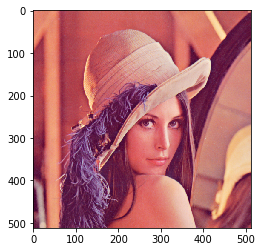

In [5]:
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

### 2) Transform to  grayscale
Grayscale is a range of monochromatic shades from black to white. 

More [here](https://techterms.com/definition/grayscale). 

[cvtColor](https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#cvtcolor)

In [419]:
gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

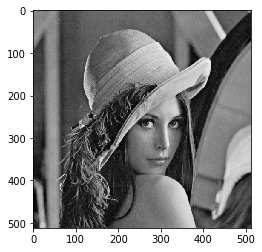

In [420]:
plt.imshow(gray, cmap='gray')

In [421]:
height = img.shape[0]
width = img.shape[1]
print('height: ', height, "\nwidth : ", width)

height:  512 
width :  512


### 3) Improve contrast

We want to stretch out the intensity range.

More [here](https://docs.opencv.org/3.4/d3/dc1/tutorial_basic_linear_transform.html) and [here](https://www.coursera.org/lecture/deep-learning-in-computer-vision/contrast-and-brightness-correction-JTX5e).

[equalizeHist](https://docs.opencv.org/2.4/doc/tutorials/imgproc/histograms/histogram_equalization/histogram_equalization.html)

In [422]:
contrast_img = cv.equalizeHist(gray)

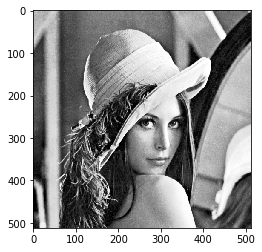

In [425]:
plt.imshow(contrast_img, cmap='gray')

### 4) Search edge points

We want to find sharp non-noise changes intensities corresponding the boundaries of objects on the stage.

More [here](https://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html), [here](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny).

[Canny](https://docs.opencv.org/2.4/doc/tutorials/imgproc/imgtrans/canny_detector/canny_detector.html)

In [285]:
canny_img_improve = cv.Canny(contrast_img, 300, 200)
canny_img_gray = cv.Canny(gray, 300, 200)

In [286]:
def plot_two_img(improve_contrast, gray, color=False):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_title('With improve contrast')
    ax2.set_title('Just gray image')
    if (color):
        ax1.imshow(improve_contrast)
        ax2.imshow(gray)
    else:
        ax1.imshow(improve_contrast, cmap='gray')
        ax2.imshow(gray, cmap='gray')

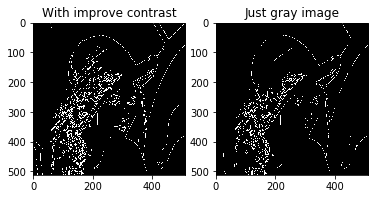

In [287]:
plot_two_img(canny_img_improve, canny_img_gray)

### 5) Corners detection

Corners are regions in the image with large variation in intensity in all the directions.

More [here](https://medium.com/pixel-wise/detect-those-corners-aba0f034078b), [here](https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html) and [here](https://docs.opencv.org/2.4/doc/tutorials/features2d/trackingmotion/harris_detector/harris_detector.html).

[goodFeaturesToTrack](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html#goodfeaturestotrack)

In [429]:
def draw_corners(corners_img, corners):
    for corner in corners:
        x, y = corner.ravel()
        cv.circle(corners_img, center=(x, y), radius=2, color=(255,69,0), thickness=-1)

def img_with_corners(img_):
    corners = cv.goodFeaturesToTrack(copy.deepcopy(img_), maxCorners=100, qualityLevel=0.4, minDistance=2)
    corners_img = copy.deepcopy(img_)
    draw_corners(corners_img, corners)

    return corners_img

### Only for show i'm specified radius like 10 instead 2 because matplotlib has trouble with colors 

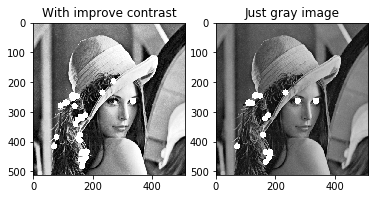

In [430]:
plot_two_img(img_with_corners(contrast_img), img_with_corners(gray))

### 6) Distance transform

We want get distance map by calculates the distance to the closest zero pixel for each pixel of the source image.

More [here](https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm) and [here](https://stackoverflow.com/questions/22563838/understanding-distance-transform-in-opencv)

[distanceTransform](https://docs.opencv.org/3.4/d7/d1b/group__imgproc__misc.html#ga8a0b7fdfcb7a13dde018988ba3a43042)

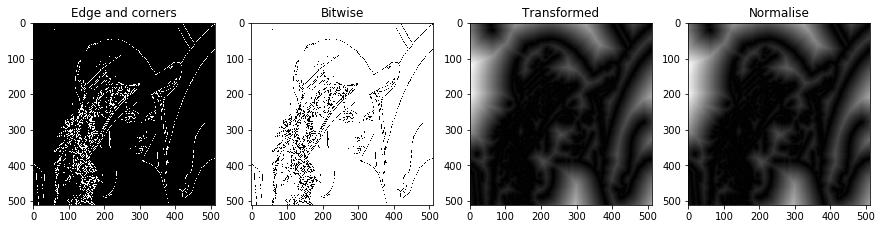

In [290]:
edge_and_corners = canny_img_improve

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,15))

draw_corners(edge_and_corners, corners)
ax1.set_title('Edge and corners')
ax1.imshow(canny_img_improve, cmap='gray')

cv.bitwise_not(edge_and_corners, edge_and_corners)
ax2.set_title('Bitwise')
ax2.imshow(edge_and_corners, cmap='gray')

dist_transform = cv.distanceTransform(edge_and_corners, distanceType=cv.DIST_L2, maskSize=3)
ax3.set_title('Transformed')
ax3.imshow(dist_transform, cmap='gray')

normalized = cv.normalize(dist_transform, normalized, alpha=0, beta=1., norm_type=cv.NORM_MINMAX)
ax4.set_title('Normalise')
ax4.imshow(normalized, cmap='gray')


## 7) Image filtering 

by averaging relative on distance to edge and corner points

In [378]:
def calculate_pixel(gray_image, radius, x, y):
    radius = int(radius)
    neighbors = []

    for l in range(-radius, radius):
        for k in range(-radius, radius):
            idX = bounded(x + k, 0, width - 1)
            idY = bounded(y + l, 0, height - 1)
            neighbors.append((gray_image[idY, idX], (idX, idY)))
    neighbors = sorted(neighbors, key = lambda a: a[0])
    
    if neighbors == []:
        return x, y
    
    coord = neighbors[int(len(neighbors) / 2)][1]
    x = coord[0]
    y = coord[1]
    return x, y

def bounded(value, min, max):
    if value < min:
        return int(min)
    if value > max:
        return int(max)
    return int(value)

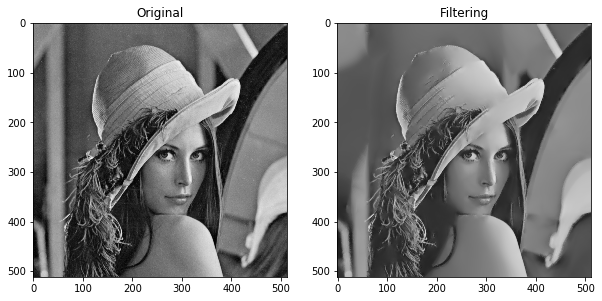

In [410]:
k = 100
median_image = np.zeros(shape=[height,width,3], dtype=np.uint8)

for i in range(height):
    for j in range(width):
        window_radius = k * normalized[i, j]
        x, y = calculate_pixel(gray, window_radius, j, i)

        median_image[i, j] = gray[y, x]
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))

ax1.set_title('Original')
ax1.imshow(gray, cmap='gray')

ax2data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAloAAAEtCAYAAADQlM4OAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADl0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uIDMuMC4zLCBodHRwOi8vbWF0cGxvdGxpYi5vcmcvnQurowAAIABJREFUeJzsvWuMZOl53/c/VdVdt67u6st099xnZ2f2wh0tKVFcUDIDGbRlOhYkJzJBi6KQUIAhRbH8QZETBwrk2P5gJIGRGJYtW05gw6BjWIYgGDFgSbaUCNiFSdpr0uRydzk7uzs9l77f6tJV3dVdXScfan5PP3X21K1nlmyO6gEaXZdT73lv533+7/+5vEEYhhrJSEYykpGMZCQjGcmTl8R3uwIjGclIRjKSkYxkJE+rjIDWSEYykpGMZCQjGcmHJCOgNZKRjGQkIxnJSEbyIckIaI1kJCMZyUhGMpKRfEgyAlojGclIRjKSkYxkJB+SjIDWSEYykpGMZCQjGcmHJCOgNZIPTYIg+JUgCP6vJ33tAGWFQRDceBJljWQkI3n6JAiCK0EQ7AVBkHz0/g+DIPgLT7D8/ywIgttPqryRfG/LCGiNZGAJguCLQRC8EQRBPQiCtSAI/n4QBMVu14dh+DfDMBxo8Rrm2pGMZCQjGVSCIFgKgmD/EbDaC4JgT1IzDMOJMAyPY67/YhAErz3OPcMwfDUMw+cfp4yRPD0yAlojGUiCIPhlSf+rpP9e0pSkT0q6KunfBkEwHnN96jtbw5GMZCQj6So//ghY8bfyYd1otPaNJCojoDWSvhIEwaSkvy7pL4Vh+LthGB6FYbgk6XOSrkn6mSAI/loQBL8VBME/DYKgIumLjz77p66c/yoIgntBEGwHQfCrj3aaf/LRd3ZtEATXHpn//usgCO4HQbAVBMH/5Mp5JQiCLwdBUAqCYDUIgr8bB/ZGMpKRjCRO3BqTinz+oqR/IOmHHrFfpUefp4Mg+FuP1qP1IAj+QRAE2Uff/fEgCB4GQfBXgiBYk/SP+cyVuxQEwV8OguCbQRCUgyD4zSAIMu77/+HRWrYSBMFfGLk/PF0yAlojGUR+WFJG0m/7D8Mw3JP0ryX96KOP/qyk35JUlPR/+2uDIPiIpF+X9AVJ59VmxS72ue+nJD0v6U9I+quPFkFJOpb0S5LmJP3Qo+//21O0ayQjGclITMIwfFvSfyPpy4+YL1wj/hdJz0n6mKQbaq9df9X9dFHSjNos/891Kf5zkv60pGckvSzpi5IUBMGflvTfSfqTj8r+40+sQSM5EzICWiMZROYkbYVh2Iz5bvXR91J7cfqXYRi2wjDcj1z3WUn/KgzD18IwPFR7kep30OZfD8NwPwzDb0j6hqSPSlIYhv8xDMOvhGHYfMSs/YakHzld00YykpH8EZB/+YgBLwVB8C+H+WEQBIHa4OmXwjDcCcOwKulvSvopd1lL0v8chmEjZu1D/k4YhithGO5I+ldqgzapDcD+cRiGb4ZhWJf014ap30jOvoxsySMZRLYkzQVBkIoBW+cffS9JD3qUccF/H4ZhPQiC7T73XXOv65ImJCkIguck/e+SflBSTu15/B/7NWIkIxnJH1n5L8Iw/H3eBEFwbYjfnlN7nfmPbczVLkJS0l2zGYbhQZ9youvZhUevL0h63X3Xax0dyfegjBitkQwiX5bUkPST/sMgCCYk/eeS/uDRR70YqlVJl9xvs5JmT1mfvy/p25JuhmE4KelX1F74RjKSkYzkcSW6jm1J2pf0UhiGxUd/U2EYTvT4zTDSsTZKuvwYZY3kDMoIaI2kr4RhWFbbGf7XgiD400EQjD3aEf4LSQ8lfWmAYn5L0o8HQfDDjxzX/5pOD44KkiqS9oIgeEHSL5yynJGMZCQjicq6pEsE2IRh2JL0f0r6P4IgmJekIAguBkHwmSd0v38h6WeDIHgxCIKcpF99QuWO5IzICGiNZCAJw/B/U5s5+ltqg5yvqk1x/4kwDBsD/P5NSX9J0j9Xewe3J2lDbaZsWPnLkn5aUlXtBfA3T1HGSEYykpHEyf8r6U1Ja0EQ4BbxVyS9K+krj6Kqf1/tQJ3HljAMf0fS35H0/3GPR1+dZm0cyRmUIAwfh/EcyUhOJ4/MjiW1zX93v9v1GclIRjKSsyCPoqu/JSndJQBpJN9jMmK0RvIdkyAIfjwIglwQBHm1mbE3JC19d2s1kpGMZCTfXQmC4L98lKtrWu3E0P9qBLKeHvlQgNYjP57bQRC8GwTB//hh3GMk35PyZyWtPPq7KemnwhGlOpIzKKM1bCTfYfl5tV0p3lM7T+DI7/QpkiduOnx0SOc7aiexfCjpP0j6fBiGbz3RG41kJCMZyYcgozVsJCMZyZOUD4PRekXSu2EYvv8oMeU/V5vJGMlIRjKS7wUZrWEjGclInph8GEDrojoTrj1U/6NWRjKSkYzkrMhoDRvJSEbyxOS7lhk+CIKf06MzocbHxz8+Pz+vMAzlMu9KklqtloIgUBAE9tp//qgs+5OkMAyVSCQUBIEwjfL7MAzVbDYVhqGOjo7UarXUarXsGq5PJBJWThiGHa+7CfWnnEQiYeVG2t5xrW8b3/l68J2/N2X7ulMH/75bf/n6+nJ9XcMwVDKZ1PHxsdUxWh9fZ/87X0/aEy07kUgokUjo+Pg4duzj2uLb0a3+0XHz1/FHvzFPksmkgiCw934++XL5HZ9F6+T7m77yv4/rE9+XcZLNZpVMJj8wn4Ig0PHxsZrNpur1uur1ekef0RY/FoxltF3RdnRrH0L7omNFm/0cppxkMqlMpn2ObrPZ1MrKylYYhudiG33GJW79Gkbi1pHoHPKfc30Yhva8tFotHR8f6/j4OPZ3Xeo99DXdfjNIWY9z/dMm0TF/kv0RfW7j/p+mLCl+rvb7jZdMJmNrfdy1x8fHqtfrOjw8/MBcflJz+jQS1SuJRELpdFpSu87Ly8sDr18fBtBaVmdm20uPPuuQMAz/oaR/KEmXL18Of/mXf1n7+/tKp9O2SCeTSe3v7ysIAo2Pj2t/f98UYr1e1/j4uA3g2NiY/bbZbCqXyymZTKrZbKrVatnvG42GSqWSGo2GlpeXdXBwoFqtJkkaHx/X4eGhksmklTU2NmbKjM+8svXKFIWUSqV0fHxsSmV8fLxD6WQyGR0cHCiVSmlsbExjY2Pa39/X2NiYMpmMDg8Prd68Hxsbs4mYSCRM+VYqFSWTSfsDPPr6t1otNRoNU3a0CQV7dHSkVCqlZrOp8fFxxkdhGGpiYkKlUknj4+M6ODhQOp3W4eGhEomEms2mUqmU0um0Go2G9cfR0ZGBHa6nLs1m0wBCOp1WPp9XtVq1fgfYpVIpHR4eSpKSyfZJF2NjYzo4ODDQcXBwoGw2a/f298hkMmo2m9aXtI+6MObpdFpjY2MqFovKZDLKZDI2r7LZrIEG+p/5yJxMJBJqNBrWz2NjY5JkfXVwcGCfoxhzuZwODw/VarVsPBiDVCpl4J+5devWLRWLReVyObtvq9VSKpVStVrV5uamvvnNb+r111/X4eGhUqmUgiDQxMREB3DMZDIql8s2H7k384s5SV8mk0kb92Qy2bHw1Ot1TU5O2jxpNtsBUszto6Mj+4x5XiwWdePGDSWTSW1ubupXf/VX7w23tHzHpO8aFl2/fumXfonPYwuMfh6ndHk+JXWA5GQyafOw0Whob29Ph4eHqtfr2t3d1d7enpUTB8ij9+n337/2G5C476OfRe87yOten/WSXtfHbcKehAxSXtw13X7Xqw2D9l10HJLJpK0l/catV3lx0qsd0U0j/2/evKnx8XHl83mNjY3Z3GZ9q1ar+trXvqYHDx6oXC7b2pNKpex5kNSxsRu0T7rVtZ/QzqOjIyUSCSWTSRUKBV29elWJREK7u7v6lV/5lYHXrw/DdPgfJN0MguCZoJ1Z96ck/T+9fgBw8kpakvb29ox9ajQaajabqlarpmTYnR8dHalSqahWq+n4+FhjY2MdzAXKAoWQSCRULpdNsXPtwUH7qCpAWbPZNMAjyUAM6FtqK5yDgwNTnAwMipWJwqQbGxtTrVYzsHN8fKxWq2VKHSWVTqetbihoJhoDz4QELPAHwBwfH7f2Sm0WAVCHIqSOx8fHBtQSiYS1D5C1v79v40CdaVe1WrV6ohBgQuh3/6D7MT44OLCHrtls6uDgQMfHxzo6OtLY2JiV468/Pj5Wo9GwegGKWGQAYQArHmx2S41Go4NNk2TtZz4CrsfGxpTL5XR0dNQBBumLw8NDA3osGvQNdaO8sbExG5N0Oq0gCGx+S21A0mg0jG3lmajX69rf3++oK/2VyWSUzWY1MTFhgK3ZbCqbzerw8FBHR0c2Xsw7xpY60yfNZrNjbJLJpAE32s5cpK8YPxZ1z2wBegFaYRhqc3NTt2/f1le+8hWdYRl6DZO6K1jPRvn33cqIYxy9BEGgarVq61W3ekTvHfd/UOnGWA/6/Ych/UDtdwNkdZNuyr3XfIgbv7h6xL0fZK7F/f607FDc/GKzyDz1ZEO0brlcTrVarWP9idbtSYznoO3juihrv7Ozo6WlJf2n//SfhrrvE2e0wjBsBkHwi5J+T+1DN/9R2M4K3us31iDYjGazaYoFZeTZIpQNChmQA5JvNpumdAFmtVrNduegZRRqrVZTIpFQJpMxRQojhdLm+7GxMTUaDQNxh4eHpjQpk++oJ+xBo9EwxQXIQVkBdJLJpMrlsqampuy9Z1aoEyCC/0xEmDXAgW9zrVYzFohrJFm5sD2wMBMTE6pWqyoWi8Z4ALq4V6FQMFABSEK5eiXNw8UYwnh4EOnZJ/qR8Ws0GsaC1ev1jrH3Y+AZliAIdHBwoEwmY+VlMhnV63WlUinV6/UOtpAHbHJy0vrG7+wZQ9oRhqHS6bQBGsBUo9GwNjNPpRN2rlqtWh/5+ezZLRTqysqK8vm8MXgsVPRjNpvVhQsXdOXKFWN9uZcHRLlcztg3X0cPzj3z6ecRfQTAzWQyBlhhUCuVisbHxzvKy2QySqfTarVaWl1d1Ve+8hXV63VVKpXhF5fvkJxmDesmHigNyrDEsTHhI5Mh85t1J3ov/3v/27jPB5FevzlNeb1+e9r6SYP37WnkSZTbr4xBwM4w/fM4Y+7rEAfyu7Ul6tbBZnRjY0PZbLbD5O2ZtnQ6ratXr2ptbU0PHz40QsNfG9eGx5l/g7QZvAFJsLm5qW984xva39//wLPXTz4UH60wDP+1pH896PUecMD4jI+PK51OdygOlJwkM8tkMhnVajXNzs4aGGLA+Y+5CGVcLpepp4GjyclJAz/1et0AhvdR8ooQ88/+/r6y2azq9bqmpqY6lDltw4zkJwVtRqlRt1Qq1cFowSB58Ij5DUUPO8OkhNkCYKEY9/b2jHlg8kxNTalSqejw8NDMbR6UodDL5bLGxsZUr9etbxFADX3sHwD6FNDs2SnP0KA4MMfBtnE9fTE+Pq6dnR1jhmCHML0yjwAV4+PjBhoAF4eHh0qn0x0sHvMsn88bG+h3XZgUKTMIAjUaDU1MTBjDBrCpVqs2PvQBDywsGeMSBIH29/etvxOJhIHKIAiUz+dVLpe1s7NjpmXPQlK3ubk53bx5U7u7u9ra2tLe3p4xcdwvynRg1qX/aA/PDCZhzJlhGCqfz9uzgMkRRpq5CxAABB4fH2ttbU1bW1taXl62cTvLMuwa1o9dQXopKsaF5yu6eeKPcedzX2YcSOsFaPz1T1JpnVZOW4/vFIvWT7rVYxgg6BV99P0g49UPZA0Cnvk/LICNXptIJFStVlUul0334OfEPdBPV69eVblc1u7ubgdzHvcMnUa6/S7O7BjdqGxubmp3d1eVSqXDVD+onLnM8JVKxUwOKDxYC0AAbBLAC9rRK38UKEzC4eGhstmsarWaKXEUO2yEZ4a4F4JCAfiAaGFtUJjewZ7yAA/US2orR3apTDaYERgQABTMBWCK+nMdoAFG4ujoyBS/1AYyBwcH1m/0SxiGxiyg9D2zSPkwg0dHR8bqSDKm4vDw0PyHYBQlWd8DdqQT9jKXyykMQ6sH9YWpAxzhAzY2NqZsNmvvPaPk6w+L4gMfpM7d1sTEhLXLgzPmgXQCHhk/mAQYqPHxcWP38DdLp9PWdsqN+u/5OdVoNMxk532yYNfCMDT28P79+6pWq6rX6x8I4EilUsrn85qbm9O1a9cktc2QUZ8r6u+BYjqdtoVjYmJCBwcH2tvbU6vV0v7+fsdcYNHFrIm/Bc8C9ygUCjo6OrL/a2trWlpa0srKSocp+WmXXkq312/8bj763z//XO///OYk+het06Dg8LTtfNxyvxPSq5/8+7MgcWMY/U7qBGhxbYv7TS8BeFDuIM+u3yCEYajV1dUO3Rut78TEhC5cuKBLly7Z534u97vPsG2Ltin6GYRFKpWyDSL+kKeZE2cGaGEyyuVyxkyFYWjO4LyW2vZcAAgKIJ/Pm0L230knE25vb8/YGsqnbH8vz6qkUikDQR6Re+oTh3TYCvxRAFCAL3xgQOv47pTLZTNPUj/vdC61gQSO6oAZGASYJyYxzIf3MfNs1tHRkYEWzGAoUx/FVCgUDMzSFvrKmzwlmdN5NCoxm81a/Yk6o9+ZzJhWj46OVCwWjVWiD6QT3yxALsEPgCtYF0CEJDMXwlTBgJbLZQOxsDmwCPS/31HB6jC2MDgAtWw2a3MOgMFOzFPPXBNlIekTfLKkE2BPvzSbTW1vb2t/f98AEMoWMDg/P6+rV6/q8uXL9h2AC4DkfcqOjo7smWAO4PRJ/yN8B/hFeP6Ym96Ez0727t27NveZJx5wPq3SSyENqrQ8gIpTmh58eSXmN539FPOHKae5z4cBcuJAx5MCmo/zu1516QeO+n3XC1yfFnT1km5tQZcShIaVw983lUoZ2Dp//rzpD8/kPql5EffM8RnrMuvT5uamHj58aFaLbr/vJ2cCaHmqkkUahYdCJppJUkd0lwcgXvHA4OB/xaABogBYRGZ5c5xndmBXCJ1H8XMvoshgoFBYMBKVSqXDcdn7gAE+JiYmjB3yfkn1er2DxfN+RCys+XzeAIXvk52dnQ5fGx9iS6RcrVbruMb7KCUSCWNrWMhrtZqBCRz46QtvzgLsoOQlqVardURE+ehKdg7j4+PmEAk4ATB6PycfbUoEHvff29szIBwEgYrFooIgMHM040yAhCQb84ODA1Wr1Q4fLFgu5pIk63PPtLIQwNQBVjEPwzoCGJGpqSl7BqQTFpB+8XNxbW3NzLz0kQdm+Xxes7Ozunnzpt0PMzkg07cJdpJx9IEQzCXAN2wr1xHVS3Qtmx2ex4ODA62tremNN95QuVzW1taWzfmJiQl7Zp8mGVSRI3Fgq5upJ65M1syomcODs+jnvI77PPpdtzYOct0gMkgZTwK8fNig8rTKPw7sDAKK+7XNf9dvPvb7fTeJM0f3KxuXBtb96Pf4ml69etXWPkmxm4wnuXnwOg+ds7+/rwcPHujOnTuqVqtmMTvtPc4E0EJ8hBiKBJOYB0OENnMtTIM3+7Hz9hFSKBHAEtGKKFxMKd65mvKon2dbYNg88+TZhrGxMRUKBVOsvk04Entnbm/SQdEDrmCjMEn5iLmDgwNjUXDwhiU5d+6cOVCj5GHvcrmccrmcfeadsIlmZOLxl81mjdGiX2BdJHUwYD4oAHBEH5CeY2JiwkyetNE7+dM/KGlABswMuw9Ylmw2a6BCkpnFYMfwWZLUYTZuNpvGFnlzpneupw0ADz9+nmELw9B87GCx0um09QN9jAkunU5bpKDvfz+PW612ig5YLeawB8JjY2OamZmxxQofKcpg/Kk74BYHeTY4jDnzjrkEU+qZ0GQyaRsZgF+pVNKDBw/0zjvvqFQq2bPK+JbLZUuv8bTIoKChl1KOA17dlAtzJ4656gachgVVw8qHBWj6AZkosOhWpzhl3e1vmLo9yet8Pfv9fhigGtdHg97Dfz6o2TDa7+g4WC0f7ObLxjH+4sWLHS4glBFX/9PMO29lwLeW9bxarWp1dVVLS0sql8tW18eZ32cCaMFIYBKkQ1G+3gQEIwTggtFA8cKkSDJ/Jc8WMZjnzp3TuXPnVCgUND093WGupA7UAzMdUYAo5qiChznyebNwzAb0+bxX9XpdkoyNQqlTJiAS1gBF5Rkc6ri3t/cBR/VUKqWNjQ1jiSYmJqwMlDXtSSaTxmyE4QkrhykI2hQFj1LG/JbL5STJAAP9Cfvm24U/VxiG5oTfarUMlOI/xW+ZFzhie78nzJeAPvzPomycjxoEFMPMAWr4HDYUx3dAFG2HGQP0Mg44tVNHmDQYREkdeWQ8sAbAe3CKSZSNQjqd1ubmpnZ2dsx5Hd8uJJ1Oa2ZmRjdu3NDs7KzNMb+DrNVq9qz49jAe/Pf+fABpnx8Oc+rU1JSZyw8ODvTw4UM9ePBA6+vrHclWPZPlAcIfRRkWmKFoUA4zMzOamZkxcD6s8hlWcT8pADKIcu9XhzhQ1Ot+cYq/H6gatr3DSlw/dKtn3PtuwCkOSA/SR4PWtxvo6sfKMm93dnYMbHnwwn90yZUrV2wd7QWyhpWoHxZrMa9rtZrW1tZsw+1T/jyOnAmghdJFaR4cHFiCM/xTGBTYGpQcigsAIp2wStFIL0lWVqlUsmSlKEgYCcyFLGIMMmYYnLErlYrVBxYGpedNNOVyucNRG1YDPxbvT0V0IWDNm8S4hzdvRpE5/eQdIlmI8eciUhLmBHDqWSLqMzc3Z4ofVsWb3mCwyGFGOdRdkk3Y4+NjSxMBO4SvF9F6gFfq22q1LKFpqVTqSG/hGUwP0FD61Idxx+QH6IaNkmRAEaaAMQDk+6hC5qw3eQPQvc8bvmGMoaQOs/L4+LgBdNhaxgzmD4ADG7i/v6+1tTVVq9WOZ8MHWxSLRV26dEnPPPNMxzPCPCYSkPuyYWFjks/nbQwAmjMzM8YcA6ZZ7ABfx8fHun//vu7cuaNSqWTJaJnra2trOjo60vj4uAqFwhNeRc62+GfSf9btWv5HFTDzDsadtW5QRTAoWzLM948rTxLU9AJR3e4z7G/6gbTT1Pk07/sB4+j/XiBskLJP017/G9ZHTIjeH1g6mdu5XE7nz5/XpUuXbH3sZj4cFEx6gBX9wzXp+PhYKysrunfvntbX1zvW1ccxG0pnBGghKN6pqSnzs/KoU5IxPIAYFrBEImFOvNJJ6gD8m6R2ZwOeKAslI8mSlAIquDeOvFHfL3xSYC0ADd7PCPMMSsvbpxlgTHb41XiTKaDBJ2H1yTi53jsPeqVOmbxHgWJi9AABoOd3G5ubmzo8PLSIEe5bKpVswQeg0teMlW87AKZUKtmDA9Ck3ih/zFgwkZOTkzaWTHgPcny0JlGLfjeCaQ4giV8UVHEul7Px9uAcB05MkdH0GvQZnwPauK/PteZ9s3weMaIKvZ9AXCqGVqtlzum1Wk2bm5s2z+g7FgZMsjdv3tTCwkKH6dr7mjF3ANCYN6vVqplcqV+1WpXUmU6AZzGZTGp7e1t3797Ve++9Zz5bCwsLKhQKNj6ezYJpe1pkUJNKr8+6KZDo73zQit8I9rpvL4DRrW69Po9+P4jS71fmacFLL+DTrT+7Kexu9TgtuHrcNvn3w/yu22+7gZNBQFg/6cZkRe9dr9e1s7NjuRBZn7gfp0hcu3bNfKilTl+t09QrymR5c2GpVNLDhw+1tbXVca+4CMmoX+QgcuaAFuCC0HRMXYAS6SQcdGJiwhZ+ScYmcA3Ayed/QpkDNCR1ZEnP5XJmdgKE4c/kI9skdfi81Ot1cwTHNOaVn2crUNR8B9vQaDQ6HMzxU/IRcOVy2Y4y8MlM6QeUKEwT7ByKHXNPpVJRPp/XwsKCMWzUAXPVwcGBmahgTmgjbAhsFv1BPciYT3Z/fKN4jZ+VZ7ZoC2MBqMUJ3/v10GfMFdpOP+fzeZsLjFkymdT09LTtpsidxTwBMGL6BJCTDsKbhBHYH5+8k8WAfgKUeAXJmPi5ATCn/TzQKFT+Hx0dqVQqmbkYcO1NmYztSy+99AFgg/8YQJZ744BKlK0k61PAOJsC5hlRwvfv39dbb72lxcVFVatVcyZtNpva2tqy58lvMEbSlm5KrpsiZMx4Jv28j/PzirvPk6rvh3GPfsq0G0CK+z7ufbf7nBbc9Krn417TDQx3a9swfTJIXU7bB91AF+seqWpYE6LXjY2NaWFhQTdu3DAXhkHrH/ddt+eDTfDKyoo2NjYknbiUUA5A73HMh2cGaLGzRin4hJ8oVExnfjfnGScUiI9KxJSFjxMgaW9vz4ASCUqldmQEEVywIIACIgwTiYRFXUltgEf5ksz05I/GwYcnn8/bwHkggJkIsxoADv8Z+ojoyzBsJ4+UZGyXR/4oVs9AhGFoqQxgctbX182cBugDeCYSCQN+KHzK9CZS6g6ADcPQUkN4NoX2+/MEEe90LZ1E3eGT54EPqTYAmpg/AS3ZbNYAHsoI4F4uly0IwAcbMNZ+xwMQIlgC4OP9/ehfKG7aCggNw5NcaZgrmavMC/oPoOdTXnjWAuYsDNtm7O3tbas77Bl9kcvlVCgUdP36dd26dcsc/ymT6Ez+mD/MN+Y9jKsHanxOdOvt27d1+/ZtNZtN3b1719pEnbPZrLGU3Kfb8THfy/I4C3Gcwh+EieK+fpfN8x4tt9vv+9WpH/MxaJu6fdfr972Yp27XRj/rVl633/ZT6IPWu9f3/drQrb/i6tYLRPYDT3FlxV1zGhAWZZJ4nUi0k5iWSqUO3erL5FSSy5cv67nnnjM3kWHmRLf68Bp9cPfuXbO2cNZiHPjzZMmwcmaAFuYGzAyYr+KU6dTUlF2PuQd/Ln4H2AnD0ECQB2/RKD4USSaTscSN+ILBgsGagLAlGRhCyVIfIvHC8OR8QJQcn3uggXLzZsVGo2EZz2Ef6AcUOBNQ6nRUhtWgLrAVY2MnZx3CEKF0/YHSIHpvMgLwkOnc+4R5wOCTxAIeyDjOuOzv7xuIBlTgy+YPD/eRpaSoCMOT/FSwaIBeH6nn00lks1ljVmg3vyOClAcJQI8ZlGOM6DPazNhyD+qWyWQMUAM4YGeZYx6oAfz86QCMJ/X0zv5ELy4tLWl3d9dM44xNGIYGtiYmJnT16lW/pjGZAAAgAElEQVTrD8BnJpPR9va2+cXBnjI3k8mkmVR95K6Psmw0Grpz547eeuutjrlCLjFAO4wp4Azz/NMmT4IBGVSp+WdUUsezwvth6tVPsT5u27rd80n1WbfPeN3Lx2eQv2Hq8zjf92pbP4A0CDiMa1e33w07BwZpm3eRWFlZUaVS6Qi88uWk02lNTk7qwoULtsFEZ0TbEnePbvXzloOlpSVtb29reXm5Y13v9TydRs4E0PLOnShRdvyALM9gATKkE+XmTWQMiHSS4fvg4KDjAGNYAu/74iPyOMuN3Tu+JoAMFC9RdygTD5R8DiXSI3ifKukkSg6wyG9A+vl8XoeHh5aPC8UFM+L9nXzeJcrHZ4nPwzC0+qI8W61WR1AA0XD0YTSQIJVKWUZ5D4gwCTEe/IZ6wQYypoAS2DP6Bkdr+sA/ULwnJQFMCYDc5+6CqsafijoC0jxbyFxivPHlq1QqyuVyHUloAR/0TaPRULVatfr7g7F99B6/ZdwYD5KfYobzAJX0Gz6tB30Vhm0fuv39ffO3o07My2KxqCtXrugHfuAHbE4Qdeg3GSw+sKWMHfPEj+3U1JS2t7f1xhtv6L333rN0K4VCweYXLDEA1kcz8mw/bfK4i7GXforef+af+WH9R+JASbf7DFPmsJ+fBnT1A1isjYOCrGhdTgO2evX9aUHlMGDLfzdIG3r1Ya/vTzNPonOz1WppZ2fHdFQ03QOR5levXtVLL71k+CDKbnXrl7h7oxMODg70zjvvqFKpaHd3N/b6uDoP096Otgx19YckYXjizwIYwqfHJ0705iZ2/ZI68mx5ROqBBMCEv+PjY/Pj8ZF2PrUCCvHo6EjVatXMIJSdSCQ6korCpuCL5JWLv6c/kJcjUSR1gAjAAIk+ceimj3xERNwDBmAE1MBoeFaNz33UBWkNUOSeIUPxoqT9JMd0tr+/b0CNscMHiuhCX0fGCnDrwRSgz4NWH3FJe/D1wtxKuQBY7oWP1eHhYQcwwvzmxw6GkzGgPwDX3BuTpD/sGdaH+mez2Q7THQAHAAXLSH96syXA1refOY9vwerqagcFz3wEbM3MzOi5557T4uLiB+hvH7lIItIoYAfEA5o4kmJpaUnVatXYVr+h4JlmvKQThs5vlJ4mGRZgPIn7eTM+Y8brQX4/6H2e1GeDsCKDgJte5Q4Knrrdu1+E22mkX9/0Akn+s7jX3X43DLDt15/Dtq3X536zurGxoc3NTZXL5Y5EyggmxJdfflnnzp3TzMyMrdWDjJEHWKxntVpN9+7d0/LyckduSf+bJy1nAmgBctjB498Eo8IuGDbC04woFenEJOiZGBSpN9+gJEm0CCsCM4KizufzFobuHcp9lCF+PhyEiUN5LpczZsb7N+3s7BgAwJ8MgINiAoyg4ABXTDCApY+Qwy/LR2PSfp9Dic8xg8E8+WzgMGa0FwXL9wAKb4oiyzzmW8qHMQLseKACyKOd3hzL94wjPkg8TNTPm+AAVT5nlmf96FMAFWCgWCx2RAzSx943TlIHE+Wd2gHjMIfe3MbY0o8oQiJq/TwGiPoUFfQbvlQ+2pQ+2NzctGAMPqcfWKimp6fNMd5HuDI/Ydykk+N26EfmI2BxZWVF3/rWt2wTwHxkbGu1mq5evdrBLLLIMZeeNh+t0yrhXgp/UJZAOslq7T8b9r6DXn8a8HTaew8LeLpd3w1cRP+8WSrORDUMeDlNe7uVPejrbgCsV7n9/vN60LZ1A3H+P+AnDEPt7OyYzvWmQdYNLAw3b97U9va2rc9RYBwVD7C8//HGxobu3Lmjer1u0dWnYYOHkTMBtOgkGnnx4sUOZTk5OWlKGFMcPjTSSdg6gAol431L8CEiohB/JsAVWcEx03E/mI9Go2FABgdt2AZJmpyc/ADrhr8Lwvf4IgGCEomEpqenTaHB5uHEjTL3odyAGe/Hg9APx8ftzOCYcMgVRRQeShw/Jw8cpJODkfneRznByvmAhDA88YeT1MFucF+YE89I+mOWAEvedImC9uMJkPNJbXE+BzQwP7hvOp22/sT/LggCy88FYPQ+aNKJyZS+pq341PngBFJIRB3mYVLjmDlv+mVMCYoABBGhA3OEmZqFY3V11aIpOf3A+79NTU3p8uXLunHjRscJ9H4Ow7J6XwXmbSqV0v379/Xuu+/q7bff1v7+fsd8Z0PA2YkcAcWOkblNPz6NjNYwEsdKdAMC0d/x3yuHbn/D1GUQwDQoaDgtC/IkpRvw7AYOWFuj5sbHkX4gp9vn0TEZ5nUcMIx7P8x/X79+oLVfe7y+Z63Y3Ny0ddTrMqm9+R0fH9f169d19epVW+N9dGB0vPwGxK9P9+/f13vvvWf6nWv4zYcFtlL9L/nwBUAFM7O1tWW+SHQCbIqnF33Ipw9xJp+Tz7YNK4Lib7XaiTBhFvhPaDuKlPrNzMyoVCqZuRDlg7nRO2GTwBTzjQd95CsKgpODiSWZn4xPg8AEg1mhTCYoJkUmHKGqmPGoK+CFPiQlgi/Lm3Vg6WgLEXwAgUwmo0qlYnnBPNtEG8h/EmXsGEPfRurplT4pHaLBCLSLsSToAMAFW8U88KDRM3s8aMwL7u2jAamnNxUCFL1TPnOGOeiZPqJl+cxHg/q6SjJgjBmR87UYe5+sFRMubOny8rLm5ubM9OcDP5LJpCYnJ9VsNnXr1i2tr69rY2PDxn9vb89YTJ8exB/oXqlUtLa2ptu3b5sDPf3E87iwsKCJiQnt7u4qDENbONlQeFaYef80yzBKtpuC8q/9Z7ABvO53T//9oH5E3KPb9XH3H+a+w/y+X9n+f7fv466ljd36WDpRxNHP48oftK7DSLSu/rV3BYi+joLyXnXx5cX955pB2tQPnPk/1uH19XVNT08biRIVgt1u3rypra0t7ezsdKzvPiiMe3q/xXK5rPX1dd29e9fWY79Z8YzwIDLsOJ4JRks6Ub6YNHw+KTpNOgECXM9vJZkiB4CgqLzJi9D2SqXygQUfxVIqlezswGSynSF+Z2fHBtUDLL8zB1igTJlI1AfwAmDI5XIdTBn+abQP1gZgB+gIw9CYpv39/Y5UBv54FA+2Wq2WKpVKB/CASiXVASZUD0hxsgb05nI5ywjvE4NG/XlwEIdVkk6yoqPUGS/AVavVMl8ngKy3oQNWADqMA/UHgNHvlO/NZPz5nE7UAcd8QBMCqKEu/oGkD2FDSYfAXCOdhmf2fF0woXkg5tkuxskfkwNI95F7lUrFksvid0WfUs+xsTGdP39e169fVzKZtAOqfcBIqVTqqBvzbH19XW+//bY9mwB8onPHx8e1vb2tpaUllUolVatVVSoV60vAbDRq92mUXkzIIECoH3MRlV4KIvrdMCDhNACiX3mDgMxhpJuS78bsARzYIMRFu3np5gs0SF1O24bod93mQ/SauL8oOxR3v0Hb1O0e3crpVS/fDoKxcKvxY4LgVnT+/Hldvny544SPbqyWJFu/tre37fi7OAarH5MVLXfYzcGZAFoeOaPIUIKYT1AgKDVSBPgDob3JhrQI3nzD4BBJBZjzvk9EFwJOxsfHLRqPs9pQ7jAL0skxM5IsilE6CSXFT8efT4cjNdd7R3HyZWFS43t/sDPAgDrBmHkbtmfBAEOAAliicrlsShCHf8xT+AcBIn26jUwmY9fxGSxdGIYdiVujDGS5XDawgxmXcQ7DE/8ynMW5XxAE5mBO2z3jBfDhPdGUjBPsFPPKm2Zhkgg59secAPDpW/rBM1Peqd2zhUQOYq4Nw9CAShi20yJ40zALBvOFOU+bKN9HZErSw4cP7RyxKMOYTLaP5sHXYWFhwfrJJ9yl35lvpVJJ9+7d03vvvSdJHVGJPJ/efDgxMWFty+fzHZGszLlcLvdYyvWsySBKmOv6lRN97RUIEgUOXknEKYBen52WTRqkncMAkn59103igKT/iypVxG8sWdtgXqkLr7GKUD90TDfg0Kv9p2VN4srtBnai33Wr5yD36NaOQeoaBT9x5XsWbm1tzdx2on7FkuxYvmvXrmlycjJ2DKIgq1KpWBqJzc3NjlNiokzWIPNykOc8Ts6E6VCSKXEazcTHjMcC77O/wwLwG+/8DeOB0s9ms8YWoGwrlYoBOu4JeIIx80lSDw4ODHRgavLAAGWKAOgAHwcHBxbpyCQE2PjjWpLJpOW28owc983lcjYhcXzm/sViUWF4khoB5c7h1rQPP55sNmu0LL9JpVLmt+TrDGhIJts5uj760Y9qaWlJV65csVPO9/b2dHR0pJ2dHWPaJBnYSSQS2tvbs75jwmNuxB+MfuQ76YTNDMPQIiqpH2ZNxpIx5KBq7+BNHwDycDAHyBHx553hfZSnZ8uYs4Bi70NGOzBBM15+Qaf9bBwAirQFNg220isC5vz+/r4KhYJFIZJmQZL5oiGFQkELCwu6fv26Njc3JckYypmZGVWr1Q5AvrGxobt37xo75aMeMVHzbNJ2nj3mn3+OEol2vq5cLmdnhz7NMuiC3E/xxTETw0rUxDio0o9e2+19XJnd7hNVtNHP4+ocdw3K0it1niHvLuKZ6MnJSeVyOT3//PNaXl7W+fPnzReXKPJSqaR6vW76hv739/Brgq+PN7cNI/1AzqDmPf+Z/xvEBNzrdXTM+9W/GwiNA1tssjc2Niz/o49Y5ppMJmOs1s7OTtd7sM5vbW3p4cOHtsnzMgiTddqxjMqZAFpB0E5oiWMxTABME5MahYW5jofA5/rxkWvkoSIHlVfsYRhqcnLSHiwUCA8RDzBMWFy2+kQiYSDp6OjIDuuV1BHxRv2JOgOJJxIJc6BmcuDXMzExoVqtZmyOp7fJXk+Uovf7KZVKxqDAlEXTC3jAiE/X1NSUtra2LHHm9PS0Go2GXn75ZS0vL9t5g5j2XnzxRb355pt6+eWXdf/+fV28eFF3797VJz7xCT148ECf/OQnFQSBVldXlUwm9dprr6lWq6lSqZji39vbUzabtbGD/QAAAVz8rtRHwHENip6+9TmrADuY2gCuHkBLMjNlPp83AEHEabPZ1NTUlJXnAzOYI4BYwBzi/bb4LYqBdmHe9f5+jCdzlvkMc0Qkbhi2s/Bz3dbWlubn5zU/P287cc8QkxPu1q1bun//vra3tzvSagAqj4+PtbS0pLfeessYKW9WBdhLsn71CxbjxFmWbBqeJHA4a3LaBTn6O680/HMfZxrpxlb1AyxRVmyYOg56vWcK+pllBmXi4hiGZDJpvoH4bE5OTurw8FDf933fp/X1dTv5A//YZ599VsfHx1pcXLR1kjmez+dVq9VULBa1ubmpRCKhr33ta6rX67ZG+chwX1e/efIg4XGU9SC/jQOscSAkDqT5e0TrGgfmetUvDvRE6+N/4+/barW0u7ur2dlZYxv9mo+FI5PJ6ObNm1pZWbFM7p6Fh0x58OCBbcr9/djwDdLfTwJkSWcEaEkyU53vkGw22xEyz6IDeyDJFLP/g4kJgsByPlEmyotklCgiduGSjF2BNcFHql6vK5vNmsOyJPPdwTEYs6JPAZDP5+0+KHyfqZs6cw31Q7mCxqE9YSzwn4LBYxGhPkw+nPgBJ9lsVtVq1fx/MFFdv37dTHKJRPuQ7q2tLXNS5I8T2J955hlVKhXNz8/r8PBQly5d0sOHD/XCCy/ozp07On/+vIrFovb39/W5z31Oh4eHev/997W5ual33nnHnK/9ogR4ituheMYKcEV9vYkMUOn9uCQZw0KCzWw225FPjPt79oWdMQyjj5Dc39/X1NSUnckIMyWdLNr+QGrfRurl683O20dkEiQhnTjleud18lixIDUaDd2/f18TExMGsGFamSMTExOamprSRz/6Uf3BH/yB6vW6KZtCoaBarabV1VXduXPHNjeAd7+T9+ch8ixiDs3n85YpnvGCRcQs/jTJ4zAYce+ja2E0urgb8BkGYD2udGNRugGkXp/3qzfXemWNXpDaz/bly5fNH5OkzPv7+x2bxLGx9tFjJKnkeuYmbh6wYfl8Xq1WS5/+9KcVBIEePHig3d1dO2rK+6jGSS/WyfdhtE+jgDJ6bT/w1o3R6sZMRYFi3P/odd3qLX1wnvYCWf714eGhVlZWLKjHWwmoSy6X08zMjF588UX9u3/372yt9pvcpaUl3bt37wMperypMI7NGhRkDfu8nwmghSKV1AGgYIVQSGEY2q4FJoNDnH2STICKV+IgWQ9qYCbwfyG8PQgCbW5uamJiwpQG4AUHYFi0MAxVLBYN/OE/RXtQ7Djao2RgBwAFKHBJBhBB9JOTk5aTijQGPqoSZ3tMlJQDo1cqlZROp81vDeWfSqVULBY1MzOj/f19Y3LCMNT29rZmZmbML21srH2i+urqqi5cuKDd3V2ry+LiopaWljQ/P69arabNzU2lUiktLS1pdnbWlPTh4aGuX7+uGzdu6JOf/KRu376td955RxsbGwZQ8bsCXAKCcDLHj4y+AWjS14BjmCZ2MzyImDAJRACoMw+9Odaza/j38Z9+B8RyP4ANzBAgyJv+vGkQcATohC1iPFCwXIdCIOgC8E5fjY+Pq1QqaWtryxhYzsRkbuVyORWLRV2+fFk3b97UgwcPjB1rNptaW1vT22+/3RF1ube31/Fs+Y2Dfx5RWiQg9NGmkiy1BwDuaZZBF+NujIB0wp4zDwdhtLp9PgyLFVWsp5FeTJZX2NH2RyPIugGTRCKhYrGoqampjmAp6eTEDemE5fAbGMRvbHyd/DPuddOVK1d0+fJlc5u4e/eunTnK84bO8Yx1tB1xfdXt87jv6Ntu4NYDpCjY8t93q0M/5iv6m27gqdv3vZ6NarWq3d1ds7owfrR3bGxMhUJBzz77rCVslk5A1PLyst57771Y8D6IubBf/U6zqToTQAsWh0lNh6FAYKG8r5N08gChZNhdYM4DfOHnIp3kRPJO3TxYKPpEImFUszePAFAAPpgjqQv38WCH35AWwdv1car0KRy4n498gz1D0WE2xJ/JZ0OHVUAZVqtVi8ojqej4+Limp6cNFNA3+GZVq1UVCgXdvXtXU1NTmpyc1P7+vvno+Gzo+/v72t7eNqBQKBR07949zc7OGkDb3d01Fmh1dVWXL19Wq9XSc889p8uXL2t3d1df//rX9eDBA6tTLpez1BJhGFrOLFgUQAwKnzbAEsIQeUCOiZeHDJYnCALLK0X/AT6lTqDCfb0fICwPc5CxYf7BWuGHBwjDoV06SVsCgwqgYRwxz3lWj7bDtPFsNBoN3b17VxMTEzZOfoeZSqU0OTmpS5cu6eMf/7h2d3dNMe3t7enu3bvGTPkdO0oJx33K2dvb0/7+vuVp86lMALWAY6Jsn8b0Do/LanmF6COpfGSVd8oeVAYxG0ZZjkHNftG2dFP83UBeHIjC3YJnhf8eWExPT3dETnuLhA8E8UoVEMf6yHPIPTxz4tvAGFBfQNQzzzyjxcVFlctlvf3221pdXTVLggdnUbN6XL/1et/ts7g+jAKkbgCnG8jqVVb0d3EgeRBGrhtrxHiEYaiHDx+aPzBmRH8d+SFfeumljsCqUqmkhw8fdlgX/Jj5+TAI0IzKIEAxTs5E1KF3AqdDfcZyzkLy/2E3eCiJ+vJsEDt0HiKfMgKAxX3YwbDbJspRkim+RqPRAfgAOTyI3v8IJe8zfFN/2kheIV8e0WqwHPl83pzHmTiYMmHnYMQwVTJJWIh40Ofm5lQsFlUsFlUoFDp8Ejj0WZKmpqYMMOTzee3u7mp8fFx37twxRSvJklLu7e3pwoULZgbF52tvb0+Hh4c6f/68Hj58qOPjYxUKBQNP4+PjymQyunHjhn7iJ35Cn/70p62fWq2WneOHogHgkD/L514joo7+PTw8tMz/kiyiTjp58Bhzz5zNz8937EwB3JiGwzA0RhEWkofY/wGivJ8e84F7Mx+Yfyw0/n6AHNIuwF5SFm0DgOLQv729rY2NjY6IRRYx+iKXy+nixYt6+eWXJUlbW1t68803OzL6J5PtZKfMBcC273vAHoEF9Xrdgi9mZmY+4FvZz0fie1GeJMjiz6cf8K996pGoRM0iUVDTy2zSbaffT/EPs/uPY1mkTlMp4pUr6yLMej6f72CypJNNtL83QIENe1wUHH3rAW20ztHfsgZms1ktLi7q05/+tH7oh37IvmNTFOdX1w2M9JoP/rO4NsRdi8SZm+Pex9WtWx26fTbofXzfeiAMCVIqlbS9vW1jGgdWSffw/PPPK5FIaHt7W3fu3LFUMnH36AZ4+9U5rt3DyJlZ7cLwxLEQPyg+97mmarWamd5QcFEzoU+X4IEOTEc+nzefJc8QRHNR+VxB3gHYL3aAMSIlMCHu7e3Zw+ZDVVEyZCkHedN+dl2tVjvL9s7OTkceKJgaTGSwJPgfUZdsNqtcLqeXX35Zzz33nAqFgjEXsFr4j1FX2JBkMqkLFy5YPRqNhnZ2dsyvaWlpycxDqVRK5XLZ6PNyuax0Oq1qtaobN25Yxt9r165pfX3ddikAFcJ0JenjH/+4fuqnfkrnz583BssDJHJ++ehB5gumNFJKADQpgzEE0NLnBCMwh8hFBZsaBbfMDb+bpv70LbmpWDQAfAcHBwbaASk+wEI6CfDgWYBJyufztkjQblg15rZXGM1mU++8845WV1etbEAyyocjpl544QW1Wi29//77FnXo2waghqGEQWO++fQOgMCoWQOATXDHH2Xppbi8ou4Ftnot+HHgqhujFPd+kPoPK72UsG+vdHKiRCaT0fPPP69r166pUCgYuxoEgQUB0S8wsoAbH2wRvTfPh2cN/X+/cerXN6xFyWRSzz//vH7sx35Mc3NzNla4QMQBtTjA1U2Z9wM8cf07yPWDjFW3srvVa1iJ+00QBFpaWtLm5qZFhUcBYzqdVqFQ0PXr19VqtfTgwYOOvItRFmtQkDXs94PImTAdotClE7bp8PDQjhRh0S+Xyx15j2AxyObt2QAmOcyApI4HEQUI4JFkjNb09LQ9xN4BmvckoUQJAwYBL4A1H/Lvo+j8ocwAOBSxJFNMRB1Sd5gaTIewTvV6XefOnbPyX3zxRW1sbCgMQz148EB7e3t2Lt3x8bFKpZKZ+SqVilKplJn3gqCdBZ/Ixt3dXaNucY6fnZ1VPp9XMtk+PoH+rtfrqlarevbZZ7W1taXt7W1dv35dKysrWlxc1PXr17WxsaGZmRkzUzYaDfNr293d1cLCgj7/+c/rq1/9qr785S8be4TTfqVSkaSOI3c8qGJusBAzJwA0nvWTZIlrGato4ESr1epgBrkX4Nb7XdG/0sluPAxPsh/DbHmnfMaY8cTMzLWAce+rFYYnEYJEu/pniTKOj4/Npw5mzLNRjGmr1bKoLSQIAhWLRTMtA1RzuVyHAzIbHK4jihTgSvsSiYQWFxe1vb2tw8NDYwqfNummNIZlDzwD6c2H/nWv+wwCpuLAVzelguLifzeJu85/5u/n506xWDST27PPPmvJjtfW1lSv122jQ+BOuVw20EX5Htx7/yj6yrttoIR93bqNXVRJ+z6OtrNQKOjHfuzH9M1vflNf//rXO1LB9AJR/nUcAOt277jv4sao37h2+zzuf7d6D3K/uLrHmSul9nhtbGxofn7eiBFv3pXam7yZmRnTR1FSgzJ7Aa24vuzVv6eRM8NooeC8iYzdL50Hi0HOJoATJhjMJkSAeVMOLAGmvnw+bxElsGAoUsLeYbs4IBrzIfX0R7Z40IWPjnQSoh+GoflokZeKxQYFK534ZgGoKA8QRXtwNj46OtLCwoJu3LihYrGoubk53bt3T+VyWZubmyqVSub4zv2Jqtzc3LScXdS1UChofX3dGMRWq6WFhQUDNeVyWQsLC1peXrZotXPnzmlra8v6an19XYuLi9aXV69e1c7OjkqlkorFora3ty3YgCz9tVpNMzMzBoL/2B/7Y/riF7+oGzduGNsmyZLV+shTTL0AcvyLmD9RMx4gBvFJC2EIvd8f1/ujmfBXwl8NAOQZV4AIwIMoR+opneQJYx54fxBSOEgniwb+T9Q56qeCmUNqg/ONjQ3du3fP+pi+wkeFubu2tmZzDp8wxhyfOe9zBjCcmJjoSH4bTQ5LqHy1WjUw6n3enhbpxRJ0Yyf8aw+w/F/UZAiA7mY+7GUu9O+jf/3aMEg7evVJFGTAwLIuX7lyRZOTk5qentby8rK2t7ctT5KkjnB/6YSVoj98P0X/4sAr76Nt7jeO/UARa/atW7f0kz/5k7p06ZI9G6xB0bpG50Cvvourd6/f+rGJu67b2MV932uz0O8zqTdzGmfWTiQS2tnZ0fLyslk4WNu4BhZ9c3NTm5ubXUFwLxl0zvdihfvJmWC0pE7gsr+/b35HBwcHOjg40M7OjnZ2dlSr1ZTP583BVjrZHUXtuLANnokCsFWrVfNdkU7O1kNhwibgRO6zwKNsJVmqBgCVj5BEocCK1ev1jrBhn9WehxRzEEpXkgEaAGWj0dDU1JQuXbpkvlNvvPGGJFk27kQioVqtpkwmY8wduyvu4/MxSW3FnE6nVSqVLKLR5yFLp9O6cOGCHUqMsq1UKioWizo6OtLc3JyxhefOnbO+npubU6VSUb1e1+zsrIIg0NramhYXF43dIqRXakee5PN5ffazn9Wrr76qr371qx1sJ+OAGcEndcVpHuCAgmeRg5HyyozxBowydwqFggF15o5nmGCPfP+iFAEZsJH4VwF08CXkPWPFzl6SRacCzJgbgC3YOe9/SOQmZtGlpSVNTU1pamrKygCQ7ezs6Mtf/rJ+93d/19pCH2cyGVWrVWWzWesD7o+vGSwYYBRgy/NAn2C+5TmPiwD7oyBxyisOZEUZrDg/okF8teLed2Mw+D+sEokrq5+ZJpVK6dKlSxobG9O9e/f0/vvvSzpJI8KmBXcKyov2T9Tfj8/oTy/MefRElAWL/g3aD/5ar5iz2aw+85nP6PXXX9c3v/lNu47nO8402Wt++LJpg9d5wxcYXhYAACAASURBVIL9KEvXj9nqVuagQKwXoEGoA3o4DEMtLy+rUCioUCjYxpW+Ozw81GuvvaZXX33VIrKjgC3KrA5bn0Gu6ydnhtHCeRw2AoDVbLazjVerVVWrVUvsiOlDOok+BJxJMhMNCpGoOaK6MMmEYWimKc9ssNPC0RjaGvMQu3ryObHoeYXLWYuezgTU4NPkzZPeTOgRu4+m8cDu8uXL+sM//EMzBbZa7YSllUrFUjrQHz7KplgsGqCjXbVazRK40j/lctl8qY6OjrSysmK7hjBsm8RQ5ul0WuVy2ZzXJXVE2a2trVlGZoDl9PS0Hj58qEQiYZGcgGwOpa7X6/rEJz6hn/mZn9HFixetnbCEUjvTM/eibEBvGIYdmf5xpIdt8dFKpOCQTpKj+uAF/zl9xz1himg7wRH41AE4AXXUzfuAkSQR5pbFxkdK+pQLHnAyPzAdegfSo6MjiyT0imhnZ0e3b9/W3/t7f8+eDekkLxY+cePj4x/ImQVjB4NIuzAh+rrRDukk3cnW1tYpVonvTYlT4nEshQcRYdjpnxX1wfMbsTjWyr+OKp7oNd2YjifRZv862r7z58/r3//7f99x5iabsb29PVuvaCfKddD+jLI/UZYrjvV6Em1H0Ge3bt3ST/zET2h+ft7uwToWZeG6tcf3q/dViptDwwKu6Jj1u2aQcuOkF9iPY1lZYxuNRkd2d9p4dHSkN998U//sn/2zjgjyuDke935QiXuehp0nZwJogcxhH6rVqi3imIpgBbzZB4YJsBKGJxmo+Z6HlQWeJIqTk5OmZL2CIcIvnU7b7grTjiTziUFZ+uNNvEkI5ehZh2azaUwaJlEyrTNxiPKKggXPukjSzZs3zUzjc44R9kxm5MnJSUstgG9QpVKxcsrlsgqFgpnBKpWKnSUIyFxfXzdzp9QGUHNzc8bM4S919epVM4PC3K2trSmZTFqurVwup3w+r62tLTNLQgsTCbm/v28mWt5PT0/rs5/9rF555RVj0Wq1mo6Pj7W1tWX+TgAwADsPJ+2DWYF1k06i4WCCYGuIZJVkc4TyeKiTyaRl02e+YP4knQRRlDi0AwbJsYVpjnQZQRBYn7KAYDIkDxoMow/kkNoLHqZiwHWz2dTu7q4ePHhgfbS5uamlpSX97b/9t7W1tWWbDEmWKR72D+YTQAWQ836RPkiBuU19wjC0o55arZYxxE+TdFOK3ZiJqKKPMjX+v1fKbDK53sugZkIPVlBap2lv9PUgrAdy9epVYzjZ7AImo3MnylJInYc9RwFKFNB1MydGyxlWujFA0TYHQTsX4mc+8xndunWrw1LjAXS0bt3mT7Te/cBZ3Fg8Dqh8UqA8yjhFAZZn/CqVitbX123tbjQaeuedd/RP/sk/sVRLXqJs4SAgK/r89BJ0x6ByJvh7FBbRhZJs112tVs2nB2DDhMQxGsWIUpLUsRPE7ysM2yxVtVrtiApDeaFUMOtgksGMwsLmd5JS544NZ2HYJPILcXSDV1Q4siPeZHV8fGz+L/6enEv4zjvvqFqt2tFFMDr4wrRa7WAB8isBqKg3QAImUZKZttLptHZ3dzUxMaH19XVJMnC2sLBgWdLT6bRWVlZ0+fJlVSoV5XI5TUxMaHV1VVevXjV/MxYSfLXS6bQuXryoSqVidSGykfQTYRga6FhYWDAG8tOf/rRu3ryp3/7t37bzHr2/k28L1DKggTKpVxAEHZnbAVUwZtQNZgfTHiZFNgAoAvqdPG6Uz/xIp9M2nzArBkFg9fGO/GEYGmsFYEcBTU5O2mvmFG3DR4RnBDaq0WhoeXlZs7OzOjo60tLSkn7jN35Db731lpk7KQ8z+djYmLLZrJmS2dh4RZ/NZpVKnRwaTeJcmEuS8gKYYaSfZukFQqJKyivXaHRhNOLQ93ucogNA9WO4einhbmaWYdrezRxGvY6P28c74dLAWo+fYTRSLK68qKnOb8C98Gz437JxQe88DuDoZSL1ZjDu9YlPfEJXr17V7//+76tarVp/IFGAMQw4irJ9vfqwXzsGGf9BAHa3OsZ9Hvff98X6+rqKxaK5y/zmb/6mJbtmDvnf+tdx30Wv6fY5fcG8Oc0admYYLRA+u2FMWPv7+6rVagZIOFYkDMMONsmzP96+K510lFcmfAfYYuePMvGmkMnJSXuQJyYmjOnh4YGJwo/Km3VwWAYQ+YWB+/qHXpKBCvygUPwsuB/72MfMDOVNREEQGFvA8SyUjV8UYI6z+ygDFoS+J50DzF+1WtXs7KzW19c1PT1twJGjVqanp7W1taVaraabN29aWgci11ZXV3V42D5DsVAoaGNjwzLqcygy5ysChAEsnAaAH9Izzzyjz3/+85b13jsIM45SGxAQ3eb7l5QPsD9SmzkjzQVsDUcc8QfzxJFKmNVIKQFbBGuK8gCEUQZsFePBPMPBXurcMXkWjPnkWTXmdKFQsOS0PqqP+Yqv42uvvaZf+7Vf0507d4y9DMPQgCP+ebBxmDJ9QAgggQhSnxCYceD5nJmZ0ezsbMfvfbb4p036MQ3Mg24gKgq04vyz4tY3qfcRI1FF3I+ViAOM3V53+z6uzBdffNHYaB85GGWkejE1XBfH+kTNg1EG0PeJL8f33zAK2ZcVV1eUNGvQ4uKi/syf+TMWHIO1gWfOp57o1va4vzh2rl+KikFBZvS6buPeDwzGSRzI8n1GxCHRpq+++qq+9KUvaXl52dZR/7tBx29QBouNLnrdH+s3qJwJoOUXCgDX3t6eRb6RgsAvTD6fCoNBlBkT2kcc+ig17ofZDSXRaDTMAZM8Lpxzh1M8DAMd7p2EKQfxtGetVlOhULCcTyh4HirAgk9fgfKHdTs8PNTs7Kzee+89M7VJbVMPUYgcjAzIgtHytHw6nda7776rVqulc+fOGW2/u7urIAhUKpU0NTWlixcvamdnR7OzswZecrmcVldXNTc3p42NDeuflZUVzczMaG9vT7dv3zYnd9JDPPvsswY0uS9ga2Jiwg4Hhf2g/pOTkyoUCpbmgfFeWFjQT//0T2txcdEW03q9bqkISM8BixJVVPgkMX6wL97/gfH3jA+7J3KZcQ/mXRAEllEeE/je3p7Vn9/7M9kw6SaTJ+c0+szS3iSHTxgO5rB5Umd2eRYD/wxks1m9+uqr+q3f+i2trKwoCIKOYIlMJmO+hdls1kyIPCsbGxsGZGEKPWOImRqWIp1OG4O2vb1tkY2Tk5P6kR/5kSe8inz3pB+oivoEdQNYgFRvImSM2Rh0U77SBxWV/9yDmWjd/f9ubYu+7vWbbuXg2vDgwQPzffQb3ijoiSu/V/17gTE2ND7/Fn0fJ8OYkbrVNfo9z1IQtJNH//iP/7ilV8G3EYY+DmzFtbPXn2+HnwNxdR4GcEXH5zTgCukGsuJAUyKR0Ouvv67f+73fMyYren9/fa/x6/edB3sQNzyTY2Nj+sQnPjFUO88M0PJKGNs15+bBNOGIjhLytK9XpHyH35cHYKlUynxq8BHAqdmfSyfJTEGYDWGBGCR8wHhopRPgxMKBLwo+S5iS+Nyf4cR1/rw8X/d8Pq8f/dEf1cbGxgfySOFsjVkSHyvvvwUTuLu7a07sBBh4RiSRSOjcuXPa3t7W5OSk1tbWdO7cOa2vryuZTGpyctKA1crKit3z/v37KhaLWlxcNEZmenraclVxuCuKY25uzhJkzs7OKgzbDtqkAOA4INqxt7enBw8eWO6u5557Tj//8z+vX/iFX9BnP/tZzczMGLjxDuz47wFYYWgAPoyLNzsyzzKZjIEQWCR8pXzqBcaKcSU9iN+pMuckGVgCWANMfESeZ+kA/1LnIsEcx8eLdlIvn1F7Y2NDr7/+uh48eGBtxlzDBgeghD8kv/Vmc+YSLB6yublpzykbBXaB5MRLpVJ6+eWX9dJLL51mqTjT0oth8EyVB1secEV9sOJ8d/optTiF1a2e/v2Tan+vMtPptH74h39Y29vb9uzQN73K7Acmen2G0BfNZtPSyESB72n91Sg/+r4bYOD1xYsX9ef//J/X5z//eX3mM59RoVCwyHIPtgbxx4q227N30bp1G/9BwKL/fa/+7tdXcYAorr+8v1a1WtWbb75pG2d/717z3d8j+rrb9x5ksSEAoN+6dUs3b94cqK3ImfDRYpD84r+/v29pBD72sY/pG9/4hpmTpJMz7Xz+LTrfs1xErnnHYw+WYBh8WL63+cJEHR8fm88Q1/v8RfipSO0IsqmpKR0fH1t6AEwvgEN2qmEY2qLDjsNnt/U5umZnZ/Vv/s2/sT7zO2KOPDk4ONDs7KxR80dH7fPrLl++bIwc7MjExIR2dnY0Nzen1dVVnT9/3rK/kw08DEMtLi7q29/+ti5cuGB9AnMzOTmp999/Xzdv3rQkq96Xp1araX5+3syBRBPu7e2p2Wxqfn5eOzs7mpyc1Pj4uIrFojFFHAW0urqqIAh09epVnT9/3sDS2NiYZmdnDSi/8sor+ht/429ofX1dOzs75qjvs5gDrGC08I/IZrMGtphDjUbD2Cp8lDAJk+0dQOFNu9jwG42GgSPu5cESgRXSyQkDjCvzTJIBR5gmFl4WgVQqZSwazwG+Wox1rVbT7du3tby8bOxrNpu1lCPci01Iq3VyTBXznmeGc8Zg12DmAK6AsJmZGZVKJe3s7Fh5N27c0K1bt7S4uPjE1o+zIN2UTlRJenaLsY6yXB5gdWM2Tlu/OEbitOUNYkqTThRXsVjUa6+91lGfOGUb/W03GcQk5pk8UsuUy+UOU54HJnF9MoyJyT+3/r3XR/gBE/h08+ZNtVotvfzyy/r1X/91bW1tWT3YKMW1LQxPErP6z3nWBqn7IOPY7d7+f/R77t1PerFPHjwdHBzo7t27kmS+2Yyr7++4suL6Lw54eebMjxeuO5J0/fp13bx5c+iEy2eC0ZJkkWZEGcK0JJNJffvb39bExIQBCYQFCN8iHHjpSJgcHHz90ScAI59pFtOJD/cnXxdOxSRFlU4YLxgoFBTmGK5pNpuanp7uOKMRZYofEqZBgBURWgywTywJUMTZHufsIGifzYcJM5PJqFKpaHp6WuVy2fIkoShJ8rmysmL3QwHDPtBvFy5csKADoh3xYXruuedUKpV0fHxsZxweHx/r3LlzmpyctHP6cM6vVqtKp9NaWFjQ6uqqisWiUqmU5UnDZLW0tCRJeuaZZ/T888+bv5jvfxjCRCKhCxcu6Bd/8RclyXy9qtVqB4imXT483vvW+YWePvZmYRga5hn+VQQW4L/VaDQsVJ0M+Pv7+zZmmAmZj2wcYFmJYIyezyidsLeeKcOZnoWcxYdnY3l5WW+88UaH8z6/B4wxj6mX9x0h2MIHlfioTeaz1GZ6Z2dnO/wSm82mLl26pBdffFFXrlyJdVz+XpYogIpjraJgik2dZ7M80HpckOXncrffngZs9VKu0ft7hdZsNi2tx7AsyrDfRa9hQ0uOQdhpH7DRjxWhTdH2RdkX/5pn0m+K/Lj4NX5hYUFf+MIXJMnWAj+H4pitqD9aXL92M6fFbQzimK646wfp/9PMrWifYnFaX1/XnTt3bNMdZUEHGTt/bbfX3joBIIZhXFhY0PXr182tYhg5E6sdkw02wGd+ZxLgJ8VOgAFAOcBAeCqeB8rv8L1DGwok6sdFpCJO2NKJw369Xjd2A/MRDAvgDdDGb2HDCIfHn8WH0/MwovhgKHxb/REp1WrVUgsQOk/2cRRkEASWPqHVap+dCJskyZzm6R8Oxd7Y2LB8Y1NTUyqXywqCQPPz87p//75FyU1OTioIAt2/f9/MdiQnzeVyWlpa0sHBgWZmZmwMySRfr9fteIVarabt7W1T3js7OyoUCvrBH/xBXbhwwfrKH10DqCURLGN07do1vfLKKzaWMHr4aDDfmA+AIpgbFixMdt5B3efJAkAAsGAVuZ5EpaVSSbu7u9rf37dDtvk9DzJlxu2gJJlJ0vtM+fxqMKosuiwY5HS7f/++3njjDTubstFoaGZmxhYZ5ook8x1jLrPxwO9qYmKiI7EuRzuxKeKAcjZF1GtxcVHf//3frxdeeMFA4dMkHlwBmDy4j4Irn3+MzVcUeHUDWYMqsDhFOYiS7AXKTsuCYVnw4+5NPr3qcFqF7X+Pf9jKykqHSa5YLGpjY2Og8mDHouV7BR0FXh50RdvnrRJ89swzz+j7vu/7bH50A1vdzIlx5s84EDIsqxkHsuJY0mGkF/PkmcEHDx7onXfesb7w4zeMyTDuffR+YApceNABs7Ozeumll7S4uKhCoTB0e88E0AJkcOAuzvCYUwARPDCAIswv3peFBS0MO7O3S7IElFEwRh28whsbG7Ps7TBg+MmUy2VJ6nBi9OyEN0uiVLyjMu8Rn9iT+mDqxD8GRsQzWCxULF7Qma1W29lcOllk6DcYvvfff1/NZtNyVB0cHOjChQs6ODjQxYsXVS6XNTk5qXK5bA7aDx8+1MLCgkqlklKplJaXl5VKpTQzM2NRhijqVqul+fl55XI5M+NhQsTZfnp6Wvfu3VO9Xtfa2ppSqZSeeeYZXbt2TXNzczYm9HcQBHbmGWZmqZPZymaz+tmf/Vldv37d8nMBkBgvH+XnffoQTLmYWfme8aCP8UWin2E7YaQajYbN44cPH5p/E3XI5XKSTvz3aCNAxzsLM3e5l1/wYZ3YOPho1v39fW1sbGh9fV3pdNpMnqurq+azBugkzcXU1JQ578PCAk4JBOD8TBg88sGRBLZUKmlvb0+7u7u6du2aPvnJT+rixYvWhx5Ifq8LjF2c35UHWz6qzL+PY7eizu9ehjX1RMuJU5b+ev9/mPtEfxd9zXwCDMQxC9RnUMU5aN0ymYzW1tY0Nzdncw9z/szMTMe9fZ8Alrr1YRRc+c+61TfKTnk3kmQyqT/35/6c5ufnbW6wfkWBVNQHsJv5M1qXuLHtBcKHZbKGlTgwhF5j483GlX7y151mTkTvxzgDsljr8CX+6Ec/qmKxaGv29yTQQiFgVtnd3VW1WjWF5RkLlIF0kvMHOhZlSLQYCNUvXtLJuVmkJ4ApgA5EIQLEYIFgLbLZrDE6nu0g35avH35ZoGNAHOCPDMjSyWJEPdPptPVDo9FQqVTqYOl8FCUglVxUHogAwGq1mqamprS5uamFhQVTjACGlZUVTUxMqFQqaX5+XhsbGyoUCuZzBFNTLBZVLpc1NzdndZuamrKEm/TB8vKyjo6OVCgU7DiXqakpBUGge/fuaXl52Ra6j370ozp//ryNB9npYXK8ybjZbB9uDFslnRxjhMnyL/7Fv2hRhMwvss77HRGsFyCN++J7h+M8ubQYQ8+Uwor6iDuA/8bGhkqlkm0eyuWyUdHlctnmGqZDfOekk4AOT5VzT0yGzDOYz2w2q1wuZ8r/3Xff1de//nXLPO+fFe6RzWbNpzAIAjPf+uNPyJvG4uefAxhXNkSTk5NKJpMqlUq6evWqXnjhBZ0/f17T09O2afD5454G8eDKAyz+fMJXH1kWB7DiTEG9JE7Z9GMZBil3GKaiG7CgDEBl9Jq4uvd6361OcYAHQWFiuZBkG1g2Kp45AtR0Y1j8Bs2bC/013cSX68Eb86PVaml6elpf+MIXbIPrAXmUzYqCNurlneFZx6L92Q8cR6/p9tftt70AUL/vWPvu37+vt956y3x6ezn597tHv3t63zlInCAIdP36dWUyGYvylzT0RvFMAK0wbJttyuWy+bXg+yTJfKNgY8j9gzJE+cAYwRBhEmHyYwahHJglFjkcI/2RN7BZzWbTUj7go+RNWJIsMg5TIMDJs2iYR2FEiNjDPEduJhZtzDT4iWEGROnl83lLEpnJZDp8wegjfGnC8MS5n4cEcHHu3DnL9o7SxzG9WCxqYWFBh4eHKhQK2t7e1vT0tJLJpDkm4hBdKBSM3Tp37pzK5bJ2d3ctOenBwYGWlpZUqVSUTqd169YtnT9/3hLRMQ8ARoyD969g4cEhGxBG/qpms6lr167p537u5wy842APIGB8ADmtVssABmOJgpDU4cCP3xZmP3zAoikZAE7lcllbW1sql8s6ODhQtVq1ZKv4ATLmHD8iyYChn7v4bngl7JUzzCqm729961sGlGFfJdlcwxTIPAFEelCAaRSTMfVBMeTzec3Oztp1JGJcXFzUtWvXdP78eTtNwZtfnhaJMlrMkW4MVhRgRUHWoAArWgf/33/ei2WKK2NY6cXeoPw9OJE+CFB8WU+iXh74RMGPB157e3tdWT8PYLzbAW4DPu1KnOmwm6mu2x/lhmGoq1ev6nOf+1wHSx0XidjNlOjvGce0datXnETL7HafaP8PK1Fz6+7uru7cuWPrtGfserFZg7Jcvl+8Txab0Xw+r+eff950I8x/L8a1m5yJqEMW58PDQ+3u7tpxJjyg7DoAJTwoJC8l6RvMFE7bPhmeJAM9gDWctKWTw4hJ1gg7IMnufXR0ZDt/fFNyuZxlC/dOzezyj4+PzVGde8OC+KSnmF5qtdoH2Dh8qwCTtBlH/f39fS0sLBhLAACcn5/X6uqq5cPCb4Y2FgoFLS8va2FhwZKOAoampqYsGjCTyVhKiaOjI83Pz9tZimQO53+9Xrd8Ybu7u8pkMpqbm9ODBw+MvWMCZzIZY99YRAC5MIDecZ28YrBZJDrlfEWA9fT0tMIw1Kc+9Sltbm7qS1/6kgEWFkp86VjgAK2MtX+QAM4sthMTEwZEpJMFIpVKWT4w7wArnTgC49Pl2VPaCeADsMGO+ahJFiKiJNkIUA6bj83NTX3ta18zFjSfz3f4yCQSCYtgJOABJgyg5ZkqQLr3YfQM8+HhobLZrG0M0um0rly5ooWFBTsQFj8dkt0+LQKT2otxiCrHKBMRxxBQtjS8ubAXwxUFW6yRwzIEg9Qj2qZuSr/b62g94+rTT9n6zbYHXd6P148FEgWHzF3S4Hg/SeoY15ZeoIvNH9+z4Q+CQB//+Me1s7Oj3/md3+nwV/YMFWw3G8duwJo+YM3yfdptvvAdZXigEzemjyuefdvZ2dGbb75pa5Pf2MUB89OwW/z5QAWfsun8+fOam5uzdc0DvGGDec4EowXQ2t7e7gA5gA/ASSKRMBMjjuk4dAdBYLtDFA42eBJdwiABhqR2h+MYj6KDZWBwvNmG3SedTd4nIhhRSkwKXvOA+pxW1BXnd4CXdGJGhKmCtSHzN+zG3t6eCoWCJb6kfTBvHKPDZIIJC8NQ29vb5mMzPT2t7e1tAz+1Wk3T09PGsuDHwITn8GNs2Nx7ZmZGiURCW1tbmpqakiStrKxYtMitW7f0wgsvWITn3t6eZYeHRSLvFXQ6+aG4f71etwlPv6L0AegTExNKpVL6U3/qT+nZZ5+1eeD96pgDjC15yHiYYTxJb+BBCgsbfQBjMz09bWNAYAL+YyzUPnUJIKXVah/fhLkT1oznAfB8fHxsvoMwnlIb/IVhaP5Vt2/f1nvvvacgCPT93//9mpqa0rlz52zBwMyLyRUwySKDWR7wyQLt/QyPj9vHRPnjeqS2T+WFCxc0MzNjZ2+SWgTJ5/NPehn5rglz1a8PUad3/96bF6Ogi/J6MQy96hF93w24naZ8qbeJrludvE9WL9bnSShsz4p4RgsFSp0YJ+rH575fmOPHx+2TLUqlkq5cuaL5+Xnl8/mODbHUmVV+kP7pBsZ5/pLJpD71qU9ZKhQfQMH86RaV2K1PoqxyL6Dv6+cDOnBb6MW8Dju3/Fg1Gg2zehwcHOgjH/mILl682NHfsIj8tl/Z0fd8BoGBfuT/wsKCisWiuSH5Ng069730BVpBEPyjIAg2giD4lvtsJgiCfxsEwZ1H/6cffR4EQfB3giB4NwiCbwZB8AODVAKg5ZUtQEmSAS0aiTkDcx6K2dvXcUb25UgnDuqY4LxfjfedYkJxb5yIUYA8rDh/4zjNrgEwMzExYSwOypIHGJYAAATjwB8mpHq93hEBRjvr9bqKxaKCINDOzo4lwGRRw/REdnUcnWEvJicnlc1mzedqamrK6Ovp6WklEgk7YiXq57S5uWnHH1QqFZv0a2trGhsbMzbt3r17ev/99/WRj3xEr7zyit2z2Wyn8KjVauaQj7LmAfbO3KRLwEz8/7P3ZrGRXdfZ6HeqWPM8T5yb7Emy1LJGR1IkO7FlB5b/BLCdOI7iBH/8x861neTtAkES5CFGkKcESXCBewHD/0WcPCdGHMSwHFi2ZWuw5Kjdbok9cOwqklWsmaxikVXnPlDf4qqjU2x2azCvlQ0QJGs4wz57r/Wtb00ul0vcl4Zx2C9M96Hy+/2IRqP44z/+YwEY+/v7aDabAtbJTOrYJz6b/f3Dpt9cEzwHB5kd0zQlpswwDAmaJIDXliTvmSCMQkbH9mnXN8EPlQXjBXXG7f7+voDmdruNK1euoNPpoNVq4cc//jHa7TY2NzelkjvXCAUbY8x0FX3G74XDYUlCYOwWgTXdtSxy6vF4kEwmkclkkM1mhTFgTEy73UYsFpP5eSfGOyHDrCBKx2RZXYhWZuvNgh87BmPU+6M+c9zjjxqjWCg75T+KmTruddiBNc0KcVAp64KT1uNpvcFjUa5XKhUUi0Vcv34dmUwGd911F4LBoOgLft6OGbJjsOzuxwq2NEh3Op0IhUL4nd/5HZlH6zqzupyt60nPsd0cHbVe9HXxvJRx1GV257qVYX1+1LXLy8toNBpwuVy4fPmyZItSNx4H7Ojno1/j4PrQCWhOp1NahvFZ8/6s6+1WxnE+/VUAH7a89n8CeNo0zXkAT7/+PwB8BMD86z//C8D/dZyLYHwMkTypOja31VlVpGoNw5BYI1r3RKRUWoFAQCqda1eITt3kxNMXTqUGYCg7UNfcIqJmfIpG11z42rLtdDpyLwRmPC576pG5czqdEo/EoqgEPwRxZD/ofiLbRSU8NjYmblG6KZvNJkKhEJrNptS2YpFJZqRtbGwMFV3lxmKdKYK2er2OUCgkCz4WQGouqwAAIABJREFUiwk4mJ6eRrvdxqVLl7C5uQmHw4H3v//9iMVicu+8bwLiQCAAwzDEdUymjsckuxePx9+QMeR0OqUYKhkjsqMMcJ2amsKHP/xhRKPRISuQrjdWrqfQI2PIZ6nZKx0syblnHy6HwyHPrtVqSRFZuvP29vak+TYBtxYCtLwpUDgIxgFIzR+uN+4LjrW1NVy+fBmVSsWWnXK73VIIlsdhk2o+G4J1Mr/lclli3fRa03XmuE5zuRyy2SwymQzcbrcYGvv7+6hWq4hEIhIX9g6Or+JtlGE0CjSDRSNOZ7xaleooJmHUOW7lfetxjzrHcZTkca6RclGXtbGyHqOUo93roxgvO4bG+nmtEJmww5AB6/PgtQMQT8bVq1extbUFwzDw4IMPSggF50IbQHxt1LzZzd8oRonyiSDdMAyMj4/jkUcekSQZXeZAM02j1pQ2qvT8HAWSuEYJqPjDbGS2FdMB6qPufdSwA8vlchnXrl3DYHCYNEMig985Dptlt25GnZcAzzRNicfi89ayXgOzt5zRMk3zGQBVy8v/A8D/fv3v/w3gV9Xr/695MH4IIGoYRu5m5+j3+0N1j+hzBiCWO3DIDvAm2XjaGhsFHBYTJermRFKRkQXj92ilWPvW0S3JeCQuZgZOs0aT7ptIBcaNo33jZCl0xXCCQWZyMQicYJLXrOs0sTUNv8eWMk7nQbXhQCCAXC6HweCgzAIZs2g0inq9LkVMk8kkvF4vbty4gfHx8SG3HGuElctlGIaBcDiMdruNdDotGw4A6vU6AoEAwuEwLl68iFKphLW1NUxPT+Pee++Fx+ORQqpUQAAkvg04YMKoxIvFooBANiPWGXjtdhuVSgXr6+sSE0WXL+eK8wIcbJDPf/7z+Iu/+As89thjiEQiAq4ItvhsuB55LG3xUGnyfx1XZZqmMHUA5PmSPWTG52AwEBDIRAKWgKCApZDkmmFsHAUdjQaWG2FMWa/Xw/r6Oi5evCisE0s66Bg4l8uFUCgkBgz3HwHh2NgYIpHIEODkd9xut2TgMBORzzSTySCXy0l9NdM8rCrP2Drtonynxtstw8jAc441m6WB1SgXz3GZrNsFY6MU/Fs5KDO4JnnvPJf1vKOA1ai/rcpOAwfrj75X/WwCgYCsR822OZ1OibdaWlpCuVzG+vo6CoUC7rzzTkm+opudxx7lqht1T/q6rL+tx7O6BT/1qU/hi1/8Iu6//34pNs01dhSrRdmm50/r0FHPhbqT8c9k4NvtNprNpng2dJC63RhlSNiBLOCgjdfCwgJardYb7uGoObaC7KM+p//XsW2JRAKpVErkHt/T36Wx/U41lc6Ypll6/e91AJnX/y4AWFWfW3v9tSMHb4YuIT5kxsuQgWJGIV8no0HlRkXM/6kYDeMwVZMInAwEFQsXFMtFkClg2QRa9IxDIYvBB9dut8Wlw0WvU+jJXFGxESBQIPG+QqGQZIB1u13pS0gGiefWCouAKBAIIBaLYXd3V4CU3+/H5uYmUqmUCJpYLCalFthGp1AooFwuD4EVVnFnG5v19XXJBmGdK4KswWCAtbU1VKtVVCoV/Oqv/iomJyfhdrsF1ACH7jcKNh6Pin17exvT09OoVqui5KnICYrIjoXD4aF6Y7rcAcGcdtmdPn0af/RHf4SPf/zjwu4wTk4zQ3RxcX0xwJvWus46omWpW+sQ9Og6WD6fDxsbG1hfX8fCwoIILyZ/6HMxYJ6MF69LMwYUxjyH0+lEpVLBpUuXBDBp693n88l80Z2n+xJqoUIjxDAM2Q90S+t2Q7rRNwOEvV6vMNLaAGIdtVgsJs/oZzzeMhlGZc41NApc2TEOVhB0HDB1HCbsuODtqPNYx1FuJyrDcDgsLn6rgrQDXqPYBrtza0ZhFMjS39eMDNknyluen4a6y+VCrVaTLOlf/uVfRj6fB4AhQKOf41ExSqPmcRTIsvvRusQwDsoMfOYzn8ETTzwhIQt22a125+Z+1nNuBbD8mwYfj0u92Gw2sb29jZ2dHQn7oOF3MzBkNxe8BjJUlUoFV69eFc+HaQ4H/muAOGoc14DTQN00TSkrZBiHtQD189UgS3sbjjvedDC8eXAlt7yjDcP4X4ZhvGgYxosEQbwpKljGJrFIJy0mCngdMwJgyDXF4zBIXMfoMONMs048hs/nE1cUFzjPYRiGtI/hA6VSiUQikvWohQHviUwILT7SwH6/X2pPhUIh1Ov1oYw2un2oXGkt0tpgH0cqfcYfMcPS6XRKY2ddX4vsFZmP7e1tqeBOJocbHYAwRqz0vrS0hHA4LG1W1tbWcOXKFeTzeXzoQx+SYFFWl2d5BZfLJZuUwNTr9aJerwugpnVjmqa8zoxIZkxqMKAZQ92Sh3PO2mR89p/4xCfwe7/3e2KVkFFi/BZw6JLjs9ABkQQnZBi5VrW7m25Pj8eDeDw+FNDvdDpx48aNofIgZGdZwkKXYeDa1q4oCieC1U6nI7EMdPFpYE63rGEYIhy1EUKwRQCmaXuC2GAwiG63K5meFPLJZFLchbxOPluu00gkIsfn/J6UcTsyTMsvrm0rwLKyFLfKXB0XKI1S5tZj2Sn5WznuUe/RSGg2mxLTcxwgAtycgdAB0LqUgv7b7vqsjIjVzcfQj8FggI2NDSwvLyOdTuPhhx+WmEMeX4eEWGPt7MDyUa+Neiaj1g/PS+PtIx/5CD7+8Y8PEQQ6HpBg3+5Z6bnTLI0GrzwOY7FoFNJzokMjdBNsO/BsByD1c+Xf+/v7uHbtmnTQ4LXyePp636wRwePQEIzFYkgmk+Ld4Xv681zfWjfdyrhdoLVBOv313+xhcAPAhPrc+OuvvWGYpvl/m6Z5n2ma99GKZwwTlZQWzIx/0fWvWL+IgIiLhIPHofuPi5euJX6WxyGTpcswAIesCEEX2QIA4vrSGY9cOBqJa+tesxLtdlsUMwOZd3d3JfZFZ5pQ4fFeiLy52MmMMf4smUzKudxuN1ZWVjA5OQmXyyUuQJ4jkUig1WpJHJFWuHwWZG4ajQbi8bi00SmXy2g0GnjPe96D++67b4iaj0ajKJVKCIVCaDQaKBaL0guSypjnqtfrGAwGqFaryGaz8Hg8kgHJ1kcaWGl2RoMFusJYHJRAst1uo1qtwuPx4EMf+hAeeOAB7OzsiKUGHBYydLlcUu6AYCgQCAw1UeYaYZZns9l8QzyIYRwULeXa0EBje3sb6+vrwmxqtyStJ77H5x4KhYbceYzBW1xcxOXLl2UvEHizkKzL5UI0GhVwrrNi+azoGuRa55xwXzJxgOVGACCfz2N8fByFQgGhUEhYXrJpe3t7klDBfUBw/zMeb0qGafmlGfZRIOtWx3EYj1Gf179vZ4xS0qOuDThkqFlqRc/F7Qwr62JlsijXCIY04LKCFn29GozQjU/m/vTp05iZmRky+rUss2Mn9ZzYPZNRnxk1r1ZGS68hXjsAPP7447jrrruG2CcrW2d3DZr10y4yzRxpDwLlJuVprVZDu90Wo5AeH16D9fnxGqzrwOrCW1pawrVr18RlaHUrHpepGjX/dmysw+GQGpHJZFL0qfU6uc5u5xo4bhdo/SuAz7z+92cA/It6/beNg/EQgIZ5SM+PHKZpDrE4WkkxroRWPsFKPB6X71DBAodB1rTIaV3pWC1OmnaN6BivcDgM4LAFi2mawsgwi5GMEQCxKrQbkt+jkiQg4Lm5uJlZ97GPfUyCuOlqY7PpwWAgffioWMkMUbGxWCqLSvb7fWGpWLOrUChgc3NTetHVajWEw2GYpinNp5mtyTgmMm79/kEJA2ZfsgCnaZqIx+N44IEHkEwmUSwWh2qSdLtdhMNhrKysiNJnhiQTCXZ2dqTmVigUEraP5Q9YMqLRaEgyA3CYYchnT+ZRxy+Z5kG5CBYF5TMHgC9+8YuYn58X8M3fZMUIYLnRqtWquI7takHpNUi3HJ8zATbZp3a7jfX1dQG2pOG5XingNWgh6NNMVL/fR71ex/LysuwP3jsZNsMwJPaPsSra9UAhyyxLCljuC85DNpsdUqB+vx/ZbBbpdBqRSEQMBl2Ogs+EoJj7+wS4Dt9yGXYcgHIrzNatntPufevnbgbIjgusOOhC/qVf+iUp4aHjDEedf9Q57dyAVoDFciKmedjNQw87wMV1qxl67vOxsTHcddddUqZGux7t3L762KMA8Ki/j/sM7MCSNsgGgwF+67d+C4VCQZh1Gk/abUsZoufFGuemARe/oxl9JlOxnNLOzg52d3fRaDSkwLKOUbQ+Bx2rqEEUCYtKpYJSqTREVNgBLTugc1zwYzf/TqcTyWRSMgzt1qH2GryZcZzyDv8M4AcAzhiGsWYYxv8E8FcAPmgYxhUAv/z6/wDwDQDXAVwF8P8A+IPjXAQni7EpZKKoIIBD1xUZG13tnMqL2YfcPHrieEyCENKAdC0SrFDBcmHohcOaTtzwrJnFYHgNpvh9XY4BgASlc9Gapol8Po9arSYCirWgqCy1X5iB8toNyZgcAJKJyV6HpVIJyWQSAFCpVIZiZAKBAC5fviwuWNbVIvMSj8dRr9cFlPE+G42GbOxz587h8ccflxpQBE+bm5sSc+VwOJBIJLC2tiYKmeBxc3MTbrdbylRoF28kEhEwRRelw+GQhtoUutyItK4IKOgm0zVfdCHUfr+PP/iDPxBARhc1QSoFEoUIgaNd1gvZJa4TbZHSVT0YDKTzO8FqtVrF2tqaZKeyAfXe3p6AaroRdTyiy+WStbS0tIRisSjPlZmPmlVlfKG28AzDGCrLQEOC10vAyLi9YrEo8xkKhVAoFKTJaiAQEIaSlf2ZYUjWlUCS6/edGu+EDLudcZSyHqXARx1n1P9vBaAbdRzKvnQ6LTKBxZv1Z6wKzDqsQMCOxdIKj8DA6XQOsSB6aHehNWCcLq/9/X2cOnUK58+fRzAYlH2tGfKjQCr/trJmo0DSKKB21LE1WNT/c05+8zd/U9yf1hhBHsvqBtNza82i1s+h1+uJnmIwvJ5HthSjx4F73BoWYL0efZ5+v4+1tTXpZ2t3jaNAlnW+7IYVdPPH7XYjk8kglUqJDLSuUxr1b4WsuqlZaZrmp0a89Us2nzUB/B+3ehEU6iw+ql1VVBZcSIwR0QXodI0pIma6vbTCIOtENgiAgKFutytKAYDU1+LxGJ+iK7dTmet0XB03wGPz3LT0tWtnMBjgkUcewebmJlqtFlqtFhKJxJCSByDuRLauofJl/Fm/f1CBnhXeCUZcLhfW19cRjUaF7fL5fFhbWwMAjI+PCzsTi8Wwvr4uVeFbrRay2SwqlQpM00S1WpVaU5lMBqdPn5aYNr/fLy41Np9eXFxEJpMRoZXNZrG8vIxMJoNqtYpEIoF4PC61SsjI8JnR/bm2toZsNiuB9Rp08RkAh7F9zBwloOYmZ/wQ2RS3240zZ87giSeewHPPPSeWGVksgg7gUCgQ7IdCISlJ4nA4hOnjGtBWPY0GrmnGNrFWj9vtxvr6OlKplLgt2T6Jgxmpukpyp9PB6uoqLl68KHENPC5BKO+l1+tJ4gLXItcQAbSuy0XQyH1HppYAOBqN4vz589Izk3uLoFY/V75OgMs9/06Nd0KGAcMp87fz/s2GnaKyvq8Vy3GPc9TnrC4g3oP+uffee7G1tSVrkK/fjqtlFJNFucy1yXp9NCI1U6IBBvcf1y7lVT6fx/T0tBjyWubYARMO7uWjrv8oYGl9Txs+en7thr4vhizMzMzgoYcewsLCAqrV6lAXiVHH4Tm0S87O1Ud5xnhMglYed39/H41GQ4xd7m0d/kAZpkkHGn+GYeD69etYWFgQ5p3XxfdvZQ2Nmns9b3x+oVAIc3Nz0htWJx1w3XGO9XFu1334M+fvgUMqczAYDCkv3iz/p/IAMJQNxzR27ZrTtX3o9vL5fGJ1cVOxQBqtpV6vJwUaGScFHNYu0dfDmis6hofuQCp97eph4LoGZqFQCPl8HouLi8I6MH5An58NpnUMjnaTmaYpLkIGZNN1SFccK7Wvrq4iHo8LmPL5fBgbG5MMx83NTWGnbty4gWg0ilqtJor78ccfRzqdxo0bN5BKpdDr9ZBIJCT1l+7BbDaLRqOBRCKBRqOBtbU1YatyuRyazSYCgYCAR8YBsWp4v98XEMeCqtZ5BIZLeTAWic/fWg3eMAyppg8AsVgMn/vc53D9+nWUSiU4HA6JgyJQAA6FD4+7s7MzxJzq+DsKa6fTKbXLKDQ0mOQ11Wo1EULxeBznzp3D+fPnJW6g2WziX/7lwLM1NzeHfr+PcrmMZrOJn/zkJ9Jfc39/X5qw07XI0iFUHnT/0iBwOg+aRPN1zicBma5jRzcCAMzOzkoMIOM5aBh5vV5hNmlc6PpgPN7PyziKlXi7z3uU4Le7Lv33UUDtOMek8ZJOp7G2tiaGzChwxnEzVksrWP0312ypVBraezy+1huUydqdRsblgQceQCwWQ7vdHsq61UCN+8UK/KzzoK/9OKDJ+t6tgC3rvTqdB8WEP/WpT+Gv//qv0el0BDQcxSLp52wFp9bPMoTF6j7l53u9ntTsI4CZmZnB3NwcYrEYfD4f2u02nn76aYyNjSGfz6Pf76NaraJareLKlSuiH/VcajB2nHEzxovz0el0kEqlMDExAafTKSw/9apmsuyyHG93b58IoGUYhrQV0cHCBCvdblcy06hQWM5A17vQcVamaYr7xTAMAVMEXdZ4H7JEBDqspE53EQCZfO3W4aCCozux1WpJ/RW6AXUQJinYj370o2i1WrJY6aYZDAZSjZt1U8is8RpooRGw9Xo9KeHAWkhkKRwOh2SdsfCnrjSez+eFbUmn01hZWYHT6ZRCpv1+H+FwGA8++KBkAJ45c0Ziu1ZWVqReFBnHWq2GRCKBa9euDZUAoDBgz0CWtKhUKshms8LKAIfChQH0dKXqCufdbleKkeq6aHw++n9mjJKtcjqdiEaj+P3f/318/vOfF+BOAU3w7vV6JeZPW5QsSsr1ARwAFa/Xi2q1imazKewarWYKd66DnZ0d1Ot1TE9P40tf+hLcbjdSqZSA50gkgo9+9KMSv7a5uYmnn34aL7/8srheGWtFMEmQQxcoWwQNBgMkk0kJaGVLJ/ZEpHDhd7a3t4WlGxsbQzQaxZ133onx8XEBi3QxsPl7IpEQlzwTSxi3SIB1u5bhSR3HEcCjlOdxh92cjQJM1r9vV0GMumae97HHHoNhGCJb7FLfjwPg7NgLK+ii4RUKhYYC7XVsEVl19hXluVkz8K677hKDMxqNynEJtqxMj2ZXbvVZWQHUqM+MAlu8Jw4NcLgnDcNAJBLBb/zGb+Cv/uqvRL/oGK2bXaf1Gq3fsQNtGnAxHnpychJPPfWU1NyjFyAWi+H973+/ZKI3m0384Ac/wOXLlwUQ8xpGsVg3Y3OPujc9b16vF/Pz84jH47brSLtT38pxYnod1mo1ABiiGkknApDsPE4agYMGWBTm/D4tLLIotKQZZ0MFSaaC9ZKYlUVFqtEtj6cDANnORWcAEhDRr63/pvLu9/uYn5/H7u4u1tfXBSRy8ZGlIWPBRcBWPWTF3G63NIDudDpDAf9UngQ0jIXifQNAPB7H9va2xPw8//zzAkyoaB9++GE8/vjjqNVqGAwGIqzYmJp1nAqFAvx+P2KxGAaDAZ5//nkBWYyr0mUR6MLy+/3iEqRgpPBjT0SWi6CFRSGTSCSEjeHQbmIdr6RdrhQeTqcTZ86cQSQSkQ1JZlKDUWC48j9waGXrmmo8rmbHAMga4zokMPR6vXjyySfx53/+58jlcigUCuj1elhdXUWpVMLY2BhyuZwca3JyEr/2a78m2YymaQo4J1uqC+cS6FBRVSqVoeB6rhfWY6MbnsHN3AOhUAjz8/OYmJiQ9U2AR3clX9csNPc0BS/n99003izI4uetjMKtnO92z2v9rnYrTU9PC8OqW9zcDpDWjIL+4WC8IxlhfR2Ms+l2u7h48aIkL+3v76Ner+O9730vHnjggaG2Vzwmj6WZIA1U7H7s3jvq8zc7znG/q+9ZZ9jPzMyIt4W6ju9b18soQHPcZ6aPRU/O+9//fnzhC19AMBhEKBQaCs43zYOEqUAgAJ/Ph3w+jw9+8IOoVqvSwcTKYt7K9Vjv0XpvvIZAIIA77rgDuVxOwoT0dyivNMg66jndyjgR0s40TUkNps+cAdoOhwORSGTI5cBJZDkG7b+n1U5Fxtd4LMYzESyRGWEAMsEO3ZjMLOTi1uem4mDmHNkzKmnTNCUuiqULCAq3t7dhGAcxK1evXoVhGMJ+EWyxPY1mqwg4yAhtb2+LQl1fX5dmynSZUghpMLuzsyMxDnRnMSixXq+jUCgIiPV6vXjf+96HRCIBl8uF6elpcdtub2+jUqkAgPjq6WK8evUq+v0+zp49i3w+L2CATJqmawnmmDnJ9kOMoyOoqVar6Pf7UhiTMVsAhMnTFh3BcjQaleengR7b/PB5Pv7442KhsU4Mnzez5nRKuXXd8vkSeFkz+8iOUgCR+v+TP/kTPPXUU8Lqrqys4MqVKwiFQshkMtLoO5FIIBqNyjp+9NFHxaAwTVNYKwbcM0mi1+shEolgenpa7petlTRVzrVOkEz3Kl30oVAIU1NTSCQSQ90PKCgJpgm8KODoSqXwfzOK/qQPOzbgrQBZt3N+OwXxZo/NHxqYHo8Hr7zyCgzDEEbXDkSPOvcoN6FWlPpvhkZQ7pBF63a7WF9fR7PZlCQMeiIuXLggjDeboNuVoDgKNGnXmZ0bbdT3rP8fB1Tp9+0+q+UbZWggEMADDzwg+433d9S8H3eMuiZ6WD73uc/hiSeeEEab59bykrqM8sflcuHee+8VnWr33G91vdqBRw1I2eyexaq17NLXanecN7uHTgTQIoKkFU3FSp9qq9US95HOjtIZIgQNnAgCHGsMDZUvU4Q1q0DgQyVFC4oKmkMvcp2RRoCgQRhjzuii4XG8Xi8ymYzE59B6I7hgwDOtNyp/tj4BDsEo46A00AQgGSDtdls2xeLiIra3t6WyO9mOWq0m7QdKpRJ6vR4mJiZwzz33SMyT3+8Xd1Kr1ZIsP4/Hg1AoJNfy4osvIpFISHuYer0On88nZQwY60ZXajweF5bFmkjQbrdRr9cBHMSYkWnTC57B74zt0mwTQRWfFYPDCdjr9TrGxsYQDAbx6U9/eqgsA58xrWC9Bshu0h3JmC3TPAzmpEuNn9X1ZlwuF6ampvCVr3wFDz/8MFKpFJrNJp577jn0+32JcUilUmIhAhBmKZVK4bOf/azMoQ44J7jWle97vR4WFxeHXHfcL+xCQNDIavXAYe+3aDSKs2fPSr0sAnQyZZFIZCg4mc+I+8u6f7Tb/d023g6QZQew9N+3oyjslJ5WtolEAsChgcvvjLqWUcfXDMsotoWyam1tTbpbaDdbo9EYynCt1WrI5XI4d+6cuAgpW7huaZRppkhf91GM0u2+fxSwOuq8o8Ae2eKxsTE8+eSTYoRb7+24z9n6zK3zQ+bP4XAgn8/jy1/+Mu68806k02mYpolGoyEdRAi+tV6iJykWi+ETn/jEkdf2VoQX8BjhcBizs7Pw+XxiYGqQpRMvjjNudQ+fCKDFB8fAbgbSMg6LbALZLj5AolAewzRNSXsHDhsPc/FRAVHRckFSIXLzkcmghW5XA4gPiwHwVHhMf9cVyqm0GY9Dd9m5c+ek+j1dP6ygrZk1Mi8EgMChZUd0vrW1hXA4LK5NUumMvel0Orh06RJyuRyi0ago0O3tbYmrKhaLQv/fddddyOfziEajcLvdiMVi6Ha7KJfL2N/fx5UrV+B2uyXmyufzYWlpCfv7+0in0xKjVqvVxJXEzzJonu42xiGRFaMg3NzclDpc7DVJMKzdxMAB2wVAwKoGNAQ5BBysC0bWiRuuUCjgySefxO7uroA7tkYik0QlQGaNYEa76SgErS4Qbm62w/m7v/s7TE9Pw+PxYGlpCc888wzuv/9+JBIJhEIhuXYej2nW/X4fgUAAExMTSCaTQ252smcM/OXaqtfrstYHg4EwcOz9RmOD5UGYuk2mcWpqCjMzM7J2CVjJhlGgNhoNMT4Mw5DkFe5bHRT/38N+HBcUHfX+cRTB7QA+DQ5OnTqFRqMhz5/PVIOD48Y2WUEWv0/A3263cfXqVaTTadEPOsaRmb9cm2fOnEEmk5G+m4xl1Yy3vhfr/b3ZHytAOS4408/lZp/XZSsAIJfL4QMf+MDQ68cBukeBdLLQ1limQCCAP/3TP0UqlUIwGMT6+jqeeeYZeL1e5HI5KZLM41Df8vm6XC7kcjkpNzTq2m5l6GvXYN3r9Uph5VAoNERG8HNWY5DHOwoc38o4EUDLMAyJNWF1aQp00zzsKUflyJvlQiJrAUDci1op6jpEevOyxQgrX3NBkXKmsmRTXs288bpI3eqHRwVEwETw4HQ6pRq7y+XCY489hn6/j2KxKDFJBAKstcREAII6Jgew/AQDjtPp9JDbaGNjQ1qflMtlbG9v49SpUxK7tLW1hVarJSB0cXFRFPWjjz6K2dlZAb3pdBp7e3toNBpSxJTxW8FgEBsbGyiVSjh//rwE4O/u7mJpaUni4KhwSSMbhiFZlZy7UCiEarUqIIH9DAleqMQ5x4zX0swegbWO2eKzGhsbk+xTMoatVkvAhsvlwq//+q8jlUqJ+5eM4MbGhrgg6QbUqdSsI6PX3+7uLra2ttDpdKTgrN/vx/z8PL7yla9gamoK3W4XL7/8Ml566SU89thj8Pv9sgcI2Hd2doQZZb0trvc777xTGEAAQ6CHoEnT4twDBF0EoIx/IzvIRt7BYBCZTEZSoWmkdLtdMQDIZhGU6T2g4xd11X0K4Z+nYae0b/aZUe+PUrZv5rqOC+COGpq5uv/+++F0HtTMo5zVCoznslPoHHYKlUqdbGy1WkWn08HExITIbuoLzRTz93333SdFjimbye5r5soOBPE67Zgk68/eykivAAAgAElEQVRRgOm4IOtmoGrUZzWjxXtzOp34yEc+Iq3U9GdvNud67jm/1LXUi5Q5MzMz+PKXv4xEIgHTNHH58mVcunQJDzzwwBDRoa9Tn5egi4Hpt8tc3Wxf0CMVjUYxNTUlclBfD41jq7v7zewRu3EigJaO9teNl4kyCSpYS4jAjFYzgQiZJz5gxq4QkBCYaVoTgASCM76Jgw+EWXTBYFCyBwmCiIb5Wwd5AxCfNd1rzH4kS8RCcBQsOoiZxyHgazaboiSj0SgajQYCgQAikQja7ba49SqVimyClZUVBAIBcf/RTWiaB/FFGxsb6HQ6EuP02GOPIR6PS4setq9hzyuWYSgUCggGg3jllVdE2e7s7CAYDEp2HquRszo9M/FardYQgGUlfBZFDYfDiEaj0iOR8XOccz3vuqwC5zoYDEr2J0GRjq2iUKYA0feYSqXwhS98QVxp3Jxer1daz2jBpeeEIIbrkwkPBPoejwePPPII/v7v/x5TU1NYX1/Hf/7nf8LlcuGhhx5CNBqVWEQKUJ2VUyqVpBciafj3ve99whZqBcJ1TSVjmgdxiDQo2HaEsROMAaRLV5dLofslGAwOtdjRWbV0SbLAKq+fVizXHn/eakH2bhm3Mm9HffZWQKEdU+B2u0Xu0LigfL0V9+FR10EgRYMLOAzb0AHf9Eb0ej3cf//9iEQiwrJrgEC9oJkeOwAzCizZvWcHvG4XcB0X9Flf04leqVQKn/70p4fco3bjKIDLH8MwRCaTwX/ooYfwZ3/2Z0gmk2i1WnjuuecwNjaGCxcuSJkgO3CmZRNfdzqduHDhwhCDedxht26s88b7PHXqFILB4FDNNABDWdZvhZvyqHEiyjtoxcVYKwaEU5HRvUgXm66BQWFOsEEFDxxaYAQupD3ZPoYInECg3W4jHo9LrJV2+5EloYuTC4TXqHsPklnhgnW5XGg0Gmi32zBNE2fPnsXOzg6q1SpmZmZw9epVYaCY5cUyCL1eDz6fT3oV8vVIJDKUuaez+ra2tiSei+CUDZpZ+JLB5QDwnve8R2IZyPwwXqxSqaDdbiMYDGJ6ehrlchlbW1vIZrM4d+6clD4gOzQ2NoaJiQlhv1ZXV5HJZFAsFjExMYF6vT5UYZ5MVTgcFlBKAUGminFBjIXrdDri2qULjHQ1mUTeA2t7kV1jsgDXEsEB3cEXLlzAZz/7WXzzm99Ev9+XYzOjk+uV16q7EpD529rakmrtoVAIH/jAB/CHf/iHKBQKaDQaWFlZwcrKCh599FHE43FhUgmqtftZu5UBCODk89bxZHS5+/1+YZ3Y21K7WwhImRSgARnrYnm9Xtxxxx2Yn5+H3+8XtyQZOzJZVhpeu+4J2qgICXp/3sbNgMvNlMitKhlrLI1mjexAjh1oOs7xgGG3Hp91Op0WZT4+Po7l5eU3eBL4Xbv71DEyo+5DG1M0YijrPR6PdJ/Y39/HuXPnJHlDu+sJ9ikfuV65z3gu6gbrtejr5P1b3Zw07q2uT+s96s9Y55XXbfc96zVYv0s2kfv73Llz+OQnP4nvfe97AIaZO+vz0CCH4IjAlXUFnU4nHnroIfz2b/82gsGgnO/q1au47777pHsEdYn1fHzmGuDS+OJztd6fda3YDasBoOeYz/eOO+7A1NSUYAW9rm41LuvNjBMBtAisCBr40PnwWA+F7AOrZrMOEAU3602RIuaxmZlHQEWFousjcfFQGfO7VPjcBGQ3qFgZVK+vi01mqWRM87AxMRmfyclJ7O7uIhwO47nnnhtaZMy4o4Ji+vT09LQct9vtIpFICBvELJuxsTGk02lsb2+jXq9jYmJCCpjOz8+jXC6j1+uh2WxKpfC5uTm43W5h3JxOJ+r1utRACgQCwmYsLS0Jy1Gr1cTNyufjcDgQi8VEmbMo6ebmJnK5HFZXV5HL5bC2toZwOIxKpYJgMIhoNIpmsynXwOdgmqYUMjVNU4IZ6dJjynC73RZgGI1GpcI9nxvronGdtdttRCIReYbAQVA9BcmHP/xhZDIZfOtb33oDg8W1oV3eZGR1CZHBYICZmRl86Utfwv333w+Px4NSqYTV1VW0223cc889CIfDQwGmBH5cw3RRMtBf1wYiCNfdBviba4Frk3uECRtMJiFTzGOzncb4+DjC4bAAe36Xz4SZn0wE0QksWilREeradnZZae/m8Xawe8c9phUIAKOLWgKHjFIulxNW+tq1a7IWNKtlPebNrkODRP15vaaYAVupVISRnZqaknhervtWqyV7HTjQDYPBQJh7KyC0zpmVldNzZQVZvD7rZ447NDg4LgC1O5cGEY888ggSiQR+8IMfiIyygnA7kMWyDNSF0WgUTz31FLLZLBKJhCTKbGxs4Pz58xIGwO/r81gTJKzAi/LAWlvvOHM3ymCgrvV4PEgkEsjn82/Icudzeyfl0IkAWgQ9tEBcLpcERwMQhK0BF+ORNP1HkMO4HS4gxgQNBgOpQh4KhVCr1WQRktFgRiIVHGOlAAgCp2KigiaLwuKVOhOEi4vxMWTFHn30UbRaLVy/fh2NRkNYMAZ2cgGz3Us0GkUgEJAMTABSyb3f76NUKsl90rJkmj5wUEmfIGp7extra2uYmJjAe9/7XinwV6lUMDU1hWKxiEqlIi5TVpFn30S/349SqYR8Po/NzU2ppl8oFOQeGHPF2KVgMIhisYhMJoNSqQSfz4f19XXk8/mhfpPValVYPW5KZtABkHIcZDl10+RarYa1tTUYhoHp6WkBV4w/IkCmBcZ2PGRqDMOQzw0GA9x3330YHx/HP/7jP0psCNcg51JT86x5xmf24IMP4qmnnsLExAQ2NjZw48YNAeh33323XB/BGUEJLW5ae7pZMwUEXQalUkkKv9JaJ9tFpUh3t75frk2yZV6vF+VyWYCT1+uV2mLMRtTlVLjf6H7XIJastLZwgUOGy+p+fTePtxJk3Q6bdbOhFaNWgPfddx8cDgdWV1cRDAalHpKd8joOyNLK2O7cGgxsb29jY2NDsgodDoc0pi8UCtjc3BTZ6PF4kMvl0Gg0UCqVEI/Hh8roHHUtdtdhHdRFoxgZO4B0nDEKRFn/twJi6h6Hw4Fz584hm83iX//1XyXezcqS6R+yzsDBfr7vvvvwsY99DNFoFP1+H+vr66LLxsfHpaE3QwGs8VjW52oFXnt7eyiXy0OvHzUXN5svABKGk06nMTs7K14mDivIeifYLOCEAC0uVAp+4KAuE5kLneGkUSvdOrTctVWge7UBh0KIFjyBVaPREEXLzUygoLO+XC7XUKd4HfOjm1B3u12JXeBnGDTMawQgFehZoZvKkCCRRTpJhwOQXoM7OzvY2trC1NSUCJiZmRlxoZFqZ0ZQu92W6undbhfNZhMTExOYmpqS+ki5XA6VSgUvvfQSMpmMbJpsNotXX30VDocDd999t1yHw+FAsVgU9x0XOjP+KBSj0aiUDwgEAuJ2DIVCyGaz4m5MJBLC8G1tbSGTyYgfn0Ki2WxKkCsDrDnHOzs72NzcxM7ODiYmJkTo6GBHbnBde42JBXQh8ztch6lUCh/72MfwjW98QwwC/X2uHcbaOZ1OTE1N4ROf+ASmpqZgGAYWFxdlPfv9fky/nmlIa47MFF2AnEtd1Z/7RAuIwWCAy5cvwzRNWUOaFWOpBa1U6HImoCMjRgaSsY0TExPI5/OIxWJiYBCo0W1O0Ekh2u/3pV0Ts9AoJFm3iwbHz6P7ELi9APiTMI5iTYA3Zqixjh5LvNAw0OvVjtkZxfbYsTh6kKmiWzuXyyGXy0mbqXA4jHa7jUuXLiGZTIoBkU6ncf36dTgcDpw9e1aY5lHgyQpeNBNjvVbNaAGHeszqArQLtB4FwI7DZvFHn4P3xHNT/8XjcXzgAx/Ad77zHZEBVjBOfUq5EQ6H8clPfhLhcBjhcBjValUMSnpw+Kx5bv623qf+ra+buvbatWtDBY71Z+zGUXuJmf9OpxO5XE7KFenv/CxAFnBCgBYAYaW4cOkiY3A06x1RQehaGNbFTQVAVoiUqLa0Kewp+LXlr5sPEyBpJavjaAgGqfQJkLjwGJfC6yN4SiQSqNfrQ61gyHZ4vV5pDt3tdpFOp1EsFoW52N7exvj4uCjnQqEgdDgre/d6PSSTSZTLZcmyY6f1eDyOfD6PXC4nxVP9fr/M08bGBk6dOoVWq4Vvf/vbmJqakurxOg6KipTzt7S0hHg8DqfTKaCj0WggHA6j2+0KKxYMBqWFC9lBskBkBWu1GpLJpAhy9mvU8Xl8Dq1WC9/97ncxMTGBM2fOyOcIWrRblYwnv6uFD0tScO0RaOdyOSmdQVDE9wDImg0EAnjyySclbblarWJxcRGpVEqahZMh0oHiBP28XhocnAvdMJ2gkALl+vXrME1TgoUNwxB2kC2LGEtDwcJnwrVMFpYtqCKRCNLpNJLJ5BD4Zy21QCAgBpA2fpxOp7Qc0pYyj0uQq5/7z9M4KYDqZtdhx4bYvQcMAywqUvYTJQNaq9VEHuhj2IGsUcMO2GklzrXPWNF0Oi2dHBgrSbBRqVQwOTmJ7e1tPPfcc8jn88KSW918dtdhZbOOmlOrq1z/tn5Gz82ov60Ayu56rMyU/r4uxUCGmSUYNPuuwRlw2Fj+ySeflM/v7OygXC4DOIxL5jO2givNRtrduwZRfH9sbAyrq6tDYNXKuB33+fBcDocDiURCmEvKJ+vcvZMgCzhBQEsLZrocOKnNZlP8wHTr0fonCNJxKExv1+yEDmAGMJT9RLcHgKF6SHqzezweaYVDRQngDUGWpF4ZB8NFprPH6IphtXi6SVntvNFoIB6Py7UWi0WpleXz+ZBOpwU07u8fVJ1PpVICQshg7e7uSiFMuo6i0Sji8Tji8ThqtRri8TiKxaLMEzMU2eR6cnJyCGxS0PHeWQne4TgosbC+vo75+XnEYjEBVQRgrVYL8/Pz8Hg84kYMBAJSVqBarcLn8yEajaLVamFpaQn5fF6AHIEYQbbT6US5XEaxWMT8/LwAkH6/j0QiIYCasUVkK1lTB8AQpc6MP7KAOpHgwQcfxDPPPCNAmCUhKNh+4Rd+AdPT08jn86hWq/jpT38K4KCoY7VaxdmzZ8UNrRkkAnrN0HGwIbS2wnQ/RQJjAkMmOWjmjiCVhYDJ9BHckdEyTVPc03fccQfy+fyQkmOcI4Eh17fer1zvOhGEwp5/61InP0/jdkDW2wnMrGzCmz2XBjtMtNjc3JRSJMxw1QoXOHTV2L1uPb7dazp+kUA/EolIIhD1gA7nCIfDWFtbE+aLx9VMtBXQjQJUoxgmK7t01I8VeI56T5/L+lvPmx3Q0teu5QLJhLvvvhsvvPCCGGzazTcYDHDPPfegUCgIIN3a2hJDkgzWUc/xKAbKDthoOUi5ZE1GsDuWdS74m4aex+PB3NycdADQjORbCbJudT+dCKClmSgGJzNAXceDMPOJk8XYHcZWUSHxwQEQAEUQZBiGMARkZvhZxq5o5oMTymMzxsW60HVAMhUnAzfJdJExmZubkxifQCAg2Xnsp0cmC4AE/He7XSkHsbW1hUgkIvFaZEw4B6wPxsrzBGWxWAwTExNDVeZZ34nzPjs7i4sXL6Lb7WJ2dlZYwbW1NaRSKYTDYVG4W1tbEhDLOTh16pQEqedyOSwtLaFer6PT6WB2dlbqQnk8HiwvL2N2dlZAC9nBa9euYWpqCvv7+3Jelt5gjAYAibuYnZ2VRAMCWqad69IXWrBoZpLspmEY4gL0eDziBvV6vYjFYsJgEvB3Oh2k02m8973vFXbw+vXrUl9saWkJ09PTUuiT4EgrLVpz2q2sr1O7KCk4uB5ZpFXHb9GyJ/glgCWrNxgMBDxSEOt9Mj4+jsnJSanqz5hBvVeZ4KE7K2gLWf+tkw20UH23xGidFJbrqDEK5AAYeqb8mZyclLqCXMPcP8AbwYuV4bnZsLJZBO9+v1/chSyTw8/REzExMYGFhQXs7u5iYmJCDBNrVqHd9ViZD7t7GTV3twq2bgVg3QxsWa8dOKxVxb1JRl7LkH6/j3g8jjvuuEOSW5gJTplEncJnMWocxY5aASYH26cBGPIsjBp2LJeeC7fbjfHxceTzeakhaH0+OoTE7nhHjTezl08E0NLMAIGSdt/RTaNT+IFD+pKASceFEPBwQnVsDb9HVx2AIVcgj83zkE2j4mA8ChWZVjiMKaIrTqe204d8zz33SJwVGSJm1fEcdGPG43FxIVHZktkJBoNwuQ6aJjP+irW1AMhx6C58z3veIz0OgYN4Kt5XOBzG7u4uXnzxRRiGgfHxcVGIvV4P0WhU3FP1eh2GcZgBxCKkkUgES0tLOH36NDY3N4WFY2XeZrM5BJZisRg2NjYQDoelhQ0bRC8tLWFyclLWyO7uLorFIvb29lCv1xEOh+H1esUFSQC6t7cn7Tl0dh2LozqdB82vmUnHNcaMVIJkspZcLxTiq6ur8Hq98Pv9eOSRRxAMBpFMJrG6uiqfY1wemT26zwhoNU1uNQpojfJv3QnAGmT+/e9/XwL8dfFcj8cjGaUAhBUGIHNN9o7lUHj8bDaLVColzKhmfCORyJAgpwFBRcdB5orXyaQFAvRbVbz/fx3vNMiysg12bNYodwzfG6WEuA76/T7OnTsHABIvSgNUx+2MUrqj/re7D/1+IBDA6dOn0Wg0hko9EGhRPv7kJz+BYRjIZrOyV7iH6bbWCtc6L3ZzwdePmic7QKHPYQe+bjbndqDLei1HzTHlB3VZLpfDxsaGlPi5//77BWCxfBH1GHUqjzOKjTyKyTpqmKaJl156aSgESL93nL3DOaYcYgswyjLrs7MD2se5l+Pcz83Gicmz1jfODU1lA2Ao+491f/RCZsYi/yY1as1wInImCCMbQOXqdDole44uFb1YtfLTYAyA1CUCIFmEOu2diu3UqVNwuVxIJBKYn5+Xonx0czE9md8j6OIcMNB+f39filBWKhU0Gg0kk0m4XC6J56pWqxKTVS6XEQqFEAgEBOzokhaVSkVAEfvrsfm1z+dDsVjEtWvX0Gg0JHaH1022JJFI4Ec/+hH6/T5ee+015PN5ZDIZtNttiUWji5IlPHQcQKlUQiqVEuBDlouJC/v7+5ifn0c8HhcXMbOQvF4vCoWCVFc3zYMyBC6XS+Lh2GKIwI5sC+O2NPPpcrnQbDbR6XTQ6/Xw0EMPYWxsDOfPn8ev/MqvYHx8HADwyiuvCGPWbDYRi8UkLoSlHoDDHowEHDw/+2DyeRPksTgoFRjBDdf9tWvXUKvVhgR1IBDA7u6uMIAsz8Fgfyoe3f6I6z6ZTArA5nPSGbQ0FHQMJZMJ9DoHDpu5EkgyUB84bND9bh4/C6brOEpxFDjjM3c6nZicnBS399TU1NCxtEzWLJj1fDd7jwqU8o9tvbRi1PWxgIMsbI/HI216dLFMDcys18DXuTe0O956rfzhfGiGWsctafed3Xf0d63fs37f7mfUezqphXuVMZp33303HA4H5ubm8Iu/+IvIZrMClikPtXyxPiO7tTHquR71OQKf1dVV0Rt2a/GowWPQqKM+zWQyUqLHCg5HAdSjxnFB383GiZB2+mYcDodY4gQdOv2dyhnAG2JEuEB0fzXdnoBxV1SmZB/43f39fezs7GBxcVGYHq0QGOujWS1S5gxgp+XH+BgqQG4Eskf7+/uoVCool8uSCUnWgDWeqJAYG0agppWoz+cTUMeegAxCZ6zXzMyMVGNnFXTGqBGsLCwsoN/vi6JeXV2Fz+dDNpsVVoyB0g6HQ9yX4XBYWMbFxUUAhxlJmpHyeDyo1WpoNptCXzO2Y2xsTJpr+3w+qRlGFm0wGGBpaQmRSAShUAj1el0YPafTiVAohImJCQES3FAEgDwXY+II5PmM+v0+KpWKMJQErlwXjKkzTRNPPPEEzp8/L8zY9va2xGWFw2FkMhlheciYcr1RcbRaraG1wd9kB9nEmuAaOEwC0PfHmDEyma1WC6VSSQAvmWAeWwOnYDCIYDCIeDyOZDKJbDaLubk56SO3u7srCRaBQEDq1elYRgBDiSVUVJqRoBDlMalQft5itKzjZwGk3sy57RgFO4BgGIYYcf1+XzKQdRb2UcpsFLDi0HGKDK8YHx8fymTmumIIAXuF0i3OsieMp+UeswIcACK7daB3q9US4KHBmRVYWefI7nVdn2oUaBr1/ihANwq46fcodyjryM4//PDDIpebzabIR+0mHPX8jsv+6Pet16uP88ILLwzJSDtWb9Q6oXynQZhKpTA1NSUljvTn7BjMUdf7do0TAbS0C4WKgS5DAhC+RpaKLJN2RXCj8Ds6a5CMBZkyCn7GkNCKAg4ZMQ3yKEjoIuPD07W9GOhrmqbQl2yjwvOEw2HpFciF4nQ6EY1GEQqFMBgMpFFwq9WSwqW8LgZ+Uqjt7+8jk8lINXuyFUz3n52dHXINsm/e3t6eFDN97bXXEI1GMTExIQs6HA5L7Bh7MTabTQl0zufzUv+LacBjY2NYWVmRwPpCoSBuNAJkwziolRUKhYQ5YhHNUqkk5QcqlQq63S6KxSI6nQ7C4TACgYA8A5fLJaUhgANFrtvQEESy/yDBC1kxXclYx8iR5WErI9YdI/Pj9/tRr9exuLgojBQzE5mRxw1NsEIBw3VCcKsbnFPYDQYH8WVk8XScIAARyCweyzVNBch1fePGDYnhYvweswRZF4dlN3Z2dhCLxd4QZMz9Awy356Aw5D4iiOTrGmyReeZ+sgrbd+N4J0HYrZxrFMOkf5Mt0AwXM521MWuXZWY9j/Vc/Kxpmmg0GnA4HJiYmABw6FbXwCGbzWJ/fx+Li4tSLoZ7jAZrNBoVg4PGFfcbALl+FkUulUqi8DUzZ8dMHcVUjQJLxwVYx2HA7ObUDpDxfXYc6fV6EsfL+9eGj933j7OW7ECmPgb3Pr1FN27ckP81+3fUuazPhno/HA5LKI029I4Dso66n7dqnAigZc2qorWvg8+5UABIU10tyJn1plP2uTF1MUc9+DndlHowGLyhBQyBGAtS6pR3Kh62TGFKKR8wi19SoTKjjeCS2YY7OzsShO/1euFyucTNp60qwzgIfmdT6LGxMRSLRbm3Wq0mAdzT09NDmW2cQ7fbjXw+L6AoFothfHxcMt8IQF0uF5599llppkwBxtpesVgMjUYDV69eRbvdRq1WE7dZt9vF+vq6zI+ez8FggPX1demkzpgnxlSUy2UYhoFyuQzTNJHL5QQ06Sr+FJp0GVPx0z1I9xvbA/E5UegahiFAbDA4cPvt7e1ha2sLwKFFnUwmkUwmsbW1hatXr2J5eRmxWAxerxdOp1PYR65dspVc25rK11mOOrGDwKVUKmFra0sEIZ85P0+m7PLly5I8ohlVbXhwT9FI6fV6Q615yFhlMhmkUin4fD5Z191uV97XQpgsIAeVLNefdunrBBX+zziznyXj83YOOwDxTp7b7u+jPjuKPeBvq+JkvGq328X29rbIILpwtAFhZRb0sPtfu6xoqJnmYXwjFfRgcFAfq1QqwTAMRCIRZLPZoYB3AvuXX35ZjF3KUR3vuLOzIz1EWfYknU6LbuA8HMVk2bntjvOjP6vPcRRQ04BkFKiy6jnKHn6fe5L786j1cKsAZTA4YO91f1p9ndRH165dk368Wh7cbN1aY9AGg4GUc6Ahr405LX9uxXX4Vu/hEwG0NPLlxOhFSAbA7/dLxhoAccVoJQZAgBKPx3T+wWAgwcMEP9zUBDdUNnThcINSUdBVwwaaACTYmtdDlxUBgGkeZpixjlK9XpdSBjw/0/ODwaBsBLp8mAjQ7/extLQksT2pVEoCF5vNpoC4s2fPol6vA4CwSlxosVgMi4uL2NzcxGBw2BaIQjKfz8Pv92N5eRmBQACrq6uIRqPw+XxDQdaMu9rc3MTS0hLm5+cFPCUSCZTLZayvr0sMEoEImZ92uy0s1M7ODgKBgMSElctliWWq1WoCHmid8pgM6AcOs0bdbvdQbNXY2BhSqZQE7hrGQd9HHTNVKpUAAFtbW+KyPnPmjLQ5+tGPfoRms4np6WnMz8+L64zxbhQw/X4frVYL0WhU5lsnb+huAgQoXFsbGxvY2NhAs9mUuAkCyU6nI9drGAa+9rWvDQWda+aL62FqakqOD0BSt7memT2ZyWQQCoXEhcKMMr7G58C1rl0MPJa2YClMuRfIJmsLU7v3fx7GcQHWSQSYR4Et699sZWMYB/GA4XBY5DOzqK2ZvKPOoxUgZTjjiWZnZwVYaf3AEIm1tTUxiNj6DICEjtAA9Xg8IoNYfy8UCkm/WJfLhWq1ihs3bmBqagqpVEp0gl2MlXVejsNe6eu3+zwB2iggN+pvfQ2jniPnmTKBjCOfi5VFu52hj7WzsyM9fUmQ2M3F17/+9aGSTJo9POo69LUzES2ZTMLn8w0dS4Msa9ygHu+UYXQigBYAKdOgA27JdtCCZhVz1jrSVLUW7lSU3Hz8XzNNpIs5CMxYi4OLkoqEi5kblGCNjBlBFZULgYVhGNI1fDAYIJVKod/vw+fziRKLx+MS+O33+6XnXrPZRDgcFtcalW0ikQAAscj6/T6Wl5elcvrp06dRq9WkoN/m5qbEemUyGVy8eBGbm5tIJpOIxWKSps26SmyMTJDgcrkE7ADAlStXBACtra0hFAohk8kMFXBlKyX2HdRgg3FQbAzbarXgch02QrYWDjUMA0tLS0OAipX6w+GwZGxSMPOHQJkZq5lMRjY+2aRutyvnpCvy7rvvxrlz59DtdrG4uIitrS3Mzc0hHA7DNE25Vt5rv3/QoYDtd6xlDzgfXKvAoXuabF+328XGxobMO92yDodDmnoPBgfu5P39fXzzm9+U9cpnRCaBDOb169dFABHw8Jm63W74fD7E43FxW3MPkQHTfSW14DJNU9bi2NiYrEGypiwzob9Hppdxgtwv77bxdrlMj8tgjXrNjhmxA0axWAyBQEBYYZfLJaVm2CVGoVUAACAASURBVHOUhqP2VBwFVkzzoE4b26OxYwUBPD+/s7ODZDKJhYUFbG1tIRaLiQznWtNxVjSEmdRC+XXjxg0pfrqxsQG/349EIiHygMCH12dljkaBquPEYdmxYXZzQ3lmZcmsz8jK0pAh4lxoVlkDX+txeCw97Naq9bz6/PV6HeVyGdVqFbVaTeTNYDAYct32+318//vfl2dsZdVuNjSQouwim6U/Y11/o+7luK+/mXFigNZgMBiqQB2NRgEcFmYk+tUlGqikqMTIGnFyvV6v1Nri5LHYosPhEBcTGSmddaIXKTc8XXwETlQWXMA6zoy1wOhSJPDa3NxEv99HsVhErVZDMBjEysoKLly4gGazibm5OcmkY70iFvXc3NyE1+uV8grBYBCNRgM7Ozsi8NLptLj9WKSSAOr06dN4+eWXYRgGotGouARpkQKHjYUJasPhsFiXpVJJXJkLCwuo1+uIRqM4deqUZPltbW1JdXCCJbfbjbW1NdTrdQmkXVtbExbG7XZjY2NDmsTGYjFRyDdu3MDKygry+byUJXC5XGg0GuJqJTtGd8bOzo40OuZzY100grtQKISFhQVpSeR2u5HNZvHwww8jEAjg2rVrqFQqSKVSkrVHeprgiUJQB+rqja0tTa5Briu6Nhi7xwKLrLdmmgcujqeffhpra2tD2YtPP/00TPPAlc2q9TrLitcLQICZZgZ0vZm5uTnEYjHZB9yLej3oQGfGK9JtygLCPK6+L/7WJVPIlr1dgOOkj5PIaB01rKCoWq1KYgiTZ0qlEs6ePYter4epqSl5vro2kgYQGlBQ3vb7/SHAAwz34+v1epiensZPf/pTGIYxFBeqXdsENFyjTNgJBoMol8tyrqWlJWlin8/nRT7ollR2oOgoAGXn3rNjo+xYFP05Da40ONFgi/dqBcU8jjborPFmR7E4eu6tr9n9TSDV6/WwtbUlIQf0xPzwhz/EwsKCtLrr9/v44Q9/iEQi8YZ6lNqFOEo+EEAxu3RycnKIFNHHuhmj+k6OE1FHyzQPXWuM4aEFT+uIzASVFMEOrWVS2QDE5cbUVcMwBLRoNyOVNjMfGJtidWvQitdgj8COSpdMAWNh6CIDIIzc2NgY8vk8HA4HQqEQfD4fvv3tbyORSODSpUsIBALSaoiVbemK2t3dRTqdxtbWFgKBAGKx2FC80uTkJNLptChDHSy+u7uLc+fO4dlnnxWAFgqFpMYXXYfsx9dut5HP59HvH1RSr1QqQsnTkmRV+VAohFarNdSWhYGlPH48Hkev10Or1UKlUpHP7uzsIBKJoF6vIx6Po9lsSpD60tIS0um0xKlRYTNuis+JwecsdUG3ATcx60exrtnu7q7U72IGpsfjwZkzZxAOh7G8vAzDMOTzpnlQ24vZf8x0Yiwba1jRuueaYAYk1xcBi46TYpudTqeDSqUiAJDlOL71rW8BgLQwqtfrGB8fx9/8zd8gEolILFssFhPWULfcYTA9XdK6vAYTJcjyEZQSLAaDQWEaNBPMmm68Z4JUzYrqODQdZ0nDxRpD8t/j9odWqvz/Zp8H3lgv6qjj8jtOp1Pil7iX1tbWEI1GcfXqVZE5unQOZZ82QjSAIgOaSqWQSCRkjem4VNM0MT4+Lkai3+9/Q+Vv4DADlqCNRhAZdJZ5YaIPwzjokreec9Sc8TXuF3pUOLjGeW/WuCJtjGlwcdQz1N/jtVhBkWazrM/RekwrwLE7nvUYdt8zTVOSb5ip6XA4MD4+jmeffRYApJA0Q26++tWvCskx6l5GnZ8GXSKRQDqdFtlsZeb0XJ2EcSKuRiu2er0uSoxWExUp62XozcH4EW1VMPidFcet7UponXNzaNqRzJN2tdDC0BuE7kdeD98jm0UXDN1aPF4oFEK5XMb+/j7K5TLOnDmDUqmEBx98EN1uV1yjzO4hsIjFYkKtU8mS8SkUCkin0wAgGXKMpWK8w7e//W1hdlg3bDAYIBQKodFoiEAiMKIy7HQ6mJ6eRjabRTAYRKvVwsLCAs6ePSsBpCx10Ol0ZC4JRAl2KHxbrRaKxaLUu2o2mxLv1u8fNBnd3d3F/Pw8AAgIJItH9isajaJYLEr2Jl1XTAbg5qSlynpPAKTFRDAYxMTEBC5cuIBarYZLly4JEKfvPx6PD7lDyc5sbm7CNE2pn6U7FNBlTGubrXQI0Bkrsr+/j0AggEuXLkk9s2g0imQyieeff16yM5mNyvlnHJfD4cDa2ho2Nzext7cnLmVdL4yxbBr0ELym02kBXTqmitfK72gXPUuLMOifFi33qW6rwaHLVWiF9G4bJ5XNOorl0O/1ej3J/CXjPTMzg3K5jLvvvnuI4WdyC7PA7FyIDLvweDxIJpNiNOqswH6/j3Q6jR/+8IcSbkCDhf1C9fFoYAMQ0EZZQx2ztLSE2dlZ+T4LSo9y0Wn2ika6ZrS1yxIY7gNox0hZGSury1G7DO0C5u2emXaVaRbLDnBYwdVRQMeOzdLncLlcuHLlChqNBoADNr1QKODixYtSPJvyGTiUvZTRdue0u17+Zhyx1+uVEjbaw6WNQs7T2zFu9bgnAmjR+iFAAg4BFIChmlfdblcmXFviZJoASIFPKj+6q+jm4PEdjsNyCTwXHxjjXMhmMV6FD5LMBpWydk8Ch5tcl5wYDAbIZDKyeQzjoOjk5OQkXnrpJSnKFw6H0Wq1hqp+d7tdxONxcZMR3ORyOUxOTsI0TbkPpjWPjY0hm83i2WeflWryrPxN5crYinq9jkQiIdYJXYDhcBi1Wg3AQYwEwVm/30c2m4XD4cDq6ipqtZqUC2CaLa3ZTqeDjY0NeR6RSARXrlxBv9+Xvoerq6sIBoPS3oM1wFimgoCW7Fm5XIbf78fKyoqUeNje3obX65UWQIxpCofDEgvWaDTQ6XRw+vRpXLhwAYPBAC+++CKq1arEfIyPjyMajSIYDEqG62AwEDfj/v6+VMnX4InCRAs6Mmu63AjHYHCQfUkgGo/HEYlE8NJLL6HRaCCbzSKXy4liCQaD+O53vyt7hucaDAZS+JVudIJ9CmmCJ9ZwIxvJcg7cd6ZpSpkI3cAagPzNGErGf2mFRHZLH497kaAMwLsOcP0sQJYdO3Oc71jdXVT+AMTlQ7ZzZWUFuVwOly5dQigUGpKZutGzHZCj+5/9CPV6JQiKx+N4+eWXEYlE0Ov1kEwmJQAfGAY1XPMbGxuo1+vSdYOJPgwtoJs9nU4LI6PBEH8Dh7G7VhchACkzw3AQPXdWgGQHnOwAF89HEHqzuC4OK2iyAq5RnztqWNkr/q1jNcvlsnSQoBF36dIltFotJJNJKT4NAKFQCD/60Y/EOD3q2uyuhd4rhnEEg0GJBdTXdxJDE04E0CJjRUqawptFNfkaAQaVOMEVFx4nl+wTFytjW3QMCtkWlhYgWBsMBqK4mc1Chk1nSVDx0xrSLkxuBl1Bnr/PnDkjtawA4I477kClUsHc3Jy47m7cuIFoNIrt7W0kEgmEQiERGAy2rtVquOeeeyR+ypqhs7W1hVwuh2eeeQYTExMYGxvD9PQ0AIh7kj0P6/W6uLhIsVOI0JItFovo9w/6J87OzmJra0squkciEQGbXq8Xy8vLYrHwPhkzxXlKJpOo1WpYWFiAYRgoFAqyScjCEDwSdJZKJYkF47P3eDxYW1tDtVodYpKWl5dlHbz66quSUmwYBu68806kUikUi0WUy2VxW0QiEcniBA6AW6fTEfceFYa2lhirRIaTa5fPm9fEe+f6IXh/5ZVXxDKMxWJ47bXX0G63kUgkpLBgt9sVN+o//MM/iJAjuOeaHRsbk9poZGx1A22CoImJCWSzWWlb0u8fZi3ye7yf3d1dAWf1el32JYChEif8rlYEFIB8llQ4J5XZebvG23m/o1wtb9V1aAXf7/cxMzODzc1NUYi5XE4Sb8h6VioVYVWpgLXSdzqdaDabOHfuHCYnJ4Up0msEAAqFAl544QXkcjn5n/KI10a5RzaeBjkVsmkeJG4QDJGlrtfrwuRrEKS9InTB684H3KtjY2OSbU0DTrNSGhxZQRL1kv7RwEpfE/8GDvWI1a1pBVg3A1d27x01rCCLv91uN1577TV5pslkEouLi9jZ2UE0GkU2mwVw6NINBAL4p3/6p6G6e/r8NwOOTFTLZrPCZul5GXXvJ2GcCKAFHFaaBg6tXSJhCncKbL7HDUcFSLefdhERmJHRIiBgGjI3rnYLkUGhpc8HTVDFkgH9fh/BYFA2SavVEmsMOLB4CDA02Nvf3xeqvFarYXx8HCsrKygUCuh2u8hkMtje3sa5c+fkHFTmY2NjUmZAb07tWi0UCggEAvjud7+LfD4vQes8DoAhFsYwDImRarVaUv2dsXF025F6Z69AXn+v10M2m8Xu7q4EzF+9elWqvTObkplnvV4P5XIZtVpN3J7VahV+vx97ewcNY7mJ2KOwXC4jk8lgfX19CBCQxQIOSjOQeWIMGC1Gt9uNCxcu4MyZM9jb28PVq1dl8+tih7u7u1JlvdlsolarDdXg0muNVjgFDa00zcBRuGr3MnDgXrl06ZK4POPxOF566SUMBgPMzc2hUCigVqthaWkJAJBMJrG+vi4xME6nUxhOAr79/X0sLy8jHo/L8+M1uFwHvc4Ivsg6Ehzx83RZU2g5nU4xPBjnSGOC+5Kf1QqGzJcGX4z9IuP28z5GuePeqmO/3d+3Mlt6XQAQ4yCXy8le293dRTwel1Zj3P967bfbbRQKBZGV2l3I63K5XHjxxRcRiUSEWSeDqtcbDaBoNCq1/LgnyHBx/9IQpszj+tXMEg17rmFm8wYCAenLR71BWT0+Pj4U02llEvVvKwjTZIBuJ8TX9Xd4DCsIsbrgRrkB9RjFGum/RzFZfI3Z54PBQZFthl5MTk4ik8mg1WpJUdJcLicsoy6LpOdn1DXxhzKD5IiWIVagebP7fzPjdvbeiQiGBw42H60Rxn8QWJC1Ivih8CZooouDoInp9eFwWDYQC4WapimWFn29VMRkzrTVzWPx/36/j2g0Kn216KrhoMXDh0zwxUXK+lI7OzsIhUKIRqNYXl6Wat0M7GP2H89FZVer1XD+/HkBijdu3BAXHoPKAWB5eRmJRALdbldYDoKZWCyGcrksQff1eh1ra2tIJpOIRqNwOA5KQWSzWRSLRcRisaG5pLDSRf8ASKFSMoGdTgfFYhHb29tDjbAHgwFisRgymYxQ+j6fT1KC4/G4ND9l/Ea5XJZAes6z2+1Gr9dDrVbDxMQEWq0Wrl+/jsnJSak95fF4MD8/j0AggEgkgsuXLyMSiUhSAvsiEsh3Oh2Za13olm5OgisCQboDtTVlpfi5rngsWmALCwvw+XyYnJzEj3/8Y3i9XuRyOWxvb+P555+H2+3G+fPnMTMzA5/Ph7/9279Fp9ORzEVWtKewC4VCkkTC3paGYUgJjGq1ikKhIHVnWPxRgy3+zQazOgGBriAmkpCpIxjm/iBAIxjWRpFuCfTf480PzeS/lcfkb83OEtAQ7O/v70uGbDgcHvIoNBoNKbq8s7MjgLzZbOLUqVNidFnBCcMLuDcAIJvNSpFdyloaNn6/H61WC+vr6/D5fBJDxn6fm5ubiEQiktxBFkwbR7o3qFaijEFljT/GUQ4GAzmmXWC7Bj+cDz2vzJrjtezvH7baWlpaQj6fF7KAn+fQe0uzQqOGnfvP+p7dd0aBLl6L0+mUeo5TU1O4fPkyDOOgmHan08Err7wCt9uNubk5jI+Pw+v14p//+Z+HjC47kGg9v/VawuGwFIvWbtzbAVnW53SccbsGzolgtDhhunI2rQZa/LTiySARfNF9pC1wbkYGQNOdw8nnRnS73SiXy6JI2UOPQgGAsFi0NFi2QWfQkO0iy8XNS5ci2QZmubndboRCIdRqNXHHBINBdLtdiS0iQ0VF6nA4JLgwHA6LkBofH5f4KLqGXnnlFYyPj2N3d1fischs7O/vY319XUBsqVQSpoEKm67DixcvinuIwJDPgqUrer3eUAHUSqWCWq0mLJTD4RAAVy6X8e///u8wDEOUNueMxwuFQpI9yCB0ujZZTHRvb0+um6VAlpaWpJRHs9mURIXTp09jbm4O9XpdPqPbKGn3r66WTnaQKeJ8/pqd0kG3XJPazUBwRcHIwb99Ph9SqRRefPFFpFIpVKtV/Nu//Ru+9rWvSQsSxjkYhoFvfOMbEq/FawQOhA/jZghcaXhsb29LzNrY2BgymQySyeRQ2yl+j4qHc8f74z0QUOs4Fm0YWZkCAnKuIc0K/zyPt5PJupVreCuPZZfBp2NTmeXHrGGWXtBlc1gaJxgMAsAQG6/Z0ddee032JzMRtfwCIPuU3SOY4MH6hF6vF+vr60O1FYHDgGquy729Pemf2ul0BDh2Oh1Uq1UYxkFWbygUQrVaxTPPPAPDMIbi0ah7dDwX94hOCtGAi7KRgIq9Vt1uN9rttnxOM+EsWaGNOzt3Ge/TbtzsdTuQY2WLtL4jkxWPx9HpdPCd73wHX//616VANutcuVwufOc735HncZyhgRPlUyKRkHI03Gd6Dm4GPH9W40QwWkw514CLm1cXxtNxPvyfDAOtEX5fKzbGrzCY1+fziWuIx9GB6zr2KxKJyN8MEKbi0CUeCBwYg8RmnVRQVHykoZeXl1EoFLC4uAiv14vFxUXk83lUKhVMTExgeXlZGBS/349qtYpgMChuRU0/MybB7/fjxz/+MZLJpJRtYED53t6eME0EEOxxyKw/gsNwOIylpSVkMhkEAgGpSr+1tYVer4erV69iY2NDWKGLFy9Ktmgul0MsFkM2m8XW1pZYwABw6tQpmKaJK1euSMsXXifncWlpSTawtuqAg4yWra0tYSe///3v45FHHkG1WoXT6RTwtbS0hDvvvBNzc3PY3d3F1atXJdg/n88LCxkKheTZ0oXBkhwAhv7WLCUwTOHrYHKyPcChYNWMF5mAZ555RuY5FovhP/7jP7CxsSHuu1wuh9OnT0sV+ldffRX1el0ADK+ZMXAApJQFm2LTTUjGNpfLoVAoDO01GiFUPro8AwAxVDRTTIBHhaLngIKPbCOfsY4vuR1L8iSPnwWwsiqTm8VlHff6rJ+zuqxozPGHwKtYLErcJZusUwZ6PB6JC00kElKHC4B4EBwOhzDOsVhM5HIkEhkqbkt3m8fjweLiopR5oOHJ/bG+vi79O5mINBgcVC5fXl7G1tYW0um0GEbM4k2lUgiHw0ilUlIKgh0rmHREb4Eu66LjqCj3CUh0ohTDKXZ2dvDSSy/h3nvvlfqA5XIZwWAQy8vLmJ+fRyQSketmprKWJXZrwe7vo0CYnYtw1HcI7Pr9Pl544QXJfg+FQvje974nldpDoRBSqRRmZmYQDAbh9/tx/fp1KRpL406ff9T16JqDqVRKvCCUX/yc1a35ZsbbIZ9OBNDiRDJOisKfljk3ER+kBgWkbyns9ERz8nk8WuRkvbhBCcoYtEdqV6N4uvP6/YOmx9ygXAg6TopNm8kOeL1eYSi42QuFglhuly9fRjabRaVSgcfjwcWLF3H+/HksLCxgcnISrVYLuVxOjsO5IfCLx+PY39/HxsbGENOSTqeFwic4YfHTcrksYIb3PT4+jtXVVVy8eBHpdFosRMYwNJtN/OQnP8HY2Bg+8pGPoFgswufzYWVlRbKCtre38eqrr2J2dhabm5uYnZ3FmTNnZI5M00SpVML3vvc9ie0i2JubmxO2JhQK4fnnn0elUsEHP/hBXLp0CefPn5dMw263i6effhoXL17E7/7u78LtdmNpaQnZbBb3338/8vk8isWiAMDTp0+LRUSLkXFzVB7s4ajXpB5cZ9pdwFgtDboJhDRwJ1BzOp34r//6L8TjcZRKJSwsLODy5csCsHw+HxKJBGZmZnDXXXcJm/aXf/mXsi51IgcLtTKZhACH18B4Qt47mUt+huDK5/MNKVUCLzIJNCQ0O8vjatDJNcm/dRFiHpvH+O8xPEYpCS3XrMDH+rk3M/T37WKNdOgA5WI+n8fCwv/H3psGx3Ve16LrdDcaQ88DuoFuzABJkBQBkaJIipJsSpZlxZYdR4lSSpzn3Fsv5aTqViVOnB+vXirDL+fZlXqpm4oT5zr3R27KiZ3Ez46jWTIlUaRIiaMIDkAT89BAN9DzCHQD5/1orY2v2w0QlCWF1/apQhFs9HD6nO/be+211947BLfbjUQiAbPZjFAohIGBAeRyOZhMlebLnIgBoCpDAEAcJ1kdptHcbndVUElQs7q6iuXl5arqQ2CTeQ2FQvB4PGhubq6awxmLxRAKhWAymfCxj30M0WgUJpMJ8XhcUlGJRELkBwx6qc/ieSwvL+PChQsolUoCzBobG9HV1SVTOJgRSCQSOH78OMbHx9Hf3w+Px4OlpSWsra3h7NmzCIVCeOqpp2CxWLCwsACz2YwDBw7A5/PBaDRiaWlJpjjQhuyElbrdsRW4qgewatms0dFRAVljY2OYnJys0jK3traio6MDXq8XnZ2dMBgM+OY3vyl2804AEe0o2TGmbuud4+1YvXr746MK+u4KoEVWCtgER2ShVOTK1ARTXaoYjqCJYIgRF6MqloHS+QCbxoppK7vdXjXqhpuLC4OtBjiPj+/Hz6JeDNgEc3RKdITFYhGtra24dOkS9u3bh8nJSQwODmJmZgZerxcXL17E0aNH8e6772LPnj0YGxsDAKG1fT6fMBtqF+WVlZWq/DWn15OB4/lEIhGUy2XRJJDq1zQN8XgcAKQjvKZpMpNxbW0NMzMz6OnpgdvtrmKWWERQKlVmELrdbszNzYm+qqWlRaolHQ4H4vG49A/jMOSpqSlcvXoVgUBA8vz79u3D3NwcTp48iWw2iwsXLsDlcmFmZgaPPfYY7r//frzwwgsYGRnB7t27ZYP7/X6cP39eGCmKwJkeZlRGEMH7xftZ20OKoKE2emXkqur0asXfampudXUVt27dwvLyMmKxGF588UW5B1w/FosFbW1t6O7uhtvthq7rOHPmDN59911JudI4qJ+raZowcvxcgi52UW5tbRUgxOuhMnF8Lf+vrmEGDozQCbDINvB78/fa9g3cw2THftbaO2x33M7pbMVY8KgFSDs96gG4es9Rf8hsklkplUpwuVyirbx27RqGhoYwNjaG3t5eTE1NAaikydPpdFWKjfuCjZCZcqRERGW+yHrF43FJU1Pnxfdi+t5isYgEg8F5qVTCwsICOjo6pEkyQRvXJMG/3+9HOByG2WwWe8ognX0H2T+Mqb7FxUWMjY3B5/PB7XajWCyiv78fS0tLOHfuHPL5PK5duwa73Y5wOIwHHngABw4cwKlTpxAKhdDf3y+ZAI/Hg5GRETgcDgCVqm5mb253v7ZbJ9s973YAjn9bX19HPB5HMpnE6dOnq0gJan5bW1sRCATQ3t4Og8GAS5cuYXR0VN5Pld3U+3yV7WLAy+tK26cGdypZ8mGmDX8SQHZXAC1g80uwb5HX60U6nYbFYqnqvg2gioni61jSDlQjZt4oAiBG8+vr67KRKdZlR2LmwakboBPke7tcLqRSKdECZLNZSVeqi4CpFubUWS1x5coVDA0N4dKlS5I+DAaDuHnzJgYHB3Hx4kVJH/b09EjXcIOh0rPK7/cLk2G327G0tIRCoSDNLW02m6SUVG0Z9U1kbtbW1uB0OrG6uiqUNitIUqmUiEsTiQRWVlawf/9+AbzsGK8Cl+npaRGsclQQWy2wypLdzSORCNrb25FOp6UcPJPJoLOzEz/60Y9Er8YGpTabDTMzM1haWoKmafjnf/5n6QJ//vx5DA8P4/7778f09DTOnDkjovvh4WEpWlDLt9UqUDoNir65XggcyOhwPagd4FlSXgus1MINRqajo6OYmZnB+Pg4pqenxZDQYTQ0NKCzsxPHjh2T/lm5XA6///u/L++VyWTEkDc2Nkrnf34v9hmj42E6ly0s6FRUY0bWdX19XTq/q9+T359sY+1rCdR5PdVrofbgUvd5bVr4Z/X4qPUk9ZiwrY5aR8jiIbUDOGUbJpMJExMT6Ovrw/Xr19He3o6FhQWp9EulUlUtfPi+THMXi0V4vV4Jisme0Z6azeaqiQdkU+udM/cFdZapVAqJRAK7du0Sx5zJZERLSgDJ9jksEonFYjAajchkMhKIsQIyn8+jtbVVKh3L5TJyuRza29tx9uxZmchgNpuxsrICp9OJxcVFmbLx3HPPCWAdGRnB4OAgDh8+jIWFBVy6dEmmR7S3t4u/2+k9q3efVdZnux/1tSpLbTQaceHCBYTDYczMzGBhYUGyOfx7Y2MjgsEghoeHpUq0UCjgz//8z7dN8W0FHnn/19fX4XK5JHWqVsGqbNvdfNxVQEtNtSQSCVlsHB+ipkfIWvGgs+Dr+Rg1KrxBZAHo4HK5XJW+hAwFGTAAEtXzdaqhYZqQTo1GgJS3qmvJ5/O4fv06du/ejRs3bqCvrw9jY2Po6+vD6Ogo2tracPnyZbhcLvl7KpXCwsICDAaDiMXplO12OxYXF5HJZKTSjpWGQAW0clzF9PS0CBN5XZuamiTiIyNClox9y9bW1rCysiIRKasmFxcXq3QJTG96PB4sLi5KO4fFxUXY7XasrKwIS5hIJPD2229Lf6xCoQCXy4UHHnhAwNTg4CCmp6exsrICACJWBSC9Z5hqPnLkCPr6+hAKhTA1NQWXy4WhoSEBOdRh0Sjwu6vGiGCeIJzaPN5D9bl0AqqjYaTO9cbPzOVyeOWVV6QpK8cmMQJUB5jv27cPBw4ckIHVJpMJf/u3fwtd16WTvN1ul89UK/0Y/fJ8Kepliw5qGwhwyCZwLiLXN8XtBEnr6+vCjPFekc0i86xqdnjNaQy5hwjgKAdQUz4/i8dHlbKod+wUbNXqaPL5PG7duoXOzk5Z/7yPDI5v3rwJu92O8fFxdHZ2AqgMceaeIchiccby8jJyuRy8Xi/W1tZEN6VmMphWAyAtzdxwLwAAIABJREFUHmoZmFrHC0BSl4lEQgJi6l0595ApeGY5/H4/lpeXhV2iboqpdEpDrl69Kmx+sViEw+HAvffeK2Cqt7dXvnc+n69i4nieLGAaGhqCz+fD9PQ05ufnYbfbsWfPHnker8N262UrgKX+vR6oqscoqXKZfD6Pt956C9FoFIuLi9IUm36NPs9oNGJgYAC7d++W5t6apuF73/ue+NV6coztDmYdPB4PvF6vNJqtB7J2sp63AnQfxV68a4AWN1Bt9VIul4Pb7UY2mxUmhqNqOE+OaRI1DaTrlXEvbG5KRkoVKqoOWO0Erw7JZU8ngjumItXyeEZRquMl6KMzJEAkJTwwMIDx8XEcOnQI169fR09PDy5evIj29naEw2E4nU6k0+mqqktN06Qqsr29XdKATqcThUJBKj/I4FDsTTE6sDm8m+fGMTgEWQR0QGX8DftNcVxLNBqVNGBnZyeMRiOi0Sh8Ph96e3tl5h5FrQsLC7h48SK6urrQ3d2Ns2fPIhaLYWBgAKdPn0Y2m8Wjjz6Krq4ufO9735P7oTKNpVJJhN79/f24ceMG3G43Dh48iKNHj2L//v145513UCgUEAwGceDAAblfaiWrWjShVr7x/hLIqUBUjZ54cD0lk0m4XC5xCnQ6pVIJMzMzeOWVVzA1NSVMKSNYMqm8d06nEwMDAwIO2SNmZGQE3/nOd0Sgzr3BeZRsq2CxWKSwo7GxUUBWqVSCw+GAx+OB3W4XdoCslMpmcY0YDJvjr1jlxHvBNAvHGnFNq+kdgm+VXSb44nzHn6cNP5y2DO/3PHZy0C5y/BZHrpA1oobT5/MhEokAgLQaITBSm09Tk8XgkW1zapksYHO+KOea1qaJVP2W+r2am5sxNzeHtbU1aXBJxqqhoQFtbW0wGo0ijO/o6MDy8jIaGhqkqXQkEsH169cRCAQQCATw7rvvYn19XaZ55PN5HDt2DIFAAC+//HKV7zKbzVhYWKjSbwKQpsv33XcfhoaGsGvXLoyOjkpfrkAgUNWMU82U1N677Rgs/rtVupnnyfsDbM4JDofDeOuttwT4xWIxWQf8lyDV5XKhu7sbDodDegg2NTVhYmICzz33nOx5lfmud6h/Uys3ObFD1WZxHagV3bXAe7vP+aiDnLsGaBWLRSkHZj6c6Jk0LJ/DqJuNOIlyiZZZJlyrX2HkrqbTWJGiluqrDoHRDv+uiiLJ/Kj0uVr6rr4Xnfjp06fxhS98AaOjowgEArh16xZ6e3sxPj6OYDCI06dPA4D0x2JTwHA4LGwFK/k4TqKhoUH0N7xm/Fyz2YyJiQkRq7M3DZ/D8TpOpxMNDZvzIZuamjA9PY2Ghgb4fD4UCgUkk0mpIGL1YyaTgdlsht1ux9zcHJaXlxEKhWQu38TEhGh6Lly4gLa2NkQiEVy7dg0dHR3YvXs3JiYm8M4772Dv3r1YWlpCPp9HLBZDOBwW1o/HxYsX0dDQgIGBATzzzDNSwadpGvr6+mSau9r+g0ae905lQin2J0Al6OZ6U0c1cVNTdMvB4NQtsRrnhz/8obTtIIPD9UbNFB0Xm5P6/X64XC7REH7lK1/BlStXqpo5suWF2kqEWhW1vJ4aLDrBzs5OEcGvrq5iY2NDZr8Bm3osginuHdUgqYacRpDsn1ptqBYM0KmyapUA7W4AGP/Zx/8O14D3X73vFy9exMc+9jGxfart9fv9uHjxogQWXOsOhwPRaLSKBWE3d6aD3G63sB7qujOZTFhYWBARtGrTySKTjeX+5Ppjequjo0OY3LW1NaTTaXi9XphMJgkMrVYrFhcXEY/HMTMzI2m/fD4v2Ypr166htbUVo6OjiMVi8Pv96OnpwezsLK5evYr+/n6Z+RqLxRCNRmWANYM+o9GIeDyOe++9F5/+9KfFZmiahs7OTrS3t0uxlQo4a/dhPVZmp4d6TwlY+NjIyAhOnjwpwRoALC0tAUAVqKGcpqenB36/H83NzfD5fHKf/uIv/gI3b94UMoLyA/Uctjpvfr9yuSzMYm1zUhVkbfUetZ/1n3ncFUCrNsUAQNIfPFSxMQAZVsk0BMFQLWBSS/QpFmakBVTYC+oHuBAIULj4VAE92QY2i6ThADYXHwARwdtsNpknyCiJabZIJIL+/n5JG7755pvo6elBKBSCrusYGhqS9g+Mgjjnj+0VjMZKd3PqrbhIyZwkEgl4PJ4qypbpUW4AMi2MAjOZjFx7ziHTNA2FQgFLS0vo7OyEzWbDysqKCDfPnDkj91LTKvMWDQYD7HY7enp6EIvFsH//fty8eRPHjh1DIpFAd3c3nn/+eRw6dAi7du3CD37wA3i9XkSjUTzxxBOIRqOYmJjA+vq6MG9NTU34xV/8RTz55JPI5/N49tln4ff78eSTT6KxsRHxeFxYTrKK3HQ0mDTOZHLU6iRGnqyqU3VZ1CzxXzVKz2az+MY3voGlpSUpNmBqVG3zwDJliv3b29vhdrvh9XoFtPzmb/6mpMzZloSsKUvBCSB5vQmO1IqupqYmdHd3S7NFvo5rnSlyXhcGA0AlWGFrD+rW+D2YsqWjVKst6UwIMpkCZYqaQFUt2f/58cEcW6VG3u97qWuL78siJa4HFXDNz88jGAxienoahUIBe/bswcLCgrS0odg9k8lgfn5e+iupa5CfSaDGweq1gmc+h4GT6h9yuZysr9bWVgAQZjwej0sFdzqdhtPpRCgUwqVLl6QfHe1AuVyWLvapVAoDAwOYmJjA8PAw0uk0AoEATp06hX379qGnpwevvvoqXC4XYrEYHn74YaRSKeRyOQn6mJ14/PHHceLECRSLRbz22mvwer04ceKEBP7JZFK+kwqydpJCvJP7C0D2ZC6Xw7e//W1pC8NAqRbYUZheLBYxMDAgbXpcLpcEpV/5ylfEX/K+1AZuW7FvvIdAxdcGAgEZycY1SHClgqw7Xfu11/F21/UnveZ3BdAyGCq9p+j8AYjehchWTSlRfM2GmRsblU7jNPR0jtRZEfyo+W6Vzqb+S2W+VCaCKTYAMi6BYMXhcKBQKPzYOCA6rUwmA5vNJuX0ZNDm5+elVcGePXsQCoXgcrlw8+ZN2Gw2DA4OYmFhAe3t7bh8+bJolmKxmLxnU1OTLG673S4tJIxGI5LJJNbXK+N7CEK5ebgo19bWZAQNWZBisYhisSilzdRPscyYvZsmJyelnUSxWEQgEJBzY+XQ+vo6Wltb4Xa74fF4MD8/D6PRiCtXrsi9+/jHP47V1VX84Ac/wMDAgAA4m81WpYcrFos4fPgwDhw4gKeffhrvvPMOLl++jObmZjFS6ogcCl75/RktswUHtVKsTiKTA1QLtznYm7owVo4S+GSzWYyMjODmzZuynqlZoxOggW1oaIDH40Frayu8Xq9E0pw56Pf78aUvfQmJREIcED+XAlzqCtVmotw31LmQmbPb7Whvb4fdbpfu1wQ6DQ0NVVWGKi1PRo/ASmVKVSNMIMvnqLpJMoiqQWTTS1Vf9rN6fNCpwzt1wDv9fDW9xMpZMusMioGKhtJms2FychIWiwV9fX2IRCKi2+rr68PCwgKSySQ2NjbgdDrFdtGJcm3puo50Og1d16Wje+25MvhlpS59BLWbiUQC7e3tVc2nAQiTNj8/L8J0asNisViVNkzXdbjdbunHtbS0BJPJJLNTS6US/H4/Ghoa8Oqrr6K7uxstLS1VY4CYndG0yoxVDrOfnZ2Vti5HjhwRtq82rV6bHqx3b2qZx+3ur8pOmkwmZDIZhEIhTExMyHNoK9Xn8zo7nU65JvTbLAqz2Wz44z/+Y8mKqML3rcT8tYBLBYAul0uAXO3z6edqv+NWbN/t9saHCbKAuwRo8QI7nU6p9KBBJoNAgS6jZX55Ok4VRGmaVuV4CaCAzYZ3ACSNwQo5Oie+LyM3ghSmkvh3h8OBfD4vAISpGlapMFJjtMZN/c477+DIkSNYXFxEIBDA6Ogourq6MDo6ip6eHiwuLiKZTKKlpQVzc3PYvXs3wuEwbDabADSOxOH8P47foZ5hfX1dIkZeG147No5zOp1S6swKt3K5jEQigT179gijEg6HAQDz8/OSGqQRVAdMZ7NZac66traGYDCIxx57DCdPnpTGg2+99ZbcB4fDISLX48ePIxKJ4MaNG9C0ylwy9rnhvXjkkUdw/PhxnD17FtevX0d3dzeOHj0qWr1cLlc1M4xTBKg74sZUK5LS6bQAEDX1xnSYqrEDNrUJ6XQa58+fx3PPPYddu3bJfEHOVSOwMBqN6O7ullEVrGhlRaemVUTxXq8XX/7yl3Hz5k1JLdLBUYvFdbZV5SCb2nZ3dyMUCsHhcMDr9YohJPvmcDiEvS2Xy1Vl7jSKat8r7j2CtNr9x+uk6jzUVAf/rqZm7wY6/6f5qHXCO30NUJ3WqdX0ra+v4+rVq6In5GN2ux2Tk5MIBoNYXl5GOp0WFr+npwfRaBQWi0VmlbpcLtGycs0xqOHntrS0yOfWggi2kqG+SxXQp9Np9Pb2ClggO59IJBCPxzE9PS3v39nZKfNMyZBxvfr9fjzwwAM4d+6cZA0uXbokPoHjhdjuYX19XQbXNzU1SSEP7crRo0dx8OBB3LhxA7du3UIgEMDw8LCAVhXk1dOG1rI36vWod9+3u8+5XA7j4+N444030N3dLaPXaEMZUDY1NSEYDKKhoUEyKPSvrJam5OerX/2qVIWrtmA7oFj7fz6/XC7DZrPJOlF9mCpt2GrdbnVddnLs5Hl3ar/uihE8QCVlSCcNoKoaS9c3R0CQOdrY2KjqI8WhpoyoWQqssk3UtKgaLW4glZ5URdM8mGNmNM90CClpgii1FJhRlvoaXdfx7LPPir5namoKvb29GBsbw7Fjx5DNZmG1WhEOh8UI6boOn8+HqakpSRFSoM7WBwR4KysrWFpaktRqNpsVA8LrqbY34JgJXhdqeQgA2MZhfHwc169fx+zsLGw2Gx566CEEAgHcuHEDoVBIxgCRfm9sbMQjjzyCyclJAZXPPvusGD2XyyVd3fv6+lAqlWTkD1sUfOITn8Da2ho6Ozvxu7/7uzh8+DBefPFF6fz+uc99TgTZ1IUw7aumG5huUw/eLwIQtXKQ4JS6K953au9GR0fx1a9+Fa+//jqCwaAAHc4tdDgc6O3tRX9/Px588EEMDw/jnnvugd1ul6iVkTbThl/60pdw7dq1qsq99fV1AWNMyXHGpTolgZWlPT2VQePU1jFtWC6X5bqqkxX4WWSw6Dg5yshgMEhkrqaP2FeL+1I1pjwvBicEXUxrqs/7WT8+LLC5HZOx1d/qOXT1YFXp+vo6XnvtNbEvQMU22mw23Hvvvcjn82hpaUE0Gq0qzHC73ZifnwcAacLLajVVNsKxZLR9tQALqNhndUxNPp+vYmDUH75nOBxGPp+Xoff33XcffD4fxsfHEY/HkUqlqvS1ZrMZR48eRbFYxNDQEKLRKF5//fWq5sCHDh1CKpUSKUUoFJKAtbm5GQ888ADK5TICgQC++MUv4p577sHp06exsLCA3bt349FHH5VxarVicWZw1EzOdj+8FrXgovZnY2MDk5OT+Lu/+ztcunRJ2u4Q9AYCAdhsNnR0dKC/vx+HDh1Cf38/enp6JIuiZooaGxvh9/vxJ3/yJxgfHxe7Vpvau90aVYEQzycQCFRdj3ps1laM2Faf8Z913JbR0jStE8D/AuAHoAP4H7qu/3dN09wAvgugB8A0gF/VdT2hVb7NfwfwaQB5AP9F1/VLt/scLihG7vydWhqmEtWGoGSpyBCoFSt0JHxvVsZYrVZpHRGPx+U91PJ+ijUZUZFRUCMpVeRHh87NTiaIi43VjNTgzM3NSbQTDAYRCoUwPDws3c/Hx8fR0dGB+fl53HPPPXjrrbfQ09MDANJDyev1Vl0rfodIJIK+vj5hlaxWq7AdPFej0Yi9e/dKJZ/ajd1qtSKdTssIi1AoJIYIAD7+8Y+jpaUFL730kqSsDIbK+Ix0Oi0pwcOHDwOoONQ333wTV69eFQrY5XLhC1/4Ap5//nn09PQgk8ng3LlzMnTaZDJhfn4ebW1tGBoawhe/+EXYbDb86Ec/QjKZxMGDB7F//35hSdQWA2rRAw2n2WwWvRRZTBp6plUJxrhWCJ55fdfX1zE7O4u/+qu/wq5duwSssgmq3++H1WqFy+VCZ2enABY19cIS+Gw2C7PZDLfbjUAggC9/+csIhUKy7siwud1uASd2ux3JZBIAZC17PB65d9lsVti0lpYW7NmzRypzCZSoaaSgno+RNSQzSH0hD5awq2lGq9Vadc24ByiQZ2ChMsoMPtQ2Ex/28VHZr7vh2Io5+EnfU2VINK0y3oZFNLRxkUgE+Xwe/f39mJ2dRVtbG5aWlrBr1y5cuXIFgUAAAKoaJdNGq/YrFovB4XBUtVRRnS21hf39/chms9KUme9lsViQzWalgfP09DRSqZQUvNx///1obm6WyRTApk6J67ahoTIjVdMqff9CoRDGxsbQ1NQkhSef/exncerUKQSDQeRyOVy5ckUyMUZjpW9ea2sr9uzZg89//vOwWCw4e/YsMpkM9u7dKyBiK9E7r20teKi9L/Xuf+1jBFjhcBj/+I//iO7ubpFlsG0PG0s3Nzejra1NbJ+aKeK/LDwwmUzo6urCV7/6VSwuLlb5ZlVTt92hgis10O3p6YHFYpGqZ/U59VKGW12brZgs9bGtfq/3/60eu92xE0arDOAruq7vA3AMwH/TNG0fgP8LwI90Xd8F4Efv/R8AfgHArvd+vgTgb2/3AXQOAKqMMQBpSslhw+qGoINVI2UAsuAZNTPKpnZqdXVVhl4CEOEjBw6TFeFNJROgOl46LQIplcpk2lLXdYna1HMAgNnZWZkRtnv3bkxNTaGjo0OGru7evVucpM1mw8WLF2EwGODxeITBUtM1y8vLmJmZQSAQkOarAASskp2hIYvH4xgdHcXly5eRy+VkQWcyGeTzeUxNTSEUCiESiUg68vjx45iZmcHzzz8vuqmmpia0t7cjGo0KQ9TU1ITOzk5MTU3h/PnziEajACoGraurC7/6q7+Kq1evolQqoa2tDa+88grS6TSOHDkizf2uXbuGRCKBX//1X4fZbMbJkyehaRqOHj2KgYEBubepVEqYSxY7UO9A9oUsGpuWAqgS8hJ08RxpbAmsC4UC/uiP/ghf+9rXMDs7CwAYHBxEY2Mj7HY7stms0P7sSs17x/Wt3nvS8X6/H1/72tdkrBHBD42vmvpmo0TuDzJK/CGYaWtrE9rd6XRC13UBlzxftYBDDRj4HbgPeU5cP1z7TCfSiKnFIMCm6J/XnM9paGgQhk7Vd33Ix4duv+7W43Ys1u1eyx8yE6qdC4fDMtwXgPTnoxyhp6dHCopaWlpw/fp1aJomzlMNhNlbj/MSGZBxbXNNbmxsYHFxUYZAT05O4ubNmyLQV7MZ8/PzmJ6eRjweRz6fR6FQwL333otwOIw33nijqoKYleuqf2lvb8fc3ByuXbsmUzBMJhOcTid+4Rd+AWNjYyiVSvB6vThz5gyy2SwGBgak192tW7eQSqXw5JNPoqGhAefOnYPBYMDQ0BC6urpgs9mqGg1v5dC3YrNqW2DU3jsV6KyuruIv//Iv8a1vfUtsMYNx9vnie5KlUsXnKsCh5MLpdKK3txff+ta3MDMzUzXZpR44rAVLW61Faq9pR+t9r9rK063AaL3reSd//yADltsCLV3XFxnR6bqeAXATQBDALwL4h/ee9g8APv/e778I4H/pleMcAKemae23+QwBBMBm2wVd18WhqmXhKqIm4CGoYSsBVZyrRi6qMJmLh83z6FjUAbobGxvShJKOWq3A4gbl/zmGh+e0uroqOW/mtTc2NvDKK68gEAigt7cX8Xhcur1PTEwgGAwiFovh4MGDuH79Onbt2iWVd2TreL50eul0Gp2dnWLA+B3plOns7Xa7LNQDBw5gYGAAqVQKP/rRj7CysiKVaA0NDbh16xYAoLe3F93d3bh06RLi8bhsNuqO5ufnpaqsXC7j0Ucfha7ruHDhAqLRqMxENJvNePTRR/Hiiy8im83i/vvvx0svvQSj0Yhf+qVfknM9cuQIhoeH8cu//MuIx+M4ffo0zGYz7r33XgwODsq9o7NXQe3q6iry+XwVHc/0Fbs3k5UkACCoUfVsxWIRhUIBly9fxq/92q8hHA5jcHAQDocDi4uL6HmvrJlaNA60ZsqN64TrlToGm82GQCAAl8uFb3zjG/iP//iPqpYLNHQ8N1V8zHWs6hdVFpisIltF8DW6XulHp9L9dF7qd1ZTEDx3Nh8ky0U2gkwh04f8zpqmVbU3USUAwOYEh49KDP9R2K/3e3xQqYzbvY/q5O70c1VHRrtiMpnw1ltvSVEF7RB7UjFdv3fvXoyPj6O7u1u0hmT3VbaD48Woc1RZCBVMGAyV0WtGY2XA8p49e9DV1YVsNouzZ88ikUggnU5LcM5UpcViEZlDJpOR5r5M67GlDNfxsWPHoOu6gCymKRsaGvDAAw/gzTffRD6fx9DQEE6fPg2j0YjHHnsM5XIZyWQSBw4cwODgIB5//HGkUilpSTM4OIjOzk7ZN2Tda+9JvZRgvfu5FQvGY21tDdevX8cf/MEfYHl5GX19fWhpacHy8jKCwaC0uGCTVgJPNRCrB7IcDgcsFgu+/e1v44033pBA8ycFPmQsOT9SzUjxUFny2mOn63o7ButOz3mnxx1ptDRN6wFwEMDbAPy6ri++96clVKh5oGLE5pSXzb/3WO17fUnTtAuapl1gJV6tEyA44N8ByBiZTCaDZDIpzodAjCyPWoECbGpCyF7QCbCKrlQqybwt9v4hSFKbmZZKJeRyOVmMdFSsRiT7Q4dkNpullJg6GEZ4Z86cQSaTgd/vx/r6upTN00jNzMxgY2MDzz//vESDLS0tyOVyWFlZEeHn5ORkFchqbm5GKpUSXQ6Bg9lshsfjkQ2Ty+VkfNCBAwcwNzeHs2fPYmJiAvl8Xio56UDdbrfcl9XVVRw7dgyrq6uSrmOl3JUrV6DruqQmHQ4HNE3Db/zGb4i+o6enB9euXUMmk8Hw8DCGh4dx4cIFOJ1OPPzww3j88cfx1ltviTj84YcfRl9fn1xzAhACGDJGTAeqwIHnz0rUWj0W2SyCe2rt/u3f/g1f//rXhdkyGo04ePAg5ubmkEqlEAwGxUEQbOdyOcTjcekPxDVHFtJms8HtduPll1/G97//fdHP8SBAJivL70NDxpQcmTYabQYCq6urCAQCMquSoIZVhrx3ZGNVUMe1zx+uG7Vyi+CPzVNrU/TcFwxG+Dw6FTUN9VEfH5b9upNWFe8H7LzfYydOYbt0k3quKptgMBgwPj6Od999V/a9uj6am5ul4fLGxgZOnTole4/pdKCy1tPpNObm5iTIqHWkBBIMmpxOJwCIbWefq927d2NpaQlXrlyRofNkT7lGydpT3jA8PCy/cx+y56Gu6zIZg2ze5z73OZw7dw7Nzc3o6OhAKBRCqVTC4OAgBgcHce3aNdhsNhw+fBgPPvggLl++LH0EDx8+DJ/PJxmOemzVTu5ZLbNV73GDwYBUKoUXX3wRf//3fy/2y2SqTJ9YWloSv8PKecog1HNQQRYJDZvNBq/Xi8uXL+OVV14Ru1vLgG61puqtPf7L1/l8PlitVgCoCsh2kjasd722uq7bXesPks0C7gBoaZpmBfA9AF/WdT1dc1I6KvqHHR+6rv8PXdcP67p+mM6P0YzaUwXYRLQ0/nRGFOXpui50M28EoyxVP0Vnwk2qtnoANulvRm506gCkEzZFyXRCLDFmRKcOr6bwnKwZDQ2FwS+++CKCwaB8P1KlRqMR8/Pz6O3txeDgoBiv1tZWrK2tCSulGh8yawQdNCqM3gwGA3w+XxVFnkqlkM1mcfXqVZw8eRKLi4swmUzStqCxsVG6J6+srCCdTiMSiSAej2Pv3r1wuVwYGxuDpmkCLPr7+xGLxfDmm29KR3caME68n52dxfLyMubm5tDc3Izf+73fw61bt2A2m9Hf34+Ojg788Ic/RD6fRzAYxBNPPAG/319Fm5OxZPd2tRrUarUKcCUwIFAiIGFKQ22syPL15eVljI+P4+bNm3C73Th69CgaGhowMzODhoYGiWQbGhrg9/uRyWRk9BAjQqaneZ/MZjM6Ojpgs9nwZ3/2Z/ja176GtbU1CRDItnLtqIUaHo/nxwwpexOpmi4WSLCJbaFQQDablXFQXH/UUqld83neqkZRTRdyDQGbhSrcm0ajUQwir6PKmPFQdXM70W98kMeHab/URozbfP6HArJ+kvRgvedv5wzVIopyuYw333xTsgEEYbR/5XIZPp8PfX19sNvtMuieTpmCdgaibDXCLIXKavGghpC2PJlMIp/PY2xsDOfOnRP5AvcJA0ubzYZYLCb7PplMor+/Hw6HA1NTU7IWWcxy5coVXLhwQfYx/cm1a9dQLpexuLiIcDiMpaUlGAwGfPGLXxTb0N3djba2Npw8eVIqFx9++GF4vV6xP+permWS64EoHrdjuQioUqkUZmZmMDExAa/Xi+HhYZhMJmngumfPHly8eBEmU2W8TS6Xg9PpxPLysmSAVGkFNdAtLS3weDz467/+a3zrW98CsOlv1XTlnbBatSCLOjjiAJV04Tqrfa16DW533I4l3Mlr38+xI2unaVoDKkbq27qu/3/vPRwhpf7ev9H3Hl8A0Km8vOO9x7Y8VKqS2io1hcIFyvQOU3iMlgmgVMG6qishs8BNSD0WUy9ms1nEvdlstqqfFz+bI4IcDodoeLhJ1O7dPB+DwSCMA8+PTAujOgosaZTW19cRDAah65UqHQqgqYNKp9NigJgOIoMGVLq7EwiS2aIj9fl8kmKcmpqSRqhWqxWPPPIIBgcH4XK5UC6XMTc3B4OhMow4mUxicXERS0tL0uahq6sLfX190HW9qscUB1qvra1JmS9BDwBcvXrIqDwOAAAgAElEQVQVkUgEuq6jtbUV0WgUfr8fsVgM//Iv/4JHHnkETz31FJ577jkZi/HJT34Sbre7SjOlVlOqom11cgA3PDu0M3VLQ840JV9fLpcRj8dhNBqlEvDgwYMwm82Yn5/H8ePHYTKZsLi4KLPZXn/9dQFa+Xwe0WgUKysrklqz2+2wWCzw+/3w+/3I5/P4nd/5HZw/f16cCx0VHYPq2Dh+ivc9m83CbrcL8wZA2DhN0+D3+4XWByDrmGwCr6HBYKgSmVKjAWym8WnogM3WFmqKUU3RMyWpGj7uZ6ZQGRypafeP6viw7dc2n7tjh/NhHio7VO/x2t9rH6tlK3gvp6enxY6S1SJworSABTKtra3CGvF92bePIEtNV/FfPp/Mczabxfz8vLBWLS0tOHr0KPr6+uBwOES6wc9Mp9MCwOLxOOLxuGhIuRcAiH7QYrGgVCpJsRIPg8GAsbExrKysQNd16Rvo9XqRTCbxwgsv4OjRo3jssccwOjqKhobKLNoHH3xQqixVcHW7isKt7tNW904FpmazGW1tbdi7d6/0/zp48CCMRiOWl5ehaRpaW1vxzjvvwOv1SkuHWCwmRQ78zvQjrHT/0z/9U4yPj0vmSWW8tqsyrD1vfk+uKU2rtHfi8Gj6XQJrAq27YT+9n+O2QEurfKv/CeCmruv/r/KnHwL4zfd+/00A/648/kWtchwDkFIo+von8V4ExNRPPp+XiFutYFDL0dfX10XvpC5WNqck4wVsCsLpcGkUWJLPNCGjb1av0SmQPqZz5jnwfOnAaYQICNURP6pgmA1QdV3HN7/5TfT29grrYLVaxWDEYjGcPXsWPT09aGlpkR5jBJCsomRLBoJUivpJgVO0ToPl9XplrI7FYkEkEpGKvGw2C4vFIsLObDaLcDgs30Nd5Ldu3ZJop7GxEel0GtPT07DZbFVtAcrlMlKpFDRNEzDE+3TixAnMz8/j85//PI4cOYJYLIZbt26hvb0dR44cqQLV6ugZrgGCagJmpnCZ9uWAZhrqlpYWSR8SeKdSKRQKBRnYvLFR6afW3d2Nzs5OEbwGg0G0tbXB6XRidXUVe/bskdc1NTVJFaCmVYTnTqcTwWAQLpcLp0+fxh/+4R8iHA7/WBdsgi6uGVUPmMlkqlixVColVZEMGDRNkzVIQ8X1wG76ajSofja1dWytojLJKliiIVdTnbzOXBcMPrjO6zETXL8f1fFR2K8tPvcnOOs7+4zbfdbtIvF6LFY9kFWbSgKA73znO/D7/VXOljY2mUziypUrCAaDaGpqQiqVEqChgniCdNqS5uZmkWRwn1J+QPvV2tqKxsZGNDc3Y2VlRbRbPGe32y1C70wmI+0bVJZ/ZmYGwGbhRzabxcLCAiwWi/gWBo5k+Pn9yfzef//9WFpawmOPPYahoSEkk0m8/fbbAIDh4eGqkVgquCJJUI/Zqnf/6v1tu/vU0tKCYDAIi8UCu92OS5cuoa2tDV6vV/YxgzabzQaz2SyBOt+TDUpbW1tx7do1fP3rX5cRQ/xMgqStRPDbfRf13MmUqtka9TvT//M91H+3+n2nDNTt2K2trv+dHDtpWPoggP8DwIimaVfee+z/BvD/APgXTdP+TwAzAH71vb89j0pp9Dgq5dH/dScnolKCTF+pjAN1U0zPEQAxUuBmoWGnxoX6FJPJJNoqLnp1dAhfT0enaZqIf9VeRuyrxN5D7KdFI0GQRXCgpl7IbrFbcC6Xw9mzZ/H000+L0yRIbGlpEX2S2+2Wyg62E+A1sdlsAqTW19elaWUmk0Fra6u879LSkrSLMBgqc8D42MDAABYXF2G1WqXTr67rsqkIUvh7a2urVPbw+h07dgyvv/66pM/IzjFKYUPX0dFR9Pf3Y3JyEv39/bBYLHj33Xfx0EMPQdd1RKNR7Nu3D5/4xCcEUBJ0MEVLsMtrrFbIAJv6DXUOIY0k7yE1CbznAGRoOUEa2ahkMomuri6EQiE8/PDDUtF569YtbGxs4FOf+hSWl5flPAyGSmsGi8WCmZkZfPe738Xly5el0IDpTqY2CRhZWVsul2VsjslU6WVGHRDBC1N0rPahY2htbRWWlAwWP5NMFPeNuucI3PkZTAmqGhW1bQn3KbDJPPCH80rJ7qp7hGnaj5DV+kjsl3p8GCCrXirtwzi2Y7lUR0pgdfnyZTzxxBMAIA6SQGtmZkaKNMLhsAQxqlNWHXVDQwNSqZQEiRTHt7S0YGVlBZFIBLt27YKmaYhEIlhZWUEikZDJFswWmM1m6dCuvj8BDtumLC0tib1mt/ZcLid7zOVySXUdnzc5OYnu7m7Mzc1JJ/ixsTEcOnQIuq4jHo9jYGAAx44dk72rCvxrgdV2qcJ696YWWNWm0vgY2yF5PB4Ui0V0dXVhamoK9913H8rlMtLpNNLpNK5evYqHHnoIiURCiAlqsdgK6bvf/S5u3LhR1XKj9vNq2ds7/U4M8Gg3VVuk63qVBGG7Y6uU606f/35Sijs5bgu0dF0/DWAry/GJOs/XAfy3OzkJAiUKtI1Go/ToYaonnU7LzWBKDqjkdIl0S6USrFargCi1TJ8RFBE7GTGm/TY2NuSzSSOzWzaw2YuLi4KOm4aFTSFry+PJjnDkC9mMfD4vs+ReeuklPPPMMwCAWCwmEYmu61UVbSaTSUBWIpGQRUnGJplMQtM0zM/PiwCfFWMejwdtbW2Ynp6G0WjEyMgIcrkcOjo6EI/HRQeWSqXQ0dEhLBQAuQ8cvFwulzEyMgKfzyejXdSZYmTR2IQ2Ho/LuZM9mZiYQEdHB5LJJIrFIs6fP48jR45gY2MDn/3sZzE1NSXAg4CZPcGoTUulUpIepVFjGw3qkXjPc7mcGDsK6Gvp69XVVWnESFAcCAQQiUSwuLgIp9OJZ599FocOHUIymRTGiBU7KvCJx+O4dOkSJicnpZUFgQtTaWQRuRYJgAiaeA6qiLxWg5hOp6WJqdvtrmJx2RuODAGNMvcQAxJeM4JyVdtGZgxAlfaKe6LWCHIP83rQqdSCN+6rD/v4KOzXh33UMlf1nN12DqHe3+uxYfV+r3WgwCYjyvV++vRpfPrTn0Y0GhX7xuewoq02daayE7T/tJ9LS0uSJqR9dzqd8Hq9ojMKhUIoFAoi+eBnct+zd54a/LAQan19HaFQSBjolpYWuFwuvP3225ISByrBx8rKijSh5vsVCgXMzc2JnMPpdGJkZARDQ0PY2NjAI488gkwmIzaHoJT3YLt0oXpv+f/alFztvVEP7nGz2SyZi1gshnQ6DZvNhjfeeAN79+4VCU42m0UikRDNK7NCq6uruHjxIubm5pBOp2E0bo7hql0X9UDWVke9v/G+cWJF7XO2SkneKQi6U6brgzzums7w1GAxYlbTELlcTnLCdA4ARLSraVqVWF2lr/k8LkA6JbYiYLXLxsaGsEKsRCRzxXQfARlZEjIRmqYJCqfTJtCrXaB8Pc8RABYWFpDL5YRip5FgCg6AlL2azWZks1nRcLFcnmxdOp2Gx+NBIBCQaxqLxXD+/HmUy2V4vV4Ui0URN1JbFI/HEY1Gkc1mEY/HpcEnDSCdp91uRyKRQKFQQE9PDw4fPgyr1Yp//dd/FYetDu3O5/NIJBKIRCLSCHVubk6YlUgkglu3bqGnpwezs7Po7e3F1atXBfiywtRisUjxAZtzqmCLZd1kVFiRRCCcy+WqdFMqwAI2wSSrkMgSdnR0wO/3w2KxYGVlBW1tbXjjjTewZ88eAJUGsv/+7/8ua8jn80lky3mTXAMEJaxQJIVP465Gp3wuQQ4DBmCTfeJrnU6ngF0+j1MLyAgAFfDFAIbBgiqMB1DFNNWm+MhGqGBLNYxqcQj3DBlkOoyfH3d21HMwd8qYvV/HUk/crDpa3s9IJCKgh4B+Y2NDUnAAqsCVyu6o55jJZJDNZuF0OuHz+aQxdDKZxMjICNbX1+F2u4WtJnNLBpstSNSWOgAkqGCBCTVJwWAQ99xzD1paWvDiiy9KMMB1y9R4Op2WXlzZbFaKhlZXVxGLxfDOO+8gGAwiHA5L4Kq2/OH3r8dk3U6vVe8+qiwS/197b8jU+/1+qTQvlUrweDw4f/68pE89Hg9effXVqgDOYKgUSqXTaayvryMSiUghgXrUA3pbpTjVv9Xed1auut1uCY5pn8neq9dwK7bs/QKv9/v6OznuGstHdoiLXL2BjOz5HDoKggzmjNXon6NxeBAcUZCuDhGmkyGrwwiEG5MgjJoAPkbnQRBGkEejwogeQFUVZGNjY5UYmUzKysqK5NWNRiM8Ho8IzZnuYhqIYIItBdjJva2tDTabDel0uqppq8FgEBFpoVAQYMLOyo2NjVhYWMDa2proEorFItra2uD3+2VmHnVn2WxWZlGpXflZNcLNQafLDUVg293djUOHDiGXy8FqtcLtdsNms6G7uxterxcOh0OE/m63WyJDMlxkF202mwyPBiCMG9PFRqMRqVRKhP9Mf1qtVkm/0XCpTWqZ3uOaACA9d1wuF/7hH/4BbW1tYtBYQJBIJKQakoCoXC5LZSgDAoJ9t9stRptMG/UKBG+8ngQtdBwAZJ6j0+mE3+8XloyOjuJegnumKoFN4ERQRIaCDoBBhDrUVQVOalUt2TAGH/w83id1bxDo/jQeH0TasB7b9EF+1k7YrO3SQyoAYzBHx6j2yqLmR9UkqqyqCjaKxSLsdjtaW1tFc8rAG4A4f+pFM5mM2DauN1bY5vN5Yf5ZWUd71NTUJM9pbm4WfaW6xtXz4+8clAxUgp5AIIB9+/Yhm82iublZilACgUCV3pGgUgVTtJWUMagAovbaqOezFYtUe0/Ug9Mh6Nd4nb///e+LXstms2FxcbEqgGLlcr0q4XrrYyvWdCdAjAE8bbgaBHMtqddwOxC63edsd3wQwG27464AWmRNaJjVyiYK43VdF50Kbx4NNw3+VmXodPKqkyAQ4mInA0btFZkBitTp9GujJToqalAIBMk20HEDm40raSDUKiyyTPx7qVTCmTNnMDc3J04YqAxIpdM2Go0yG8zlcgmAY36eTE88HkcikcDKygpmZmZw7do1dHZ2wmKxIJPJoFAoSF+uQqEgMxX9fj+KxSIGBwcBQFKM3LDLy8vo7e1Fe3u7bHQyR7wG/G6snLPb7XA4HDh27BguXboEg8GAAwcO4J577sHGxoZEYKzIYxpXbSnAChleEzWlVSqVRA9CQOhwOOBwOMSg8r6rFYtMd9J5cDOz+7Pdbkc8Hpc0cFNTE06dOiVC8ytXrsg5MLomkOUaUNPdFN8SqLO5qAp0MpkMSqUSXC6XOB11lhhZP4fDAY/HU1VZyWtPA8bvx2tEIEUGQNVj0WiqDVHVa1xrVNW+XASx3Jv8HJX5YsuPn7bjJwFZteBnp+9Vz5l9UOfF16kFSapDpw3lfif4ZuHNpUuXkEqlqnqo1XOIamDNAJRBJBmtdDqNcDiMcDiMW7duiX3TNE2aC/OHwA6oMLR9fX0wm82SImOxUzKZREdHh8ge6qXtuI/oJ6xWq8x1vHHjBkwmE3bv3o3du3dD13UJEtUqXH5Hvhf3HfdXvXT8dqne26Xv1L+vra3B5XJVfQarkM+fPy/B5ujo6I+dY22RTC3Yej8C+HprzGKxwOVyVaWT+Xkqw6UygupjO0lV3mk684O2T3cF0OKFpaPjZgVQNcG9lgpWI2a1fxWZHG5gNYJgFN/U1CROkKwGnTOZGb4PFwPBH/svUWTNCkd10RGMAJD0IxuFqmlMOmSgAhii0ShsNhvC4bD0ueK55XI5YShMJhNSqRTW1tYkosrlcgIiCMCYcltcXMTY2BhmZ2eh65XqxqmpKUmR1upmLBaLdFZOJBIolUrS2oLGdWVlBalUCsPDw/B6vfI9CQIIItTz2rdvHw4ePIhoNIrV1VV84hOfwP79+wFsznFUgXBzczN0XZc0IKuHyJKwYtRms0nkyTSEplUErepwbgJAo9Eo7JGqKwE2gURTU5OUNVO7x4aGBCYLCwty/ziSRDXcHK5LLQgj/kKhIJVY1JQ0NDTI+XLdb2xsYGFhQbRpaiWfruuwWCxwOBzSA45Al2wZwR7T2tSvkTWrTQ+pe5IRJu8jzxGoToWo+5Lpa1WTo1L/LKzYqbj1f5fj/YCZeo7xwzi2S+fczlGqz+PaU1+n2mD+v7m5GQsLC5IKVGUX6vvq+uZEEHU9qilnoKL7jEajMmNR1yvtFebn50UryQCa2Qk2VzaZTDJCjdpH2oBEIoFsNovBwUEBeLRbwCZ7q1YIDgwMYO/evYjFYlhbW8MDDzyAXbt2Aag0ZmbQoVb5qmyM2sBX7QlWy37VAggV2NS7f/V+aLPUKlFmVhhIRSIReS+mE1WAyCbetfd8J2un9qgHigwGg9guFp3xeqjXsNY23e5zbve39wukdgLu6h13DdAiWGFErJboq0JCAAKEAMhG5+JVZybyvVVdCUEV03BE9BS3qwwTHTGpaRoUdaGqvYrISpCOVds+ABD6mQwaI/3l5WVJgdntdqytrWFkZASJRAImk0moctLjBkNliDDTi3TYBB48N7YhIGNIAb3dbsfExIRUUOZyOTnXYrGIcDgMk6kyPZ1Ros/nk15Tra2twoKxF9iJEyfw6KOP4qGHHoLZbJYh1ul0WtjE+++/HydOnEAqlcLIyAgOHjyI7u5ulEol3Lx5E11dXWhqakKxWERjY6MwdLz/tUwIwQBTFIyE1U3L5zE6VdsR0JDSyPLzyAyp3dMdDofcR6ary+UywuEwDIZK88Tl5WV4vV4AFe2DpmnSOoJrRdd1qWAiYGZV4fr6unTTLpfL0tWfAJL93mj4yMI6nU4Bmrw+TqdTBK/8bP4wYuVeItPK68XH1HE5BEZkLQicefA7AZuVQmoErDoX7uuf5eMnBVV36uTe7+fWS1HV/huPx6XRM/dUKBQSW6hKQmiHuQ82NjYEiBcKBVkX6vQBMjNsb2Oz2TA3NyepatUmlEol6Ztlt9vlswi8UqkU3G43SqUSkskkpqam0NjYiPvvvx/Hjh3DfffdJ3ZcbSsDVNo1HDlyBNlsFqFQCHv37kVnZyfK5TImJibQ3t4ufkS9P2pQQnBF5oh7jXtHBY38Xltp5erdG/6ogSrtBhlAlbWORqPio+LxuNgNTpFgk9natVAvOKv9fSdMKyscqa+l3SAxUe8zdrqG3y+b9UE8t/a4a4AWAKl4SiaTsiFZ4q9pWtUIG1VsTWBBZ0E2iWJgMhk8WH2ysbGBbDYroI4jcOjIcrlcVVk6QQtTTqxwJPoulUpicHK5XNWwa2oC+H+1D1axWMTCwoJQzjQABD8ct0JwSU0M9QWMoFZWVqSKhCwYy5+BzYaTAwMDmJ2dFVE5xYgEcQBk0HFTUxMSiYR0OXY4HKJTM5vNuHHjBhobG2UAK+caEjDRUR8/fhyPPPII5ufnZYL9U089hXg8Lvq0VCol94YRKOegsY+NqjEiO2I2m5HL5TAzMyP3iIaG14vgikaFkS0/T+1HxSn2/NfhcFQ1F1WZSIrzPR4PJicn5TGCmXw+L86E60FlBgBIGoTnxvQv1ygrB8moqg7K6XQK0CKjRKaL7BnBPQApVlDTOWS6CFZ5jnSMXEt0OnytWqDCAAXYLPPnd1SNsgpsf1qO9wNePsrPrn3OnTBoqj6mHmNCexiJRGTfZTIZzM/PyxpQAx7aS/bwo0Pf2NhAIpFAPp+XimVWm7MgiFqhrq4uhMNhKTapPV9gs8cfU/SNjY3SJZ7BVLFYxPj4OMxmM5aWlhAKhRCNRoUBV1m4AwcO4OjRo1haWsLq6ir6+/vx+OOPIxaLobm5WdgxVZerfm+ev8pYaZomLDdb83B/8bvWAqhaBnQrJos/1KjRfpDlUvc19Wzz8/NVTb5pK3iu9X7Uo/Z7116D2tRsY2MjXC6X+DH1HtJGbvd59Y7twFXt32rPZyfv+36PuwJo8YZTjwVsGmeyVdw0KvVLATM1TGtrazJehpSkquHi+6rpKTpr6r8YxQCbIny+jiksteqRgmtVVGwwGIQFKxaLUgFIpoJOnazG6uoq3nnnHfleBB906gQCZNpmZ2fFwfK6cWNNTU0J03Tq1Clcv34dV69eFd1ZZ2ennKt6DVZXVyXqoxB+dnZWentRGA1ANh+LCgqFApqbmxGJRHD16lUsLS2JsVxfX0dvby9+5Vd+RfQVAwMD+MxnPoNoNCqtDajrWVpakjQpUwY0RGQs2YSPAtbr169jenpaNiwNhab9eDNQtSpKNQxMa9EgkL20Wq2w2+1ybbguqGfTNE1ad4yMjAhj5HA4ZM0yOjMajfK40+mUogpqNpiWLBaL0qyXa4RpQ+4Pnn9ra6uAezJfVqtVGrVy/bIiVE3DFgoFYdMYqHDdMg3MdQ9A1gKrc+k01cgdgKTfuUa4J3ntySb/LB4fFMi6HViq93itk659rPZ1FLr7/f6qwqJa51cqlTAyMiJ2MZlMwu12V7ESwCbQiEQisNlsVYwT7df8/DwWFhYwPT2NCxcuYHl5GaFQSLIPbW1tAj7qpdfIoFGrqdpUNehlwE5bx8zC9PS0jOuhzeno6MCnPvUpRKNRRCIRBAIBfPzjH5fvxKBM0zRJ3avXkcGhmnYiyDIajRgfH8fc3FxVX8daMLsVo1V7P1RGi9efjDyw2SBWrQAl4x4KhaSlCwuyVKa7lsnabi3Vgszag9eBlYY8H36mWkxQ73tu9Z5bPfaTpM93+lnbHXcF0GJlFTcFsAlyaLRZrg9AHBFTiHRI6oKkkE9dHKQnyRhwIXMxkmUio0K2h6DNZDIJO6TqV9gSgN+F9LfFYsG9994Lp9Mp7ArPnzeKIIBgiOwQAAFtFIUnk0msrq6ir69P+szwNefPn5fOy7FYDC6XS1KOTqdTnF57ezump6eF3WlubobP55MxETw3fv+5uTnpqRWPxxEIBBAMBhEMBkXD9tJLL2F4eBgApDcZr7fX68Vv/dZvYWZmBgsLCwgGgzh69Cii0agAFbVqjb3FaBicTicSiUQV3c5zLxaLGBsbk/Sk2s6DFaNsNcHrXQsguMF4n6lvUnu1NTY2wuv1wuv1SqqZoK5QKCASiUiBRDabBQDRzlmtVng8HgCbIJ5ji7jW1C7YDodD2DJVlMq/q4wYo1WbzSbMGddD7fO53vl/NZVJcEdwS91abVqGDC+bjqrGkAJbav0IXrk31cbD3H8/LcdOje5HBbJ2ek5bASy+vqGhAXv37oXdbq+Sb6gOj057bGxM1t7S0pJU96oAQNcr2snOzk4pdOJeHBkZQSaTga5XJjU4HA7Y7XYsLCxIWnx9fR2tra2iWazH9PD/DGCYRiyVKjMAfT4ffD4f/H6/BDOnT5/G4OBgVUNkXg+3242nn34a4XAYkUgEDocDw8PDWF9fRzQale9Fza46YJw2F9gMQuibuCempqYkk6DuJ7Lb2wHhWkZGvQbc57TxbL5aq/Ni+xxdrwj56WPZXDmVSlWRCduBrK3WUu3jKkPqdDqFbQOq06T1Po+v57/1NFM7YbXu5Pgg2Pe7AmhRQ0RQQYevVliRwSJaJ8Bi2o96AB50OgCqFj8je24QLiKVNeNNZuSuOgb+jY6Sjp+pFr4HUGkHkMvlMDo6WgX0SN3SIbrdbhQKBRlUTFGzWoFDRqurq0vYhGKxKDnuAwcOwO12w+PxyHwrMko3b95EOp2uSmvSmft8PgCVKJQMXUtLC/x+v9wXni8ZM4fDgcceewydnZ1YXV3F1NSU0Pt0tOvr6/D5fPjt3/5t0S+53W48+eSTomViCg7Y7GzOwdi8N0y5kW1iWoqpQor5CYAIsnhfVQE/U6xMBzMC5t+5trh2eG/JvrA5qmrIef7xeBxtbW149913q9LULpdLKiTZXZ8tMrj2VUZIFfgTXPI7cc0zHcuWG2oPLLaxINghk1ebOmdwwfXFx3kPCQgZ6DBdyQCIDXpVo0nNHIMgMqUElOo1UxmSnx9bH7eLtu+E0brde9Y6M87nnJycrOtYuV+am5tRLBZx4cIFGXFVay/J9gQCgaqWBkZjpRnp7t274XK54HK5pA3L8vIyNjY2EIlEfmxCCAMHAhR1XiLtMZlapvLJmNlsNhw/fhzt7e0ol8uYn5+Xvc3gQtM0eL1ePPPMM1K57XA4cOLECWiaJqlNlTkn4GL2goEVmWTVP62uriIcDoskRAVZqraxFtTUMni1z6sFnSpAYtU1H1PPJZlMolwuY2xsrCodOzw8LOxY7ZqpB4Lqravac+ZzWCnPQ7139cDWVu+p/r8eyLpTrdaHIWu4K4AWsKmjYTsFphu4cNnygBtUHeSs5pVVpkKN4uk0CRwouuP7UffFm8yFz5w7nRNHyahAi++hOmHS0rOzs6LFIrhRo3r+m0ql8MILL8BkMmHv3r2S5iqXy0gmk8hms5L2Y3sDp9OJYrGIVCol+obFxUWp+GlqakJbW5ssVg6IppOjM19YWIDVahWBPQDR8fCaEfj19PRgfn4eJ0+eRGdnJw4dOgS73Y6+vj4888wzInZuaWnB008/DV3XhcJ/5JFHBBwSPAYCAemTpeu6NF5lClAF4SaTCel0GuVyGYuLizAajdLHi0CUwISAVwXq7PyvaiS4xsjk8f7xvlI7xeaxBKJcAzxvphBu3rwpYy8KhQKcTqekpgOBgBR9AKiqJCRQVVPeTHvSWaytrQkL4HK54PP5YLVaJZUJbLY0UZuRqgefxyifBpcAiKlF3numFwmSuO/UawdsipsJYgEIY8CUp8pEqxVoPwvHnbBZtQ7s/aZE1N/rOSv1c2r/Ri0giz1URl6VU/D+rq6u4tSpUyiXy+jv7696PwJ3j8cjgINriHueAQbTcxzqzAbLBEDLy8tVGiY18KiXSuTj9CHBYBBLS0s4d+4c2trasH//flitVnR2duIzn/mMMFoNDQ144oknoOsVwbjRaMTRo0clU0IfoWY82E9nKaYAACAASURBVERZZdUAyHpnILW6uorl5WXoui5idV7jeizOVvd6O0DA1/I8A4GABNpkmck68/rY7XaMj49L+yC2x6ldR1sxW9uBLPV1tKts41MPvNcDdrXvW8tmfVAM1lavr8ee7fS4a4AWLzIBj6Zp0jxT0zQZg0C9FQ282hFYBVcqpatGOGpkrzIJKpvDKIWRvAqoKNBUS165QZxOZ1UVTTwel43EBasK8clQaFql+20mk8H169dlWjoAAWN08tRD9ff3I5PJoLm5GYuLiwKMlpaWxAH29/cjHA7LBjcYDFhZWUF/fz/6+vowNDSEcDgMAJJe5CJiRNrb2ytGMJFIIBAI4ObNm1hfXxfNVTqdRjKZRCgUkmv09NNPY/fu3bh16xbW1tZw3333SeqA99nlcglt7vF4sLKyIs6fdPLy8rIADWop1NSBuilVw8fiBj6uRnBsBcLvarFYqh5T089cF3wOQT3PkWsnl8shEolIKwsKatnAEKiITWnE+f0aGhokbafruvxORkk1jKr43Ov1oqurS1hBXgtN2xzfxOtlNpths9mkSEEFoQCEDVD1I/x8tfWJCpa457gv6DRVpwdA0p8MWMgUqvvwp/24U5B1u8d2EqFv9/7bsWCq7eRA8trXqToilXnI5XIYHx9HU1MTbDZble6GOiY19c/Xcu5eqVTCysqKBAhdXV0y1geAtGTo6upCZ2cnAoGA6BpZmKSm01RJCju8+3w+mbMajUYxPT0tRUFTU1Oyl5544gn09PRgenoapVIJ+/fvR2Njo7RDoF1Qm0fXsrQM8OivuD8ikUhVzzuy7er15HWu59hr/3+7+8k9bDabxR8xm0JQWCgUEIvFJFAigGXboNpUfy3I2u58aplS2vv29vaqRrHqdd0qALgd0NkKeL0fNuuDZLnuGqBFw81ohZ251V5RfB5bGOj6Zkk+bxIXL1MdqrMEqqsfGH0QiACQHkmkWrnp1Yorbl5qingwHUTGraGhAW1tbQK+GMnx//yuZEOamprwwx/+sCrnz0aVHPJJMFEoFGSYqtlsxuLiIs6dOyeDQJ966in09PQIG0SdRSwWQyAQkLEWjY2N2LVrF0wmk7BMbDkAQLrE85pMTU0hHo/DZrNheXlZ0oJ/8zd/gyNHjkDTNHzmM5/B4OAgzpw5A6vVinvuuQeapgljRge/sbEhIzV4r1lBt75eGf3Aa059WiQSgd1uh8/nky75ZJ10XZf+aCrIJuAim6UKU8m2cA0QMNAAUotEcORwOKBplf5cBNc0ZrFYDA6HA3Nzc9B1HX19fXJevMdM3fIxiuDJkJI1IkPH3mm6rsv149rkHgEqjBTXCNsxEPAzaOEeIChjd3xgs4kqQT+ZYl4vNUhR9VwshlDPQ2V51ce5xtTilJ8fm8edADLg9k5nK0e41XNrf7hGt/o7H+d6amxsxMmTJ+V1ZGx1XZcqZe4lggtKIObn5/Huu+8CqLRgePzxxxEMBqVynOs+mUyitbVVwFmxWJRmvep1oT0PBAIoFosiymfvrYWFBcTjceRyOcTjcfzTP/0ThoaGoGkaTpw4AbvdjkuXLsFisWDXrl3SsFjVexIsMa3PWYgETfx+DFIKhQKSyaQE82omhvZJvfbqDz+3XupwK2aHoIbXnVIYBl+q0J7V7j09PTJbt6OjQ+yXCmLrgax6wEgFvSr4pY2hPeZj6n1WAedWR+01+rBA0gdx3BVASwUg6galwWd6jWkzLmbqrQDIRqNwns4X2ARxNO5kxvg39YdsBZkVpgHVUTIEaAAEkKhOjGwVJ8QzV08Gg89h13NWn1mtVqytreGll14SGrqxsVFARSaTQU9PT1Ul2vT0NCYnJ7G8vIz9+/dLA7/XXnsNV69ehdFoFMqYgvqXX34Z9957LxobG2Gz2WCz2WR0DDc5mZHFxUX4fD4pxb5y5QoCgUCVVgqozGsEgCeeeAJHjx7FzMyMDIVta2tDoVCQnlK8nqoGKp/Pi6jdarUiFoshFovJWA3O3uJ94QgONf1LIMAKRmrFVLaFkRwBKMEuRfIqQCDwamxshNVqlQ7zBE0sjOD9KBaL2LNnD86cOSPpYVZuWq1WGTLLdcvIX02Nq8aMYEplkHRdR1tbG/bs2SOGSO1LRQE/dYs8P6YvuQ6YkqSToMFXpxbwe5XL5SpnwECGLVTISqgpR15bnqNagVlblfXTemzHHtV77k7fqxYMbfX6nYIw9bW1jnIrQKyeA9cG19Tp06clmCB7QdCuNvNcX1+XsWDxeBy7du2Stf72229jbGysikmmhvPMmTPYu3evBCF+v1/6CNI+MyBeXl6Gx+OB3++HpmkYHR2Fz+cTsM/xbZFIBADw8MMPY2hoSPYPZ8ySWVcDdVUTyuBDZWNYzUffw3XPwJ97SdWW1QNP9YBE7T27HatFG0R7o2payVivrq7Cbrfj8uXL8pxwOFzVz2orsL3VUS/15vF40NvbK0BUXcNqlWPt+2x1LW73mdsdHwWbBdwlQAuA3HS1RxaNPp0DBeuM5LloVeeoCpp5gdT+W2oDUgASMfGHE83VzvAEgWp1I8+ZjoqAjxuPVXQES3RO1NmkUilEIhHMzc0hFovJaJqbN2/i2WefRVNTE2KxGDo6OiQa8ng8QjsbDAZMTU0hkUhgaWkJQKVJJjvJ+/1+MXQf+9jHkMlkJKWUTqdx4cIF9Pf34/jx45iamhIWwmQySVd1Uvezs7OSS29sbEQsFkN7ezv2798vEVsmk8H3v/993HfffZiamsLi4iJ6e3vxqU99CouLi3JtCEjUlC61Wq2trWhsbJSRQcBmIYPD4ZAKFa4B/sv0Bu937YgZFTQx1UwNlSrazefzYkypL2J6jNU77K3Fz6OGiZFYsViUPmZcvwQ8ZJYI7sie8jvoui4sEdevWh5PR8V+a9TwcS3Wrns6Hp4jz4EH12dtKoEOgOCVAYYaKavAi9WjBHwEYeraZ9m76qh+Wo6f9LvcyevrsUlbvddOHeB257OVk+dzWM1HJz4xMYHXXnsNFotF5qlyv6nayY2NDczPz1cBOYfDIXpA6rlWV1dx5MgRGTUFVPSj165dQ1dXFw4ePIiFhQXZ42RzNzYqFdaxWAzhcFjscUNDA3K5HHw+HwYGBsTupdNpvPrqq7jnnnuwsLCA5eVltLW14cEHH6xKhfN8VcZF0zT4fD5huXW9ojsjWKM9AjZ9Wa2GtB5Y2i5tWA8I1II0/s59Svaf2Q21IIivX11dlX6GrOLmPNbtzrV2XdRbXwRvTCszGONraXvu5Ngpq3Wn76m+93bP2elx1wAtpsnU8lLV2bEaUXXWBD+qo62tHGHKj3or1Qmp1Ygqzd3S0iKNUFXBLwBJ9TAFROpbHQEEVBYVHTfPjQyM0WiE1+uVPHVrays6OjrwwgsvwOVy4ZOf/CSCwaBcBzptMnmJREI61xMgPvTQQ4jFYhI5NTU1IRAIoK2tDWfOnEFDQwNSqRS6urrQ3t4Oj8eD4eFhnDp1Cvl8vqpRH69vb2+vVJbt379fotZCoYC2tja8/PLL0tXXarXixIkTmJmZwa1bt2C1WvHYY4/hxo0bkjIjGM7lcgJ8OR7GYDCgv78fQCV1UCqVpJ+NxWKR70ljyfdTR17wvgKQYdl8TDWKZEfVKlMyWiqwoJaItLs6PFutTiWgYvqTYlmmtamvs9ls0keLaeBsNlvVQFBtQKs6D4paAaC9vV16ELHqln2G+D1V1tVgMMjncY3z2qjaEAYiasStDt5W35t7kwUBXJscas2UOJ0N9y+fq6Z6fn7s/OB9qGVA+LfbHds5j528no6ZPyzMaGtrw6lTp2C32/Hggw/C4/EIawugKgggK00mO5/P4/Dhw0gmk3IOZPJbW1tx8eJFmEyVBppOpxOtra1wOp3Ys2cPzp8/LykxrmWgsucZpOp6pd8cKxzZYPjMmTPi9G02G44cOSI9vFpaWvDAAw8gmUwKSFR/1GvFAL+zs1N0tPl8XlKTvN7qa2t/rwey1Pu1Feiq9zwV7KipOVas87Nr7+vGRqWBNwMnBmB2u11swk5Serc7Wltbq/ro1a5pPrbVcaes1k6eUwtgtwNY7wfA3TVAi06F4ITRP9M6bD/ABUJmiuX/dKZMTdAIqOwY9Vaq2JlME7DZcZ0aGQD/P3tvGtzWeZ2PPwCxEDtAgCS4bxJFUrJ2WY4USZZS2bFlO40nzT9pJ20yv2mn7YdOO5Ppkg/tl6Yz6aRTJ5l00p+btG6apY2zNI5dr/Ei27KsxVqojau4AiQIECt3EP8P8HN4cA1qcZZRk9+d0RACQdx73/u+533Oc55zjnwnPXe2+OH7/H5OcC46ThQdh+b5udkTKLCj+tGjR1FfX49EIoHdu3dLuweGSdlgleArGo1iYGAAgUAAKyvF/oY8N6shZzIZTE5OSshrbm4OjY2N2LlzJy5evCh6KN4XQZPWUhHsWCwWTE1N4ciRI3jiiSfgcrng8XhgNpuxb98+tLS0YHBwEC6XCw899BBGR0elRQ61V3yGZJwYFgDW+nCl02mcOHECMzMz4g0DEK+Uxp5FWI1lGIC1OmcsgstaUQTdfD5kGWnIOUaaHSOjabEUC40yVMD3qGFbXFxEJpORGmFWqxV1dXXS0JphVI/HI3oPlvzgvCNoZ3YmgdnKygpcLhfq6+vf024HgIwFWUdgzeu2WCxST4zv0QhzrXG96dA2GTRmMHLNEVARbPHvObb8e94PGU/WeSOI/VU+bhW0vB82S4efNLj4Wa/nVs6tv4vXsbi4CLfbjX379qGmpgapVApbtmzB1q1bMTc3J8CaGr1MJoOFhQVpcs/5zxZbZJfZ8SGdTgMo1nFbXl5GOBxGT08P+vr6UFdXJ44nr0mLuYG1mnYVFRWYmJjAPffcgx/96EdyTTabDTt27EB9fT3GxsbgcDhw+PBh0R+WKzfAea+z1Gm/UqkUzp07J3IMzRjpvzECLuMz4hosB6a0ZktHdNb7G75mUgzXPj/Pccpms0gkEiIzYLs12oDbDRca5w1lKDpEyM8YdXbG17cCrm4FCK3HfK0Hsm71e2903BFuJUMuDAWxPQMXGzuI08iTnuWN05vR4URgTYBLVgxYq6NFTQxfz83Nwel0CnvAEgWciMycIWNiPD/P53a7BQByIyZLRlEmsBbWue+++zA9PY3l5WV897vfFQbhzJkz6OjoQGtrq4CBbDaLVCqFYDCIVColFZN7enrQ0dGBF154AR6Pp6Q1SywWkwlMEfn4+DguXbqE6upqXL9+HQBk8adSqZK6ONQj0RNaWVlBVVUV2tvbkc1mMTY2ho6ODhw4cADnzp2D0+nEo48+KsCZBoghNR1SZZX3XC4n5TD+9V//FVeuXEFHRweSyaRUZWdGZ0VFsb8j9XtknxwOh4B0njufz4smgfOMrNDq6qpkbfK++DcEb3wPWCt3wfBeLBaTrEDOFz5vlqBYWVmRZttkOHkN1dXVwqIFg0FEIhFYLBbx9mnUyJhyfrMBq2aX+Hz5k5XfuQFwbXGus0SJXnt6ozBqqAhiOa/pzBD0kkVlSJUOBcdas4PU1v2qA62bHe8X+OgQi3b0bnbcyEO/VSZMAz1u7Pv375fWMc8884yw/b29vWhpaZHCviaTqSSEnc1mcf36ddjtdmzevBlNTU144403xGGgdjSRSJQAylAohKmpKXEw5+fnS9YAQT6vQScimUzFBCifz4empibMzc0hm80iHA5j9+7duHLlCiorK3HffffB4/FgdHRUbAG/kw6vjrDQflgsFvzgBz/A4OAgmpubUSgUpH8g7VAwGJTv0qx4uWelnRYNcvTvGXXR987X+nMkMcgosn2R3sN4TbR1QLHWFQ/9nTrkeCsHgZTL5ZJWdHpOrRc2vBHD9H6ATzkQtd7/f17nBO4QoMWJQOqS4Qd6DQ6HowR96wKa2WwWoVBItCwM7VGsrY08WS9OXGBNpGvUhVF4rzPayBbQA1tdLaYPM/3V5XJJmi83eeq8crlcySZvMhWr4jY1NeEHP/gBYrEY5ubmkEwmYbFYEIvF8NBDDwkt/+Mf/xjZbFYE9mfOnIHdbsddd92Fvr4+AR0mk0ky/SYnJyUbLZVKwWw2i8fGejC8NzZNpjiUB2P6g4ODMJvNqKqqwsmTJzEwMIDFxUV4PB4cO3YMQ0NDGBsbw6FDh1BXV4dr164J6AsGg4hGoxL283q9JWEuk8mEqakp/NM//ROsViuam5tlHMkQJRIJtLS0iHC/rq5OQAfHVc8Vu90uiQEABBzQ8yWTQzBPEMLFrsHT0tISxsfHce3aNfT19SEWi8FkMklYTFduX1xclDo0WuMwMjICq9WKQCCA/v5+1NbWyvxjWjXBEYERgJJ+mZWVlfD5fCWFV5eWlhAMBuVcBIMMeRcKBUnM4PooFNZKPxAc6tR0nWzBzXxlZUXEznR4dHV7jrHuw8iEA/7jmFMW8Ot83CrA4aGZAcolyLL/Mq6pXJjS6/Wirq4OL7zwAhKJhDhqBBiHDx+Gz+dDMBjET3/6UxGHm81mXLp0CTabDZ2dnZI0Qkba4/Ggs7MT09PTck38GY/HZS9g03VdyV2DDgAiAqfN9/l8OH/+PEZHRwUwHT58GGNjY4hGo9izZw+qq6sxNjYmewOBnN5DCLLIPsfjcXz729+GxWJBfX09lpaWpO1PPB5HKpVCfX09otEo3G43qqurBXTweo1MlGaWNXulgZmRsdLrleO2vLyMkZERDA8PY2RkRNpu8fv0sbS0hN27d0tCFwDZK7Qo/kbAvdzc4bWxXJMGhDzHrRw/D3BlfK8cmLsZ4Lrd444AWhx4rXWx2+0iZmaaPQ8aegBSfJTsCUMxjDHr0J7D4Sjp00cvn8wEQ3nMAmQ8X59bgyyK8vWmyJou/L/H4xF2TE+4QqEoKB4eHkahUMDExIR8j8PhQFdXF0wmkxQcZdiOFYqZnu9yufCxj30Mjz32mIQBN23aJMwBgQMFoLrhs9frRaFQwOzsrIjgaQgbGhqwefNmAMWSF0NDQ9ixYwemp6cxMzMj4//oo48iFArhzTffRFdXF7Zu3SrtOGw2m2Qc0Zuibolgc3FxESdOnMDly5exe/duVFVVyTNhEVYKqU+fPi0aptbWVgQCAWzZskWEuHyuZG0qKioEUHC8tRCdz1XrFji3lpaWkMvlMD4+jmg0iuHhYcTjcSQSiRIxP7AW0uT5VldXcfXqVXR0dIj4k0VaM5mMgExdAFSHrTnvvF4vFhYWxBMnqCRgAiA6Cm30yRaRtdV9PPXc02EDGhMd6iarR0aBYXfOeW74HDOWbuDmpDVt/B7KAX7WUNavwmEMsdzKoT3/m+ncyoVEjKyI8bzrbTAayOgQ2Pj4OAqFYv9CzaKyaGkwGBT7NTMzI+wpnT2Hw4GWlhY88cQT8t1tbW3vcUypD+Jao3YolUrJfKcucGlpCdXV1diwYQMASIeD6upqxONxsXcAcPToUfj9fpw9exbt7e3YtGkTotGoONW65hv3KWpGOZ/PnTuHwcFBbNmyRSQaS0tLkmVNmzA5OQmn04nZ2Vk0NDTA5/Nh48aNqKqqEuaM96sPnYyiQQ7fI9PEdUeHe3V1FUNDQ5iZmZGyFisrK5IpXu75Ly4uYnZ2FkNDQ2hoaEBjYyOuXr0qeymB0e2EDvnT7XaX1WdqVu/9MGa3A4TWY7B+kSALuIOAFjd9ipspQPR6vZifn5fJwdCaBlHcqPT3LS0tiSfPzYnaJu0RcONnphQ1KQzXmUwmWfS6LIROe6dnyQ2J2qNCoSAMHUX5ZCNCoRByuRwmJiawdetWDA8PS8YZr3VhYQFnz57F8ePHUVtbi+npabjdbqFebTYbxsfHMTMzIwCquroaVqsVzzzzDD75yU+WgNiWlhakUimMjo5i79696O3tRVdXF06dOiVsjNlcLGrKfoONjY2orq7Gd77zHclWSaVSsFqt2LZtG3bu3InXX38dzc3N+PjHPy7hTKfTKXqAyclJpNNp8Wh4rYVCAT/+8Y8xMzODcDgsIIrapJqaGiwvL0tXedaoonFzOBwYGBjAli1bsHHjRgSDQRHa6xACNyddAJSg3uFwSBIGGVWGNUZGRjAzM4PR0VFks1lpgFpTUyO1vaanp0sYVg066CQ0NDRgeHhYEgFY1kGHItPptDQQZ10qzi8a4MrKShHcLi8vy3eZTCbp68h1QU8WgLzmxgGUZtvqEAVZMO3R6hIZGkDprFqdEUzwqMdfh+hvV5v0v+14P/d2K2yStl06keNnPW4E+IybOu2d3++XPp8EJ5lMRuwcAf6VK1dw+vRpBINBxOPxkqQO2vlTp06J8xEOh2G1WvHqq6/i2LFjMrey2Sy6urqQyWSkJE5/fz/a29tx8eLFkqxdAIhEIvB4PKitrUVVVRWefvppHDhwQKIgFosFXV1d2Lx5M86ePYu6ujo88MADJc6QDu0RxAFrWewVFRV48cUXkU6n4fV6xaFi6JNOYzQalZAcX4+MjMDv92NkZASdnZ1oaWlBIBAoCefp0B8dU+PGz7WugTC7g0xMTGB2dhaRSATBYLCkd28oFJLC28aSLOl0usQhqq2tlQxRI9hbby7pa+LnHQ4H6urqSrKlKaW4EeAv997tAqAbfd/NwJbxvdsNmwJ3CNAqFAoCZgiaiPAJeBjCI+BimILZd2x4TDTPsIbuk8fB4e+4IWpQl8vlZDETNAFrMeZcLleSPQigpAgjf+bzebhcLvGm6K1VVVXJRp3P58X4xONxuN1uVFVVIRKJSOjF4XBgfn4eg4OD2L59O/r7+0VkvnXrViwsLEjdpkKhgLvvvhuXLl2S4plk53Sigc1mw9mzZ6WtTE1NDWZnZ2WsaLQGBgbQ3d2ND3zgAyIknZubw8LCAnw+H44ePYp4PI5CoYAjR44gkUgAKIJXp9Mp1eYZtqyqqkI4HJYQ4htvvIFkMilAt7KyUgSx8Xgc99xzjwAcoKgxY6ugVColrNdbb72FbDaLjRs3oq6urqRlz8pKsb0RAEkaYBjR5XKJYWMD7sHBQfT29mJ4eFgcgA0bNgibZLFYpBI/dVdkyFjrqrm5WYwYr0Fnv7a3t2N8fFzGiiFPhjWZ4UigwhBfIBAQo0stIYsfLi8vC9jSGzKBNhkzACWgSgvYqT/RrAfXHkEqsKYd0QCMTK3ujUk2C4Csbe0g/SoePwvwuVk4kb8j2FnvO24lLGJktsqdyxiuIpvDjEJgrUcqnb1gMCjOB23NwsICRkdH0d3djfHxcZkjmzZtwuLiIi5fvoxCoZiVvXXrVvT39yOZTEryjF6jNpsNo6OjKBQKEnrj9eiC0aurqxgZGUFHRwdaWlpgNpslSSWfz4t4P5lMYnV1Ffv27UOhUOxEQWcbgDhmZLsJpux2O86ePYt0Ov0eEXc2m0UymcS2bduwvLws4V22y6Lelvb4/PnzyOVyaG1tRXV1tTCDWoNFiUe5Z00HqKKiAleuXEFfXx/Gx8eFRWpubobD4UA4HIbFYpGQLABpPaadM508Qy0X17IxRLve9fDQzpzX6xW7pXVnHL8bzf/3A7JuJbx5I7C13ne8H5brjgBaPEgPkxniJk2mIJPJACgyWNT5EEgQHJAFMNbB4meTyaR4ZoVCAV6vV0BGPB6XjAgCLNYroodmMplK9CXcwAiwqBegzkZnKjqdzhI9GfVGR44cwfJysdN8V1cXXn75ZdTV1SGXy8HhcGDr1q14+eWXMT4+junpaREV0ttjeK6urg6JRAInT55ERUUF+vv70djYKMX4AoEAIpEI5ubmhDlxOBzo7OzE8ePHBdxSoJ7L5XDp0iX09/fj2LFj+J//+R8Zu49+9KOw2Wx45513cOjQITQ1NeHy5csC3igWnZ2dlSzOYDAoIOIb3/gGrl27JrWxAAggS6fTeP311yX0ODQ0BLvdLvfT0dGBSCQCm82Gqakpya6k8J9sH8eZDBqvw2w2SzgRgGRyjo6Oore3F/l8Hg0NDfB6vbBarRgbG0Mmk4HH45FwInULNDh+v1/aRNnt9pLwRD5fbLA9MDAgomCyjCyBoNuTEJSxdRNrrLHoIg0UjR/XCjMdtUYDgISDucbo9XNM+DmCLBp3rhs2wtY6LmMGEtleXV6Fm5VeN7yOX2Ww9fM8jGOsWXXNdAG3H/4o9xnjd3JzpY0l0NDXtXPnTqysrCAej6O9vR0nT55EdXW16Ho2bdqEkydPivQBKKb4c/4z0aWxsRHJZBIXLlyA2WzGyMgIwuEw4vE4lpaWpBcfs3yZodva2opz587JRs2xmp+fx8DAAEZGRnDvvffitddeEyBw9OhRWK1WXLlyBXv27EFdXZ1URKdTTzCgIy3UhX7/+9/H8PAwfD4f3G435ubmpL1YNpvFmTNnYLVaJZORALG2thbhcBixWExYIwBSob6iokL2C9opXcfLyBTxPfax7e/vx+rqKsLhsOxl0WhUkr3m5+cRjUaFkdRZ05qxYgQCgIDr8fFx2aON88gIsIyHw+FAKBQSQkDPaaPm7EZHOSB0K2zYen97o58/z+OOAFoccC6mdDotD52LkbotTkxqVyjS5e8oEgXWYvtcKPSO/H7/ewpY6mxDIm5qvnguHQYhyuf/deseUuPLy8toamqC1+tFQ0MDZmdn5SFarVZhVAYGBiRU1tjYiO7ubjz11FOw2+3ChgUCAdTV1QmA6O7uRiQSwfHjx9HW1oZgMIhAICAhqnw+j5mZGWzbtg0//OEPBWww64dVjK9cuYLDhw/j6tWr4pUyPESmMZ1O40c/+hE6OjowODiIj33sY2hvb8cLL7yARx55BKFQCMPDwwgEAnC5XPB6vfD7/cKW+P1++Hw+BAIB9Pb24vHHH5fnOTk5iUAggJmZmffUXtLtiPg8l5eXkU6npUEzgTCN1szMjAjGyZaxH6DP5xPjzM2K8yASiYimYm5uDv39/SWgQaeCTuhLuwAAIABJREFUk/1h+4+rV6/C6XRKpWpqpSi2ZaiBLGVVVRWi0ahoECsqKiR0adRgcAwZBgkGg7JZBQIBKV6qdVu6hhbD2LqGnB4vXUqCzBeZLH4nHQ2K4XVSCceR61UL3TXY47l1AeBfpeMXEQrVGyoZdM5DbeP0oTc8rb8zhmtvBsry+bw4Om63G7W1tVJmgXODetiRkRFh48PhMNrb2/Hyyy+jqakJ+XweiURCZA10ojs6OhCLxXD27FnU19fLXCYTs7y8jNnZWXR1deGFF16QOnGcq3RkBwcHsXfvXgwNDcn1cQxoz/P5PF588UU0NzdjdHQU999/v2Q5HjlyBE1NTZicnBQtMJOpuF8wS9fr9eL69ev43ve+V5JtSCeP6459bdmOiHsb13M2m5Xq9FyHZMx0ZrYW9vO5aGCiHaJYLIZsNisRlOvXr4vd5DVoMTsTfUgMaJvDSM/y8jIcDocUsNakQrn5pgEX5xrtZyAQQDAYLGHEqCu9mW7wVufs7Rw3A2PrMcDv97gjgBYNPFklChG5cejwIJkrHf7Qac58j4aAnj8nCTc1bmwEc7pdCbAmrKTGiouC3gUZCS58PgxuRFarFZ2dnaiursb27dvx1FNPSWVjI0icm5vD1NQUpqenMTExITokAh23242Ojo6S+H9LSwv6+voQCoXQ2NiI0dFRdHR0iLHgwnr11VfR2dkp2S66DAYB7fDwMD72sY/h5MmTuHTpEoC1wqxkKWprazEwMID6+nrs378f586dQ2trK/bs2YNTp06JV0qBK0WgDBcFAgG8/vrr+PrXvy7fmU6nJQzI58SFTE/O5XLB7XZjamoKCwsL6O/vRzQaRUdHh2RK0ngQLJOq5/OnsWWWqK5WPj8/j8nJSVy5cgWvvvqqGB6dtaOzgQjE5+fn4ff7MTk5Keegp895QwNFps7j8WBhYUE0bkyQYOshq7XYw9Lr9cr1MixJNpAgixshAAEuzFikJpDGMZvNSrkUFonVDBXnhF5PmrHSQn1+RgMmjjv1VyznQY2aDkPp8M6v0nEr93Mrxtpo1I3aLNonHUq6UXjjVhkCY1KExWJBa2srqqqq0N3djZdffllaW2lArrPu4vE4pqamxImg7tTpdGLjxo0CFN1uN+rr63H9+nX4fD6Ew2FMTk6iqalJ7BadqFOnTqGtrQ2xWKwkTM41GIvFMD4+jvvvvx8XLlxAf39/ic4JgNiRkZER1NTUYOfOnbh69SoaGxsla5vzluuQ81ZrDy9evIgnn3yyxLnQNRwZUeH+xO/UYGR8fByxWAzNzc1wOp0iMdCsDpNXaAP5bMho0qGnjbh+/ToGBwdx6tQpSfiiHeXapEyAa1vrMenMcu4xdMiWYcxsppPLeVKOySoHulhSQ88bRq7KrYnbZbVu9dCAUoO7GzFi662j2wVed0TBUnrCfCgMmXCjphGn9wAUJzl1MdTGMOSiQ4ha3Mv3ObFZWZ06MIqiieq5uVC3BayFNwGIXktnvXBz2bRpEw4ePIi7774bVqtVQmha6E8vJpVKIZPJ4Ny5czh79qzE0Fnxe//+/Whvb0c0GkUkEsHOnTvx2GOPIRwOIxgMSluYjRs3SlV3AEin04jFYgIKFhYW4Ha7RXQOFBmP1157DdFoFLt27RJBKABpLeN0OjEzM4OKigo89NBDmJqawujoKB588EFcvHhRjAHZG1ZqpkbA5/Ph0qVL+I//+A/ZmDOZDGZnZ8Wo8Vr4vCoqKhAOh3H//fejvr5eNHMOhwPJZBJPP/00RkZGpE4PDxogI/PC87DPIv8/ODiIb3zjG3j11VdFL8Vq0Z2dnWhsbBTgQ4PBZ8dUcwIsbg4UBXMOptNp6YvINkN8PjRcBOnsiciabbxW1njjvGDrJxpjzj/OLz2nyWRarVYB11qDwoPevFHLRceB7Jp2MDjeXJMMsWsHZnFxUeaULsXx63astzmtdxBgcUNiQg7/8TM3O9fNGAJ+TmeaNjc3Y8+ePQgEArBYLEilUlK6g39HO5jJZKQf6eXLlxGPx0saGO/cuRNNTU1SgLinpwdPPPEEQqEQ/H6/FPNtbW0VG87vZZav1+sV0KbvfXFxEadPn8bMzAw2b96MgwcPij3ifpLP50VjePjwYcTjcUQiERw6dEgYfj2uHGfeI7MrNcO+tLSETCYjzgfXO89bKBTg9/tx8OBBdHR0SKZiPl8siPzKK68gGo1KdjbPpZ8Bv4/riyCJUQ2bzYa+vj58//vfx+DgoJAIlG00NTWhtrZWyAmOBb9ba6/4/E0mk5QrItvOvZh7M0FkOTZLzyt+xmKxlNwn57V25m71+FkdtPdjd2533ZY77gigRd0KJzUBDL3s1dVVWShcXABk89LZfNyQicS5cPRAcWKR1SIdzw0FKAIqj8cj3gyvkZOf2RusDUNQSNH5pz/9aWlKevXqVQk7UXtjMpmQyWREOBmPx7F582aMjY1hZGREDNWDDz6Izs5O/Pd//zcuXryIj3zkI/ja176GQqGAS5cuwePxIB6PIxwOY3l5Gf39/SU6IfYOBIBYLCbCULJG9Mp++tOfIhqN4urVq9i7dy9+4zd+QxYuBaS7du1CR0cHzpw5gw984APw+XwoFAoiciTlXSgUhFUDig1bH3vsMdjtdmG7KLokY8Prsdvt6OjoQDAYxIc//GH8zu/8Dv74j/8YDzzwAPx+v4Q80+k0+vr6kEwmRQDO5AiCK6N+hYCUWrQrV67gn//5n8WYJxIJBAIB1NTUYMeOHfjd3/1dHDt2DJ2dnZIxGIvFSkTqZJCo2SKoYDiZgIaZorrtkw7v0SCxHEUymRSQW19fLzo8sozBYFDGVzNQeuz5nh5rznU6FNw8TSaTVNHXHrtmCzVraLVakclkhPnUonp6rQRdOjuYoUitc/x1PW5ktHWIhXONgEuLh2/0vfr3twLIdNLGRz/6Ufj9fnR0dGB4ePg94nuz2SyygnQ6jWQyiVQqhUgkgsnJSZlXBw8eRGtrK1566SX09fVh586d+M53voPKykoMDAyIbpaFfUdGRmSes1cik1kSiQQaGhpKZBz8+dZbbyEWi2FoaAjbtm3Dvn37SvRlhUJBCqNeunQJ27dvh9vtxtjYWAmLxrWjw7bxeBxPPPGEnJcCdyPbzc83NzcjGAziwIEDePjhh/Hbv/3bOHjwoGhRgbWCrboOmmaVdSKJ/m7aSKvVir6+Pvznf/4nMpmMOH1utxvBYBA9PT34zd/8Tdx7771obW2Va9Xn0NeuNXl0UunoaSaIAEnPHeNcMrJFNTU18Pv9ch4CLV07qxxQ+0UcNwo/rnfen4dTeEcALaDo6RM1cyMjTUxPngNBbQu9EVZwJ1jiw9QP0oimWaeLrBKwljJNo0IEz42Kf89N3WazSWsHAkP2PEwkEpifn0cmk8HQ0BDcbrdMXqA4oQkQwuEwIpEIpqamRHhcWVmJffv2YWlpCT/5yU+QTqdx//334/jx41JXymazYfv27fB6vaIrAoqsQVNTEwYGBkTczjIQe/fulTHmpknt0nPPPYe+vj688847mJiYQE1NjTATFRUVOHToEHp7e2G32/GhD30I77zzDqxWq2TTsGZUPp8X2jmXy+GrX/2qFPFkaJjn7u7uhs1mQ2Njo4CZyclJ0VX4/X7U19fjE5/4BD7zmc+go6MDfr8f999/v2i5crlciXaDuiTWTGNIgKU8rNZi38dvfetb0uKImggC5X379iGbzaKxsRFtbW2oqakpCaHNz88Ls0SDTgBUWVkpzoLJVKyqTg2a3++XOmvc1DjPObfI6pERqKurk/nD9cAwAP+OoW/OW13WhIcGQcbwA9eC3mB48LvJ9BJ8G8Miy8vLwjzzGhmW1PfLTer/HTc38HQUaZton4xgoNz3Gn9n1GnpQ2/qZnOx8OjKSrHmEosc03Zy02aouLq6GrFYTOrXFQrFjMAdO3ZgeXkZr7zyCrLZLD74wQ/izJkzmJ+fl3B5d3e3hNRHRkbkOldWVqSsC+3p7Owstm7dCgDvmdvLy8t4++23MTY2hsuXL2NqagqhUEg2dJPJhD179qC/vx82m00ymvV4ag0c18r8/Dy+9a1vic6SjinXfGdnJ0wmExobGyU0Pj09jdXVVbz55puiz33wwQfx6KOPSpLNBz/4QSwtLcleptmrcgwK9zPar2QyiZ/85CfvEaZzfe3YsQNzc3Oora1FY2Mj6uvrAaBEkmAEW/l8HoFAADabTdY3JTga2Brn2I3mcEVFhfSZ5BzTduZWQo/vh0260d8b39MspBE48+Dcv9EautFxRwAtk6nYm8/pdJZU+taCQL7mBqM3DE4KHnygelMiMCEtzPAaUJo5yAlBsMeFymwUrf+i0dFAb2lpCZOTkzhx4gSi0SjGx8fx4IMP4q677hL6W4sonU4nzp07J0UxObkffPBBuFwuvPjii0gmk9ixYwfOnj0roSAuFp/Ph8uXL8sisNlscDqd6Ovrk3GcmZlBoVCs1lxVVSVjzPFJpVKy+RMsslCnx+PBpk2bcPToUfh8PgwPD+Phhx+WStAEhlVVVZKazCw6APjKV75SUigVgLCTHo8HTU1NqKkpdr7fsWMHmpub0dXVBZfLJTXBWN35wIEDOHDgABwOBxwOB/x+P+LxuDRWZumPfD6P2dlZASDU2BUKa9q+H/zgB8hms2htbYXdbkdzc7No5vL5PJ566ilUVBQLchIcaeaKBpLgcOPGjQK6mH1IBi0cDgMAGhoaRAzLOaqTN7T+D4A8p6qqKgHwBHdG/ZTW3hH4atDD72bIgF0BgFLDQ/DGOa9DgDr7SYfiyYRpTQo/wzA5ATCdIe3d/yoc6xl0/fN2D50pSiZDs5hAKZAynudGAM4YvtE6sGw2i3feeQcXL15ENBrFwYMH0dXVJVW9OedYx+3KlStIpVICjOx2Ow4dOgSHw4ETJ04gnU6jp6dHOhnoNk5utxv9/f0lLAevh84gwVsymYTP5xPQx3vhmqGdX11dRSKREDDX1taG/fv3w+PxYHx8HIcPH4bZXCxJwfGlLEFriPL5PL75zW9KjSw65wAkqhEOh1FVVQWv14uenh5JBnA4HKiqqhJWp7KyEnv27MHu3bvF4fN6vZLxTNBlZJv4DGnbuUe98MILcDqd0ke1vr5eMtzz+TwuXboEs9mMmpoaeDweuN3ukgLN5eYI7Vcul0NFRYXoWdnvkCC03LwrB5jMZjNcLldJZjnntXYUftbjVgBZOVBlBFvl/hkdlvcLtu4IoAWsGRUa5kwmUzIhqFnhItdlFIwHKVaKjbWB0uEaXU6CmzEnEicsvXgAskFQi8PJwgKdKysrmJ6exuLiIvr7++H3+/HYY4/h8ccfx44dO3DPPfdg06ZNUoT1/Pnz+NrXvobz588DgFQ73r17N+LxOE6cOAGr1YoNGzZgbGwMKysrkkVHrcLi4qKAk0KhIIuWmZXG+ifvvPMOmpubRadjNpslPZnatbm5OaTTabjdbszPz2NkZASNjY148skn0dPTA5fLhXfeeUfSmQuFgoAogo/l5WX8wz/8g4AwGqS77roLzc3NACAhwJ07d+LatWtIp9NoampCOp3G/Pw8/vRP/1SMIJ9Je3s76urqMDIygqamJmGteH6GrMgGUcdEoLeyUiw0OjU1hdbWVmzfvl0qSd99993w+/1SzK+xsVHCodzsWHFet4iy2WyyWbDmFPV4TqcTbrcb6XRaNhIdmiNwZ/kRhtUKhWJzbTZh5VznOQloaBDITtH7J5PJcdEAiAaQrCINB7Uc1GBp4T/PwXAjQ5K8B2odubZ4bQwBAZAQWCgUQkNDw89iLu6oYz3Dbvy53kZgZJ34k3NfgysCLiOToc9r3Bz4fPU/giwyZrSRlDKMjIzA4/HgiSeewH/913+hu7sb27ZtQzgchtvtxuLiIq5du4bvfve70s6GDP+WLVswOzuLc+fOwWKxoKWlBTabDSMjI7IWeb7l5WXU19ejvb1dgL4+eJ3cC65evYq6urqSULkGW3xNkfni4iImJydRW1uL5557Dhs2bIDD4UBfXx8AiC0niCHAY99Vl8sFn8+HUCgEn88n7HahsNZpZPPmzRgeHpZ2cKzN+Hu/93sCbmhn6VhOTk4iHA5LXUKdzMV70bZbJ8/E43HMzMxI9vny8jICgQC2bt0qvWEHBwcRDofFEdZ18DhPjNKKQqEgNk53ZGEfWs5J4zNaD3SYzcXaiQRZev4Zv+NWj1t1JtZjtIyAaz2AxX/6HvWaud3rv2OAFrCmCaGBoaaFTBLDKfTeWe2aTBc1IgBEAMl4Nt8nU0WaG4AYM05uLg7tWQFrLU24mVosxQrvS0tLuHjxIkZGRuScly9fhs/nwyOPPII/+qM/wuTkJLq7u3Hs2DG0tbXhJz/5ibTdyeVyMsm7u7thMplw+vRptLa2ShNVpgPH43F0dXXhrrvuQlVVFeLxuIQhyXwQRDIsGQgEZMO9cuWKaChCoRCsVqv0UGRJBoZwLRYLqqurcfToUWFAjhw5gomJCdTV1aG9vR21tbVS7Z0sj9lsxmOPPSZFS+12O6qqqoTGZhVkikEXFxdx6NAhWCwWjI2Nwefz4S//8i9RX18vHt/c3BxisRiSySR6enpQWVkJm80Gv99fAhK07o5Mz+LiIrxeb0kYYm5uDpWVlWhoaMDhw4cRiUQE9GSzWfzFX/yFhJvJmul+XxSc0gPmRsCEAJZC4Fzj31Kjpo0c0+QJhnT4nLW8tMdP8KhrgdEJ4RpiFi/nMT1M/Xn9kwBK6zMIngiqCBD1euImwGKSOm2cz8Pj8cDv9yMcDguQ/VVjtH6ehw7RcMx1eKscG7DeBsTNwbhJcL55vV6YzWbp4cmNeWBgAB6PB0eOHMEnP/lJJJNJ+P1+3HvvvWhsbMTLL7+MaDSKfD6PZDIJoDiPOzo6YLPZ0Nvbi4aGBgQCAdEP+Xw+pFIptLe3o7OzEz6fD7OzsxKGJDtDe6tBAOfb4OCg9IXl/fEzGmBy/gYCAezbt08YmXvuuUdsnC7nwNAg196///u/CwC12Wxwu90IhUIIh8MS/puZmRF7e/fdd4t9rqysxB/8wR8gFApJQVCgqFVNp9MyRswgJ2jUAn4tguc84DNksWa73Y7a2lrs3bsXsVhMkgpyuRx+//d/XxzUZDKJqqqqEh2WEXhzLJ1Op3wPozzMxKRWmd9bjrHVYUFqxnRWM5/PeuBsPRZ4vdBfuc8YmbWbgS3je+UYRdpfOibcG271uCPKO2g0rbMbuPFxE2CtrPn5+fdMUBp/etdagwJA2KBcLiebh/5bDiQnk/4eNofmZkbwNzY2JsbJarXi3nvvxfDwMHbt2oW2tjYp0slwm8vlwksvvYTPfvazUnNqaGhINuPm5ma0trYKkzExMSFV2Om9cBNMJpPYtGkTUqkUrl27hubmZlgsFmllk8lkMDc3h6qqKiQSCQFA2WxWshA1e6fDSrx/Uubbtm3Dyy+/jP3796O2thYXLlyQqvMMj+mN+ktf+pIUVOXzNZlM0rmeIvpEIoGxsTG0tbWJ4Jv1eGpqagTcMdx37do1ZDIZ1NTUSD8y0tq5XE7AB0Nj3FCY8cPK81NTUzCbzdLItr6+HjU1NUilUmhtbUVdXR3q6uqQTCYxPz+PRCIh2XgsZsg5QCBHL9/j8WBiYgIVFRVIJpOor68X9tBms6G6ulo0aHQO2JeSmhFgrfo3PVkKghmaASAUP9cKvxOAsAW6To7H4xFQTUPHJA161ZzfXEtcB263W8CUNtQs2qqbq+uwqNfrlTp3DJMSJP86H1wTxtcEyZrJ1Uw75QzGZI9yx3oMAm1dJBJBIpGQcHRXVxfGx8exZcsWNDQ0iCMzPj6OcDiMDRs24K233sIXvvAF+Hw+OJ1O6XVos9lQX1+PhoYGYXai0ag4Oaurq7Lp0oljl4fr16+jvr5ekplmZ2elfpN2HkwmE5LJpGz6BCV6Y9UssclkQiAQQFdXF06ePIkdO3YgGAzizTffRHV1tUQxmH1eKBSL/n7zm98UCQbHrlAoiFPHJtWpVArRaBQNDQ0i+GY4r6qqSnSjdKSGh4cxNzeHYDCImZkZLC0tyec0mNT3RbabTmJFRQVmZmZgMpmkgwjr62UyGTQ0NKC6uhrV1dVSlyudTmNmZkaSC3g/nAvAmrPncrnEPqbTabHV6XS6ZM/Q7KFxvmnCgyCtHLtabk2U+3mzdXSz98qBNL426rP0oaMHjGow61NLlW7luCOAFsXpRL1kqDhJGavXXjY/x9AOP8MNiotZ03zcNBguDAQCEtbghsN2Oqw4z3R9lgUwmUzw+/24fPkyIpGIlGAIhUJoa2sT+jYejyOTyWD37t2orKzE888/jy996UuIRCIAirqpgwcPYnZ2Fo2NjThw4ADcbjcuX74Ml8uF3t5eqeS7ZcsWqcBO4XdLSwtWV1fR09OD48ePo6qqCrFYDLt27cKrr76KxsZG9Pb2IhKJYGFhQTw2hlqZdu/1epHNZoXd08Z/enoaDzzwAF577TU4nU48+OCDuHr1KmpqaqTvodvtlkzRfD4vRpiaL7/fL2FJl8sl9cHa2tpE+2OxWHD58mXpc7awsIBLly7B6/UiEAggmUwiGAxi69atcDqdyGQyaG9vF50IWUgCIQ3ceW4txLTZbDh06BAmJiawuLiIZDKJtrY2MaQLCwu4du0aIpEIZmdnMTY2hrGxMQBAKBSSkClZI3psBEAEJABkjP1+P5LJJBobGzExMQGfzydAiYfO2KT+g015dbIFsKbZIGjSIXFqEI3ZtNlsVmoW0SDSWOq6WtrgE2CSqSJjyE2Svyfg4jiwijgTO1iDiUzK7RqqX4dDb0BaAG/MLiX4WG8D4XfREdVaLABSYT0ej4u98/v9aGxsxKZNmyRUlMvlsGXLFiSTSSQSCXzqU59CLBYDAMzOzmL37t1IpVIIh8PYvXs3nE4nBgYGJDTHzgPhcBiXL1/Gzp074fF4RDu4urqKDRs24PTp0/D5fEgkEujp6ZG1OjMzU1IlXTtz+j6NQIt/XygUsGvXLpw6dQqVlZU4dOgQhoaGhOHn3OR3zM3N4V/+5V+ESeY+QYeHG6/ZbEZTU5PoXFkmJhQKiRM2MDAAt9sNr9crXSU2bdokDklTU5NkJmtdmLa//ElmjQREd3c3MpkMpqampE9qdXW1aOjYReXKlSvStzAajQIo7QaxnjidLCTHl0Woy4ESI5vFo6KiQsKtGnyVCxveCqAqd9wsjFiOATOyXuWYMV4/5wedW5I5/Hc7xx1j7bQBIfNAjx9YC3HQm2FtDjIKur6HUezHhUlWR2uu6PkTxJHSXVpaEo0SAQIbEPv9fvEE7XY79uzZg9Z39T6kh/P5vPTwCgaD+PznP49sNittd3w+H3w+Hw4dOoRYLIann34aCwsL2LNnD55//nkxKsFgUMTU9NAuXLgAAOjs7ITf78cHP/hBABA62el0Std1DTaZXs/QGsXKHo+nxKPisWvXLtTW1uLkyZP4+Mc/jpWVFQlRUjzKZ2UymfCFL3xBJqbeKMhk8DmtrKxItWmbzSYlE/L5PI4fP4677roLVqsVQ0NDaGxsxMjICB555BFUVlYiHA7D6/UCgDSyBSBMCQBhRo3ichpMGg2mljNLMhqNYmZmRkp7PPfcc7L5uVwuaRTLjEMuUs4jfg9B0dLSUkmfs/Hxcfh8PtHo0VMC1ooUcq4yTdvj8UhZERp56qs4nrwOGm2uA12gkAkK7O1mMpmEyeJrrgWWmaBmhywEEwvMZjOSySQsFouwuQzXcG4EAgFUVFTA5XLJMzdmiv2/o/TQLCP/GXvu8TXnid4w9fcYGQv90+PxSPjJZiv2FyQTAkDKlLB0SmNjI7785S8LS0zHxePx4O6770YikcCrr76KhYUF3HXXXdJ7ldKOUCgk98W5ODc3B7/fD4/Hg127dgFAyXyuq6vD0NCQbNBkd9bblPk7/fstW7YgGAzi/PnzeOCBB4QlIttOO0XH/vHHH4fJZJJwPX/Hz+kxZEsZq9WKXC4n9uvMmTPo7OwUTVo4HMbExASOHDmCXC4n/VqBYsuxXC5XEobnOfQeRoDD9VcoFETkPjs7K8zz1NQUZmdnZd29/vrraG1txezsbEmiGWtpaSkBHSAy5wz/0zF3Op0SbaIsoBwDxXuhbITdT3hftEc/y3E7AIs/y4UK9cF1RL0eE4p0At2N2LibHXeERqtQKEipA2qWgLXihrpFCCcmDYEOeRFAGFOhaay4AepUfu31k4WgVobInw+F9Z8ikQg2bdqE+vp6bN26FVu2bAEATE9Po6+vD4uLi8hms0in03juuefwxS9+EVarFTU1NYhEIsIM/PCHP5SCptlsFgcPHhRWh70c8/m1tjIzMzOCrCORCCoqKjA4OAiXy4VEIoFcLgen04k//MM/xEsvvST37PP50NTUJMaKYFQXeyU9DKyJGPfu3Ys33ngDgUAAnZ2duHTpkhQYpLdHUfif//mfi1GkF6o3aAJj/h1ZEbfbDZfLhdraWiwtLaG+vl5Yyvr6ejgcDmzatAlmsxnXr1/HtWvXMDY2hlQqJd4rRd9kZXQPL+rXOEcIEBcXFxGPxwVgzc7OigfNRIiWlhapQN/U1CQgi0aVFD+wloVEw0QHoFAo1hkjE0ZAQtDE50sQyM3PbDZLKIJhJG0AgKIejAAtn8/LZkw2lwysLiHBcKxeZwSFZBm0QdHaEJfLJeO7srJSUrOssrISdXV1Uunb4/FIXzx65Lqend5IfhWO9Tzm2/0Org9gTZ/FsAVQCriM59ZHOQ0OUHzWsVhMRN2bNm1Ca2ur/M3169eldE4ul8O5c+ekmwN75/GzL7zwAu666y5YLMW6bHv27JE2O8zQraysxOzsrIACliaIxWKoqKiQ0hFsf+VwOPCJT3wCJ06cuOE46de00Trc5vF4sHXrVpwqMtSfAAAgAElEQVQ9exY+nw+tra2IRCIyH7U+a3V1FV/84hdL2nNpJotrQLODzFDm74PBIAqFAqqrq2Xd1NTUwG63o62tTbRVsVgMkUikhD3W5RN4T7TPdIaZbKCTv3QBY7Lj1Muurq6ivr5eeha63W74/f6bggaW9SDZsLCwgE2bNiEQCMhea2RTec0E/BwvdkLRz6wcSLkd4GI853r/N4YHy+mxCFC5L1RXV6OqqgqhUAhut1vGkmOmndj/tYwWwx2c7MwYYVNbPmSCLGO6qBa7c4PTi4SH3W5HKpWSAWZNJDIC3CBZJRxYK3bJtHyr1YqPfvSjGBgYQHV1NVKpFOrq6mC329HU1IRnnnlGFgcAbNu2raS9C0FNKBRCb28vPv7xj6OrqwuhUEjKQfT29mJ0dBSxWAwjIyMiuvf7/di8eTPefvttWK1WnD9/Hlu3bpVSCS6XC3/9138tzJ3D4cDMzAymp6dLkgqYquxwOCR2zwKvJpMJx44dE+H2rl27pJEy2QlmyBUKBXzuc58Txo+TU4so3W43nE6neKzsBcbJzybUbKBMT7K2tlY0SnNzcwiHw8hkMlheXkYwGBRwTE2LyWSSliAUnBOoMPRFdopZmXNzc1JtnjqR2dlZuN1uqe0GQEIJJlOxcC21TvPz8yX6JR7cNMli8u9pvNnom4ucTV4JnKqrq+Hz+cSDzOfzUl2ZzJ3WDXKDofdIw5zP52X8CLwIrGg4dJNpnkvrFBmWByDOCY+VlRUBhNRjMXzL+6VR09qQX4eDz+RmhxHYAmsaPW7662U7aU+d/+d7mrHQrJfFYsHRo0cxMjICn88n7JLNVmxM/+qrr0rbqkKhgKamJnFMstlsif61v78fDzzwANrb2yXB5dChQ+jv78fk5CTMZrP0M11eXobX68WGDRtw4cIFWCwWXL16FZs2bYLL5UI4HIbD4cCXv/xlAZxutxuZTEbuyzie2hHmOJhMJhw6dEjCZFu2bBFnkuNJKcjq6ir+8R//EUtLS+IYlEs8YMiL5+fY0mEk6CF7bzIVNalkwsgQc2/i89RryZh5yH2O71PuQU0kuz3QWaYEh45VVVWV/A0AcawJFDRIpV3g9fAamezgdrul3I92LvlZfQ+0z263uwSYG8dQz+EbHeV+fysslh5L/Y/v0fZ5PB5UVlaKfdUFn41z7f0edxTQAiAbMgAJxfA1WQpuEqRTmekFrFGg3FQ5MemFcKIx04SxWCJ/ghGCELJKZNJMpmLvurfffhvt7e0wm81obm5GMpnE6dOnEY1GZeIDQFtbG65fvy596iwWC7Zv344LFy7A6XTipZdeEgTNOlrj4+OYnp6W61xcXERNTQ1WVlbw5ptv4uGHH5bMHn5+ZWUFhw4dwlNPPYW9e/difHwcdrsdvb29JSCKBpgGgNqaubk50brV1dWhp6cHb731FlwuFz70oQ9hdHRUgFMgEIDb7YbJZMJnP/tZ0bAxHk8RPr1D3bOLk5kLm4wYgQHBCo0ejS03ez4jhs6YKUm9BJkZYG2RMYRGIGe326WAqp577IFJXZ7b7UahUBCPlGE8giXOL7vdjmw2KyEILnId+na73QLMKPIl60R2SJfG0HOaOhoygul0WoyjzlhkaRRq1mhUaOTJ+tJQs4I9QxlcW3xWvB/er5HhzefzaGxslMQIMsVcJ3pz5IbA98lW/6ofekO4maHmPDSWdOBPro31wIb23Nc7JxneCxcuiM6IzEdvb68U1uV6amxsRCaTkXYzANDd3Y3BwUF4PB689dZbCAQCIoyvqKjA1NQU4vE4CoWCgAE2FD579iyOHDkCq9UqXSyYvbhnzx68/PLL2LZtG6LRKGw2GwYHB2WTXo8VMbJ31dXV2LBhA86dOwen04l77rlHyiHQ+WSCzN///d9LyyuyF5y/Wuem2Sy9AXPMLRaLjBsAcQApnGaUhPuLJgN0kW0edHC4fujIAhBWmlq6QqEgOlnaH7Yr0vuh7j1L26eZKKA0ZMkoAABhs7VkotzB83Pv5Dn0GOrjRiBrvd8ZWSzj63LssgZZHNeVlRXJmteC9xut0/cLtu4YoGU2mzE7OysPgpsDJxzpbGZo0OhrrYnH4xFkz8nFycZzcBKW03+trq6Kpoax5VQqVVJUkpOa2WsUnU9NTYnQM5lMwmQyYffu3ZiYmMDU1JRU3tbpws3NzWhsbEQ6ncZrr70Gi6XYI5Hd4AFIhmAikZAu86+//jruu+8+tL7bG2xxcRFvv/02ent7MTk5ic985jP4m7/5m5ImsBaLBZlMBj6fD/Pz86I9I+ChcNxiseChhx7C1atXkclkpC0QY+40UiaTCY8//jgikQjC4TBqamoEXAYCAaG+aUi0oFCXCWCZBDJNfI7c2OmVpVIpaUwKFPsEUliqe/4xxMWm1rlcTp4Lq7vrkGM8HhfWh3OE4ImMHa+Vc0/r+MgAMbTNkhucZ4uLiwiFQhLa5BzmNZE949wja0iNE1kO3eWe10kPkfOEnyeo0h4zx4ZzmIwFvXoaH7Ja/A6OK7+LiQAmkwmtra3CYjFzi88NWAtnag+Y48c19+t6lNNOlRO/awE8UL5XpN5AuD40G68PPrtsNouZmRmEw2H09fUhHo/LuqHmaMuWLZiamsLU1JQ4qRqstLS0IBwOI5fL4dSpU6ioqEBbW5uE6lk53mq1imh+enoaZ86cwf79+9HQ0CDSgosXL2JgYADT09N49NFH8ZWvfEXYaK3xudFBYHPvvfdiaGhICgkzrMYQNh2W733ve5ienpZwPJ2ncs9GPzc+D2OoT4MyPstyz4nOENeqZoY0a8doi8vlAgBh5nkNtAt0jHRpDP09fHYEW5pp1gkxq6ur4pDqfVLrlYBSdlSDG36PxVIsG6IBGeeBPn7ZIIv3SKa2oaFB7K3uoamvez1wf7vHHaHRAiDp5ZyI9AD0xOQE0ROImheN1jkhdNsIgiwNdsiSkSo0Zl5RVMj6LtxsmPYLAOfOncPU1BSsVit6e3vhdrtx7NgxPPDAA0gkErh+/boUWPX7/fD5fOLhdXd3l2iE8vk8gsGgCO2Xl5dRW1uLlZUVNDY2YuPGjQiFQujr65OSDjabDa+//jpWVlYwPDyMv/u7v8Pzzz8vFK++bp3pxrGm98zaKe3t7ejo6EAkEoHL5cKRI0ckg4wbpslkwttvv40XXnhBFjo9LqvVikQiUVLwlRs7WRf+DbMhGRs3mUzyzBwOB9xuN2ZmZsQrZsYbNwL2EiRA42Knpo/gic+Zz5baitXVVaG4GdalkdDAjeNFxonzhKFKZp4CkL6SZKj4PplJeoXMvOKz4XcDRaDKZr7MHiQIogOhDxpt/T6ZCx1u0h4qjSpZNlZuB9YSSMhw0vgSOFdUVKChoQE+nw8ej0fGkwkXNKicY5pJI0v2swpi/7cdNwqXaMC8XkkH/iw3bsYwif6pz6H1JTzPlStXEI/HYbFY0N/fD6fTiQMHDuDgwYNIpVKYmJiQXqdkdZks0tHRgZWVFSk3sLq6ikAggFQqhXg8LuuHzEFLSwvcbjeuX7+O4eFh1NXVwWq14syZM1hZWcHY2Bj+7M/+DG+88cZ7GsWvN456/CwWC5qamtDc3IxYLCZsFm0Ps2ErKytx4cIFvPHGG/I+wZcGS+uBVX1OhvI9Hk9JuRsyWUZtD58TUFrjjP/X5+Tz1ywTWWMdwtQsnDHMTNacrzXrrL/HOLa0VXyudKDouBt1WnreeTwe+Hw+mbdGRvBGz3K98Ta+fyOQpV8bARaBZW1trUhdqD0s9+zLvTayj7dy3BGMFgeBtKoW7FILw4q1OqTBCUUmQD9EhssIrnR8mCwQN1DdL46bmm6uS3DCiQwAVVVViEajqKqqwv79+zE1NYW9e/dK42PWfALWxOUUe9NDoRA8EomgubkZ9913H06dOoVr167JAmH2Y6FQ1DL19PSgqakJkUgE//Zv/4Z9+/bh4YcfRmVlJVpbW/HGG28gEolIhfXV1WI7CrJWBDkELgwRAEVW5PDhwzh9+jRWV1fR3d2NZDIp40yAOjMzg89//vNiDPWiWl5ehsfjkUWZzWZFFMlq6cDahkL2iN/PhcLqxKSfKysrRYhOeppGg+FmZsLR00un05IlyTnD58FnzrnCuUPdE7CWoUURO58/vWOyomTggGLIMxqNChDkdTK8Sc2XyWSS7EgaLnqZNTU14l1rZoksIT1lXXiRYQj9PKl15PcbNw4acF6X/juLxSItTHRWJVBsJUTdmRbX0vEhy8c5wc2Wuj1u2r9Oh2YYgPcacKBUl2VktdYDWXyPTk05toHfzXVPJplJNjt37kQ8Hse2bdskPD48PCwZtHRSHQ6HtNMCig5LLpfD3NwcnE4n9u/fj97e3pJWYmQw+fcdHR0Ih8OIxWL44Q9/iB07duDw4cOw2+1oaGjA2bNnMT09jYaGBnGo2ADd6GDocaRd2Lt3L3p7e2G1WkXaocX51GB+7Wtfe0/moXbiy4VfyzEdBA9ay6WftXHDN163BiDG+zOZir1iNZPP9zWbRjvBuaNDkXQwyQxqbZi2c/q+aDNow2kT9d5oHAd9bcFgUOwwnUDNopWbnzd6z/j+7YIsI1NYW1srbd10IkK5e7nR/2/nuCOAFm+A6fbcqDkxdHsVDgjDhSsrKxK+0JsKjQTZLYYUqfVh02G94QIQFoSZNKwBRFo8GAyitrZWwj+VlZVS+fjEiRMYHR2VhT02NiaTzGazIZFIoK6uDtPT09KbamhoCDt27IDNZsOFCxfwyiuvyEaeTqfR0NCAhYUFnD9/HouLi+js7JRip9lsFhMTE0gkEti5cyeeffZZvPjii/jEJz6BdDqNixcvSkYPsJZwwJCYDvPMzc1hy5YtqK+vx6VLl+ByuXDgwAFEIhHJJCKT9+lPfxr5fF5KFdBY0QujHoyeIp8J2SoCLgIIhqRCoRDm5+eFwST4JpvE50I2iuwOxfWs7cTCnPwcW/rU1NTI87Db7VIrhtegK7ZrkSqTArj5UWOhwf3i4iKCwaDMZ9b4SqVSomvzer1Ip9NS+4u0NbCWpciSHixhwQ2UTCgAmbNGT4vATRsV/tRhUP6f7BoBLY0qASL/hs+joqICdXV1UumdoRiKSnXhVAAlgmxeO0PvRlH3//aj3MZ8K3/D+cN5DeA9IEu/Z9yQCTI0q6U3Ya47s9mM9vZ2qcy/uLgonjwTTN555x1Eo1Fh8imj4LUlk0lUV1cjkUiIDRwbG0N3dzesViuuXbuGkydPlmjJ8vm8tPFaWlpCa2ur9Cucm5vD1NQUUqmU1AN88803cezYMWSzWfT398Nut2NgYEC+r9xGTEe9s7MTNTU1GBgYgN1ux+7du5FOpyUESQfir/7qrwCU6qhuxmTp0Fi5Ddn4T69BI9NsLLKqn6uRLVlaWpJQHq+ZAEmHJjVg08wl5xiBjgaV5TJ/tRPGGoSFQkGKV5fTaPEcBLuBQKBExE+wazzWe57rXdN6r8uBLL7Wa4NMFhlZPv9yQHq9Nfx+wdZNgZbJZKoE8BoA+7uff7JQKPyNyWRqA/BdAEEAZwB8qlAoLJlMJjuAfwewC0AcwP9XKBSu3+gc3IhZO4ueNUEAUJxwfOhE1IFAQDYWbn4ESkT5ZK44sfT7wFoJAtagYhFGMhUMp4XDYeTzeUnNjUQiqKqqklTlV155BWazGd3d3TCbzVKwj6E7GimCg4qKCly9ehUPP/wwZmdn8fbbb2NoaEgmQDabFRDHBcKmrdPT07j77rtRWVmJ/fv34zvf+Q6+//3vCyi0Wq2oq6uTcKLOxNMTnkCGFc0PHDiAixcvSsFRZkYyfm232/Enf/InSKfTJdoqLVKn0JrPlN4sQ3oUXgMQrVdFRYU0WPV4PADW9BacCxw3Ji5ohoT/z+fzYgxokPg5XVeLdDu1dgT0/BuGzshy8ne6ObmRnSDIoejdZDIhGo1i7969kj3U1NSE/v7+kjGg9oqNqtm8lqCU98Ax5rVzHdAJMZlMwqDyWunNsgaONjq8T3qZZAl12E+HMwFIaJglPghkGSLi+BhD/bpGHUHAL0sM/8uwX8bjZsZaXZtsiDrbsJxWCyjNrtbfr0GW3twqKoqNzZuamhAKhaSUyMrKCmKxGHw+HzKZDGZnZ3Hy5EnptuH3+zE1NVUiFSgUCqiqqpJ1aDabMTQ0hMOHDyMej+PKlSsYGxuTGm/lRNXRaBRWqxXxeBxbt26F3W7Hzp078cwzz+D5558XZ8JisUiD+vHxcXGcbrTJejwe7N69G319fRIpoB3geDocDvzt3/6trA3aEyObpb/f+Fw1iC3HcBnZoXKvjSFe4/M0zhGG+PVneB2cP0aGbD02RoOwcgevyWq1SkiYkpxwOIyRkZESHSBtu9a9agdUhzSN12Qc45v9v9zv1mOydGiTr2m/aGP1GBjvyThuN3p9K8et8PeLAI4UCoVtALYD+LDJZLoHwBcA/GOhUNgAYBbA/3n38/8HwOy77//ju5+7tYt510DT0+Ymwk2SWW0ETuzLRWPO0JMeKM2EcOM0mUwlIkIKCbm5U7htt9vR2tqKqakpnD59Gq+99hoWFhYkM4cUezKZRENDAzZu3IiFhQWk02kJ/WWzWeRyOTQ3N+Oee+7ByZMnUVVVhR07dqCrqwtDQ0OIRCIYHR3FzMyMAAeTySTFHrkZms1mDA8PY+PGjXj99dfx3e9+F88++6zowOgxsgrwwsKCCPOBtc2NHtHi4qJszmTKpqenYbFY8OCDD0oPs7m5OXi9Xjz77LM4f/689MOiFoHXyGeYzWZlo52bmxPGic8MgIhgueitVqvonQhyyBrR0CwsLEgYj70VtQicYlGCbq2NoMeVz+cl7Zi/16wSr0MLI0mhE7BSr0QDxLCm3+8vWbwcZ15nfX29aFeoL+N4cJ5ys1laWkImk5GsQIJYI3NBQMbQMDMytffN8SQw0mFEjo/uDMBx4fm4FkKhkIQF+Ax5n2Qx9VqmA6TTpbnp/RKzDn9p9st43GzjMK5LnbxQThB/o3Cr3uj5WavVioaGBszMzODSpUvo7+/H/Py8FK1dXFzE+Pg4UqkUamtr4ff7pWipMdwSCASwbds2nD9/Hj6fD93d3Whvb8fY2BiSySQmJydLajzpdaeZnfHxcbS2tuLixYt4+umncfz4cYyPj8NsLjYv5/VqW61BWzmAAgCtra3weDyiNzt48KAw7JQXHD9+HFevXn0Py6NBi95AjTokPS78vf7ces+8HAC40d9oVkyzXEbBvREQrPevHCgrN3f4Gd4TI0QkP2pqaoTt1iBcr3Vq+Pie8Rpu9VgP6Bp/lhtDPdYcP4vFIpEg2qP1zrXeGOq19XMHWoXikX33v9Z3/xUAHAHw5LvvPwHgN999/ZF3/493f/8h002uymQqxqJnZmZEy0LjTRDElHs+UDIRRNw0UNxQdWgKgGhQOAFY5ZiiXxoJYxbW1atXMTs7KyJuMiyDg4O4cuUKIpGIdExvbm7GysoKEokEwuEwkskkvF4v2tra0NXVhZGREdG+cIN/6qmn8NJLL+Huu+8WRsVsNgtgACA6LcbKR0ZGUFdXJ7WXtAdss9lk815eXsb+/fuFaeG4UhzORWS327F3716Mjo7C7/cjEAigoaEBjY2NEt5KJBL4whe+IAuGYUSemywPmQ3tIRKIkZXU1ekJMAiag8GgAGxdUJV6I4ao9MbOZ8wFzg2dxpohPG0cyPZo5oa104whGzoANNwE9ZwrrMacyWQEVBYKBWlxQkZz48aNUuzT6XSivr5e5h5rT4VCIWkRQq+Lv9PaLF6zUXvF6+RYUYu3uLhYUgyVDC9ropFl4wZMAfHqajFTif3UyBDwuejQO0GvNm4cS94PgbmuOfaLPH4Z9uvd86y7OZR7nxslAZHOxtVgSzsw3LjKfZ9ms/j5iopiqQVKJFjZGwBGR0elQbPb7RYWm3X3NCMcDofR3t4udbFY6sZqteKVV17BiRMnsHXrVmFJeZ1GpqVQKBamnpyclMQgHXGgY8UoxfLyMjo6Ot4D/viPSUZ2ux3btm1DJBIR7SBr8FEfmMvl8Pjjj5cALCOLZXxuxuenf3J/0Ak/OvmD/zRY059ZD4Dpg8+cdftod5ikoq9tPTZMv9ZaJN3GSN8nr291dVUKgpP5b2lpkYKm5QAowQwdBz7/G42zcbyNr9d7r9znjWPK57O8vCyN7Fnj0cgGlxu79cCWdohu9bglmGkymSpMJtM5ANMAXgAwCCBZKBSYoz0OoOHd1w0Axt69iRUAKRTp+XUPThqm1FMgTbDB8AQNCW+URoMaEWCNRdBeB8M/BCIM/+i6RdwEdGYZw4gEEgCk1yBZm6amJkxMTGDbtm1Ip9MIh8PYvn271Jaqq6tDV1cXJiYmcPHiReTzeTQ3NyMUCuHixYtoampCZWUlLl68KM2DuUFSvE49zcLCgtS9GhoawuLiorBfvKdUKgWz2YxMJiOFTP1+PyKRCJLJpFQHB9aE311dXSgUCojFYlhaWsIjjzyCiYkJOJ1OrK6uorq6Gp/5zGckc5EghYBGg2Kz2SxlJXS4jpltOgONwHllZUVCfplMRp4ZPbhCoSD11BhmIwPD6uQEYtoT1oae4VqCC+rKgLVGzblcTq6Hn9ULk0wZ61jxmmj4CEw4T5mJSWcBgBj/YDCIZDIpwJebjFGTxnlH1lZnULEkBxksznfeKxkzrcvQAJ73T9Exz8twL8tTsCaaBkscF64/k8kka4sGnddAjQwBN4X9v6zjF22/1vOsjZ8x/p5gBVhj3DU41SDrRqyAtnX6PGSBuYECa+11qL8Jh8OYmppCV1eXJGB0dXWJ19/c3Iz29nZMTU2hr68PhUKxPU4gEEB/fz/C4TBsNhv6+vokmWk9xoSO79zcHMbGxpDP56UjCEPcrDE3NzcnhUz1OjH+XFpaQnt7OwqFYpP6lZUVHDlyRACcxVKs0P65z32uJAP7ZkDLOJ7lxpfjqkGV1glr4KV/rgfejO/rTZ5/x/1NO0ZGsKWZOSNY4N8YgZbxOXH+0LbRDnHNG6+PDhbthD43nXAjY/h+jvUAmXHsCLKAYr9dOnvlhO/69XoAi/aMbPwvBGgVCoV8oVDYDqARwN0Aum7rLGUOk8n0ByaT6bTJZDpNFoebKEMtXIBa16QNOTdxIn2GmQjMgLXecdzMNBNQKBTkIQBrbBgBD5kMNu4kk5BIJDA9PY3t27djx44d+K3f+i1cvnwZ169fl2u2Wq3YsWMHdu7ciePHj4swPZ/P48UXX0Qmk0E4HJamrWQc6N2y8jkLaAIQo8FWPEtLS6KLoEaK9xONRjE+Pg6/34/Dhw/LJknjwkwep9OJzZs3Y3BwUOqJ6HBabW0tnnvuOdFBsaI69TgEOmQQdeo+nwPfpx4pkUggkUjI3+vwIsEVWREyKgQZq6urJaANgJQo4FzgtRYKaxlPi4uLiMVicq0MA/L58u91OK6yslJAqTYS3BTZMHp+fl7YHf6ec8XhcMDn82F6ehpWqxU+nw92ux0TExOw2WzyvMgqhcNhBAIBmbvUFGiWgx6pzuLkOfX6oMPCDFoNArnhMpxLdo+ZvgRdLE5Lw851R00Xny0Nsw5TsCAw5yaNlv7cL+P4RdsvakaNYaH12CweWq+m2WGgfEkHoz5IH1xrejMtx7xQCxuPx9HT04Oenh58+MMfxsDAACYmJuT52mzF5sU9PT04c+YM+vv7ZV2++eabyOVyCIVC2LhxIzKZTIlEQ6fKq2dQAkrIvMdiMclirKyshNfrhclkQiwWQzQaRUtLC/bu3Str2Ahw7HY7NmzYgNHRUdlMKVmgPTt+/LgwQpyDWkdUji1ZDwAZGSkji8Wx1oCLwNAIwIxs1nrzhWsrkUgIIaHLXxjvoRyo0fNC143Uh3HukIDweDxSbJuNq/V5OI5ut1saa2vwp9f6jdbDer9fD5SW+7wecwAyB6h9vpHd0felr50AiwD9/QDG27J2hUIhCeBlAB8A4DeZTIR1jQAm3n09AaDp3Qu1APChKCo1ftf/LRQKuwuFwm6daspFQCbJbDZLqE3rb7gpUCMDrLEb736/bJ4METLMSARObQ1Q3OCTyaTUb9q4caOEUQDIAq6oqEB1dTU+9alPYePGjYhEIvj617+OWCyGvXv3wu12Y2xsDE1NTWhtbcX3vvc9ae9C5gcA3nrrLdTU1CAUCklYlDVYdPV0Uu7MHJycnEQ2m8X+/fthsaz1q7PZbNKvj3qit956C/X19WhqasJDDz0EYC1Et7CwAJfLhba2thJt1oc+9CFpfsraWV/96ldLyhBwEi8vL5dkmjE7k+NpDC8yPEtRIp+T9pgIYMhQ6XAvNx02s6Z2imNAhs7j8chrjvn8/Lx0sic7xPE11n7ifegNjoZyfn5eCo2yQCABE0PLBMw8ZyaTgc1mQy6XQ2NjI6qrq7GysiKlSxga9Pl80i6H1801oK9ZG2uCnPn5+ZIUds1gEWRpA8EEC3qh3ERZLoKAzev1Sq0xhkr53IzGW1Pr1JSR3eSz1c7RL/v4Rdkvgnkj2FqPvdCHFmsTwGtGyygqXue+SpIbAoEA6urqym7kQNHD/8hHPiL1pp588kkkEgls27YNDocD0WgULpcLDQ0NePbZZ4VF10kc586dQ1VVlYSK6MBqXaS+Pn0NmUwGO3fuREVFsT5bNpuF3W4XYb7ZXMwKPnfunJRpuPfee6WaO+eg3W6XzgSJRAJmsxkf+MAHZHMlg/Htb39bAD5LvWggcCMW0vjPeE+aqaJTSWDFfzqUWA5Y6ff0POFPHfZlwVKg2BbMGKLkPZWbKwRPtI3lWC0A8n3s2ZvL5UR2Eg6HBQzzXEDRnmgtKY/1wKzxun6W35V7TnyuvCaSMOW+0whINcAiyDJqDm/XUbzpp00mU7XJZPK/+9oB4CiAKygarI+9+7HfA/Df777+8f/P3ZvHxnVeZ+MKlm4AACAASURBVOPP5QzJ2Wc4M5whOdxJkaJ2yZbkRXJsx43sJHDjtmmRNmiLAAVaoECKDyl+KfpP0aZBEKAtiiBtv9YFGqRpDDhJ49ZxIjeyY8uRrN3WQknc930WzsrhMvP7Y/IcnrkeUlK2T9UFCJKz3vve9z3nOc95znl/8j9+8vwbxTvBWJQDI33wQqmhYdqJA5HJZGQyE/lrrQMHl1EjJ6bec4rNJZnOCofDZd3NDaMkTD9w4AA++tGPYt++fbh48SK++MUv4uTJk7DZbNi/fz927dqF+fl5tLS04Pjx43j55Zdl8+MjR44gFAoJCNq7dy8CgQAmJyfR29srTojnrYFCKpWS/jZACVBeuXIFbrcb3d3dkvoJBAIIhULo6OhAQ0MDHA4H/uEf/gEjIyN45pln0N7eLhOEYv4jR45gYWEBdXV1cLvd2Lt3L7xer6D/z33uc7IdEIGVWXzOFAW3cNEtIwg4NjY2xKETnBEY89r5wz3/aBBpJFlyXCiU2ndQu8Bolw6B91oDAbJpBCdMfdFA8j7TuOiUHtNpTEtWVVXB4/EIe8pSdf7NwEGL92OxmLCYZKK0Fi2Xy4muhPOWaTeOLceJKVt9L1gcwPEnE8xz1EaVwFI7C443ATEDEZfLVaZdAza3FtKVkHwvU5ra4fK+86Dh+mUcv0z7Vckpm52o6dwq/r6La/rA3/z81dVVBIPBshS/YRhwuVzYuXMnPvShD6G3txfXr1/H//2//xfXrl1DbW0tdu7cia6uLkSjUTQ0NODhhx/GyZMnZU0/9dRTUjlbW1uL3t5ekSR0dHSU9WQynxOwCcbJxN68eRNerxf19fXSHJhaVwYjdrsd3/zmN3H79m089thjiEQi8rm0Dfv27UM0GhWdWW9vLwBIsP7lL39Z5Bhs68P5bmZ07nRP9WP6by1tod3QLBd9k/7cSvfUPF5ctzxPLQtg9SbXdaU5Zga7BOSVmDUeXLO0qZlMBoZhiB8LBoPikwloOJ7BYPADbBf1s+br3o652upeVHrNVuuOATABt7lS3DxG5nShTjHr9OFPm/68G2vXCOBNwzCuArgA4H+KxeKrAP4/AP/HMIwhlDQM//qT1/8rgMBPHv8/AD5/NyfCRcCWCsBm5QONPin6jY0NSVXRWTKaAzYdAd+vO7nz5jMyonCbOh2mlorForBbhw4dwokTJ2C323HmzBlcvnwZIyMj0n/m4MGDaP9JtZ/H40FnZyf+9V//VRxMb28vFhYWsG/fPhQKBRw6dAgejweLi4u4ePEiHn/8cWEeuNkp00B08txLj+lDsgwejwf5fB5tbW1obW2F2+1Gc3Mzurq6RBs2PT2N27dvw+fzCcA0jFJPkZ6eHtEcdXd3Ix6Py+LgtfJe2Gw2qdrg4tLov1gsCjPFc+U+YjT6NExMkVKXRXDGiJZNa7WmqlgsfqBfGg0u5w+NAkX53G6I48seVhTem8XmBN5kF8iYsvkpU9usyCT7xjFzOp1lTBTHc2NjA/X19airqxPgSXC4srKCUCgEn88nUTvBEMdXp8c5r2lUOE7aIJDF1XoUvU44t7SYXeumNjY24Pf7y/p3aU0k15Juk8IxoCPQgnftjLiGf0nHL9x+acDK/7cDWPqoBLLMhnw7p6R/c63o1I3NZsOuXbtw/Phx1NbW4sqVK+jv78fk5KQUIO3atQuRSEQAS0tLC771rW/Jd3V0dCAajaK3txfDw8PYtWsXnE4nYrEYbty4gUOHDolt1hoefV4cG+oTmULnzhtNTU3SzDkUCqGxsRGdnZ2IRqOYn5/H6OgoPB6PzKG1tdIG1e3t7RJstba2iubLMEr7Kt64cUPOg1W5HGMzA1kJCFS6h5WYKF6n+UeDuUoslv5+/b20a7RtDMaYEbFYLCI7ML93qzlHm03for9X2w5+PrNJehcVj8cj1dB6jAKBgDRu1vZhOyb2TsedmMatHqN95BwzB3qV0qqVQBbHo9I1/NxTh8Vi8WqxWDxYLBb3FYvFPcVi8S9/8vhIsVg8UiwWu4vF4ieLxWL+J4+v/OT/7p88P3IX3yE0L5krNpcDIA6JIlymRDgBqX3SDpzsw8ZGab9CTSeSjdHtDsiurK2t4fbt29L8bt++fQgEAnjjjTdw8+ZNNDc3I5vNIpPJoL6+Hh/+8IdFxPntb38bLS0tOHXqFKzWUsPTcDiM5uZm3L59GwcOHIDNZsPBgwcxOTkp1xSJRKRbPM9Fp4sAyMIlgDlw4ADC4bA0GLTZbFIdFIlE4PP50NXVhXQ6jZs3b2J1dRWzs7PCAhqGgaNHj2J+fl62nNm7d68A2Fwuh89//vPi8Om0yRpq1oKRKpknOlz2Aksmk2Vb75ClY7RQLBZFV+V2u8s2QTYznUyrcUEzorNYLCL81eCLjoepunQ6LWCR2x3R8JAt0kCE1ZL8fNL4ND56DtLIE9Dx3FdWVtDe3g6/31+2QfbKykpZaloL4Tc2NmS/MBo1ps6ZpuFcpvPhdzNqp8YQ2GR0dTqKAQ1ZOn6PYRiyvY7eB45rVevAdDsUzbJxHM3nYNYg/aKPX4b9+sn7AJRreMyPm6Nu3i8Ashb0uJi1WfrYCowVCgWMjo6io6MDfr9fmKd3330XIyMjAvT9fj+cTiceffRRuN1uZDIZnDx5Eo2NjTh79qykf71eLxoaGjA6Oioi+V27dmFubk4CknA4LNsw8V5vBSgYdPX19UkVaywWk/YhLS0tUlHd2tqK5eVljIyMYG1tDQsLC2XShf3790tfMJvNhp6eHhmbfD6Pv/mbvykDFFrfCKAMDN0JzJrvXaXr02lEc+rYPA/Mr90K7On1r5lpyhUoKdkOZPG9ZPF0BojjRbtp1lPRRkUiEdnTVAd6HEO9vRHn7M8Csra6D+bHzePLucFeatQc8zq3C2g0yNLASz//i2S0fuGHBkDcQJgCaB6FQkGif2ptmCZKJBJlFU10MrpjObC55x0PGjXqIzipU6kU3njjDbS3t2NjYwOXLl2SVNXi4iJsNpv0EyoWi4jH4zh79iyeeOIJDA0NweVyIRwOw+PxoLe3V/Rb3NpmfX0d8XgcVqsVkUgE3/nOd+ByuRCLxRCNRoVVYYRIelaX1p87d05KoVtbW9He3i7Vi//zP/8Dh8MBp9MJj8eD5eVlvPXWWxgaGpJxczqd2LFjByYmJhCLxdDd3S3sRU1NDT796U8Li1IoFKQtBdsvMMVEoKDHj4yiy+US9pGv5zY61GfwvhBspVIpAXZszcC8Pyc4QQoXGDVYjFa55Q0XDg0CU6ycD7pSkedOw6erV6mXolHhd2hdl+6HpYXl0WhUUs86BUCD5HK5ZMNuai6YbuP40wnz3FiVqsdBXwOw2YiXzpwsGgEjU7cAJFBhK4jq6moxUjoiJwvMcSfjR/DPIIev0wwLH6sEKB6Ew+wo9f+V0jTaOWgQrH80y2AGW2bno1NP2WwW7777rmzafOPGDbGdmUxGKmwdDgeKxRLD+d5776GhoQFzc3Pwer0IBoMASmwW9VvXr1+XOba8vAyLxYJwOIzXX38dDoejrPpYgxCuW91e5urVq8Jy19fXIxKJoLa2FgMDAzhz5ozoVV0uF1KpFM6fP4+JiQmZ09zUenZ2FlVVVWhrayvTKP7pn/4pgE0bbxiljbR9Pl/Z2jWn9fSY6vu01Y8ZYOn7utVnVAJZ5nnBceP6o5SEBSzFYrFsWy4zoDXPR9ou+k7NwNLHaBvLtcqeayQ4NCjTqUwGZTxv2h3zeFT63zzmlf7f7vFKn8HMELVZWzFSPFfaMM1kmV/zsxz3BdACIGwSwZIeNPM+h1oXQgaMk42MBx0BjT8PHSWw8o50bLFYFDYgGo3ixz/+MUZGRuDz+bBnzx7s3bu3zPGlUqmyNBoddSQSwcjICB555BEkEgnMzs6iu7sbyWQSLpcL2WwW4+PjsNvt8Pv9eO+993D06FFJl6XTaVlQBJAEN1VVVdi9ezfW1tZkH6yDBw+isbFR2LvvfOc7+NKXvoR/+qd/QjabxerqquTzm5qa4PP5sH//fjl/m82GY8eOoVAoYHZ2Fi+++KKI4wn2rFYrfD6fsIY8JwIrMj+6Mz+NAxkqano0QOH94v3l+2gECAxSqZRoLXiwWo5d/bXwUjsgVnSura3Jvo8E3HyezAvnHkE804xra2tIJpNYWlqS5wGgsbFRdHfcWSAYDApDNDMzI86FTs7pdMJut4ueKhQKSRNVvVMBUyU0rNoQaCDJ6kKn04lwOFzGxnEc2GLBarVKepLidlb4ktFzOBzCvlVK43Nt0Vno4g0Nqvgepqu1qPTnEeneT4fZwel0TiUWg/fFrCfVIHQ7RqDSGPL1hUKpB9Lly5cxOTkJj8eDnp4e9PT0lDlMblM2NzeH1dVVNDY2Cts1NTWFAwcOIJlMYnFxUdJy1AzOzMzAZrPB6/Xi1q1b2LdvH2KxmOgJ9fnw3hOUd3V1oVgsSk+5Xbt2SSf4VCqF119/Hf/8z/+Ml156CU6nU1L1nMMWiwU7d+4UZrmmpgYPPfQQLBYLlpaW8PLLL5ftx8ex8ng8ZWtfH1sxVubn9I+ZvaoEtsygQr+WIE+fJ+2QBln8TPqsSqxMJQaNn0u7Go/Hxf6Z5y6wuTk9MxIbGxtYWFiQ82arGM4hXhOZLq3bou81j/F2/1c6thpH833jdVAL7PV6BXjfK8jaCmCZU4z3ctxXQAvYBFUcIJfLVVZNSEaHLAYRvTktwQWl020UxdERkL3hY3SIfG1HRwcikQimp6cxODiIsbEx6baeTCbR2dmJ2dlZnD9/Hh0dHZJmef/993Hs2DH09/cjGo2ip6cH/f39OHPmjExY7i5PFqarq0vSjcFgENlsFtlsFqFQCEAJVESjUaTTadjtdgwPDyOZTKK1tRVHjx5FNBrFtWvXsLS0JIJXAsCNjQ3RMWQyGRw7dgxdXV0YGhpCPp9HU1MTHA4Hzp49i4GBAXz3u98VQ1wsFoX5yOVyAqQIooDyjv5kfMzUNIEoI0uOOe8PP6dQKEjqlABOVxsSYLOfGcGdjrSotaOBZ7d0bUA0WI/H41heXhbjRvDItCD3vKROjs8bhoH5+XlUVVUJe6dbVZBJ4nXTse3fv1+CA/YNo24F2CxJ5rhwXGnIqVPTTBavgU1/afj4ft2clePAwEXrasi+scEtQTWf0xWadrtdzpOfoQsLyJ6a0xGk5x+Uw8ximZks83NmFsVccaiDSeDuUhY6pQaU5lBzc7P0yRobG8P09DSy2axoIltaWhCPx7G4uIiWlhZhAW7duoVDhw5haGhI0t7Dw8O4cuWKrM9YLFaWKmptbZX1o52fDqxWV1dlLY2MjCCdTiMcDmPfvn1IJBIYHBxEPB7H4cOH0dHRgUKhIM1TyUZbrVYcP34cra2twh6HQiHYbDa8//77GB0dxQ9/+EOxXXqc2RiYh9mJmgEK79tWLJb570rzwQwUzGlC/tb3XqfbeWgJhN4Ng9kP/XrzfORvFguZAbw+f81IMQAmAMvlcvB6vdi5c6cEady+jXuf8rPvlDbcDmTdLQDTr6NtNAxDbJI+Hx7bgaytgFSltfe/EmjpC2YkQoPNEng+r7d5ADZLVjkxAJR1DefzvCl0knTGdPh0DG63G3v27MHjjz8Ol8uF0dFROZd8Pi8GIRQKIR6PC/AIBAKw2+0YHx9HX1+fGKVEIoHHHnsM/f39yOfzaG1tRTgclnNub29HoVDAe++9h0gkApfLhUQigcbGRrS1tUkKlUamp6cH8XgcH/vYx/D7v//7GB0dxde+9jW0t7fjhRdeQFtbG95++228+uqrWFxcxNramuTyXS4X/vzP/xzHjh2TCkWg1DLi29/+dpkWh2NDlmPXrl3CsLndbpnUHGumw7SAHYCwPZz45pSw3h+PFUlkdNhclU6EeicabDJEBORWq1U6qzPFmU6nRezPOaSjQmrHeC68L2Q6Cby4AW6hUNrPi8aLKUH+z7Qs5/L8/DwSiYQUbTCVbbPZhP7nJqyscCQzRKfG+09jQhBIY8NgwdwKYn19vSz9x/tUV1cn875YLEoJNxk97nnHecC1o++1TmnxXAmUuc607otOhNf/SxTD/1KOSoxIJWes2RCdYgE2u7nTHvKxSkbe/Bjnh9PpxM6dO3Ho0CE4HA5MTk7KHGY/wLGxMdTU1AibzHShzWbD9PS0tH0oFApYXFzEwYMHMTQ0BIultKl4MBgUMB2JRFAoFHDz5k2Ew+EysEB2lEUp2WwWLS0tSCaTePLJJ/HCCy9genoa3/3udxGJRPDMM88gEong4sWL+NGPfiS93rRd+MM//EMcOnRIdsUoFotYWFjA66+/Lg4TwAeyIsAm6HO5XGXzWt+/Sv9vxWjpQFK/T//e6jHeM3P/MVYjm5lhBo20X9RqaUmDZsjM8y6bzWJpaansPHQQxGvgc5RvLC0tIZVKwe/3l20DxmCttrZWKrA1iDFLA7YCT+Zx3+49lV5nZrQoe+AYVrpPdwJZPLZjtO71uG/CSi58piR48UzV6W1BDMOQCkUAsph1RRzBmjbuNDhcZDQAQGnChMNh7N69G16vF/39/VhcXJRNUsms0YnlcjnZcuWpp56C1WrFlStXEIlEZCNnpgYXFxflO7j3oN/vx/Xr1/H444/DMAycP38eR48exRtvvIFIJIKVlRXZwLqjowM3btxATU0NxsbG0NDQALvdjhdffBFzc3PIZrPI5XI4ePCgaMnYV8ZiKW0Ns7GxgWAwKD2iqqur0dfXh+XlZVitVrS1tWFubg4vvfSS0Mscy+rqagwODkrawOPxIJ1OCyPIQgYt4mZFIiMpl8sleq719XXpaK9Tuzxf3iftgOjICSg4ZwqFkhZMg7disbQpajKZlO8sFotiMLi/I4GV2+2W6s5EIiEAgd+5traGqakpAfPcEojnyYibRRGMUNkTi/ee1HsgECjrkp/JZKRHETvkUxivWVqymdRT6cpEXThBMMY0NZ01nfvs7KwAHQqJabjZ2oPsL9cLmS6uAX4vfxN469QB/9b3j6lQfb8ehMPsWM3O18wgaIOtdVlAuZBYOwf+1ily7SwaGhrQ3d0Nt9uN4eFhRKNR0WFplkGngAuFAo4ePQqLxYL+/n6pHIvH49IyIR6Py3ezXYnX68Xg4CAOHToEwzBw9epV7N+/H2fOnBEnDZQKYpqbmzE4OCiaRbLL3/rWt7CxsYHJyUmsrKxg165doiXT7DiBaTgchtfrFdvAYp+qqipEIhEsLi7itddek55cPDQ4yOfzcDqdki6/m3vJ37xvOnAx318zGNjqO3TgxACWDD7vEzM22WwWXq9XflM2QtJA93HTQJ5/M0h0uVxSCGVmmSv9DaAsm8GgT1evU7rh8XjKxrsS+LybYyswdaf3cE6zoSpxAo+tQBYBYqW1Zn7vz3LcN4wWmYu6ujrR/wCbIj7uxE4QxqabTEvR6elNL2nYdedrsjZMiXg8HtjtdnR0dKCmpgaXLl3CyZMnMTc3h6qq0kanOjVCQfjc3BxCoZBsZFpbW4uWlhZEo1F4PB7cunULhmHg937v93Dp0iXEYjEAwNTUFJLJJNxuNxYWFtDc3IxgMIhcLodPfOITKBQKGB4exsTEhACLxsZGASBkUQYHBzE6OlqWnpifn8fS0hJyuZyATrbFAIDPfOYzch1NTU2oqalBKBRCXV0dMpkMLl++jGvXrokB4ZjrKh2yJ7pklj1qqK8juAAgDBHZEM1s8F4w2iXwYXsEGgu2UGALAWrraKSWl5eRzWYxNzeHW7duYXFxUfZj4zyZn5/H3NwclpeXBYhOTEygtrYWy8vLopmioJPd9qkxm5qaEtCpWR0CSaDUmoLMGyNPslRkilgunU6nJWplabTWItJ4crz0mGhtIg/eGzKRBH80OmS+tDi4UCjIdTMwYREFARajbgYleu0Q7HF+0MAyNcgUKMdKG6wHKXUIbK3x2YoFAco1VcCmVqbSY+aDa4+2srGxEVarFTdu3MA777wjjYvJ5rPwI5PJIBAIyFqsra1FPB4XO8NgY2RkBIZh4BOf+ASuX78uQcbc3JxU7nJP17q6OuTzeTzzzDMANrU+/F1fXy8OLZ/Pw+FwYHx8HFNTU4jH43KNS0tLsq8sQRbnzMbGBn79139dNEJutxsWS6k5a11dHbLZLPr7+3H79m1Eo9EywE/Qz/WrizY04OB9078r3V/NGJkPs1O+E1vD4DKbzWJxcREzMzOIxWJCKnB9xWIxLC4uSoYnlUphdnb2A42t9TmRcMjn83Lf9NzR114JGNFu0384nU6R9ZAUIegmQ84fDUK3uvY7MYp3OvS94Pykn9CMmhlkEWhpUFspoNkqZfjTsFr3hbXTzoN7CNIhEUUzeqYQjzoSvR2BdioUagObQlOyD6SjybK4XC5MT0+LUdJb3vCzmf6hw2G5azqdRl1dnZRA19bWYnx8vCzKItr2+/3iuMmirK+v49ChQ3j11VeFseB51tfXY3V1VQTYFE9fvnwZXq8X+/fvx+DgIB577DH82q/9Gv7kT/5E2iZwwpOpKRQK6OzslOteX19HXV0disXSHmEnT57Ed77zHRHh8/0+nw+xWKxs0ZG9YpdlrUPRwJSLkr2f2AWdoICsEZ/n5KURZMTHRUx2qra2FvX19VheXpZFNTAwgKtXr6JYLG3MHAwGUVtbC5/PJ8wO96hkA9jh4WGh6/ndjCrJAq6vr2NiYkIiR16H3++X11L3waahBCFMPXJuGoYhjJnP55PvjEQiH0gj6febWQz2EOJWOfwc6l943gQ8bCMSi8VEu8VUL88nn8/D6/VKqpfXSYOldVraWfH66Bh1UAJA5jIPOo8HseoQKE+1mtNTfIyHBp8MGhg4aWHxVukV7RSy2ay0saEN4bwpFovCRJIN4f1n6r2+vh5TU1NYXV3F3NwcDKPUZ49AKJlMwuv1StDb1NQkrRV27dolqT62ObFYLAgGg1hbW0M8HhcQwCpIt9uNnTt3YmxsDAcPHsRHPvIRfPGLXyzb6QLY3LvWYrGgpaVFwBs1uWSuz5w5g7Nnz8o8NGvcgE0Gm8+Zxc9b3dPt0oCV0odbzQf+Tyev038TExPC7Hk8Hknvs/UOMzrUplosFkxMTMDhcEhwVuncVldXZTNwPnanlBh/a60YfXEqlUJVVRUOHjyI999/XzbwNgNbzjvzeNzNsd1rtwLCACQ4Zj9F82FmszTIqsR+bfX/T3PcF4wWsFkWT80MGRNdBUY60Ol0orq6tAccHQe1UloboqP+Srlasl+JRALpdFrSaFwAZMN0GimRSCAcDov+gEBveHgYqVQKuVwOCwsL0qNmdHQU169fx8MPPwy73Y7GxkYkk0k5j4GBAezbtw9Wa6n3UlNTEzKZjJTVsmKup6dHJgZf+/7772Pv3r0IhUJ48803paLM6/WWbc+wsbGBI0eOYGxsTIAGwYzT6UQ2m8VLL70k1XeMdtk6g5VwjGx0lRlQvv8dz08DJDIzZDcYwTHq5d/6+vTWO9Qq8ZwJtBmtUYd28OBBHD58GIcPH0Z9fT0AYHJyEolEQgoCCFpHR0el4atm0rSYm2L2ubm5slYVdAK6WpHOhWwqAT37l3F+r62tIRAICEhhNEiQqpkkjg/nNBkKOlZgkxliYQXnKp02NV8Ehww4mJqhwdEsFZku4IMASheVaOOqNSY8XzpEYDNdRiCx1fYf/9uPSqyW/luLnzVbw3HRY7SVozJH3WRV9ZwxOw/ar2QyKZ3jKQWora3FxMSEOHEC8gMHDmBqagrz8/PYs2cPbDYb6urqxFYahoGxsTH09vbKmq6vrxdZBedfPp9HR0eHsA7UL966dQs9PT0IBAI4d+6cOEluscV1ViyWOsBTzA9AWtEwnX327Fkkk8mywMTsWDnntH7LrC2qdD/1/bsTC2NmvMz3kSCPzAvvjd/vR3t7O3bv3i27hgDA7OyskA3ZbFb8QiaTET+ogxYNaGm/qM3SDF4lNs88BrRli4uLUijG1OHExITo3Qh6t2KHKh13C7zuxIiZmUENovQ56N/0b5UAZiUA+rOcP4/7BmgxjVRVVSV5Ye4wTzCzsrIiQka9EOk8dMm+jiTodOiI6DC5oTFTVLw5FNNxQbAfFXUzZKWYdjp37hwWFhYwPDyMqakp1NTU4I/+6I9w8+ZNLCwswGazIZPJwO12Y3BwEC6XC4FAAOl0GmNjY2hvb0dzczMuX76Mzs5Oyc2zx1VfXx8++clPoqmpSfaOo26NTvKVV15BMpmUSKmhoQH19fV46KGH8NRTT6GpqQljY2NYWFjAyMgIhoaGcPPmTVy5cgV/8Rd/IRPP4XBIFSIXLXtZsa8NDaYeKy54phrpTGloqqpKlYJMVwAQkJRIJAToUOhNgEijrJkjgh2fzycpL5fLJePo8XgQDAZRX1+Prq4uua8OhwOdnZ1lGj6mJbloCUIKhVIhA7VuuVxO9vjieVGLQufA8+J8IhidnJwEsGkEbTYbmpqasLKyIveUpeoAynSGPDg2ZGeBza1sXC6XMF16TfD7KQwlQ8Z5zWvl+DB9qTVwBNkEj9oxFYtFOR8CTqZJtfhbp8HIXptLv/83H9s54e1+aKcIZjk+/Ft/jvmoxKCYdTdmcMZ5vr6+jqWlJdHmvf/++4hGo5icnMTc3Byqq6vxqU99SnRe+Xxe5Aizs7NwOBySrpuenkYkEkFDQwP6+/vR0tIitmF2dha5XA7d3d04ceKEVAcSHOpeiKdOnZIGqFVVVWhsbITdbkdvby+OHDmCcDiM6elpLC0tYWxsDP39/Uin0+jv78dXvvKVsqbUmpHndzFo17uEkM0zO9S7uZ/m4oatUrzm1wObIIdrjWsrHA4jHA7D6XTC5/PJdkR8n81mQ3NzMwxjc0scPZf4fZpFZ78zPrcdg6Of08/Pzc1JAEfyor6+Hvl8HuFw+ANVyxz3nwVMmu94EQAAIABJREFU3etrKPfYqp0Df8jyb8Xi6ddvd9wry3VfpA4BSDoK2OwJwoiLZbls0KY1BjT8jFgYUXNxERCxH4thlDQs0WhUBIZEwVoXoNOI1O2QgTh79iw8Hk/ZdjXDw8NS2v/CCy8gFovh9OnTyOVy6OjoEDGox+NBIpGQVKRhlNodHDhwQAwR0z+hUEjaQLS2tuL48eN45ZVXRMDvcDiwZ88e/OAHP0BfXx8uXLiA1tZWhEIhWK1WdHd3w+FwYO/evXjllVdgsVhw5coV+Hw+fPrTn0ZjYyOOHz8u42Wz2eDz+RAKhSSfryNTh8MBj8eDubk5obP9fr8ADwJaGjDeEzYQ5UbQNH5kvvx+vzzH6jstZtSOm6Jyq9Vapg2Ix+Py2YZhiPbE5/PhoYceQk9PjzRV5LY8ZI/IABCw0xBarVaMj49LZMdmnppxq66uRl1dnaRHdNUgr3N+fl5SaHR0gUBASux5vplMRgAcgRNBNZ9jShYoZ2+5hpg+BDY1dmaHwPdpxhPY3EZHs2HAZhrHnGrh2JF55ONMPzNNqM+V6/xB1Gjp39pY67ExHwwQuYbMDpzvr+RozOJ2HmbQwACARRdXrlyB0+lEMpmE3W5HOByWRszRaBS/8iu/guXlZVy6dAkA0NnZKZWpLPhIJpMyx7PZLPr6+uD3+2X+8PwYWDU1NeGhhx7CqVOnZJ0bhoEdO3bg9OnT6OrqwrVr19DW1ibNoFtaWmC329HT04NTp07BMAwsLi7C4/Hg+eefR319PX7nd35HQKYuKOCY6znvcDjEltfV1YlvuJNjNQMZ/dnm+2Qef/24vj8MhACI+J/PEXhRy9vZ2Yn2nzSkpga0UpWhBnTUrs7MzHxAI6l/V5qvZjaQjBjtElktAGhoaCiTEFSaf5XG86c5Kq0HzRrqqmvzoUGWOV18Nwzcz3rcF4wWL1AbZV0yTsaEET0pSxoRDp4GSlxc/J99VThZyWiRDiWDxXQdFy8dLJ14a2srCoWC9CtiFMbF8uSTT6KlpQUnT56ULW/I7rS1taG+vh7hcFi2nEilUvj+97+Prq4uYWyCwSCsVqtU+AwPD2Nubg6dnZ2SIrLb7XjiiSfwH//xH0ilUkilUgLWrFYrAoEAHn30UTz77LMYGRlBdXU1Zmdn4fV60dHRgXA4jC996UsCKMhgZTIZXL9+XcCsz+dDMBgUEKHTBrxHZMIsFktZ8QIPaguYSmNbBl36T4E7WTrdoJZ9YyiwZjkxWU1Gqi6XC3V1dWhsbBQKvqmpSXpUEaiQdTEMQ4ARv5fzZn19HSMjI2X6Qc0WERyRLaI+hak1br5qt9tlNwPqKQiUudciANFdaedJgEednY5Wed84Rozimb7kuJJ95P3iQfaE18Q0OLVzPCcemrHjeBiGIYwXnQ/vEdegmcEioP9FGrX/F0clp2vWzei/6cgYgWs2XrNaZie+1Xdr52h+LRliAp5icbOxM1ul0MYdOXIEDQ0NeOedd6SLOIX1TU1N8Pv9snWOz+dDJpPB22+/jZaWFgH4dXV14qRXV1cxOTkpvboYMBcKBRw+fBivvvoqMpkMMpmMbMtjsVikEfO+ffswOTmJ6upqZDIZVFdXSwHRP//zP0sWhPOO4I/jodkttovhmOiWKFuNbyUgZb7flRiw7eaHBjEsGGHxEtmi7u5u2QbO5/NJZTevhwBDV2bqOcNKadoBHpUYKz4ObIIsDVry+bzoh5kKNgwDPp/vA+nIreageSy3Gyfz35Ue47XyMfoCLWkxX7PW7enH9fXfzXE3jJf5uG+AFsGTzWaDx+MpWwAUyZu3DCEdrh0gsOkgampqRKDMz9J74xmGIV26ybjwRlDnwgVeW1uLtrY2+Hw+6XtEAMD+W+3t7Thx4gTOnTtXJoRmt+VUKoVAIIB4PC5OOJFIYGpqCuFwGOPj46itrcVHP/pRibzoqKPRKM6cOSP76XV3d+PKlSuIxWLY2NjA8ePHsXv3brS2tmLnzp04evQo6urqUCgUcOHCBaGdm5qa8NRTT2FsbAw//OEPZaNVGkA6xWg0KoJcCkgpBmdjQ4fDIawHx5jAg8CAEW5dXZ2AZDI0/C69jQ/Br/4cOnO9gCkWZyrV6XQK+xgMBtHY2IgdO3YIuCLAYksEXhfBDPUMZAfW1kp7qzEi532gnozVnJyTq6uroncjS0nwSkExgRardtiklowGU39MP+rNqsnU0qmS+aOx1e/XlUJ6429dHajF1tTP6eIRfg+wyShqA0Ojz5YeXKc6JWQGp7wOfv+DdGzlDCr9D5RXfnEOaJbenDo0OykzY7aV5obzu6amtKeq2+1GR0dHmUSD9s3tduPYsWO4evWqrDneU/at8/l8IlHgPqbz8/MIBoOYmZlBTU0NPvShDwlw5zxNJBK4cuWKrI+2tjb09/fLBvAPPfQQuru7ZTPp/fv3w+PxwO124/r163C73fB4PNKgeXp6GmfPnhUbYk5fcYzMmlOuF4Ias67oXu7vVmCr0v02szw8N54f2WQGiy6XC21tbWXaR352pRQx7zOPfD4v239t9WOeS2bQwe9hH0LaPNrK1tbWD4CXX9RRaU1pf0ACpRKQInCspMvi6yq9507jdi/HfWHtuJCZIuS+dVrbQVBD522z2aRDNpkuABL9U4zMQSaYAja1JQ6HA8lksqzKits0aC1BIBBAW1sbNjY2cOvWLQClqI3RoNPpxEMPPYRAIIDXX38dk5OTSCaT0o+mUCj1emKVmMViwfDwMB599FF0dHTgzJkzMAwD4+PjOHjwIDweD/r6+qRL/PT0NK5cuQKHw4EdO3ZI48xYLAav1yt7hSWTSfh8PqF17XY7/u7v/g719fWYnp7G+vo6nn/+eVitVnz2s5+VdBS1Am63W8Am7wOBDycYc+G6ipOGgg6CkSI1QE6nU4wADS8pcMMwBBzU1NSIyF3rvMiGUL9FFsdutyObzYoTd7vdcLvd8Hq9kv6Mx+Pi9AkYLJbSVh38fO34qacbHx+XChsaO93o1u/3I5fLSWsOAIhGowAg7Rv0nmqLi4uIRCJoaWkRcMgmgHrO02CS1QMgUaUeY64HGmAA8nrNijHAoLNZWVmRe1RbWytM28bGxgc2YNUMGQGfTsfwh99Bx8E1CWyCNo4/55B2Cg/KYU4x8dAOwZyq0XOPwaX+0Z9r/kz9edpWamdgsZRa2HDfw5GREdGdrq2tSWHLrl274PP5cObMGSwsLMga5Trc2NgQHVRVVRUmJydx4MABtLS04PLlyzAMAzMzM+jr64PT6URXVxcSiYSwXDdv3pTzYBDKJsqsXEun0/B4PBJc2Ww2/Nu//RucTqdUUz/99NOwWCz4whe+ILpdfWiwYHaK1KhxXJjipv2olPIzM1r6Xui1oEkBDaK3Y3A088YAj+Lyuro62Gw2Aaa6SEZLECqxntXV1ZiZmSnbhkh/px4jMzDVr9NzNRaLIRwOo7GxUXRulHxwzm01/7c7tmMS7/QefW9o1/X587dm/M3XvxXg+nkf9wWjRefCBc3frDTjjaQD1z1GtL7EMAypQtTb9nCCkgFgJE66PJVKSRqGjojGgFqntbU1jI6Oyo72rMBZX1/H008/jVAohO9973u4dOmSnAMXmsfjQX19vaQax8fHBXyNjY2hsbERJ0+eRGdnJwyjlM6qr68Xw9PR0YHl5WUsLi5iYGBAcua1tbUIBAL41Kc+Jfvrud1uBINBtLW1ib4qFotJCrClpQW/+7u/K33CamtrRQeXyWQwPz8vLTZYyZROp5FOp2XbDdLc3AapWCxKxRLvC380o8EoWe8XCWzuWUjGydwtPp1OS58tnYrV0T8NFPV4/F1XVyffybQCx4Vl0tSfcOxzuRyGhobkOzhHOY+KxVJLDN3ygeCdwHBtbU363uTzeSSTSblG7j1J4MSNoZnS1gCG6ViOK3VXTDuwkpHfS+0ZUL4JNKuWyBJS22WxWJDL5SQ1oZkmrjlzjxxtBDU40MZfa1AI1vQ4VdJR/G8+aPS149OPV2KjtFZEp7i0jsRcIcX3m3/rsdffbbFY0NbWJqkkCuAZfM7NzeGRRx5BIBDAW2+9heHhYWkezXPgWib7PDs7KwHX1NQU/H4/Tp8+LUJtto6pqqpCS0sL6uvrUVtbi5mZGaytrWF5eVmaltbV1eFjH/uYvJ6bmXu9XpF7MOCjLODzn/+87H1qHlP9v/l3IpEQsG9mbe+V0TL/aK2Q/l3pMJ8nWTndbZ22gfuS8vO4bjSwNs+5RCIhPkbPva1AlgZI5ucASOpQ25pEIiG21xycbTWed/vYVuOu/9fXpQt1tBhes1lb6bLu9jx+1uO+AFo8NO1HJ81yVhpr7YjphIBNR6hbBdAZsWJL9/OhEwI2u24z+iLoAoDu7m44nU7cvn1bmAc2xKuqqsKOHTtQW1uLkydPYmJiArlcDjt37hTHT7p1fn4eALC8vIy6ujp4PB6cPn1a9ie0Wq3o7OzE7du3USwW0dvbi0QiIZunxmIx3L59G36/H1arFUtLSzh8+DC6u7sxPj6O0dFR2UGdHfNffPFF2WTYbrfjIx/5CL785S8jkUiUaXPo3GlQteNkB/hUKoX19XUkEgmsrKzIJrCa2QAgGggaBl1BSMaFvXLYYZ2OhFoNRppc1LyfZMYIgKjl093uDaPUQI8sjGZ8qBnRC3BtbU30W5x/y8vLZYBJA0fdwoLaLDoNzX4xjcqKRGrTOC5MtwEQx0fHyBQhARMZPka+THnqNDijXN20VHeKNwxDnBkBG+8Jr1uLsXkYxmbPIo4XAac2YJwz/C7ODc0CaOH9g8ZomR1xJaZhq9SfLtHXv82pju0icK3Z0XOrra0Ndrsdo6OjAupjsZg49ra2NtTU1OCdd97B3Nwc4vE4OtS+rZzXXDu0Bw6HAxcuXMDg4KAEqi0tLdJEuaOjA9FoFB0dHdKbKx6PIxqNSj+mPXv2oLW1FTMzM5iamhJb5PP5YLfb8fLLL4uO0eVy4fHHH8eLL74o60izJ3qemdkMbYu4W0QwGCyzSXdiUCrdQzPI0nNez/1KP/qzCKi1BhIo2Uey81xbtGe0TbQF+rzIxN+JVTIDkkrzjGPK/pFmUKl9pXle/7wPM8jS4wegLHjbCmRtF7Dc7fHTXON9AbT0SdNZ0LExlUV0r7Uq3J8N2BTSkzWhcSDlSofPm2G1WuH3+wFsbjLM7RyYh6Zo/OrVq6IHAiANP7u6umT7H7Z1CAQCuHjxIlpbW+H1eqXL9szMDHp7e2Gz2aSTeW1tLXbs2AEAGB8fl+aRBJY9PT1oamrCe++9h0wmg7W1NUSjURw+fFh2q6fAnJomapW+9rWvwev1IhaLwWKx4JFHHsHk5CROnTolY05NEdte0NBZrVbpgE9tE0EOHXxVVakahWJtGm4aZl3YoBeI1jLxXlJPxOvhd7BQgRtSU0PFtJpuLaB1DgQHZON4PmTwCL6TyWQZcCc7df369TLwqJklr9crjKcWg3LeMPpjepXXRLaM+j62pABKQEtvzlwsboo7ySRQb8j5zca9Or3E6JLjY3Y0elsS3dKE40VHwWsmUGT6k4wbU8mcp9qo83wYYeoIV+v8HqTDzGaZmY5KzpX3Sds+PZc062V+rZmpBzbvJz9/fX0dzc3NCAQCuH37tgQUAGQut7a2SpuPubk51NTUwOv14vr162hqapK1BEAqfRk4MhBubW0FUNovNZlMCjtjsVjQ0dGBUCiEmzdvYnFxUQKYvXv3Yvfu3WVFTtRzsdjlP//zP8VWFgoFHDhwALOzs9KUlNIBjoMZbPGoxPzQFrC/Hm2U+b36fpnBjPne6wBKAy8daOqg1GxbdGrL4/GIQJ4stZnJYpZBfx793ODgYFlrHR6VwPpW2j5em2a3WLDDOePz+cpAvdmP381hBq73+nraMGo/9XnosTVf+72CrEpjdy/HfQG0CoVSrybdXBHYbISpIzU6JTp7pumA8gHWeVm2AuCkASAdkvVeigQVrNrbtWsXLl++LOJ1Tm6v14vOzk5cuHABHo9Hdrmvra1FOp2Gy+XC3NycCEbJfLGlAzutp1Ip2Gw2LC0tYWRkBOfOnUN7e7tEns8//zwuX76MhYUFLCwsoFgsoqurC729vXj44YcRDoel2i4SicDr9cLn86G/vx9jY2PSGqKtrQ2HDx/Gl770JQCQfmTNzc2SOiLYYG8wdgJmdScbcnJT50wmU9Zln/Q+t2khYGb6jyyV0+mU+2uOKGksstksUqmUiKpramqEUaMmgylFRnQApKBC6/16enrQ3t4On88n23tQ4E6jyzQxU6ikxTlfwuGwAAWmGLWhJHCqqqpCMBgs29GA4JDAh+kXwzDEYBGc8ro04GR1LNkEGlCCJg3yNLvEaFM/xpQ52SgAMhb8LN24VDOdPHjv+F6Og2bgNHNMlk5XBpsBxoNwbMdeVIrAzTos3h8+z9+VWAf9Gh60kfyccDiM7u5u3LhxQ/rXUS5RLBbR0tKCa9euwe12Y3x8XOwfwbTedaGqqkqcP895Y6O0nY/NZkM8HsfU1BSuXr0qWrB8Po+nn34a/f39iEajiMViWF9fR2trKzo6OrB3717RwzocDoTDYdhsNvj9fgwPD2N6elrsf1NTE/bu3Yt/+Zd/AQApFCHTw/lkBkN0wtohk8llGl2DIDMgrsRIVvoODajNLP52YMsMjjV4BDb72FHewQIgs05Lgx3KY8wp5O0O81zUfpLnRyab50AbWAnM3S3I4uvvdJg/z7ymGAjqtaFtzt2CrEqMXiVw9dMArvtCDE9wRYdKPQ2NAgeMYCCbzQr7UixualsYRZOd4GTgVjlcdPzNRacBGaPuffv24fz584hGo+KMNjY2BCzduHFDQCANDg0HWalsNivi9JaWFly/fh0NDQ2y2bDD4cDi4iKeeeYZvP766xgYGMAbb7yB1tZWiRjX1taky3koFMK+fftQW1sLv9+P48ePIxqNYm1tDa2trVhbK+2J9dWvfhU7d+7E4uIi6urq8Nu//dv47Gc/K+Jxis5bWlowPj5elq6gsd7Y2JBeM7Ozs1LVwepPRqAApCCAk54gjKCVDlxXo7FLvNZBsRiBgJYblbLKiaBMC351q4BMJiNdjP1+P2pqatDQ0IDV1VW89957sr+g1+tFKpXC0tKS3G+O9VtvvVXWioD9hnieFH9SWM95AwAejwfJZBIbGxsC+JgKZD+bUCiEa9euyRYb/B6tZwPKjQmZOH3QaFO7xdTe+vq6zEfeT64RBic0kBTY8/1M72m9EAMRzZiRkuc5aCDHseDY6S2beC2aOXtQDu2YzGkX82s0uNLMFV9v/tGsJW2a+Ts4VwhCent7cfXqVemHx4rXVCole6XyPuRyOQmodFERAffq6ipaW1sxNDSEYDAoTTCrqqoQjUbx6KOP4sc//jFmZmbw7rvvoqmpSWzy2tqaZA78fj96e3uFOXvuueckIAkEAhLAfeMb30BbWxuWl5fR1NSEj3/84/jrv/5r6d1XLBZll42ZmRkAm53v9TjT4WqnyUxCNptFU1MTUqmUyAR0sFfpvla632ZQwrXClLz2Ofo+mwMQoMRCTk1NYWJiAh6PB9XV1aLtZY+zQqFUiZ7JZBCPx0WeYhilFjUXLlwok0dsN18rzTGd/ufrisUi5ufnsWvXLvj9fgwMDIhOma/9eQZOWzGHlQ4CVnNbj0psFlAZZG117pUA1p3es9VxXwAtAMImseqLNDUj+FwuJ3vXkWqmE6FBMJen0xkQGACbDooOknluOviamhp0d3cjm80KiLFYSuXvzOtPT09jdXUVjz/+OIaHh0WvBKCs/JWAL5fLwev1oq2tDcViSRzP0ttEIoHJyUk8+eSTOHnyJG7cuCFRDIXwDz30EC5cuIB9+/YhkUgAAPbs2YPq6mp0d3dLZWAul8MXvvAFtLW1YWZmBk6nE/v378ePf/xjDAwMSJNAMm/UKzBS0ZWd1dXVouXifeB74/G4pGS5ZRKvXYsRCV50KovOHYA0MtXppsXFRWFN2LqCoFr30qGQe3FxUa6HcwGAFB7EYjFpw6CvYXR0FCsrK+js7JRUcCqVEg2K1kRpBgrYLMln1RTnLa+bwIXGweFwYHp6Wv7nFk1mx6CrCPndLOqgZo1ASANXHjxnpnkZTfM76ER1KlW3yKBxIvCs1IJBs2F0phqg0ciRISSw0iCe3/0gHQSOOtWiAdBW7JR+fKvo+27SHFoz09bWhlwuJ6kx2lK/3y/3JZPJ4MCBA5iYmIDf78fY2JgAaB7avqbTaTQ2NqJYLMqehww8Z2dnceTIEbzzzjvSmLmmpgZutxvNzc3YvXs3rl27ht7eXmFid+zYAYvFIqyUxWJBLBbDP/7jP6Kurg65XA41NTXYuXMnLl++jLGxMWHUisWiNIemvdWAX98DrQU0DENsTH19vfQp1OwM567+HB6VwLS+55RcUDtJRpAgQO9jy/Y2sVhMig/YDoZZAtoYMvm0uTU1NZiamipreMxMCRn+O4Efc5pNAyveD822MaMClKqrGWSbgc2djkqM192yYJXArlmMz3PSRTr6ue3+3u6c7+X1lY77AmgxxcK0iu6WTGdBxoq6LVLdXBi6skzfdDo8RhhWq1UE9py4XOQ1NTVoa2tDe3s7rly5IsxMOBxGe3s7stmsULdMWb711ls4evQoAoGALDBqIZaXl6Xiz+v1oqGhAQMDA2JgxsbGUFNTg7GxMVRVVeHjH/84Ll68KLoGtmUoFAr43Oc+h87OTsRiMVy/fl1ATjAYBADE43H8/d//PSKRiEQ9O3fuxNNPP43nnnsOoVBIOjKvrKxgaWlJ0gP5fL6sV5LL5cL8/LyI65luI+NII65bBaytbW5W7XQ6ZfFRY8W9KIHNRc7oG9jcGSAajeLq1auSGnC5XAKsE4mEgDCmN2i4KNQkQCCgzmQyUkjgdDrhdrtlvzY2R2SK7OLFi2VzhcaEc4k0PXV3fIz3ndV7rGokKOX9YNXhxsYGGhsbpRu82+0u06ZxThMEmYs5dLCgKxL52wx86CzNjoTvJ2tFMMv3kSXT79NjwXPhOehonfef95rzhGCLYPtBODQTopkOHmYmYysnqJ2eBl36ObPj16kbNkWORCLo7++XdH0gEEAkEsHKygrC4TAGBwdlnZw/fx779++H1+sV1p+fzXtssVikmnlsbEyY5unpaVitVknzPfnkk9LseHh4GH6/X1rRfOYzn0FLSwuWl5cxODgowR2lAclkEl//+tdlS690Oo3du3fjkUcewR/8wR+InpH2Oh6Pl1WLmxlgPY60LVarVaqjc7lcmZMGUPY5mtXRgJnv0ewk7xOD09u3b0tFuMPhkL6DGoSxYTMAqfBkexhdTW+xWJBIJDA2Nga73S572bKnGX0ataUEx1uBg0rzrxKoB0paZO7Lq/eBLRQKUklKe6NZMT1m93Lc6T1m9pB/M5PFuaF/tgNJdwJN9/r67Y77AmjRqeXzebjd7rL0BqNmAJIOoaAYKI8g9cLRjoXiXVLH/Jv6nPX1ddkx/dlnn8WpU6ekG7HL5ZJ03Y0bN2Qrmj179mBkZETSUna7Ha2trRgbG5PS/kgkIpEXNWJ0qlVVVdi9e7fskTg6OopisYiPfexjsinr2NgYhoaGUCgUcPPmTUxMTCCfz6OhoQHt7e2y0fHGxgaGhoawvLyMlpYWJJNJNDY24jd/8zfxZ3/2Z8KKaGbJ7XZjcXERDQ0NGB4elklEpkQ72KqqKgHCFHwTBCQSiTLBO7DJepC5oNMnU0bATNBC5oP3rru7GxsbG0gmk4jH48I8ut1uAVZ+v1/SUclkUoAWe9Akk0lhd4ASA5hKpeD3+4X2jkQicl4zMzOYn5+XcdC6Dd3QkQYuFosJeGA6glVN7HLNlgoEmdFoFH6/Hw0NDQiFQmIYCHTJHLrdbknxaMaP6wLYLCwguCUwI2gEILoOskm6YSkBHwEe23W43W4p/WeqhmuF94HRu2YI6YS0zkivR6b+eX48lwfl0Ia/EuAyO3X9nPmxrZgv86HtWlVVFUKhEI4dO4azZ88inU5jfX0dbrdb0nVDQ0PiwPv6+jAxMQGr1Yrh4WHpjUTgA5QCRQaqbrcbfr8fi4uLYke6u7tlj0R2IX/yySelse/09DTGx8dhGAZGRkZkc/VgMIhIJCLMl2EYsqk1g5jm5mY8++yz+Nu//VtZHxxnoNSPLxaLIRgMSk888/jyf61zpM2n7WC6lWud46MDEg3i9P02Awym7Nhzkbto8DqpxSwWi5KqpRxC66z4m4EPUGIAaXtcLhdqa2vFhlitVkxNTYkUQoNy7R/NB20fwSKP1dVVNDQ0IBaLiR0HSm0jvF4vgsGgpHo5T7djjn4eDNZW79Hg2gy0Kp3TVv+bv8t8/CwgC7hPgBYBFcvggc2qJ0bzpF25mSlL+jlxSdHqiIYInOJ5AJIqpDCbrAj7Uf3oRz/C+Pg4rFarVAWura1hZGREWhc4nU7cunVLUpnsbcQ+NT6fD5OTk9LtnRUkdFB0bgsLC9KtmZsXUzNgtVolvdXc3AyfzyeMwNLSEiYmJnDixAkkEgnMzc3h1VdfRWNjI8bHx9Hb24tPfvKTOH/+PN5//33ZHodgiewQ0wRkNOgki8WigIN0Og2/349oNCridl4vsNkSQPd3Mi9ssjlMDwMoi9i4pyVQ2n6IRrClpUVYLBoUMm6GYSAQCKBQKAgApBNnBE5mkf3KVldXBaDzOWoB33zzzQ+wCIysdeNRpjsJiGiM6Iz42Wy4S3atWCxKejOdTmPPnj2ymTbnLqPDRCIh7BbPh+NlGIYAMq4dAhimHQlGdVTO1KPVahVgyxShbgnBa+Xn8rsJpACI/k7rIPgcx58AmwCNTksXLzxIR6UUUyWnoxmjSoJl/TozyDIzK8Dm/pRutxsf//jHce7cOWFtampq0N7eLtqfXC4HzKmCAAAgAElEQVRXtp8oAyAGVix2cbvdyOVy6OzsFG0h1w3XC1DSTvr9ftExGoYh1dFVVVWYmZmR9iZut1vmp043bmyUmqi++eabkrIPh8N49tlncfXqVdy6dUsCbPoJjg8DGb5Pj595zHQKr6+vTzbLJjChFEGPuQZY5nHXTlwDDZ/PJ4y+YRhS1MOx1pXSVqtVAhuuTa4fsu/ApvSA48odI7j+crkczp07V9bK5m7WGIFJpXmshfs8P2qms9ksduzYgbm5uYrsa6XvudtzMr9vq+vRcgsWBnBsycRXOoetHtsOSP08gNd9AbSYSmAumiCHjTM5uVjlxkVL58EFsrKyUlZ+ryc0IxY6ZWBzsBoaGvD888/j/PnzuHnzpqRTGhoayqpymG5iqjMUCmFpaQlerxcTExNwu92yDUx1dbXsdZhIJKRqZ2FhAZcuXUJHRwfq6+uRyWSkYWZdXR1OnjwJAHjuuefwyiuvYM+ePWhra0NDQ4OIIQuFAt5880186EMfQiaTwcWLF2Uvqvb2dnzkIx9BdXU1vvKVr8gC0JsF04F6vV4BKFzoTqdTJil1Emz+yXFhcQF77aysrIi+gAuUTIsGbwDE0RL8EUQx7RcIBKSRLDfB1WCO7Auvqbq6tPcZe5MBJXDY29uLYrHU7DAWiyEejyMej5c1++R3kKkkQGQloG6HkM/nJc25sLAgAAWAdKjmtjupVEo2HM/n8wKyo9GoaO/IApL54diaUxYMFPTc1YaLxlYL0wnSqGNkuh3Y7E9HZ1wsljSDhmEIOKQj1oZOR4j8X5+HbgFhZpXJuPGaeH4P0nEnJ6KBlDmVY/57K5BlPggcAOCFF17A1atXMTIyIsFHMBiEw+HAzMyMOEgylbFYTNY09T9kmYPBIK5fvw5gM6XvcrmE/b5x4waam5vh9XqxsrKCfD4vEoPTp08DAJ544gm88cYb2LFjB5qamuDxeMRRA8C5c+dw+PBhGIaB69evI5vNwuv1wmKx4PHHH4fVasW///u/S4DFuc05pYMPgpNKY8Yf2iGue80M8zMY6Ojx3gpwmX9439xutzRXZkGI2+2W4IzMPUFWVVUVGhoa4PF4JD1KhjwQCAgwXV5eFi0u30/gd/v2bdEFb6d9NKfdtmK6aHdY9agZLfo3naXQQPMXeVRKG+oqzK1Shvq67vXY6j33ChrvC0UqKVT25uANZtowm83KBqd0uEyZcSHxOR11U4zOCJ4LVOt43G43jhw5ghs3buDtt98WQbhhGGhqakJ9fb00G7VYLEilUiLQPnbsmOh96NR0xJFIJHDw4EFxlnSuFDkuLy/D6/VKWpGGbmVlBQMDAzh8+DAOHjwoOh061ng8DqfTiXQ6jVOnTuHUqVOor6/Hnj17cOLECQQCAfzlX/6lVO4x5cZroN5nYWEBAGTrF7ZpYO8a3RyPzpLMG4FULBaTTZMJhBhl8f4QXDGFabVaBcTweV4/sEmj622Q+J1sc5BOp0UTlc/nsbS0JCmB5eVl3Lp1C8PDw6IpY28rAkVGxIZh4ObNm6IXMQxDrpfaM2rMGN1x7mjhPZ1BOp2G2+3G3NwcgsGggBcK2Zk6IdAoFksVVDTAHB9GatTUcV6waS7nEY0OWSleB9kjHYQAKEsHalBJRozzmA6J58O5S7aLYFdHjnR4uiULr5GOh0HQgySGvxtHbHZIlZwGUDnKNjt9fX8Nw8DevXsxODiICxcuyBoyDAOhUAh+v1/WhsViwdTUFIDSvXrssceEraDesqpqs9dcKpVCX1+fVLGyEbDb7Zb1V1dXB6fTicXFRZECFItFjI2NYc+ePejr6xOQz3Nn9iKbzeIHP/gBzp49K3vFHjt2DD6fD1/96ldlHgKb4JNaQjLnmumt9KPHr1AoIJFICOvG+ci5SvvL/wlktrunmsnld3H8tBYVgKxr2o1sNivV3JQcrK2tIZVKYWVlBfPz82Lf2BiZ7YIINNfW1jA8PCws493OV82c6iwE/2fPP90Qld/HHVE0Q7cdo1Xp+7c7tvscc2Ci/TnJFzPovpdz+0Ud9w2jxRu5vLwszon9QzhQjLyZ/tDVGYwGOPnpeHQ0TfCwvr6O7u5uEYaOjIzg9OnTUp1oGAZaW1vhdDoxMjICAAL2qqurEYlE4Pf7EY/HRbNEYNfb24v19XU0NDRgdHRUOh17vV4kk0nps7S0tAS73Y633noLzz33HJxOJ0ZHRxEKhQCUood0Oo0jR44gk8nIXnhLS0uw2Wz4rd/6LQDASy+9hL6+PrS0tKCrqwtLS0v4/ve/j9u3b8PhcEhTVzY0zWQyZQ36yJBQA8EFlslkBIAR9LCjM5kjMpBspZBKpeDz+USTQA0QQabWG/G9PK+1tTVpB8BKR1aBElhT/G+xWCRqZEsLu92OW7duSZpyZmZGgHQ2mxWjRudE8HL69GkUi8Wy66Vx5blQ70LNWS6Xk43PKQT3er0iDtYaNEZ9nLNs6krgxxQfgwqtaQJQ1uCTUTeZDBodGnamUgjSeD+1g+d1ExAT5BGk0WDRqNNJMPDRQFMbaV3AYmYbeP4E4gTPD9JRyQGYD51m0e/ZyvHoz9GO0TBKafNAIICJiQlMTU1JIQedOPekm5ycFDvK9iY1NTXo6uoSe8bgK5/Pi7YwGAxiamoK1dXVEqyNjIyIk00mk/B4PDh//jyeeOIJ+S4WD6VSKWSzWezbt09SklzTuVwOv/qrvwoAeO2119DZ2YnGxka0tLQgHo/j7bfflgo6LQ/RY6r1ihyfrdhCBiJksFnMpNeVrojl53Aua6a4EtDie80MMNezZsr0vaZNTKVSQggwuF1eXkYul8Pk5KQI9/Um2JRw6Pu+HYAxg3naQT2nzEJ6Bk6aTSeTTzvDsdmKeb1X5uduDj32GiDSful7cbeg7ac5h3s57puwkhEXI26mjxgFFYubGhcAZWCB9DZQPjm0IJsl+FxcU1NTiEajiMfjGBoaknx9TU0NHA4Hent74XK5MDQ0hPX1dXi9XtkH8MaNGzh06JAwJkztMBqcnZ1FNBrF3r17ZX+t5uZm9Pf3Y3p6GseOHSuLdk6dOgWv14tAIIDf+I3fwKFDh/DEE0+gp6cHi4uLooOor6/H8vIy/H4/amtr8cYbb6Crqws+nw8NDQ04dOgQVldXce7cObjdbqlS0cCIrAUF5XxcU6+6kzkNMwWpfr9fPg8oLVIK/mlcNjY2yoAQozG3213WMJNgi8UBZGp0KkxHTACkjxcdOFttcANpCujJHkWjUSwvLyMYDIoewjAMAc7sxk8NSrFYFA0Y5wr1gWRvqPkzDEP2MiQjRL1ZLpeTlAGNMStT2eFdAyW2e9AVTUzvMWDg8zQounEgnZKO9mngyUJpI01QpLv6ayG0djCcp3o7Fq3NYmSrDRyve21tTSpPeU5mFudBOCo5YDNjYtbDmNkS4M4CeGBzyzCmlMbHx8sqUp1OJzo6OuBwODAxMSFOcWlpCdlsFgsLC9i9e7dsGUZbCWy2WFleXkZPT4+AAKYN5+fncejQIRiGISm4d999Fy6XCz6fDydOnMCOHTvw8MMPo729XTa+t9vtEpwya3Hu3Dm0tLTA4/EgGAyio6MDa2truHr1qtgqzXyax0TPZ/0afU/048yUMKg33ycGR/zNn61YLT7O+6uDCrJvXGv82wzIFhYWxH7StrHhMgBh47nmeb0MepPJpJxHpWvWv81zze12l7HS+nNY9KVBotfrLWPANcj6f8UaEQQClfum/TTHduOm7/u9HPcF0OIkZbNFGmimW4DNHk0EUTrHrkvjAZQ5CzptTm4uhrW1NczNzWFpaalsn0MAiEQiaGhoQH9/v+TddcTudDoRDAZlzz46OAIq9mOiQ/f7/QLErl27hr6+PvT19aGpqQnt7e1Ip9N46aWX0NXVhWvXrsm2FoFAAAMDAyKIJ4XPMVtYWMCePXtw4MABHD9+HC+//DK+/vWvy6JmOwGt8yFTxy1cKDR1OBzSzoFgQ0dy3G6BRnthYUHSeVrozGtnFMZUkW7NQbCgU1q6dFi36qCBtNlscLlcsNlsYigJrpeXl6XnGVtXLCwsSNqwqalJdElk9YrFIi5evIh8Pi+pUt2lnhVQAESUyopJgnJqCcnIxeNxuFwuSWl6PB6Zf/l8HrlcTgySTsvpyFIDEVZgMR3NMWLVp9ZpENDoyJYGgf2GtDOgweZ3kck1V+1w3hJAMzWlQR/vHwMkVnhxg2vd20f3G3uQDrMTA8r3H9SgVb++EtjSrzH/rYHs0tKSaFo5xgRF9fX1GBoaEqDNeQqUAgf2qmJfPs7thoYGZDIZqc7OZDKSMjQMAwMDA+jq6kJXVxdCoRAikQgymQxee+01tLa2YmBgAI2NjQBKwvCxsTGplGazZKAUMC0tLaGnpwc7d+4Udv+//uu/yoDTdsDB/Lf5PugxpY1moMfgzwySuI7Mz90N4CJ441hxjZnXFMEW50Q6nUYsFkMmk0EqlcL09LSA4uXlZYRCIRHYAxB2//r162KjtnL8esw4d7iGGThrppmvXV9fl/56/GzaLGYm7gbQbMVw/bSBVqVx57zfLm24FRA0j0+lNar/1uD6Xo77AmiZqzEIrgCI82A0Qso0n8+LQScgo7EhCueCJRDQQuJcLifbMAAQHVexWER7eztGRkYwNzcnnzExMYHp6WkBJIVCQXRjNHxerxdzc3OIxWJIpVK4du2atIKoqqpCa2srUqkULl++jN27dwvjVCgUEA6H8corr2D37t1YXV3FjRs3MD8/D5/Ph9HRUdy8eROGURIsU1xaX18vpcSzs7P45je/KQCP6S6my6LRKFZXVzEwMIBMJoNEIiGsDgAsLS2Vle5nMhkRbS8vL8vnkWkkC0UhLZkpNgHUTfl4bxitcY8uTmKKsnmvgM2Iivee7AmBSXV1tbQ/oIGKx+OYnZ2VLYXcbjeamppkkfB7CoUCfvCDH0gbBbbcACBj53a7pfqHjB/3qCSgb2lpkXQaRaLJZFLaHczPz6NYLGlamGqkIFgHBnojbj1fddWhbv5Jp2gWgNKo0/HSORCoaoaQGjoGOMCmhoQHv5vnox0FUL5tDB0Vx5eRPD+XxRiGYZTtofcgHpXYDs0EAuXVh2aQdSfgRRvH/nZAeVAZiUQwOTlZBr5mZmZkjjM4oiaoWCxKaw+yWevr6xgYGIDD4UBPTw+qqqrQ1NSETCaD/v5+dHd3S0Uh1+KpU6ekSntoaAjRaBQejwdTU1PSQmbXrl0IhUIIBALw+/1oampCoVDaMeF73/teRXBZaXzNR6XUXKX3cIz4o1ks/k2wxTWkgZie55UAnf5+zWZpfZaeC2T8aTsXFxdFKlFdXY1QKCTglPc9n8/j9OnTcDgciMViZde/FRjVwI/n1tDQgLm5ubKKS36PxWJBNBqVv3m+7Pml2cQ7AV/zuJgfu1vQpV9vZiK1lo/nVCmlWelc75RerATs7vW4LzRaOgpwOp2Ix+MfKGH3eDyC3jmBOUBaD6PTIjpC19UmZFgcDoe0OWAqi1VuCwsLZbnq2dlZOBwOrK6uIhAIYHZ2FgAEUBSLpT3xdOPObDaL/v5+nDhxAlevXkUgEMDevXsxMzODxx57DKlUChaLBV1dXaiurkYgEEB/fz/C4TB6e3sxMjKCRCKB5uZm1NbW4tKlSygWiwgGg6iqqsLg4CCCwSAef/xx/PEf/zFyuZyMkcfjQS6XQzwel0ojMhe6ZQGNDDd6pratWCz1pyITxYiYwk1OvJqaGiQSCfh8PrmX1H7o3jcECmTSOK78bK1T4vcQdBE4U3CuWTiv1ytApbq6Gna7vUyTRkezsLAAi8Ui0XoikZBIkc1vOaf8fj/W19eRTqfR3d2N2dlZYXaoN+F5sH9WsViUa45Go9KDrba2VhguVlaRxaNRoHCWGkKdztEMldYgMBjhmPE1DCh0tSdBq244y+idLBo/Xwc5utiE61O3atDsFv8GNisSaYip+SLw0inKB+WoZIB11Mt2I3p8+RrNzuvP0ikm7QQ5/m63W7YIIwvB9G4ymZTWB4VCQRy4YZSqjRcXFwFAmG7DMKSi2mazSSuIoaEhHDt2DLdv34bP50NPTw8WFhZw8OBBcboNDQ2wWEr9DYeGhhAIBNDR0YGpqSkkk0mEw2HU1NTgxo0b6OrqQjgchtVqxfj4OOrq6nDo0CH81V/9VRmrbB5bfdwJpFcCqGbHWwnYmh/n/OXa1J/B/5k65z3R56dfr++jBjsej0fsgdVqlYBI990yAz4WH5FB0+dbCViY5w5/dAqwEjihzdD6Tm7/Q996N/ej0n0xz+87vd78uE7Rah1pJTZUj8XdgCTzOvxZWTjgPmG0tLCRToG9gbQuRqNKXa5O58JJw6iEjrxYLIqRYYUCHQNTMgRoTLfZ7XYkk0msr68jGo2KyNvlcmFxcRHvv/++MB8UEJNti8fjCIVC8rjdbkc0GkU0GsWTTz4ptHk4HMbq6ipqa2tx6NAhzM7OYmRkRLoI22w2DA4OCrNSW1uLxsZGKRj48Ic/jOeffx7f+MY3xOiREmfndo6ZYWxu1q2r2piO5TVroTSjP9LiFHTTgOsS4FwuJ6kiTmyr1SotOoAPRhA8L93Thw6DP2Svqqur4Xa7JYr2eDzSn6ezsxO9vb1oaWmRhqRkkLjHG+fQ+vo6Tp48iUKhIF37daUWU5LsQzQ5OSnzhykHbYwIVliYsb6+DrvdDqt1cwcCGmuOEdNrvFda8wWgrI8Vv5cgUDsi3hO9DjjPaUjpOJlCJvAEICCa85RgmmCOaUEyUmZwROZQb7Ste3Fpdk0LZ38ajcP9flQyztqxEZRz3WnnVylFsRXLpYGZBmhcO5w3tGsbGxvSXoa9B2OxGG7duiU2g8En7Sgf59q22WxIJBJIJBI4evQostks4vG4BJbV1dXSfJmNnlkxyL1U6bQ3NjZk54RHH30UTz/9NP77v/+7bB9T87X/tOznVuOqAbBO75rZLZ1G1Lot8zneiaFhgKYre5kZcTqdCIfD6OjoQGNjI1wuF1wul+w8ooEEGS0W8OhgtBJQ2mr89Gu0vdaBESvsafuAzUIa3Yn9TmyQeTy2Ay53Al3mdaGBLgPhSgDzXo6t1uFW4Otuj/sCaLFdgkbvhmGIXktroGw2W1lvDzoFnUs2l48TyTK6p+MibU7dEBfX/Py89GdiZRZ7RUUiEayurqK/v182h+ZnO51OYSPIEsViMamgSSaTOHPmDE6cOIF33nkHXV1dMAwDDQ0NmJycxMLCAsLhMC5cuACLpdR0MxQKYWVlBdPT0/B4PEilUnj00Udht9tRX1+P1157DW+++aaMBZu30fjqRptut7vMWGsm0G63I5VKyTgQ5GqWkGPOhReNRgXw8jPn5+dFX0f9CL+L6Q4AZdWgjNwISgqFgmzFQXBL42Sz2aSnmtvtRn19Pex2O1wulwAcMmnV1dWiP6AQP5vNisC3qqoKi4uLohejc6GjATYb4umGiHp89TXQkFZVVSEYDIognmyXLgrQoIVjwnEhQNEVh0wZVFVViTaQuiuyX2ZAw/1BySgSGPM+8pp05RmvTTek5XcwbUogSjEtr1lXRXFdc37xb1bpagbsf/uxlfHlnNIO01w0oIPHuzXy5u82A4doNCrrhvo+zsFIJCKpPe3AKUsgsGeKlwBrbW0N6XQaly9fxrFjx3Dp0iU0NjbCMErV4LOzs4jF/n/u3jQ4zvJKG76e1tot9b6oW6vl3QKMY4PBMVsccEyAACFkgRBCpkIWZkJmamq+MD9mqpI/mZqaed/vR/5MvkwxlRnmnUoykAlbCBAwYGzwbmTL2JKsfWmpW92tVmvp7uf9IV9Hpx+eluSQ5HO4q1Rqtbqf5X7u+5zrvs51zp1AbW0t3nvvPakfRw3Q2NiYbO21bds21NfXw+/34/XXX8ehQ4dKGAq7/tV9+vt4Vnb9bA0pap0w3yMo089tpfMAS1GY2tpasWPV1dVSZ4vz3VoaQh+DbDr3e9VNs2/lQJcV8GiCg89cSxFYl5I+l0y+Zss/zIKp3LXpZrfgYOO1037p4650XcuNI7vwsP6elk+stl0WQIsAiAwMHYfP54NhGCKCpnHmw6Zh50qdwEEPQnaSdgCmaUr4hMJmDrrq6moMDQ2JhqW2thYDAwNwuVxSoDMWi4n4GYA4EzIHZC2oo8lms+jt7cWFCxfQ0NAg9VHOnTsHl8uFmpoapFIpNDQ0YGhoCMlkEs3NzXC5XIhEIgiHw5ienkZXVxdSqRT+4z/+A6dPn8bBgwfx4x//uMR4A4uDwe/3ywqawIiMFrVPHFB0wgBEyE7tG525TukngNOsDctsOJ1ODA8PI5PJiO6Az0frhvQz0RoBMnwaSLNERn19PQKBgJQkYLiSOhH+1hogTgg6u1deeUUq5HNlzefMSVRbWwu/34+qqioEAgEBoBq06SKvBNUej0ccFTNkudcZQR4LO1ZWLu4Q4PP5YJqmFLnVYThtyNnvusYcq/dzw2yyW4ZhyOKBx+DG3OwLHpPhXDpigiIuSPi8GI6kU+Z4osMhuKWxpiEnu6yLROpV+ke5cTxpx2T9v937q1lBW50Jn2VlZSXGxsakrEpNTY3ocKqrqyXDTyddcNHAbZg454HFsZLL5TA4OIihoSEEg0Ekk0lEo1H09fVJkkomk5HjplIpRKNR2cg6EAggm82ip6cH09PT+NWvfoW+vj6cOHECP/vZz5Z1sh+mldML2b3mPNHMFu0fmS1rRqIdQ8bz6h/9bLgQdDqdsjDU9lTXg+J3eZyqqiocPHhQtMbWxBQrwCp3/5QAkM2m/7N+l/fFz7LEkPW67M6x0rOzW0jYPZvl3uO9aCae82I5sFXuf+WAox1gtT7zldplA7TYaKRp7LkCZ2VuOg92LPVRROHAUkfq1QfBhDYsmgUDlgYssx9ZVFOzHNxWwuFwIBgMljg3sjcsKkmR58jICFKpFOrq6nDs2DGk02ls2bIFQ0NDaGlpQU1NDdavX4/Gxkb4/X4Ui0X09fVJlh8naTKZxMLCAjweDwqFAn79619LiIuhKGa4kWljdhrDUwQBZA0ZxqDzJ6uj9TkOh0P23mNZAYIrHXoiE0VjSzZvampK9GLz8/OSmUgGiKslOmv2IVeAHBcOh0PALrf9YEiGwDgYDAroYuVrAjkyatywWlcVJugmZU+gyIy9hoYGEa0CELClEy8YHuQk5D1xTDOUyjHIHQH4N0NwOgTETCkCVTpCrd2i2J0AhuOdAId6QT5/h8MhiQQMyZL9IFDSBotzVBsizh2CQ80CMHFCGydruOxSDdXl3sqBITpIANL//F+546wkuC7XaIsKhQKy2ayMVdolwzAwNDQkCxX+5vXoccpr8Pl8iMfjsvPEmTNnpMTM2NgYYrEYqqur0dbWJhsNA5CtexgSr6yslE2VmUz05ptvyhgrF+r5sGDLeoxyAEv/aLafzLzeVFkDLau+js0KsuyE8LpkA5+PLmdjDenlcrmSWlv6+NY+tP5tBUC05bTz1u9oHSiwJFOgndW24ffxrFYzxu3YLSZiACjxxfq39fqWA1nWRQ6bHifEFZfSLgugpZkEPkRdcJHicg54YKnYG7/DgaCdhBbMs4MYLqEomyJ5NjoQsh4AZJsdZu50dHQgk8kgk8nA6/UKA0NqeXZ2VirG19XVSdgok8mgu7sbBw8exC9/+UvU19djbm4Ora2togNra2tDLBbDzMwMYrEYfD4fQqEQ/H4/gMVw3YULF9Db24vR0VFs3LhRsicZviL1zH6hEJsMoO4nnb3EActBRM0VARtDudXV1SVshk6bJqPElGUylcw0JIvESUvgYRhGSUiJLInWDDCkFgwGhbUiqNDhUIYRWVKBiRVnzpwp2eORYwRYCrvyWE6nU7QpND6k0MnsEcxRB8UJyOK5LJDIz1Mrw7BBIBAQoMJQMcc/HSCBLN8jOOLCgcwkQTbHb6FQkFA7+45guFgsyg4IvBY9F4ElUKBDC9YFjR4rWivB656ZmSnRB/I3n9lHsdkZca0Z1ayC/o427tY+t4IA63k0o8HzcUEDQJh3gvR169YJECMjQABB9pLjjQueXC6HbDaL/v5+nD17Fq+88oowtY2NjZiamkIwGERjYyOCwSByuRzC4TBcLlfJ9lhTU1MYHBzE4OAg4vE4GhsbbUt+lANev2uzOmg7p87xbpVW0IbRPpGZt7KCds/eDmStphH48norKirQ3d0t88kKsqwRDbvj8Te/R70r39OftTtWOp2WIstWVqgcQFktuCn3vt1n+Jq+iDrCcqDSeuzVvMe5Z7fo0VGZ1bbLIusQKA2/pVIpmKYp4k0CAe1wAQgLwRAjUPqQyPbQadOZE4AAS+E0Gn46/Ww2i7a2NrzwwguoqKjA0NCQMCrcc1CHYiorKzE8PAwAJQBgdnYW4XAYkUgEjY2NAnwymQyOHz+Ojo4Oufaqqio0NDQAgAjxr7jiCiwsLODo0aPYvn07Tp48ifr6evzwhz9ERUWFlGfQk4dGlFu48P/8H4FsIBCQsCjBE0NH1OuwAGddXR2y2ayEHfm8yDSy+jQZEwKIRCIhIJH9RY0BjQkF5WTEyJpRnEv2hZoB/s/pdEomHUEYxwjBM68ln89jZGREDAVrkvE6rJtSM7OS4yGZTIq+ip/LZDJSDJWGmROfYzYUCpUwqCzxwP5m0zW2SNXrDda5iiWw4m9d04aaNBpNzg8AkknG+cTxzwUHgaZm0Ciwp1Gh/o9jXgMC3q++JwJPGiaCwVQqZZtd9lFpdqt9q4jaqsti031qDdXq4+vfup+BJS1PU1MT9u/fL7sbkIVnuN9aZoNbcpHp4MIxEAggFAohEokIIw4AXV1dojPl9TQ2NgKAsJqtra3I5/M4ffo0Ojo6ZMeKf/mXf5F5eqljYbVhIbu+s+tHu88S0NDRsk+4gOG59EJNs8A6bGwFW1Y/ExkAACAASURBVJxvdtcOLCWH0akbxmLtqng8LuNCgzZ93VYmWt+nBk/FYlGiNmQYrd/Rn2dCA30vbb21P1dipKy/reCo3LMp9x4XkhpoAlj22spdox2w0t/VQEvbudW0ywJosYPopCne5CR0Op0lmYgsBqnr/tD5AUsV0Mky6Sq23HpBAw4A4txNczFE09LSgqNHj5asbhYWFrBp0yYMDQ3JhtKseMyUfmpvWM8qHo8jnU5LodC6ujrRMPh8PszPz6O7uxt+v19WiIXCYlHUgYEBhMNhmKaJW2+9Fa+++ioAIJPJSPXydDot187MN05GAiZmBXL1AkBCjDp8WigUJNuSxyRbplkwhiW1AJ3GgRkzhmEIzTw6Ogq3212ykTTrdJF14vcYouCqiUaNzE4ikSgRjDILBlhasVvDyxTj8jMcZ6ZpCkBkiJrHYqX2eDwuoWCv1ysAln3h8/kEaBBEs5J8VVWVVKmnQdOV8mksdcFALWanESEI1HPENE1h18hksb+pH+P98VlrI0KnTJDMPiPjS0ZD9wkZQH6X7BufDR0mHSgZU14XK1n39/fj/Pnzv2crcvk0O2DEBYkuj2FnyPk/Oye6XCMwIkj3+Xzo7OyUxSWfm8fjwdjYmGit9MKEzp9ardnZWSQSCUxPTyMajcLlcsnCzefzyXju7+8X0TTZHibXMPT/8Y9/HAcPHgQAWbDRftm11Tjscv2+nPMuB1qtAE3bREZLOKc066wjA1bAYz0Pz28N9fF9/Rmem9cxOTkJYJFp1vbHej59LP0//T5Bn2EYwjTqBZUGi9rO6KhNOY3acqya7u9yv+36zPo5LlroH+h/9Hd0X9oBNOt5NJNpPYYOI4+OjmJ4eBj9/f2291euXRZAyzSX9tIjOqX+x+12Y3Z2VnYOByDOngBMgyUOEL3SpwEyDENCLjQsulYXnXBHRwdGRkYwPz+Pj3/843j99ddhmiY2bNiAYDCIgwcPIhAIyKpwbm4OgUBAam3xXH6/H4ODg5ibm0MoFIJhGNiwYQO6u7tRVVWFvr4+pNNpXHnllairq8Pbb7+Nuro67NmzB8eOHYPP50Mul8OaNWtQUVGBq6++WsJye/fuxUsvvSSsRUXFYh0bCrepSWLGHMX8iURCnDkBC4EkWROGwyhypSaNwIUhT7IoNDoABCix4CdX1wzFckscGnXqQJhl6PV6MTExISDONE3JyiEATyaTCAQCEjZmaFYDFuqZSPdzuxI+GwJHAlsydPy+y+XC+Pi43DvBkwaAHGPV1dUlW+4QfI6OjspnqdfjOKcjIrujRfx6HJPNAiBjlversx5pFHRGLkOLfAbUNHIOkXEjqOTz0MZUh1k5pvRKn+fSIf1sNisgPR6Po7+/H2fOnEFXV5ec/6MaOmSzOlTqLfk3mVw7w15OaGzXyHxylV1ZWYl169YhHo9jYWEBW7duxdGjR5HL5dDW1gafz4cTJ04IMKLj8Xq9SCaTIg8AFp85Cx37/X4YhoG2tjaMjo5KvbhsNosNGzbA6XTixIkTqK2txfXXX48zZ84IIGeG8KZNm0TvesMNN+DNN9+U8WN1qvr+V3KUyz0Da7M633LsGMe7ZgsrKyuRSqWERWe1dmZC82/uZ0oGmLZTH9fKMnEhz8aMRzr5dDpdwtxbx0i5e9C/NctGv8CxqFk0zm2eg4tWSjb6+/vFdnLeazZOj329YLCOc7vrLsdk2bFN9HkEnvyMzqYtN3aWOzaf98LCAgYHBzE8PIzu7m709PTA5XKJ1vBS2mUBtIDFbVS04+aDY6VtzZpwXz1m1TDri+yXnrzA0kPWYneGpVjsMpfLIRKJ4POf/zz27t2LJ554Atdee20JWJuZmcHQ0BCARZqdIShgsUDohQsXEI1G4XA4RIzscDgwODiINWvWAAC2bduG2dlZRKNRTExMYGxsDBs2bJDzd3V1YWRkBMPDwwiFQgiFQgLiWlpaUFdXh6amJgwNDeGzn/0sfvrTn8rAyGQyAgDYX/Pz8wiFQrIaY3jJMAy43W4Jd2rWi01ncJLtYAiXzlnXeeKG1TQ8DLWmUilhnvQAraurk9INDN8tLCxuLq3F+QRpfE3WDVjMoKR+hOdg6JRV6hky1ZoTXqcWymuQTl1URcVikVOG+tg/mmrXCRxcGHDSzs7OwufzyUbpBEms3zU3N4eJiQnRx/n9fgEh2hFSWM9xyOukweO4p4Hk3p5kVnktOiTExYDWdXG1qDNB+Vmd3cs+ZGiDzp67DoyOjqK/vx9dXV1SeJcZpavVqfwptXKggGOKDoCMBPvY6nhW0zeaReDv+fl5eDwe7Nu3DzfccAP++Z//GVdddVWJA83lckilUqitrZX5o9kTfT08T0VFBUZHR9HU1IRisYgtW7Zgfn5eMqHHx8fR1tYmm8v39PRIiIuFkuvq6mCaJmKxGJxOp1Qk37t3L375y1/ahmGs7JOVlVnN81jN5/QxrefT4mr6Dz3HisWiZPMWi0Ukk0l4PB5Z7NAWa5vLRCNg6VnzWKxPSC0yk2O4kHM4HCXhXisYLwcirfdF26HBkRX8aTG8FXDNzs4iEolIdr0GZVoiYU2u0WCL12sFQ/pe9Gf4WoNBh8Mh/c0+1ExbuWNaz81jctEyNzeHnp4eqWs5MDAgRAzD5qtlmtkuG6ClO4sb6dK4c2VBtoQMAENlMzMzkmbM0A51CdxehSspOiaNfPP5PNauXYuvfvWr2LlzJ7761a/CNE10dHSgu7tbPjM9PY22tjbU1tZKxk0qlUJVVZWADGp7dEgnm80iHo9jZmYGGzduRDqdxoULF6S2Vk9PD2666SbZuqenpwc7duzAq6++ijvuuEO0E4ODg3jjjTdwxRVXYMeOHdiwYQNuv/12vPLKK0ilUrKlBicmB7a1NAZFhNzwms6VA45ghWJqrt7okE3TLAFduVxOxPjch4+lFrLZrGS1rVmzRr5XU1MjRWBNc3EvRb1pOBt1egzT8VnqUhFOpxM+n08YLrJZBNa8Purs2BccV2SQGG5lhpRhGKJNY4iFDovAjLomHk+PTeoHmelIo8CCpaxDZhiGZGFy/ACL4J8hHjIgbJwr1OFpJ2kNI/B//B61eNx4nGwasLSPGo2kdXXIY1NnRkaVyR6JRAI9PT04deoUenp6sLCwIIUPeQ7qwSjS/ig0q1OzvgZK9VfWVbQ+jvV1ORCnjxGNRnHvvfdi69at+N73vif2sL+/v8SRc2HJsawdjfU1z0Nt38jICNasWdybNZPJyDgeGBjANddcI1tUDQwMoLW1FQcPHsQtt9wCp9OJqakpjI2N4fDhw1i/fj2uuOIKtLW14aabbsLbb78tC1O9IObr3+VZWPtNAxArm2TXOP5Zh66urg6NjY2ySGepDIaCPR6PSCp0jbiqqiqJcnARZp1TTESi1pNslpYWsGwH56TWaZa7/3LjSr9nV49Lhxhp5xgRIdDinKcsgMCKdlJrydj/+lmWA1LWpueONbxHn1QuDG93HP23ZrDot3K5HE6ePIn3338fxeLijgo62Yo45U8SaBnG4rYnU1NToqHiYCNTBSylLbMekd7rjQ6U2iUadtLzdNAUM2YyGWEu2tvbcffdd2Pnzp347Gc/i4aGBvT19eGWW27BW2+9VSKg5jl02CQSiaCnpweBQAAejwfZbFYYjEKhAK/XK1l36XRaWB7Wgbpw4YKIvsPhMDo6OhAMBhGLxfDKK6/gvvvuk60aHA4Hjh07hiNHjgjrtnnzZvzkJz8R5M3PMdRHMXsmkymhwanDYh9plkKDXh2O4j1VVCzue8VaThQ6AxBgwIKFDocD4XBYnid1eKTGHQ6HlJwgW8LVZDqdRkVFBTwej2QMMhyoDejCwoIwQ9SKud1uycS86qqrcPPNN2N0dBRHjhzBO++8IwkHmnYmgJubm5PQKd+n8SCrxVUew6uauvZ4PDKGTdNEIpFALBYrEfnzPgjsACCRSAhjSE1ANpsVIMqdDRgO5N/W+VRRUSFgm33G62OmrcfjKanLBUAK7pqmKZpF1ocje6UTIbjyTiaTmJ2dFRbr7NmzkvHJxIuRkRHU1tYiGAxespj0cm9WjQuwBKy0I6DejkkYwAfZF+3s9Het4Rcev6GhAXv27MHWrVvx53/+5wiFQhgeHsZ1112Ho0ePCrNJuUWxWJTNpPWxmDGrV+2muRi6pz5nenoaLpcLXV1dwq4MDQ2JPMHv92P9+vXw+XwIh8N4++23sXfvXilcahgGTp8+jc7OTjz66KPYtm0b1q5di5///OeyNyjnlTXstBJLZWVvrM2O4Vnusxo4eDweeXZ6cUPJBftMs5ich1zYkFXXC3GdVELNLH9YeqWqqgrr16/Hzp07EY/H0dnZiZMnT8rxNNjS/aQBhxV80sbx2VPrbDcmNfAiE8bSMTrTmdeiZQj6PR0FsANG1oWE/m0NG3KsMnmK762GzdLH01mlmUwG58+fl3pvIyMj4ve4qKZf1ZnXq2mXBYdvGIZQz2QEiBp1PShuJM0wDo01BxdBBScAtUucuCxlwE6vq6tDJBLBI488grVr1+Jzn/scfD4fxsbGkM/n8eKLL2JwcBCpVAqTk5OywtEFKGOxmGh55ubmEA6HhVmhnobxbbfbjQMHDmDNmjX41Kc+hYmJCaTTaUxMTKBQKODqq69Ge3s7QqEQDh06hGQyCbfbjb6+PiQSCQwODuKOO+7Ahg0bMD8/jyeffBLV1dVoamrCt771LTQ2NpboAwhCaSDINLHEAFdQpPcJcvUeWJxAelNgrtqYQcawF9k0Omg6Zeq1tKbONEtDWQS+pG/JfPF7pG71SoTZgalUChMTE6IFI1jibwIpj8eDjRs34qGHHsIPfvADPPLII4hGo2I8CVh4XoIsAjlS+o2NjQIO+flMJgOfzweHwyH1wgjiZmZmpM8LhYKwXFxRVlZWSqICQ+eFQkGcIxnKbDaL6elpJJNJ2RScpTP4WT4HAjyCKi3W5dikEF4bHP0agJS8YH+TIeNz098ZHx/H4OAg+vr6hG3mVlBTU1MIhUKS8h8MBv94BuYP3Gh7aLf0yp3zRTPoVi2IdpR2jBibdfVvmia8Xi/uvfdetLS04Dvf+Q48Hg8mJyeRz+exf/9+jI6OluxqoLfd0s5UgzbNQHAuZLNZqQPY1NSEG2+8UULYTPjYtGkTmpubUVtbi5MnT4qkY3h4GDMzMxgbG8Mtt9wizPbTTz8Nh8OBWCyGL33pSwiFQrYOzMqmrgSU7FiSlVgsaxiO75F9J3vPaIk1zK71VHbXwv/r8DvnGcvAcD4TkNAeEci4XC60t7fjzjvvxOOPP457770XXq/3AyDGDvDzh8fTn7OCNf1dHfZjCRsmMZF14+f0sdl/+lqsgMq6aGBfWn90dX6OA+rMuGDh/LJjZMuxWbr/c7kchoeHMTo6ivn5eYyPj8M0TVn0s2o/K/tric1q2qqBlmEYFYZhHDMM49mLf7cbhnHIMIzzhmH8l2EY1Rffr7n49/mL/1+z4kU4HFKigUX0uGGw7hz+cEuImZkZYQJIZ/KzpDK1IFh3OAWad999N/r6+vDII48IezI5OSnGgCwWjQ3ZGg66dDotg8vpdGLTpk2oq6srycY7fvw43nvvPSwsLGDLli1455134HK5cOONN6KiokKE3QsLC7j66qtRXV2Nt99+G263G+l0Gt3d3Th9+jTC4TBeffVV+P1+RKNRZDIZnD17FocOHUJNTQ2++93vwjAMCVsZxuL2PgyBEbASjNJ4EowASysdl8tVIu7kMUgn19TUwOv1iqgbgDAVFLZzEtCp65g9JxbBk2YfOXGsmWsMA3I1Rf0Rv8vVB4Eix4I+J1sgEMC+ffvwgx/8AN/4xjfQ3t6OyspK2QqKodDa2lrJmGT191QqJWE3GjqGpoGlTD463lAoJJopvSelx+MRVikajaKmpkYY2YWFBdEmajDDcc6xyGKSFMsmk0lMTk4inU5jbm5ONp81DEPYNDp5jmH2C/uQf+vXui+BReaL55ienkY8HkdPTw9Onz6N8fFxKZ/BrVbYfwwX/7HLO/yh7RcNMTVo5bKg9Eraukq3a8utzuvr67Fnzx4MDw/jiSeeEJ0iSzvQbtF5U6OlGVGCKTIo7e3tshiig+nq6sK5c+cAAOvXr8epU6dQW1sr4UJdS3DTpk3weDw4fvy4LKBHR0fR3d2NQCCAgwcPSnX6mZkZ9Pb24vjx46iursbDDz9cwhZoZ2/zPFd6LLb9Zu1rO3Clhea0HTrrWjt0oJRt0cfTQFZLGmjnNFjj2LADk1aWyTAW9bU33HADvvOd7+CLX/wi2tvbP2D3eG16ccr3+cxYu4/f0felbSdBJhktLhT1AmM1/W73o+eEzm7U/aMzMPkdhnWB0rp/diDb7nwEWfPz8xgZGcHAwADOnz+PgYGBkkK7nNf0BzrLcbXtUj79OIAz6u9/APC/TNNcDyAJ4M8uvv9nAJIX3/9fFz+3bNOVrbVTZoYbMzqo9wAgToSVqPVgASCMAjuVHUen7nK5cO+99+LkyZP4yU9+goWFBQQCATEcDz74IE6fPi0gDVh8mKlUCgBklc5MOl2xu7m5GdXV1QiFQlI+4J133pGMv0KhgDfeeAOtra34+te/jnvvvRdXXnklNm7ciIaGBvzXf/0XGhoaMDExIcVRqem6+eabcfz4cYTDYezatQvt7e1Ip9P46U9/CpfLha997WsIhULSt6Ojo5ibmxP9hNZoOJ3OkpAYqWsyGDorpVgsllw/+5STkaJ0UuqsRE5nTmEna4tRt0TDRdGoNvBc+TGsSZaFY4DPJJfLAViqDOx0OsWgaYZATw4yVC6XC7t27cL3vvc9PP7441i/fr2wbTMzM0ilUsIYcXsino/PnawrV6WsDk/Wy+v1Sr0t1hfi/VKgDywK4SsrK0Vvxk2wKysrhfEjC0jATMqbej8CMZZSSCQSop8qFosyDgAIEOZx9fPkGOGihf1HVoTPZmpqCt3d3Thy5AiOHDmC999/X8ZBdXW1bC3E/d043/9/YLT+oPbL6/WKUSZLSQCjxyCdhjVNnq3cazadNbZlyxacPXsWv/jFLwBAmIbKykrcdddd6O7uLnEsFRUVwsJms9mSBAuOyYqKCjQ0NIh2j6D41KlTmJiYEJH04cOHEYvFcP/99+O2227Dhg0bsGbNGoRCITz//POiLVyzZg2SyaSEF6+99lp0dXUhEAjg6quvRnNzMzKZDH75y1/C6XTivvvug8vlknFoB4RW28oBKiuYKXcOnl8/Qys4LufM9XtWtkazmPoe7TL2uOjkcfR9MVy7bds2PProo/jKV76CtrY2WUjx/AQs/GFjgopm2uzugd9jVjvlN2T3dPTEOuatz3Al8KPBFm04F9b8oR+w1nuzLgqtY4B/6+jWzMwMzp8/j87OTnR2dooEggt43h8lEJzXdnXQlmurAlqGYTQDuAPA/3fxbwPAHgA/v/iRfwNwz8XXd1/8Gxf//0ljhdlRU1ODLVu2SNiM2hpgCRCwYwqFAhKJBLLZLCYmJpDL5UoqivNUTLPnKgKAgJ/NmzejqakJzzzzDI4cOSIr0HQ6jVgshvvuuw8nTpxAb2+vxODpYPr6+pDJZARMsQoyw5pdXV3CYHAAR6NRDA8P47e//S1isZg4mR/96Ec4ceJESXHN48ePy3lbW1tx6NAhtLa2yj6ImUwGW7ZswZo1a9Da2oqOjg7J7vv+97+PnTt3orm5Wdg4FirkyoOonOEErmqJ7jmxCYyoH2K4iaFdPhsAUoST5yFzRmNO4Sj7mJ/TzAkz7RjqohhfU8gECtSS6RpbprlUFJRp7mTgyJpx0mkxPD9fU1ODHTt24IknnsD3vvc9bNmyRSYyJ7cuIJpKpZBMJkUQTsfAelzsw9raWvT19QnwYmIDm6b9qdnT2hCyiaypxbE9PT0t9D0dWSqVQjwel1A3maVkMolMJoN4PC7V+sfHxyUcqY0cj691azQ81tU5s3APHDiAN998E8PDw5L44PV6SzQN1DVqNvWP1f7Q9quqqgpr165Fc3Oz1IPT4TnteOgYrOzGcs3KxEejUTQ0NKCrqwudnZ2ybVc2m0U4HMbevXvR1dWFgYEB0dzx3LQh0WgUxeLSFjsc2z09PfD7/VhYWJDiwKFQCKlUCocOHUI4HJYCxE899RS6urpK5sWZM2cwODiIfD6PhoYGnDhxQqrFj42NYXZ2FmvXrkVTUxMaGxuxbt06iWD86Ec/wtatWxGNRqWPOK+0qNoKmuwceblW7lFagYEGDDy3lS0px5zYNSs4s7JGen5pNo2fsWNANUgh8H700Ufx9a9/HWvXrpXvUUajQT0Tt7T9sjJfWjbBnR0mJibknhi10BIZfd3W+7I+I7tz6vd0iR79OpvNYnJyUt5n/1qb3bPQQIvlG44dOyZ7DHNRz4gUmSy9eNIa4tW21TJa/xvA3wDg3QQBTJmmyfSKQQBNF183ARi4eFN5AKmLny9/EQ4HGhoa0NraitbWVgmNMXTCm6SeBChNU9UDkY6OWhcNMBi66O7uxsjICJLJpDi1YrGIXbt2iZjz+eefL9l4GliqXn/+/Hk4HA7s3r0bMzMz4th9Pp9k6LW0tAAA1q1bJyvB8fFxPPnkkwgEAti8eTN27dqFyclJDA0N4ciRIxgfH8dTTz2Fbdu2IRKJYG5uDk1NTbK9Bau019fXI5vN4rXXXsPAwIAII8PhML7//e/js5/9rND/nEjsD2BRrK7TbzkZOYisqxRmJvKH4UlgcYC73W54vd4SzY6uTM8Qay6XEz0XHa4ukkgHzgnM0KDWDGlhLje/ZvFDOjcWDeX18/u6oCkZMho6sjo1NTW47rrr8Pd///d47LHHEAgE5PjUn+ksToZJ9UoMWGQMCAiBRcPGawIWnTP3FyT7wy2b3G639EFtbS0aGhrg9XqFFaIzp0idoSuOUYbzaEx5HK4M+/r6hJG1OpRCoSArN73AIBAjKzo7OytZZIcPH5b7ZCFLMiL19fUCsrU2ZCWH+Htuf3D75fP5EIvFSrbNcrvdoiNh39KBaKC1nINm4//Zr+Pj47IlCrDYp9u2bYPH40FbWxv279//gWOSDWMm4vbt2yWDlosDZnbHYjE4HA60tLQI8zE5OYn//u//htfrxdq1a7Ft2zakUimMjY2hs7MTk5OTeO6557BlyxbZYLqhoQHpdFpq5RWLi7s/5HI5HDp0CKOjo5I44fF48KMf/Qi33XabLOasmifdVstulWOu7PqXjfPCmmFmfVZW1kyDI7vP230HWHo2GpjYMT3LAa58frHOH5MiHnzwQZFCABCtExc6rFVoDc9Zw2vMEK6trcWGDRsALAndCTr4o1ktncxgvW87xsl63zyPvm+9yGRmOG14OWClX+vjDQ0N4dSpU0gmkxgeHhYWi7ZVA0mtV7RjWldqKwItwzDuBDBumuaRSzryysd91DCMw4ZhHNasR3NzM5qamuDz+dDS0iK7wPt8PlndcxNhMinM4mEtJ7IqbDRqmUwGfX19AgbIeDkcDlx11VXw+Xy455578NZbb0nZBjIJhmHICq9YLGJ8fBwdHR0CBqanp5FKpTA1NYWmpiYJw23duhXAUjhrZGQEb7zxBmKxGLZv344NGzZgdnYWV111FVwuFwKBgLBY3CexqakJL7/8Mj72sY+hrq4OXq8X0WgUHR0dOHr0KP7iL/4C6XQaXV1d2LRpE5577jk8/PDDJaEyMlQ6bTgejwslSoNNYKMnjNPplNReLdBkoVY2xvLppIvFojAZAIQZYrYn+5VlObRWiJmJHOC8Nk42AJIyXSwW4ff7kc+X7jmodUAEGWQaqWfRJRM0cPf5fNi7dy/+8R//EVu3bpWxQgCaSCREFEvBNwCpKwNAMmNYB4whJgK8iooK0WRR16U1c4ZhyN+c/B6PR/ROLPDKZ6K39SFTR+0QAMkQNS+GOXXFeWvpCK2T0eH3TCaDkZERnDt3DkePHsXZs2clwzQWi8Hj8SAQCAijSGBOsEFpwKWKSX/X9sewX3y+LpcL0WgUkUgEbrcbfr9f7Bbvv1w4ZzXA0zQXNyIfGhqSMcPvbdy4EeFwGLfeeiuOHj0q88nqEOiwJicnsW7dOgmDc15kMhk0NDTIGN20aROApZpu8Xgchw8fluzotrY2zM3NYePGjTI+T548KZXkKysrEY1GceDAAWzatEnY91AohA0bNqCzsxNf/vKXMT09jf7+frS3t+P111/Hvffe+wHWwBo64+vlgMwyz8/2+1ZWSeu1yh23nNNdDpDp13ZhNisosOr6yumR+J7T6cQNN9yAv/mbv8GmTZvk+Wl2U9vccmCO/6NNHxgYgGkuVcW3A1rWhBBrn5RjsvRnrOBW2yCy6dpm2T0HfRyyWNSWnj17FqdPn8bk5CTGxsbEXrE2pzX8rwHWpYIsYHWM1m4AnzEM4wKA/4NFyv3/BeAzDIMzoRnA0MXXQwBaLt54JQAvgEnrQU3T/BfTNK8xTfMahnj4MKPRqBhthiIAlKysuQKjdguAsF6kBcmasNGo8IGRxeno6MA111yDd999F3V1dfjNb34DYKl6NQcNV3+f+cxnsGbNGkxNTcl1MHx5yy23oL6+Xlabo6OjGBkZEUDg8/lQUVGBf/3Xf8WTTz6JyspKbNy4EV6vF//5n/+J+fl5rF+/Hi+++CJaW1ulrMHatWtx6NAh7Nq1SwBEPp/He++9h7feegt/9md/hurqarz66quor6/H5s2bEQgEJM6cSCSEvdPp+gwL5fN5CXloYTpTm1m1nyUDOBkJWOhcWa6BIIslFJiKWywWZQsankOHdsloEQDyWmZnZ5FKpUqy5yorK0XrRPE4kyk4nsj48DtaLKpDirxmhsz4vXXr1uEHP/gB7rvvPqmOTYqZ4JnH472TqaLuiSvNaDQqfU7nms8v7n5gZXvISNJoMfOTKy6C6QnZpgAAIABJREFUXwroqX8KBoMSKmCdH36+WFzMGCJLwPe05oCLFr2aJ8DlQuXYsWN49tln8dJLL2FkZET6naU7DMOQscT0dIJOziNqhf4I7Q9uv7i1FPsuHA4jHA5LEgV/WCZFZ1EBH0w6WK5ZRb/MfL7yyitx+PBhOJ1OvPXWWyXjkr8NYzEhYs+ePWhqakImkxH2n9exc+fOkq2wJiYmSnZI8Hg8qKiowC9+8Qs8/fTTqKiowJo1a+B2u/Hcc8+hWCyisbFRFpO0AS0tLTh58iS2bdsmcyufz+PChQs4evQoPve5z6GqqgoHDx6Ey+XC2rVr4fV6S4TwmulYydmthkUikNLNCnqWc6zlQNJKrRxQJJgrB8Y1u2UFWxq88LiGYaC1tRWPP/449u7dKzUJTdOUwrU6+lMO9JDlDoVCsoC2hlfZl9b37PpEgyzrPVj7Rf/wWNS56Y2keX5r1qM+VrFYlIXCa6+9hv7+fgwNDQnI0rpEKzunj68XoqttKwIt0zSfME2z2TTNNQC+COBV0zQfBPBbAJ+7+LGHAfzy4uv/ufg3Lv7/VXOFJQZDfBQAB4NBRCIR2czU7/fL/6gT4uqdLAWp+UKhIB3BDAEtZgOWBI10zk1NTbj55pvh9/vx9NNPi8MkA0Bx+NTUFBwOB/bv34+rrroKwWAQd911F77yla/gjjvuwDe/+U0Eg0H8/Oc/F1B47tw57Nq1CxMTE2hubsZNN92ETCYjYKm1tRWJRAJvvfUWJiYmEAwGkc1m0djYiN/85jeoqqqSmjStra3o7u5Gc3Mz5ubm0NzcjFOnTuG5557DyZMn8fDDD8M0Tbz99tt45pln8Oijj8pKlc6AYTA6YYY3OGh1dXYyg+xvPiMyR2RVUqkU5ufnUV9fL99lOJVGnCsQ7dR1oU232704INVzJAhjH2itBJkrhh/5bKkLIygGlvZAJOihGFyPPxoPDcw5Qevq6vDQQw/hoYcekkk+OzuLZDIpoJFCeLICXAWSndMMqmbzNAjUYW8CK/Y5QSf7j31PIOXz+USrwwUKK+OzrAc1cjU1NfD7/VIfjkBTM5uajuf/p6enMTg4iEOHDmFqakpqjXHfTmsBU73yZS05MqGXqnH4Xdsfw36x0ebQhnk8Hvj9/hLAxT7Siz07B7fCPQk4q66uRkNDA6699lp4PB68/PLLJYlB2vHQrh0+fBgbN26Ez+fDJz7xCdx+++3YvXs3vvjFL8Ln8+HXv/61JMD09fVh27ZtSKfT8Pv9uOaaa4QdB4DGxkakUikcPXq0pFhzJBLBgQMHJHwcCAQQi8UwMzODaDSKubk5NDQ0oLOzE6+//jrOnj2Le+65B6Zp4vjx43j55ZfxhS98oSSl39oHq2mr0WRZw9oASsDMcudaLcuxGhCmWSlryNAKssqBLX5fj6n6+nrcc889uPvuu0vCjEzs4vGs3+Xf1HfR9tNW2oHRlQCqHchaDmzxt9VWBgIBkWJoAGR9LvpYhUIBPT09OHHiBNLpNIaHh+FwOGQPYgIrDbQIKK3n+b2HDpdp/w+AvzIM4zwWNQw/ufj+TwAEL77/VwC+t9KB2AkMpTDEEolEEIlEEAwGRZxGtoPgSuuy6IyoMeLDIfPCxoFVUVGBrVu34pOf/CQOHDiAaDSKXC4nTkiDA2AxK4yV0P/nf/4H//7v/46DBw8KdR6Px/HCCy9IGIWZNu+99x46Ojrw+c9/HvF4HO+//75UG9+/fz9ef/11pNNpzM/PyxY/FMyPjIwgl8uJUJpOPRKJoFAoYM+ePZiamsILL7yAnTt3im4sn8+jpaVFSmSwcjz7aWpqCoXC4uavrMHECVQoLG7nw/Asw6AyaC6+1qEpaolqamqk4rdpmkin0yVCbgDyLKn5sYYqaQg4yPnMuPLSIROyKBTrEwjRqTCUzOJ8AIR6tgI6Nhp3rv4Yxrz//vvxrW99S8arznplBiDBB8s3cDFQX18vxV+LxWJJsofVqBP0VlVVCevEfte6M7JbOjzIkDvrpOkFhjYgZF00C8i+19o9AoLZ2VnE43GMjY1hbGwMIyMjiMViaG5uhtvtlv0oCdpra2sRCATkf2Q1CZL/WKHDZdrvzX4BpaGm+vp6CY8Fg0F4vV5h9nQ/E4ivNnQIfJCZ2bRpE3bt2oVjx44hFAphdnYWHo+nZKsWOgy2bDaLV199Fb/61a9w4sQJzM/Po729HclkEvv37xdNysTEBBYWFnDu3DmsX78e+/btQyKRQG9vr9iGd999F++++64wlJRW0F6Nj49jbm5OFlLcnYN7xV5//fXIZrPYv38/rr766hLdWDQaFbbXLmxo9wz0s+DnrX1m/dGhLy5MdNa6nVP9XcJHq21WhkoDLuv7dqyW9Ydzbt++ffjSl74k9ovJUtYQthVgstyP3ku2XF9a+9/unqwLC7v71eCK/pzj0uFwiHbWjn3X1wEsRbC6u7sxOTkppZpYuodMny7jYZdFqYFWudBouXZJy0rTNF8D8NrF1z0Adtp8ZhbA/ZdyXKJmOlCXy4WZmRkEg0E4HI4SjRUHjc6mYydQ9EznpIEWnRTFzPz+xz72McRiMbz++uuyamcFbobMuPpmJXQybWfPnsX4+DhSqRSOHz8uLEY6ncbAwABCoRCam5sli+fIkSOysW5VVRVuu+02PPXUUzDNRc3M5s2bMTw8jEQigZaWFrS3tyMej6O7uxutra2IRqMyINva2nD8+HHceOONeOGFFzA1NYWDBw/iu9/9Lo4dO4aamhr8+Mc/xp133omnnnpKQoQXn5E4ROq0OEDJPrBsAkONFJ6zL3iMyclJAXPGRd0Is1l01iEAAXn8YSV31kPhs2R5AE7sioqKD+x5qYEKJwKfLQESr586OmBJXMvPENDpvuG1agaNSQFcFT755JMilgyFQmK8gsGgFPkkkzg/Py+lGyg8JsMBQMqCFAoFAVcMc5NhY50uwzCkP8kMMZFAG0Zqv7QGizXO5ufnpYCuZgUJNslmmOZSmQvWyjp//rzUmyM7ynmlNR909qa5FKJdWFiA2+0uSYr4Y7Y/lP0ClorAEtQwbEqWVOv7uKXN3Nxc2X7QjorMIl/TthWLRXR0dCAcDuPdd9+FYRiSrEAQx+eoHYdmLc+cOYNMJoMzZ87A6XSKXILnWLNmDTweD/L5PDo7O9HT0yNz9NOf/jSeffZZAEtVzcn8R6NRNDc3I5FIYGBgALFYDOFwuGRj5OrqalxzzTXYv38/0uk0jh8/jocffhhnzpxBdXU1fvazn+GWW27Bs88++4GQGF9b2a6VGCy+1iCU5TKscggmx9ixjXYs26U2OwbHCjjov7Qv06/1PWkNoPW4HJOf/OQnYZomnn76aRSLRcki1Oyn9b7y+bxoQXkOa7OyR3zP7v70Z6zHoj2xux/+j4w8ZTh2DJpm47mwTiQS6Ovrw/j4OAqFQgmTBcAWrNn1x+/y3C+LyvAOx2IBR1LSdMickIFAAI2NjfB6vaivr5fwCp0/tT10SgQBHKjsQBo7ZmRVVVUhEAggk8mgra1NioWOjo5idna2BPUys46Vk5PJJBoaGoQ5oBibNY1cLheGhoZw7NgxPP/883j22Wdlqx1uD1NXV4fW1lYBkNTV1NXVobOzU0KlrFpL8GmaJrq7u+F2uzE1NYV7770XgUAAzz33HN5991385V/+JVpbW3Hu3Dl8+tOfRnV1taB/vXqjVojgicCBNDEzHfl5bhJLsSCFg1oHRCEw6zqxgKNpmgKAqbcyDEOYO1ZdByBAgqEyhng1xa1XXzSUfO4Mz9H5E0gwpMXPagrbNE1hAmnACLaoJyHNfNddd+HWW2/F1NQU4vE4xsfHMTU1JYVDi8XFLU54vdyKhgUjCQ7pFGkUaDQ4rrWwnaDKKmrVoVYyXKZpipaGZTQcDoewCh6PB42NjcKG6XnI+aMN+dzcHOLxOKampjA1NSWiUSZIsOQHC9hSC2iapowXjjM91j9KjSwqmUAAspWS2+1GJBIRsTgXBXx2gH2dJ/3azrhXVlbC6/WK1GDz5s2ygKHcgQ6LDopznM+W20xxcUsmh/dx+vRpvP766/jtb3+LoaEhuV6OgcbGRgF0Dsdi4ozT6cT58+dLEolYToTjl/MinU7jtttug8/nw2uvvYZTp07h4YcfRmNjI/r6+nDzzTdL9ms5dkr3jw7rLAcIrIwWWbZQKCTzTfuT5Y75YVs5dsfK8CzHYC3Haul7r66uxic+8Qns2rVLwtZaVmGtScXxw3qQeh9Ua5+W62e7phlgq85Lh+s006T1n2TjdUkJu3Pq4taZTEY0qtp3aW2ZHTtmx9pdarssgNbc3BySyaQ4QoZYWImbIQgKrskcMURBQTRDMpyUBG2aAtTaobm5ORw7dgwTExM4evSoZAWygje3PmHBRzIgrPXEcMDp06cxNjYmW1+sX79e9v0yTVNAxcTEBNra2sSZPvPMM9i2bRvcbrecg9vxOJ1OnDhxAu3t7QgGg5LZRuc7Pz8vq0C/3499+/Zh06ZNOHfuHObn53Hu3DnkcjkMDQ2hvb1dQqBkKAhUyHyQXqXzZzkG9hcnGGuG8TcZE+ugJYijvkuvGliiIhAISAiCz8g0zZJ0eDpt60qHAItAjCs2GkidUceQHlfdqVRKrp8aKp1aTVBDlonXzfFUX1+Pb3/729i0aZPUqtLFYMnOssYVAGFyOHYJ3Bja4/glK0vKHICEx3nfug6YHuPWLBxq7AhSCTh9Ph+CwaBkQuqwrs6O47Gz2SzGxsZk9VtTU4NYLCbaI2AJaJimKeUpCOz0woc7CvB7H4U2Pz+PiYmJkiK5OmOXiyev1yt9zhA3sARw7Yw6n4P1hw7h9OnTSCaTOH36NBYWFhCPx4XZ0qUR9GKKzongvlhczEKkVKKpqUk0gJqdSCaTstPE3NwcXn75ZWzevFmyv7Uj8ng8OHv2LFpaWmSzeYJrzsvp6WmcOXMGwWAQN954I9rb29HX14eFhQVcuHBBSog0Nzd/QKPEVs4J2jlFqyNmP2rNI+eiHs/6fOWOtVKzY5msv8sBLMC+wrv173L/s163y+XCAw88gDVr1iCTyZQk7ejv0BYBSxINDcbs+mQlMFJuLNuJ6O2ADyNNPp/vA2FD67PRjFZvby+SyaQkqTGByBoOXA5gfRjAddkArcnJSWQyGUxPT0vn0CiTtvR4PFL3gz906Fw9aTaCzpeOiiCNYIyrvJdeegmRSASvvvoqent7BbiRBaMznp+fFzYslUrJxJ+dncXk5KQ40oaGBjQ1NWF6erpkVWeaJjZv3gyfz4dUKiUFBXfv3o2FhQUkEglxgHSm8XgcsVhMQlBki4rFoggCycpVV1fj2LFj2L9/Px577DEUi0U899xzeOCBB6T0hGYTaJAZ2slkMmIE6WR1nSv2NYsgMkORQM3r9cLv9wvzw/o5rKhOloaaIq5sCTgIBtnnHAu8Fval3kqG2ZN6UvE7eq9LslzcyodjBFhK/dVOjaDFmn5PVtDj8eDv/u7vxIlSQ8ZCsdlsVsKvhUIBsVjMVu/BeyXDyrAqANk0loyQlaEliCJYooPQwJW1xYCl8hs1NTVSfZ4GjU5Xi225GiTIGhoaQrFYFLaMoFk7AU3H89nwuWsH8FFqLPHBXQN0eJpMcCAQQH19fYlQ3Y7VK7c6t77PfqyursZbb70l29sMDAzI57TT5OKDSQrUVNGhc/FULBYRDAalxIPWopimibVr18Lj8cimu3Nzc9i+fbuMe9pKhv0nJycRDodFAlJXVyd1ufQOCJRTnDlzBocPH8aDDz6IYrGI1157DXfeeacsTqyAQvfRpYwtK4uk93LV2aB2QMX6eiWnawew9OuVwJYdyNKsUzkGqxwAAxaB07e//W2RbuhdJ3jftEuFQgHhcBjZbLZkI+pyfbAc+NX/t2OzrMDJym7RRjKZy5pUo8/HPmLiEokcAmrr+e2uvRz4utR2WQAtrvwTiYSE7HTRRNM0JVQRCoUk45CDgJoYOlldKoK6Fzo5Zn5RgO33+zExMYF169YJrV5VVSUian6XVdN37NiByclJGWysf2QYi/qkpqYmEeun02kJL5Ix6u3tRWtrK6qqFjd5psB4z549JaElGpauri45tsvlQldXl8SbXS4X3G43GhsbcdVVV6G9vR3j4+Po7OxEfX09rr76avT39+P666+XvQ5pnOngdXFShp0ASLFRACW6IjITwJLYXbNJ1DWQPSoWF8s5cFuYYDAo9cE0i0UGikCM/+fEJ0jma66qKioqhHXRFet5LdRpMRzmdDpFkMvxoZkghq/pCDVIoc6JIDMSieCv//qvSxgpw1gS0/K81dXV8Pl8SKfTsvIHlkAcX/P4BJUEn+xHXS+ODoFAleMegFwLgaNpmiJA93g8on3U49vqtDTgSqVSGBwclKxbhgkpfA4EApJxx/lAUMxwLFetgUBAntNHpc3Pz8tOAazVwznL/mK4wu/3l4AxNs4DoNQR8W/d+DdDh8lkEq2trVLqQ4t1+Qw5Fq644grZK1Y7cl4PE1oWFhYwOTkpdQx5zsHBQcRiMRlriUQCiUQC119/fcnuDsCifejt7ZXFgtPpRE9Pj9g5Zi5HIhFs3LgRzc3NmJycxLlz5+ByubB582aMjIxg27ZtJdXBdbhVs9FsVsBh16zOXDt62jjaPc4h/dlLYbLKvWcFe3bXbxcKtDJd5cKG5c7J6w+FQvja175WIsOgbSO7SdvidrtFOG9ljHSz65eVGCE7MGP9Hp8zAEm04N92z4P3k8/ncf78eYyOjmJycvID9b40mPpDhAzlHj/Ut39PrVAoYHBwUBgtOn+u8ulYisWiZAhwcHByEOzolHqg9GHo7S6IhLu6urB582Z0d3dLSQNd1gBY2qSY1CWdHvUqpDANY7GYajAYRDweFyDmdrtltTAyMoK2tjaEw2GYpgm/3y9ZXDfccIOsAFkNPJ/Po7e3V0ohdHd3SxgxkUiIIQgGg2L0xsbG8Fd/9VfYu3evABc6cO7FB0BEuWQfyMBQEJrNZgV8kTZmmYjp6WlZxTNUxHulmJshNQI5hs/oxDl4CXwIojiwGY5khqIWbbMmkx3NTQDCycMsJrJqZIj0ap3GVBfZ5LHIBliZgqqqKuzevRvXXnutJBtQiExgzvpjfr9fFgMEinRo2qny/qenpwUI6y2aeA8ET6z8TFDndDphmksif4ZvdT2xaDQqG4bzuAStfDYc/9wvcXJysZQUnS5rdbEv2QgYmKWoGUT2C5/nR6UVCgWMjY0hm81KJX5qE2nQCew5f8gY8NnptpLT4Vg1TRM9PT1Yu3Yt+vv7ZW9MAh3tEGkfab/I/vNZ8xq5KEgkEvI9jq18Po94PI7GxkYEAgHMz8/D4/EgHo8jHo9jx44dSCQS8Hq9CIVCwmwODAxIfcP+/n4pb5NKpWSurV27Vlj3yclJ/PCHP8Tu3bvFB3AxRBac7C77gmDRGlpcCXDRZ+jnxJp0+vsEKLpfl3PAK4G9csyWfm3VZtkBLuv5VgMy+X+Hw4EdO3bgqquukvujH2BJByaXeb1esUO6L6x9af3brs/0/5b723oe+vlwOFyiqbKeX/cZxxkZVaA0gaocoFrp2V5quyyAlmku6pgYR9VgiCwEQxJer1cmMLOf6DRpwAks2CEEVRps8XunT5/GO++8gx07dmDPnj2iN2DNEDqsfD6Pa665BqdOnZIQIgXONAZkUsjGkQ1gDahicbFg2pEjR6TaOJmYCxcuAAC2b9+O0dFREfytX78eFy5cEEfncDhEhHr+/Hl4PB4MDAyIaJ1MQ29vb4m43O12S7Vmgleen1oMrgC4Gq+qWtzqo7GxUTQfU1NTAkhM0xT6nzouhib43szMjFQ8ZziYYJihO4begCX2jM+Of5OFo8Mihc1QGVkDPisaS4JKOhFqv3htZPK4Yua5rNS4vh4tfHa5XHjssceEvSE7R7G7FpUzXEqdFzMyyQxpAEpgaw3NcTzTENBZ83r03oU8P0sttLS0oK2tDZFIRLRiBDzMuuK9cSETj8clOYQLID1ueF/MMiQbzNRxAjKyO5wbBMofhWaaptQYYy0pGnK9U4LT6ZSFCJ0AGQPdlnM+unG1fvLkSVx55ZW47rrrJKtRf5YLgCuvvBJnz56VMalD4hxzZGI5Nhhi5FxLJBLo7OyUauNkjLmFSUdHByYmJlBbWytbqQ0PD2NqagoAZDxGIhH09fWhvr4eo6OjACCLsYWFxT3oGKGgXpf3pBk42nbOG2uobKVG8GnNRuY8sIYirQ76Upody7TSj124UDNay31X/9/6mn/X1tbiwQcfFFDFBQCwVAaHfcAkoksFIOXAVrljWH+qqqrg8XgQjUYF5DOKsNIx+vv7Zf9XLaXQDKb1WZa7vg/DcF0WQAtYot/JguiNbOkUyE5NT09LeIZoNZfLSUiQDpkGhtoB0tcEUZykBA3/9m//JuEi/tTU1CAQCMDr9aK7uxsTExOyCuJknJ2dxfT0tHy+srJSKitrloZMxvnz59Hb24vdu3fj1KlTUm6CBdS4UXUgEEBzczOuv/56DA8Po7e3VzIomCETDofhdDpx4cIFPP/884jFYjAMQ6jeG2+8EYVCQQyeNVsPgKRasyq7Zlhqa2sxNjb2gRUxVz0U8k9OToqxYlYlAHHK1G1xQhNAad2VaZoSoiP7wWtgqJeNTI5mmIrFpXpY1lAysESzExBrcMjVLBkzK/OpAT3ZABqdlpYW7NmzR4w0AVcikZAU/rm5OVkk8N7ZF9oAcbXFcaTZCa429UqO2WUAJExOFsnj8UixV+6/t2bNGqlBo8WvBFma1SI7Sv0fM80AyAqR4WUCWT2faQz5bMlO5vP5P2Zl+D9KKxaLUnuOiRZac8KwLwBZtFCHqME4m5W90k2DOIaETdPEM888I6VC2DimXS6XZMZqZp+NjolAWC82dTiyUCigr68Pg4OD2L59O95//32xCWNjY3A4HMJ++Hw+NDQ04Oqrr8b4+DgGBwfFJlPP6ff7UVNTg3PnzmH//v2IRCIwDEPqGF5zzTUoFAoIhUIlCwzdFxRH8z5W6wRpC/TChosnneFb7rlcirMtB3bsnoEd2LKCRzuGa7nzLAe4Ghsbcf3118vc1/rUfD4vO2BwHJEAKXd/dm01faXvTQNpt9sNj8cjtTUpYbGyX/reyORPTk7KglDXSrN7hqt9pn+yQIsXTVaAxoKGW4MeZt653W6hecmAUBvEUB4AQbB0QGRRKCKen59HMpnEu+++ixtuuKEklEPnMzExITW1AIignuI6TkoaBI/Hg5GRERiGISu5mpqakvDTxMQEhoeH0dHRgaamJjEQZ86cQSAQwPDwMAAIgPT7/VKXisfkdhZM6y8Wi+js7BTKvbe3F7t27cLCwgLGxsYkG5ChNxYwZWFNOnkKYykep0PO5XKorq5GLBYTJ8ryG7W1tZiamkImk5HJSpaDLB+fBw2HZofoHKwZpADk+/zhtkR0aLw2hnQ1aAJKRbKsaUTAwrFH/YdmPAmodJIFULrRLZ3oY489JgwTx5VhGJKoQWDBEh5kPTh26OA49ng/7AcdGmQGKMeiLnrJwrwEc5FIBA0NDWhsbJTaM3T6/NGOm33I0HA8Hpf6WwSCbPX19QJsqaHTZQuoB2RGFwE1Q9IfpUZDz/lKB65/GAbWCRsMvdoBKja7kAyfWaGwWDj31KlT2LFjh+jhrE6lomJxf04yPzyf1aGzWPP4+LiUq/F6vTIXDWNxb9JkMonx8XGsW7cODQ0Noj3s7u6Gz+fD+Ph4SX8QfOXzixudA8CWLVtkvhAsnjt3Dtu3bxc5yR133IF8Pi+FJnkN7BPWjJucnCyRI5QDGfp/mtGgHWI4U+sg2bS9KPdsVtvsGCnr3yuxXFbwpYGK9TzWvuAPx8aDDz4o79GmcuFG30W2n31T7hwrvb/cZ62awWAwKBvT84d+h+NBg2v2C8dPIpFAMpksWZyWCxN+WAC2XLssgBZXuwRBRKO6jhFDiHRAOiNGZ/bpQpYEX3yP2qvKykoJ4zidTqEkR0dHEQqF4Ha7JQTpdDrh9/tlzz7DMCTzEYBoDxge27Bhg4RVcrkcpqamZAshwzBk/6+ZmRkMDw/jnXfewYULF8TwVVcv7ksYDocxNTUlZQNyuZwUEiWompqaQm1tLU6cOIFQKIQbb7wRs7OzEuqZn59HKBSSjAveL0M4Pp8PlZWVCAaDJSs4VvLmfdA50GhyE07WznI4HFI/yuPxCPjlM6IonWED6lf4PHTWnA6l8Zo5LhwOh2QwcvBrQM0+JCtGgEadlNZw1dfXy4TVwnoCDX18GliCCTaOh8rKSjQ1NWHz5s0lmalkZcPhMAAI08V7ZkictaWApdUc2SzDMERjRbbNMAxh7LRRoi6MIC4ajcomxzRQ7GNdQoPhAjJsZJX7+/sxNjYmTAxXisViUTKBuQ0G+4+lQfjMtJiY9+LxeD6wDdKfetMOj/3IZ8rxw4VOc3NzydilfVrOkVt/6ySNUCiESCSCeDwuq332Nz/PCIAVjPCaCQTb2tqQy+UEAHLHCn6H7MDCwgLGx8dx6tQp2eSaYZ6pqSm0tLQgnU4LA89rmp+fF91nJpNBTU0Nurq64PV6sWPHDqnZRpszOzsr16Azg3nvDodDCldyrq6W1eI9A6UsCn0GbZTud+vr31crB7asoUPre3Y/+pjWc9i9pl9at25dySLYNBe1loFAAEApi1YO0Nqdd6V71j86nM2dLch+Us5ix6jp66FcYXR0tERfy8+VA1PWZl2QfJh2WQAtoDTsQQdLBglYvGmyLFVVVSWORut6ONk0aKOT15luzKrI5/PYt28fHA4HTp48iXQ6LYUVgaX9+AgWdGiA2YTURdTX16OpqUnqZhEsMHxIGpSFP+vr64XZikQikpE4MDCASCQiRVHT6TQaGxuRyWSQTCZL7v//rM0NAAAgAElEQVTQoUMIBoOYnZ2V4qkTExMwTRMjIyMoFAo4evSoDGAyfszidDgcGBkZEUaLQJSaGrIpZF1Y9C2bzcLn80n6Px07KXyCtmg0KpqUmpoaAWtksRgS042hJU5oGmg+az53hnk1WCArxVpdnCC6/hhDhwxpcnzZGThdN4bH4Pt6JVxZWYnHH3+8hHYnK9vU1CTXy/IdrBxvZe74m/+jQ6aT1g6B410bRupN3G637CYQCARKyi6QQdEiYDpQzruRkRFxcGRgeD72F0EpsLRPI8E1x5DOpiNb6Xa74ff7fw9W4/Jo2knokLUuH2IYS+VShoeHS0CrXRkB3ZYDW7lcDjfeeCMcDgfOnj0r49IK2rQmy8po8JhutxsNDQ2yRyYAeZ7c/YA6T9pR1v5zuVwYHByUBWtNTQ3S6bRsC6TrrXEsLyws4MSJE7JzBit+M6s7Ho8jn1+sSM9r53giA1tdXY14PF7CIq7U6ECpI9UJVaFQSD7Ha9LfsTps/TwutdmxbuUYLKtOcyXApT+3HIjjMaqrq/HQQw+VSBEo2WloaCgZo8vd72oAiR0g1PdDrV4sFkM0GkUwGBTwqzPSrdej52E6nUYmkxFpkR1jVe5a/xBA+rIBWmRoGE6iA6MDBSA0Mx0EjTvf14NJI14+FA4chl5o6LLZrDBlPJ+ugM6KuLoKOp2dBobbt28vKTrKUFdPTw8AiAMk25JIJESzk0gkhA0hxc/YuN/vF4BFvZnP58Pk5CQcDgdisRgcDgfC4TA+//nPC3MRi8UwNTWFn/3sZ7jnnnvgdDrl2glmuLULmTnu28f+ocbNGp8nE1RRUSH6HzoTh8Mh15nNZkWbRSaNqxKWL+Az1FmBfF4sXsu/dfV6j8dToqnjGCF7wNAoAbEeCxwjzLzUtac43jS7pUW3bByfBCsdHR1obm4WQ0An2tLSIg7Q6/VK/5LR42d1BiGPT2ethdP8Llf9vH7qWjgmCHxZWJRiZ84RDdq000+n04jH4xgeHkaxuLR9FbC0DRW/RyPGVaQOsxLQs2AqM0uZXfxRajrkYRVSa3ukWVSg9BmzWcMydsyEdky5XE4cJK9BAy3tVPUx6Gw4B6+44gpks1kkk0m0tbXB6XSiqqoKAwMDEk7SiSt6706G42dmZqTGILNqGepfWFjAwMCAzF2WC2GdLb/fj9tvv13sbCQSQTqdxosvvohbb71VxpkGOEys4Y4dAEpsv7VPrUw1mXTae453JjXouoLLtQ8DtuxAkPXv5YCX9Tv62NZzlfu7WCxi/fr1kpHMZ0x9r/68BnLljn0p926977m5OYTDYUl+c7lcAor5Y00i4VhmNKy7u1sAuPVzy7FZVvBc7r4u9X4vG6AFLDrJVCpVgqq1bsXj8XzAYOh4MR2j1iEASzQ7V5nUEJnmYvZcPB7H8ePHRd9Cp1dTU4NMJiNhDjrITCYDv98vjq5YLCIWi+HjH/844vE4CoXFyu5ka7h3VlVVlYTYXC6XMHas7aWFzDMzMxgdHUUsFkMoFMLw8DDOnz+PqqoqDA0NSdy6vb0dhUIBr7zyCp555hls3rwZd911F+6++27cf//9iMfjqK6uxje+8Q20trZKCIqsTz6fF4PHQqLc/JdsCdkc6qMYkmTVfu6dxsxCYCkVV2tWOAl4zzwnjR0TDGZnZ6VkBBsBHJ8hMw8Nw5D9KcnU0NFQH8ZQHlfTFHLrcUMDTqaGx9CZT+wTDbzoKAkcb7nlFgmdETRqVoiaPoZIyVLx/jh2dYaiZr14fZrtZUhVZ05R26A3nWbmmw6z6BAWw8WZTEZq2tEA8jo4Vrng4bPl/GVaOMED5xhDlQRpVkP9p974TFi6QDOk7F8+31gsBqBUnKvZpeWa9TNOpxOJRAJdXV3w+/0Cuq0MrZ2z1hKNcDiMj33sY5L1zSxCAFIDj1pDnVDDRRDnBMPls7OzmJiYQDgcht/vx/j4uCxWmVVdX1+P5uZmFAoFvP3223j55Zexdu1afOITn8AnP/lJfOpTn0IikUBVVRW+8IUvIBaLyeKEtrVQKCCTyQg7vZrwKxcqXBDprVw0S8Ix+rswVyuxPqsBVCuBrHJAxQ54lQNz+lgulws7d+4UoEyNpS5cWg7UrdTsGCz9mtcBLM4Ln88nyUMEVlwIW8PD+rnl83mMjY1JlqEVZGmt1krPh99Z7l5W2y4boKXDgCw2yfg5V4CmaUoIK5/Py/Y49fX1AlD4Gd1Z1nCHZi+4ouMKho7f7/fLJPZ4PAAgRgWAUJMsXPmZz3wGx48fx/z8vGwfwUlPw9vW1oZUKiWska5txHvIZrNwOp14++23MTg4iN7eXkQiEfh8PtTV1WH9+vWIxWKii/D7/aiqqsJ1110nm0S/8cYbMlFqampw5513or+/H6Ojo3A6nWKsWCmewAaA7IvIftJaJzpshpr8fr9sZVBTU4NUKlXCqjQ2NooQmkaYxySTQwCqQwIMSRQKBQEcZGM0A6ZDAPwMv09GSzOdwJKQXa/KdEkQzZ7qz7AavjY2BF58v6KiAvfff7+AEI49XhNX5ABKdFkayFudrhUMMiMTgIR3s9ksKioqJKOMJSvI/mlgVVFRISCXxo3AiMkdQ0NDwqqyr3ToXmc+MgmEFD1/+Nz53PgsGeLm1kQflcYxRn2WrvpO8Gyai5rR8fFxAQq5XK6kULA+lt05tO6L75ElZMJLubCI3fcBIBAIYM+ePThz5gzm5+cxNDQkmkYN2JhhrK+RY4NOjBKK3t5ejI2NYXBwUDYwLxQKaG5uRjgcxtjYmPRHZWUltm7dipqaGiQSCRw5ckSulXvzjYyMiCSCSVC03QSNqwFEvFYu7jRTwrk8OzsrdlUzJ+X0PfrYK7XVsEwaeFhB1nL/Xw7A2Z1PHwtYHBP79u0ryaqm/bKyob9Ls7sW/Td9Fm2UNVmHv60gSDOzlLIUi0Up32P9fjk2azX39ruATOAyAVqccNQvAaVMFmPxZKLcbneJAaCuihmL09PT8l2dJcUMMBoHOteBgQERcTMePDY2JiUbyPhwQjPMRobngQcewPHjx/Hiiy9KcVI6YYdjaTNfr9crIUqdOkwnnc8vFgR0u92y+qfmYdu2bQiFQmhqaoJhGCXFRbu7uzE7O4v7778fpmni9ttvx5e//GUUCgX8wz/8A5544gk88sgjmJmZkZCAlfkhcKTTBCAOoLa2VkIKtbW18Pl8MAxDKGYao2KxKKE4AjWyNhzgZH/IBDFESaDMFTlrXmlmhI1AEUBJbS0dCmOojc6Cx2KpAR6fx9YaD05wGnE7PQavHShdFXKfOBp+MlF0Gvl8vqQwLoAStso0l0JBfI8hDVZc16J+nd1mmovMG5ksnleX1LDq4eiouXBJp9NIp9MSFqJgH1hiXvXG7gSA+XxexP46i0w79GQyKYyGZis/Ko1jpVzjGKRWjmOmXBi1HFiynmt0dFSysHXau9UZ68a5WF9fjzvvvBNdXV144403pBTJ9PT0B7LLtMifCw6dsGQYhmwjxjqDkUgEqVQKW7Zsgd/vR0NDg9ge2tCBgQHMz89j3759ME0TN910E+666y4Ui0X8+Mc/xj/90z/hiSeeQC6XQ3t7e0no1QocrSFTO3ZLM1pcWHMOEXCl02mx23YZpDzWatpqnPdKQMnuxy58uBrAZTceeJyGhgbxwYw46Hv4fd6z3f0bhiEsvDWKYHcM2j3aodHRUUnmoT/RIMvKZl3qda7mO3btsgBaRMzc4JKhNutmlwBEWM0sPjp1OiEAEoLiSlojcorB6WidTicymYwU3qQx5Dl1ONI0TSnzUFFRgUgkgsbGRrz00kt48803kc/nJVOCQnM6bO18aeRcLpcwJ6wfUygU0NraKsbu5ZdfxqlTp1BdXY1du3ahubkZoVBItEdzc3M4ePAgnnnmGemvzZs3Y2ZmBufPn8e6devkXnfv3o0LFy6grq4OqVRKMg4zmQwqKyulpg1rH2n9Dgc69Voej0eMHe/B5XLBMBY3nyUI0CE6Ph+u5pmBpEOtwAdDvNoIUg9C4KCrVnMcELTpsBaAkoKldBZ2zlFnOxJE8jpMc6lIqk7C0OD95ptvlvHGZ0S9CvtWr6y5Si8UCshms/B4PGIQOJZ1OjMbRf38DMt80FDyWqmd4fl16JO/c7kcMpkMhoeHhWklUKJT4gKHtcH4LE1zcXNyAkYej30JQMLU/PujlnUILIEXsp/aIHOMRaPRkpCUztjUbTnmQ792Op2Ynp6WRaqWSdh9XmvqWO7jwIEDOHLkCAqFgtgAzmUr0NJZYfq4TIKhDpX16Q4cOIDOzk5UVVVhy5YtiEaj8Pv9Mnfn5+dx/PhxvPzyyzKn29vbMTs7i76+PtmuzOFwYPv27RgaGhK7SkkDr4Vj267fdNiIc0mH0fk9ylesjLTV2WuwdSkhRWtbLaiyAisryCoHtqzPyXou6981NTXYuXOnHI/SB33P1mP+LsBDf5fn4rjkvpNsWtZhnVPaJs/OzgpbTNvFObaakOFK7cM858sCaAFLBjmXy4n+iR3IyU3nFo1GJWxhDW/woWkQQIaA+hHuvccwWVVVFbZu3QqHw4GxsbGS0hFMc2YqOwHO9u3bccUVV2BkZAR9fX3CgvzmN79BXV0dmpqahD2Zm5uD3+/HhQsX4PP5ZFDT8TmdTvT29sLv90toJhwOY3Z2Fr29vRgYGMCBAwfECQcCAWEQ4vE41qxZA5fLhbNnz2JsbAwA8OKLL2LLli34zne+g7/927/FAw88gEgkIhvcEsAmk0lhP0KhkIhardt4FIuLKf2aQiaw0Poil8sl8XGGkMjeEPhQRM/JQODLa8rnF4vkEUSQqaSztgIdzZKRhWIJD/6fAmwd2mFIV09MPfHJJHHs8Z5p4AnC+ZzJht15551yPD5v9hH7U2cRagBCEKRDjQSR/BzDoQRXHK8c8yxiyT4mGCTo0rWBCHjz+TwmJiYwNTWFVCol4xKAVIemxoZgi9fGWnRkkvldMsgEedT36fn5UWq8Ly5CrM6Izz8cDktygl0obyXHpZ0858+mTZuEgdbhceuxeJ4rrrgCGzduRCqVknItlZWVuHDhAmpra0VcbscC8NhkGyorKzE2NiZjN5/PIxAIwDAMCUMfO3ZMWF1uLcbNfpuamlBfX4+enh7ZAeONN97AunXr8NBDD+Gb3/wm/m977xob53meDV7PcDjkDOfEmeHwLJGSqKMlS47t+Bw7duI4x6Z1gwYFvgZIW6DbH98CCyxaLLDAFlhg989mvwLFh/0WG/RrsdgN2iRN0xixHdlJfZBPsmTZkkiKFCmeOZwzORwe590fw+vmPa/fISlZskTu3ADBOb7zPqf7vp7rPjzf/OY3EY1G5TxZuomYMARAztzUfeTUX2TMdb1Fvk/gCkBqx2nGbivX4XZSDTzvBGxVA1ROAMvp2k734PQ7brcbTz/9tOi7QCCw4/m4kzZv913GRpNN1e2rdn3qdJ7MkMvlZPPK37AznTsBh9UA6q2Ie/uP3HnhABtTjrdJp9M4ePCgvAdAdn4865Aol+4qfdwMGS8yT/w+WQUyIqzzEg6HMTMzg3A4LHFLNGI8q480N6+xuLiI/v5+AQO6LpHL5RJDxPP/RkdH5Xt2l2g6ncbhw4cxPT0trqfp6Wkp/8AzxdhmMmHBYBC5XE7668c//jHq6+vxs5/9DA888AB++tOfoqurC/l8Ht/97nfR1dWF++67T86v42nsjDX76KOPKgL2tVGmUmXmIf/rswxZ74nn+q2trSEQCFRQ/VTGxhg5AYBgIRgMChvAWCnOAcaGcVGxWCaVDWPIOPZkFsi06Ni8Uqkk9ZzIapEBAyBZjTQ0BMR8TStnHajOvuLxJKVSCbFYDIVCQep2EeDFYjEkEgmJueIu1e12S300tpcglLFV2o1NFx/7dGlpqaK2Fdtl35BwDrJNzDScn58X4Eq2j+4UGkeWbeB3WQqF/cuCwtzk6O+S3dXs114R6iO63u2iWUKOB9egDgbWwvHSvwFsuszY18lksgLcOV1LG5tisYjr16/L/OH6YhwUNyOch3q+2EHhysoKurq6kEgkxPU0NzeH1tZWzMzMIJfLIRqNig7lpoE15HK5HDo6OvDTn/4UwWAQr7zyCo4fP45XXnkFra2tWFhYwFe+8hW0tbWhr68PCwsLyOVyovfJsvf39zu6hmh09SaG7WWfcrNFPZTP5wWUaUNtdx1WcyPax227ceVzDaDswMAJfHHO6ViyrQCc/g07QwSUdVhvb69cj6U37PXEtgIctwJG9LymfuFzto+f0zqMm5vV1VU5n1Mn2+gxupn7qgZQnfpsJ3JPMFp0mdEgU/noAF4uTAZc0n9M468BGbP39HNgM16Frq6lpSW0t7cjnU4jm82iUCjAGCO+eRocnc2Wy+WwurqKoaEh2QHpWCQGcufzeXR2doqbhYuW/mcan0wmA7/fj0QigVwuh0gkIvff3t6OlZUVRKNRlEolTE9PY3l5Ga+99hp8Ph8uX76MTCaDRx99FNPT03jooYcERN5///1IJpMYHByE1+vFj370I/zN3/wN/umf/gnvvvsu3njjDdTX1+M73/lOxXmFPKi4vb1dwFZjY6O4sxh/Q+VDpUWQTCXKfqGRD4VCwrCQKaHbkEyj/s8CsHSrkJHULgcNnHQgO8t16MKr2gXNRcznjHUjbc0YMAJbGhgAFa5HXkO7qYHyTri3txfGGOzbt09AILC5YJnhSgXGxww0122lcWYyAQ8oL5VKkiRRX18vhszv98u96GBSnbWj28/M2lwuJ2yvjgNzuTbLdejipWRrCRy4idC/T8Dtdpdr0/G3Nau2F0QbMAIAp6wnbkiYBML+1Jma2wmBA7MFc7kc8vl8Bftv/11+DyjrQSbTaPcZx52gmJskfpeg317ywLIsyVINhUJSEofHb3GsecrAO++8g8bGRgwNDSGXy+H06dOYm5vDyZMnkc/nJfwhk8lgdHQU2WwWv/3tb/F3f/d3+PWvf41Lly7hgw8+gNvtxrPPPisZymSx7UBDs8jcFDutCyZ2kJHVDJgTo/VZXEnVxtX+385SbcdmOb2nr1/tuf5uIBBAV1cXgPLxPE7tdAIwO2Gv7MBUM6Z8jUSC3uxXayv1NjeJi4uLN8WWOwHknYDImwVb9wTQAiBghe4SXYlcZ5/pLCpmJ1JxUcmwcri9zpb2z9P4UfnT9cHfDYVCArC0YSKA4GLlmXF0GVDpLS4uIpFIIBwOY25uTgy/ZVlSGR7YRPBzc3MCdAgk+/v78eyzzwqVD0B2jfPz89i/fz/W1srHUxw+fBjf/OY3JXZNg475+Xlx26XTaQwNDWFhYQHnz5/H3/7t3+Kdd95BsVjEt771LWkrEwwIHIPBoAAUZhkuLy9LhiLHJJ/PyzmNjNVgPA/HIJ/PS0YcY9jIkBhTDrIncOFum4CD98CdsX2HzWxPnl+pKwlzjhCk2RUSd4dkBnTwPH+XxkYrB80A8Z6ff/55mdd0vVnW5mHbhUJBfp87NrpC9P1osGfMZnFXZkwVCgUxjvwMz95kWwm+2W6CAl3glfOW4wtsHlHC9cIAfYICzi2+RsOs79Xr9Uq5ELaNrpu9InbDS31AvcT5Q5DF+WmPywI+bfycfovCunpcU/y9nRhAzQoAm8wskyG0W53vAxC2mHpZ/4YxRjJLXS4XhoeH8eijj6KlpUXmFIPlC4UCOjo6sL5ePqi+t7cXTz/9tGzaaCwZ9zoyMiI1/3j+5uXLl/GP//iP+Oijj1AsFvHMM8849hc3KhwDsln2cVtfX5dSMPyMHWg5jcPNSjW2RD/eCkRpvbVVbBav5wQenOaZ1jtPPPEEgE1Pkj3Gyc7sVJtjTqL7ntfS+pSbTOpegnxuDO39wLIqCwsLEoKh49jsbdRt2O5+t1uPO5V7AmiR0mVcju5kGlLdwczKY2A8B46Gw84S8PvMiONzsmE8y427nFKpJGwIB4PB0Myga2pqkirCBByZTEaMEQ98Jlg0pny+4cLCAvr6+sSNwpohxhgEg0G43W5cunQJX/va1wCUB7ezsxNLS0toa2tDJpORiuyjo6NSlJNxOt/5znfgdruRSqUkgHlychINDQ1oa2sTY894msHBQQDAlStXcPbs2YpgWQa1B4NBcV2RjQLKZ91p90KpVJLCqx6PR0px2GltFmklE6WrkvP6NMzacOhMvUKhULGQGAfk8/lkDpEdo5GgC1HHWNFY6CB7DcjJZNJFTICikyXIevKxMQZPPfWUGFi/3y/ZYLxfl8tV4T7Tc87r9Yo7lmuAOzwdL0Igo2n91dXy0SgE+wTZBMMEOuwT9gWPemI/6xgYy7IEMJN5pnuZZSri8biMN09RoJuewrmnMzb3imhXBueSVvYE+cFgUDL72AcE9dsZLv4O/3O9cB7QleTENmgwwblN97/WcSzOzHni5N7q6empYBk4DxiPOTAwgCeffFK+09raCrfbjVgshlwuJ7F6k5OTKBaLFZuXZ599Fg0NDchms7LepqamJGyDLk2uzVQqBWMMrl27hnfeeUfiqnQsqQZZZLV0JiE/Y1mWnOoBbB7rpQPmnZis2wHAtgI++nE1cLUVMNPXdHps/6wxBg899FDFBpOiyyLZr+X03C52t6v2jHCznUqlRK/o+FQnlyDfp37Sa63ave0EMDmB088i94S2Y6PILrHOlD3rjZPdsiyEQiGhvjkhtDHhcxpKghoaE+7Ig8EgYrEY2trasLq6ikgkAsuyMDMzIwaGlDhQXpDd3d3o7OzEwsKCHHZK4MKaXDxCxufzSekIskIsCEe2hcCkvb29ohDlmTNncOnSJXi9Xhw5cgRvv/02MpkMpqenJbDd7Xbj17/+tQSdPvDAAzh+/DhSqZQANxo7skikWdfXy1V/2d+zs7NSnV/HKzHWjMHunOws98CaYAQhBDp0H9CgsM12had/i+CnsbER+Xxe3BBUhOxjl2uzrhbr3hA00NhzJ8vx1plEZOSATTCuaxBxsfJ+NJvEtui4J51laVkW9u3bh0AgIOdF6uQMzmsyXUBZgTEuhM95n5zXZFIJTMkKERgy5i+bzeLGjRuYmZnB7OysgC72H+9fB6bPz89LCZV8Pi/rp1gsSnA8DRznB91P3P2TZaTRZB8xFIAMsI5R2iuiQZOOu+JrWizLknNGt9pV23ff+rOlUvkkDb/fj+bmZsRiMWFr9Hd1Zqzf7wcAtLS0YP/+/RVAnvqVGxC9IdC6l2wpdWtdXZ2ERrS0tFTUDzt+/DgGBgbQ2NiI3t5eXLhwQWIBGdheV1eHN954A8PDw8jlcjhx4gR6enqkbfroHs5B3huDnhmrmEqlpOCq3SDrsjFc57qf2ea1tTUpbcF6eBwnO9DaiftwO2O9FRjY6Z+d3dru+1vdFz/T3t4uNRF1XJv9Hp3+U6oBUA2w7ICLIQZTU1NS2Z2ueG7QtD3h3GW4yFZ9tF27qz12Arw3K/cE0KLh9Xg8cmgwg4b5Pnc33JHplFMaWx3QrONquFgIOmhwGO8VDofl1PZ4PC4UPycAWS+/349jx46hpaUFw8PDciYXAFF26+vlonxc9IxxovGZn5/HysqKHNTp9/uxsLAAn8+HQCCAsbExlEoljI6O4ujRoygUCjh79iwOHDiAv/iLv8CJEyfw3HPP4bXXXkMgEEAgEEBfXx9GRkZQKBRw/vx5PP/882hvb0d9fT3+7M/+TDIrWeA1FApJwCdQNtg0hGzP4uKiuO1YvI/GnOA2EAhIXAcD/ZeXlyuqxetjLTQNzzgPHg8DQNwtXEC6cB4AqcTP3Qrdv3TFabDEGAu6JQnggbLSnp+fF9BANozzizFb3GnrlHld/0gzrZq145x94oknBGCVSiWkUilks1lRCOwf9jOL9BHsEXja5y/nONcFlRjv1ePxIJFIoL+/XwBXKpUSoEuAxnnO2AaCLwDSnzpQm+50xh+xKKouZEtDTSaNTB5dSmRG7fW8drtQn3CDobM5qZc4R9xut+gbsi9OxlCL/XXG5y0tLSEYDIrLKxKJVFyPa4Tz9uDBg4hEIhgfH8fCwoIAcH1dveaATUbI5XJJBjBZeI5vY2MjmpqaMDU1hfr6ekxNTeHAgQMoFos4d+4curu78f3vfx+HDh3Co48+KuxTU1MT9u/fj+HhYSwuLiKTyeCJJ55AS0sL6uvr8b3vfa/i3nSMpHZhUsikaqDF9nMzoIGWNsTUZZrBcorP4nW3mw+3KlsxTjsBXdXmUzVA5DTn3G43vvCFL8gmj2s6l8tV6IRqQIR/doBqB1y0CzpMgXby+vXrGBgYwMzMDJLJpIwpP8v2JhKJCp1tB56fBWTt5HM7kXsCaFmWJZPcGCOL2bI240hoJBobGxGJRCTo0u6aYMfSWNHQ0f1DAACUB5o1tJhNxRoeOpg4Ho/j4MGDOHLkCKampvDxxx9XuEa4SMlcJBIJWdSMmSK7tLa2homJCTQ1NclZfdlsFg899BAGBweRTqdRLBYl1f7xxx/H6uoqfvSjH+HXv/413n33XWQyGXR1daGhoQGjo6Po7++Xg4APHjwoB3G+8MILOHPmjLhGCfLIvq2tlY8rIEhlLSVmC7KPaNAZvE5mjNegIkomk5JxVV9fj3A4DJfLVXFANa/JnTYBHUs+AJsnAQCbbI3OWtTsEnfrdIeRTaD7an19XQLPOZ94XbZLA3ddeoJAjb9JlxCwyThREWthAsYf/MEfSHs8Ho+MaT6fRzKZFMPC2BDGrGkXlHZz8FBVxizSzUpw5ff75T7dbrcwWmNjYxXuGV1Gg/2jz+zkeslkMrKjtSxLkj0KhUJFJXi6Ttkn7EsCNRp8rgUmnuw14VphAgD70h7fEwqFcPDgwYrK405B7E6GUV+T850bHg2qNDMbiUTQ3d2N3t5eJBIJDAwMCBDUxlCL3VBqBponTHDDNT8/j5MnT2J0dBTFYkomcGkAACAASURBVBHFYhGZTAb5fB4PPPAA1tbW8Pd///d44403cOnSJeTzebS1tcHj8WByclLOgp2bm0NdXR1isRiam5vx5JNP4tixYxVZb5yz2uWvH2uApUMANENlX680yOl0WmIO9fE81VyGd1p2AmR2CrCcQPxW7Izb7cbzzz8Py9rM+OaY8sijaoCr2jWdQJcGWBwrDexSqRRmZmZE/+uwILabG3ztrtceiWr3V229OT2u9p2dyj1R3gHYVEY04vTRc+EQfNlZCu76dQwC3YXAZofxbMFSqSS+fpZv8Hq9CAQCiMViEtBLStyY8ll6+XweN27ckMmhC1ASAM7MzAjtzViC5uZmYY40c9PY2IhcLodCoYCuri6pHUZFAkDqdh05ckRqaa2urmJ4eBgPPfQQTp8+jQMHDgibde3aNdy4cQPPPPMMvvrVr8IYgx//+McSYB8IBDA/Py/sBIM+yTyQxSNrwd0gmZSWlpYKBoeuMo4Rdzs9PT3CkNCYMCaFRhmA/DZQZvaYas5sOwZAcnERyLI9wCYbSpehvVQC75XuY32oNucAAR5BH1Pm6aLTx6TQNcZ+osHT4Iz3fPjwYbzyyiuory+fTzk1NSVxTuzzQCCAbDYrbC6ZPrt7g4bbsiwxAAsLCzJHuVFh7TCgzHDpArPMGNPuQ64rbhpo+MnirqysSLV5gmmOB+MqdeYnMx9zuRyam5vlUHGyDwTbe+1Qabto96sddLFmGeeTLrqp//Oxk4GngVpcXBQ2ye/3S5C9ZnkWFxcRDAYxMDAg+ovrWDM0fK5Blv1+COr5OJ/PIxaLIRQKSayf1oksFzA9PY2LFy9idXUVY2NjOHXqFI4ePYru7m7kcjnMz8/jxo0bmJqawhe/+EU8/vjjMMbgpz/9qcwZxsw6sTT2/uKfDlXQJR3s36FhN8ZIrJm9avx2gMvp9VsFZ079v1NGy/7cHiNrH99q0tPTgzfffBNud7lOWiKRkEQl9if7VwNYO+tX7Xec2sj+5fxluALL43AjST3LzTPj+thmHTivZat72epxtfm2U7lngBarldMIRaNRAJssBBWEZVkVWW964nCXruNeiGxpxAgi+J25uTkkk0mk02msra2hv79fwJ4GC1QuDCS3LEuCl7lrTCaTSCaTQmNGo1Gh9ZPJJAKBAFZWygcy37hxQ4yS1+vF1atXUSqV5IiV9vZ2ccENDg7i6aefxm9+8xvE43GkUin86le/QrFYxNe//nW89NJLqK+vR3t7O6anp/GrX/1KJsTPfvYzyfpitWYaSrpmdVwGDT2VG0EFi5wSKBG0EIwlk0nJVHS73QiFQhWMC2O89M6dYI2uNLadypRHJGlfPNmn5uZm6WcCHZ2BSLcgFYEuwsp+52N+ntfhe/ravF8COd6f3kXzNwGIyzkejyObzSKdTmNxcVEARj6fh9frRTablVIWjF+isqciontQ1ywjmKNrmowX+1e7QFwul8Tn6LjFlZUVqcNGAG6MkYKza2trEjDNzY1mft1ut1SLJ1hgHCTHKRAICPNMgJzNZvfkWYcEwaVSSWI6NaAhw9TQ0IB4PI5EIlHhlnbaOW9lvMnCZDIZ5HI5rK2t4fr16xVlQrgxHR8fl+/r+DjOEaffsoMvzR7rg9obGxsxPDwsG+VSqYSWlhaEQiH4fD6Mjo7i4Ycfxrlz5xCLxbC4uIi33noLxWIRX/rSl/C73/0ObrcbLS0tmJubw29/+1vph1dffVVYce2p2I41Ibji+mHog3YLsg/dbjcymYyw2Xyfht0JXDmB0DshOwVXOiayGrtVDZTan/O1QCAgJ4cwm5ybOQ1IdXyoZhH15tMudjcs700zUcDmhoJ6yO12VxzaPjU1JecHa5DllBGr5/NW/b3V/1uVe8Z1yGNgGCvEoHJmF5Jh4OHL+ggW0oZcWNp9oX3zeqFxYrrdboyNjcn7zD5kLSfGn9Bw8AwlHXAdCoUwNzcnLBEz1Bjsyd9aWlqSyrWMbWHh0cHBQZRKJamjxbo4jY2N+P73v4+3334bx48fRzqdxsLCAoLBIPr7+/GLX/wCnZ2dEsz8/PPP48CBA3jnnXfEoBIUGmMQi8XQ1NRUEV9GIMLify6XC6FQSBgs9peOz9JxbMvLy5ienpYDsQlKwuGwfI7X1+46gjn+PhMBuGAodJdpg6598jq+isadfacNBLDpMgQgrkACE6bHk2Wju5n/+R0qcoIqXYWd48r7Pn36NNLpNCYnJ4U9WlxcRCqVkgzN+fl5pNNpTE1NCQiZm5uT7JuFhQVx+7L9rP5OBcdSGgsLC1LzisA4Ho9XuE0YPLy4uCjuYiooulyZIct20KjrjEIyVYy9Yn/yftgXVJx0O2SzWQEie0lozMjKUvlrZsXlcsk813Ncb0CcDGI1cOH3+zE9PS0MEitrczzsRkXv8u1G1v7Y/hrZBDvz7vf7pSAzk5QYMO/xePCNb3wDFy5cwMGDB7G0tIR0Og2Px4Pr16/j7NmzaG1tlWD3J598Et3d3fjoo4/gcrkkPlTH2WwFHtguuzvKKQgegNgK1vjiJptuWHt8lhPg+ixuxZ0Y/Wrt1gyWBlZOr1Xrt2oMF9t07Ngx0Ulc+ywWy5itXC4nn2FoBPWQjuF1ygTUiVF29zBBcDQalfcZo01ds7y8LL+jPRXUOfY+qNa3O/lf7bWdyD0BtIBNBoVuJsawMDsH2MyyamtrExCTzWZlAWllxTgUnQXDxcpB0ocrR6NRLC4uoqmpSWKYGHfFTERNOxM0cMfOwaUxYwHTubk5lEqbpQpYxI+smsvlwvj4OJqamhCNRmGMwTPPPIP77rsPV65cQSAQgMfjwYkTJzAyMoJ4PI4vfOELKBQK8Hg8GBgYwI0bNxAKhTA/P49z585heXkZra2tePvtt4Xp4UHBzMqhK4zxTKxTRtcWC5Q2NTVVFCkEyouQrjtS7kNDQ1hdXUU8Hq/oTw2a7AuZQFezNABkh8Q/xlqxvhjHT7vx+Pr6+jrm5uYAQGpJcUdEQKXdNQTQVKicL3qsNf2ulRlFF9XjZ6moDhw4gNHRUSkLsrq6KgeWM9NzdXVVgNXs7Kywg+l0GqlUSmobra2tCfOazWYFTPJcTZaF0Cn6fr9fqnVrFs+yLAF0BEo8OJyMX0NDA4LBIIAysC0UCqirK58Rx2Nk2G5uGnSgMseW/cWyBgT0e0n0jnx1dVUMk95Q1NfXS1kYjif1gP061Z4DkI0CZX19HeFwWMIgdDYrNyDa6FC4bqr9nja+OqZGv+dylY8t8/l8EiD/xS9+EX19fRgaGpKNa19fHxKJBHw+H06cOIFisYj6+nqMjo4inU4DKCdgXLhwQTwaH374YUW5Bf7uVgCLmyAyWWRYCHTtOoi/OzY2Joeec47bXWH271WTWwVd1aQaQHJyE1Z77AQ4qs01DR67urowNTUlm2oCWB14ToDDc4rT6bQwrdlsFtlsVhJE6LWi7tckCPubAIp2MxqNSggK3cfLy8uYnZ2V8h5cS7qYs57v1cD5VuBqK3B6s2N8TwAtAiMyJSsrK0ilUohGoygWixVFG7nLYCqxjrlhMUjtViHNqV1QNODr6+vic6ZSZKwDgYDP58Pc3FzF4DAOwphyFXkWOgUg8VjBYFAWLVkEggkduMqsw3w+jxdeeAGDg4MYGBhAZ2enxFS99957+MEPfoBTp04hl8thZWUFR44cEZfQwYMH4ff78Ud/9EdIJBIYHh7G7OwshoaGZCfgcrnkKJi1tTVhJTiBmdLMkhH6aKFAICDuP83aUFkODQ1JwVa3243W1lbpD44BdykMtCcYobuX/clYrtXVVTkOqVQqIRgMSsyajiFjHTFdIoJzgDFWZMv0QuGiJojXc4LzkcqFomu56EwZYJPi1rExdLmSffJ6vQiHw/D7/YjFYsISLiwsCPBigPzo6CiSySSmp6cxNjaGqakpDA0NyfN8Pi87RY4Vf7OlpQVdXV3COBE00UCTWU0kEnIUE3epBKF0ERCcEpgyiYNrkS4qAlr+8ZgdnT08OzsrIG8vZh1SSqVy6YVwOCwbAX6G64hHm2hxAkJOLIP+PNl/zgGfz1dRggVwDuDdKQtjNy76jy491mt76qmnMDo6ipGREbS2tqKpqQmFQgGXLl3Cd7/7XTksenV1FQcOHJANUEtLC8LhML7xjW8glUphbGwMqVRKzpC13+dWrALvjXqAQFevD36XdoUeDbaH2bSfhanaqWzHjDi9X42RsoOqamCj2nWd2so5TI+C/qzuSw26WAA5nU4jmUxKQHsymUQikcD09DQymUxFMWgCYaBsO1nklvZaJzPQjqRSKTnNgrqTbKu9H+zryqkPdtpPtyL3RIwWDQ7LD7Aui71oIhVVQ0ODMF066G1+fr7CHQWg4kw7BrHTQFFJ3bhxAw888ACuXr0KAOKm4e6QAb38HboE6L9m/S8ifYIaKlku4oaGBoyNjQnA0Dus+vp6XLx4EZZlYXBwEMeOHcPY2Bjcbjf6+vowMTGB733ve+jr68NPfvITBAIBPP3007JzO3v2LP7hH/4ByWQSLle5UrSuqE7XKv9zAlLZs5ggCw/yvhoaGuDz+aT9BC06gzKRSEj/kj0hgGOclTFG4tV47BCLjrIWF2l+MiSWZYmxpyvMDnxIPevkBwJZAkG6clZXV+H3+yvirIrFYsU98vc5h/TuRZdSoFvGKT6MyoO/sX//frz//vtSR2p+fl4CxRnEz7puZNc4frwOXdGs6RYOh1EqlVP8CZKBzYN1WTIkEonI+aAcM7oryZTNzMxIra1isQiv1yvGmpuIQqEgoJvB8SyEC6BCEa+srEjiB+shMeuR81MDgd0u2uiQzePum+OrWajGxkaEQiFHcL4VeNDPAYgbcmpqCsePH8fw8DAsy5JTB+zsk9P19HtbGSMnAKgZLre7fNagZVkYHR3FwYMHJaSgp6cHMzMzeOGFF3D16lW89NJLaGpqwsMPPyz669y5c/iXf/kXZDIZCfLnnNZsjL4XDWDZH9zA6WQpbjQ1Q8XvsPQJAESjUcmOdQqCv1tSjV1x+nOK09JMO59XG387e+hyudDR0SHlcLR+tDM93KTqjGbqVeqOZDIJv9+PQCAgG+hisYhgMCilhxi3C0DsPDd1tGEMbTDGSIwWXfJsJ/WMfR04tdPe106vf5Y5cE8ALWDTqOnMAqJc1oqha66hoQHRaLQindPlcklJAgBinLhDJ+AgoCPImpqakiMnGGNFpB2JRJDL5YT+Znp7Q0MD7rvvPgwPD4tvGCjH6jDgl+BQH7lRKBQQiUQkPioQCKBYLAr4e+utt1BfX49IJIJf/vKXeP7556XWDV1IfX19+Na3voXGxkYMDg7CsiycPn0aJ06cwLlz5wTgEaAEg0Gk02kJXrcsq6KeERddLpcTY05QxKxEt9stB09TeQFld9JHH32ExcVFBAIBRCIRGGPETcWJqWPpeF8LCwsSTM4Aa05m0tANDQ2fOhOQwcTcwfOxDt6mi4wKkguemZXcEdEtxrgi3ba1tTX4/f6K4qgEbwxa53tkULnAOR/4+rPPPotz585JG3jgMl1JuVxOdtF0+9AA69ph3IEz1imfz8Pv94t78L777kMoFJLs2oWFBVFUvBaPrGKdN31GGFlfHuTrcpUPGTbGSD21lpYWCYZmDKNmqTSoMGbzOCXGaNFVezcN150QJxecvZQAgYnX65VkEfaVBlv8vpPLSr9eV1eHubk5Aeg0XrpWoBOTtdVv2D/jdA3765z3ly9fFqb+9ddfx5NPPingPZvNYmFhAV1dXXjmmWekNI1lWTh27BgOHTqEixcvyiYJqMy01fes71v3CT+na/5xs+nExuXzefT394tnhHW9GFJyKwDrds1rO5jUbd8KZGkwxf96Y20PgdD9ZgfXbP+jjz6KTz75RMgExszZf592236/PCKHLmJmdxYKBWFgV1dXcfjwYfh8PomDzufzEjoDbHoUGHuaz+cxNjYmSUba5usEJuDTJVbs/ezUn06frcaGbSf3hOuQiDcYDCIcDiMYDMLv90tNE7qquPvx+/1IpVLwer0SQ0QFrguZckHRUHEicBfOwGQyaKxavL6+LlkOpVJJgosJ1Do7OzEyMiLsD9OGs9mssGFkTjTq5j3GYjG43W5x2dTV1SEUCkn1eLpLz549K+n/ra2t6O7uxttvv41Tp05hfn4efX198Hg8+PnPf45oNIr777+/IvUagGSTkdUAIMq+VNo8CNiYzfMReX4jmSkaUIIgoOx+Gh4eFjDW1dUlWZLsc8uyRGnpwFT+HhclARABDceHC4asJYNV+ToTIoBNUEPAwO/TdUx2iAqnvr5expVgj8wZgRkzq7Q7kyUjdL0tABXUOYUM0uHDhysyKOk+4i6O96bTpAng+KczQ/P5PKampjAyMiJuuYMHD6K9vV3WisfjEaNBJk4zv6zlxVgiFm0lG1ZXVycV4d1ut9Q2shsffo/Ay7IsWZM6+5CMGd30HLe9IhwzMiJkw+3GnePMdb+VODEqvA7nU7FYlDp13NXT4Oh7uxWx/6bTPXHOM+BcnwX79ttvS/2+aDSK9vZ2fPzxxzhy5AgKhQL279+PQCCAV199FeFwGEePHhV2WIOFagaQIEG/pvWMZrPsRrZYLGJsbAzAZs0/v98vfXmrgMmJFfws13BiV/R7GmQ5MVpO7JbT96v9VqlUQk9Pj2xCOX+56Xb6no6F5m8yXIU1+8bHxzExMSG6et++fQiHw2hsbJRYP9oB6lz+raysYHR0VNjPhYWFCp1frb+q9fNW4Kqa3OzY3hNAy7IstLS0oKOjo2KnR5BAwMN6McAmTUl3ks6yISjgIFMRkN3g52jEGbwNQOhL0te8Xl1duZBeQ0MDhoaGhJ4nMi+VyseV0E1C40aGgcZZH6mSy+WwurqKdDotJRHIDpE1+eUvf4lkMolr167B4/HgqaeewrVr13D//ffj/PnzaG5uxosvvihH0NgXE2NkeJYd28vHZCQ4wdlGxo/pooqWZQlIHB8fx+zsLIByVXzW8CFdy8WoA9h1RggZGg1adCFUXaWeC01nU2k3HuPxOCcI3MjqMJOSnye7xrmnXV6kpoHKA2mprLij0okXnEtAZaAyQVd9fT26u7ulHwFIpfTm5mYEg0HpZwbhhkIhAcdkUTk/eZgzjcW+ffuwf/9+MXR1deX6RswM1IGkhUIBhUIByWQSMzMzkiVEFjQSiYhxIrPIshsMaNWZjcvLy7IxIMBjTB7BFu+bfezz+bYFGbtJOG5NTU1obm6Wsi8665B9Svcx+0cnmVB2ovC1/qILmWwnN0jA5nzcyjBU+z0NDvnfDrS1IQU2mWd+9/XXX0cmk5F4qy984Qu4ceMGjh49KgzY888/j1AohFKpXBZCgwenbEz+vj32hmCPriZuYDQLYVllt/7MzIwUZ2aWLNeK3SV5M7IdQ3grsh3rYn/fCXTZgWs1d6zTb3m9XjknF6jMFLSDLfumgKJtCBOb6FHicT9cD+vr62JTGQpB4XvZbBbJZBJzc3NS5kmXdrK3Y7s+1a9vtf5ulsmS9t/St26zeDweNDc3IxwOIx6PS3FFy7IEEFBJsaHxeFwACY2fduXw81RIBGyM1wHK2SY8M5DV0RmMzBgT7lR7enrgdrtlJ8ogb2Z+0R1EFwszxPjbZBtYgZtGsLm5GQAwNTUlk/fYsWOSYuz3+/Gb3/wGQ0NDGBsbw+DgIA4dOoSVlRUcO3YMhUIBo6OjuHDhAo4cOSJ0OUEG43kInowxsmvzeDwC6FhcFYAoHbJRnPzGGClDMDExIeNBtoPB8Jr14fd0zJYugaCVAVkpAi+eDakDIblg6ebkZ0n9AxCATABWV1cnwEAnSXCuaDBFRaAXItvA1ziv+B0N1OwLmHPuqaeeEncgmUH2A1PydVkEjiMPpAYgZ0fS5cksQF6H8WiMq2ptba3oZ5Z/GB4exqVLlyQjlqCUddF0hXi6NMPhsMR7kWkGIMaMoIqbErr62SdkoumO1W7+3S51dXWIRCLSP0yosSxLEgxo8KlPotGobMo0M+rEiNgNFgFIsVhELBZDY2NjReIGM1w1C2U3EFsZVnv8nNPva0PNjRMBmU7A8fl8ePvttzE2Nobp6WmMjo5i3759WF1dlXIPk5OTuHLlCnp7e2XTqTcl+j7srptqbBbvgRsyvdFKJBJSbbyurg7xePym2KxbNbafBcDtlNHSz+2Aaycgy/6Yff7ggw9WzCcdD2cHsnxdx8sR4HIucv5yExkKhUSnkyWPxWJyHerp5eVlDAwMyGkohUJBNrT6Puzu72p9erOs1q2C5nsCaDFQjgrJ6/WKm0IHi9JQ0u9OI8Idpa58rY0gB1fv7phZFwgEEA6HkU6nEQwGJdh7fb18BElra6vUqllZWREQQSPC7IlCoSCuESpZ+sSNMeKGomEDIEohEokI29PT04OrV68KWGLs2MrKCn72s5+hubkZ2WwWJ06cwKFDh2BZ5RPnjx8/jt7eXgFHmtEpFovC5jHQkCUA+F5zc7MsCF0hnJObSnR+fh4ffvihAOC+vj45NFsHHurdpt4Za2aNYIf3RfcgFbcOlmftJwa06zpRBHU6w41zRu/CteuQv6Hjl7xer4AM7YYmc0AAb1dUuqaQZr50+x955JGKYyuoPFhfjGCSTJ/X6xW3J8EWd/scj6amJgGSdKPy7MKGhoaKbE9mAg0NDeHy5ctyXEqhUBAWhv1GQEagxzgvuiw53xnbyHg6bm7YDgJgMoTsRzLUe0VcrnK2Gv94kDznPRU//zNmlEkMTnEfWxlly7LEpW9Z5TjMXC4Hv98v8Zj2mC87E2W/vhOo4f3qzYQGbVxLOgyAbdaZfg0NDcjn83j11VelDM2hQ4ewb98+lEoled7V1SWZ404sQzX2BYAYaR2bZWfgPJ7y6QtXrlyRvmtpaUEwGJRM2mr9fqvg6nZLtb6wv2cHXHZ2a7vr6MfGGJw+fVpYKIIpMls60YCi39cbZXsleYJd/hbDWciOAxC7uba2hqtXr2JoaAjLy8tS+wyAoz6xt80OCLdjvW6n3BPB8HS7ARAgVVe3WaNKu2UYROx2l48VIf1Lg0GhQmDgHlkEGkAaHxolGqzm5mYkEgkAZWZnfHy8oq6Tvg8eBD03NycxPMlkEgDkyBsN8FiosVQqyRl3QLkuGFBOfydgodLw+/1oaGhAOp1GOBzGT37yE/j9fqysrCAajeL06dMYGBjAwMAAzp49KwHnzF7TAYI8poDuUP6WpmyNKZcHYOkLXT4hlUrhgw8+kCrf+/btQygUQnt7e8VEJWMEbE5yXpsLkGDE6/VWxEXxXrULkiCHwIPZJXxMpo7sDn+Xbi+9C2dBXLoMtBHUwA6AGIyFhQUpz0CgRBCjkzeoWPj7BGZAuahjPB7H3NyczAvWlWJ/8H9bW5u45Ng2KhIaCJYY8Xg8UtSUyiwejyMWi8GyLAkuXVlZwcDAAD788ENcvHhRYnmYbMK+oxuQMYb8HfYPXZbcrCwtLYmLmb9PoM8dp8vlkuxIKjUyxntFOPbGGIlTYh8Cn1b2dXXlY0Xsp1tUEzurxDqBAGQ+u1wuAV2aXXD6fR3fVA1sEfAwbopsFcMlOAe4BlKpFGKxmLSbQfrhcFiSfl566SUB3+FwGMeOHZOSEOfOnaswmJz3+t6d+ohAl8ab9oMsOts3OzuLTz75RGI06bIim0JQ9lldfZ9F7GyMfXzs71X7qwas+JreBGgdCHyaGeJ6jUajUl5Ig1itqzl+1INMMtKhJABkM89YWR7dRCY+HA7L53i9gYEBXLlyBXNzc5iZmZFMZs2w3Wx8nX3dVZtj1cZnp3JPMFpAuSNZOyMcDosLRaf4UhiLwngHfp9GUlf2JpOjJx6v6fP55IBUTp5UKiWgSmdRaaMOQLLdCN6ampoQDofh9XqlJhGAimBrGrDOzk5xC9Jl2dfXh/b2dmSzWaytraG7u1uq77rdbpw8eRLT09Po7OwUBuaf//mfkcvl8PDDD6Orqwuzs7OysKjweb/8DrP7qJxZlJKUbXNzcwXgoVKanp7G+fPnpZjpvn37EI1G0dzcLL+ns+20QWFZAgACYgjs5ufnpYgldzoExVw0BDbAJvjh4tKxGFw0ZFR4L7wWWSqtfNj/2igSfBKYkXVjX+j5aN9Va8Vlr6l16tQpWFbZHc5zIQl2OUb8TQ1+2G/MUmQMITcHBM80qqzdVVdXh0wmg7GxMQFZ165dk88RGPl8PtTX18vc47prbm4WV64+EYHtYr/pcaYbi+5LrksyqLw/Hay9V0QbfGa/krXWRs7j8Uis483UE7MreJ6XCqBiLvCzduNp/74Ta2NnP/QmzLLKcZKtra0VLh2GVrS0tFSwpGSg3W43jhw5gkQigdbWVmGuX375ZTmQurW1FclkUtankzgZQBpwnRGtXZgEAVNTU7h8+bK4yDs6OsSVrePKdiqfJ8PlxL44Pddgqhqb5cRo2cGG0/U9Hg8OHz4s7JLWAdzkaqCqwRV1NMMkmJ3PsJV8Pl/BiPKIL9qoYrEoIGt5eRnpdLqCZbW7Me1gyWmeb9WP1eSzAPF7Qttxt7S+vi4Ai/FPxWJRKrPTrUcQ09jYiEwmUxEgz0wpUpI0jhx4gjDLKmfi0YDQ+NEXzAlCIMXnNCSLi4uiQI0xyGQywniw/ERbW5uURWDtqNbWVmGICPqYVdjX1yfKgO2Mx+MoFAqIxWJyNt6TTz6Jjo4OzM7O4uOPP8bQ0JBkaxYKBXHl0GizZhXdZdFoVBivQCAglcW7u7vFpUqgOT8/j8uXL0vgfiQSQU9Pj+wCyQr5fD5J39eGhf9psOkGBDaZL/YvSzfwPlmCguOpwU5dXfloHxblJLizLEuMvKae+R6NG+O7uGho8HTJCTICmlmjAncq7aCD6LnTpxKwLAsPPfQQXn75Zbkux4DCNbC+8M0r7gAAIABJREFUvi5zk6CTfci1QiDHcaBRJDAjBT84OChxfP39/VhbW5O6b6FQqKL+FfuVrkoGBzN7kGnZ3K3Szdna2iqAnWCWY2qPwWOfEBDsFWG/0IVFFohzVAd1AxAmvVr25XagiPFP+Xwe+/btQyaTwfz8fEXij3blA5+uI8R5ZGc6+JxtoN7k5o3rkWuWRnL//v1yQgQ3C0zwYUZZPp/Hgw8+iHg8jmQyicHBQYyNjYke0pnEdqalWp8zQ5wbcM2a013ODavX60VXV5eEqOhSDk79rO/D/vhOy3bsltO9sK849nbARX3mFFqzXdtOnjyJN998s6LEgv6+fa7p3+B7HBuGGjjF0RlTzjgsFosYGRnB4uIiJicn5Zgfbio0mOZ17eNYzUVuB1nbiV43tyL3BKOlXWU0gMViUQ4bJttBo0YhwNKN93g8CIVC4rph52hFD2x2LgEZyyvQv29Zlhg8/gYZCJZ/ACCUuMfjQSaTESXEzKpDhw4JqHK5yoVMmdpPw0/X1OzsLNra2uDz+TA4OIgvf/nLSCaTaGpqwssvv4zu7m4YYzA6Oorm5mY899xzaGxsxOuvv46RkREJetdV8Fm5XrsQU6mU1GvSdUeotMhgvfXWW3jjjTeQTCbh8Xhw7NgxHD16VKq08/xEAh1d8Z1AhKCFC41ghTsWxklxXBcXF6XvyNxoPz8fsz9p9AlsdBwAx5zGwh58rF2H+vgYsqJaEelsQwI0neWi47moODQraIwRIMu+11l5nNssBqqVB8EJM1OZeMA4GM0qEQQuLi5idHQUExMTOHfuHK5evSqxVxqAss/INpHF4lmE3NzQkDMZhPXWGD/IdWE/8or9zAxV3jPvYa8I9QXHgPFynINaD3EtMA6P39f/KdXcetys8DcDgYD0rd7p26+lr8N7sRtzxry2tLSgr6+vImGEsTOBQECY70KhICxzd3c3vF4vRkZG8Mgjj2B+fh4+nw9vvvkm2tvb4fF4MDExgWAwiMceewwNDQ1499135bWdunG4vlhnieubhZWnp6fx4Ycf4oMPPhC93NHRgQMHDkiyAg9FrsaEbCefJ6tV7Xd3wm5Vcx/uhNkCNudge3t7RfycdutS7KwWdbtmt8hmMdGGtpS/Qyb4+vXrmJmZwcWLF5FKpZBKpSQBiCwZgZY9Hk9fz96enYIsO4O1HSDfSu4ZoJXL5YRNqKurk5owmUxG4lUo3GExYBeodBMyYI8MAA2d9iFzobKG0OLiIqanp8WYMlaFE0sH32s2ipmSNIw0QIzdOnr0aAUDwpifo0ePCgDhzsPlcmFkZESKdHZ3dyMajWJ5eRnxeByhUAixWAzT09NIJpNob2+Xmkdra2viQ7eszUKpukAnAGlHXV2dnBlJOjeZTOL999/H/Pw8BgcHpeDl/v37cebMGTnfrqmpqaLAKFkPABWvkcqn0WF5AO5WCFA5HhxblgAgICFoJBAvlUpyD2yv3lnTPcDgTTKNZLkIkgicGa8EoII9IpAncOX9k13lfbN4KpUYFz4NFK/NGmxsz8LCgjCkLKVAFpWA3+fzobm5uSLRwxgjNDznO7/P8wonJibwySefVOzmqRhpRGOxmPQvXULhcBidnZ1oamqSfmVJBwbK85w+lvNgIDGDWIHNNP9sNouZmRkYY+SaHIu9Inr+kbni/OLh8FrvcGPCswntyt5u4KopeLLP3JQyi9T+Of1c6xvLsqTQsH4NgMSFHjhwoCJGtqGhAYuLi+jt7ZUNB7+bTqdx/fp10TXt7e0Ih8MST8p4U9Zva2lpEY9CqVSSWC6um+2ADHUmXbWZTAYff/wxCoUCJiYmsLq6imAwiI6ODhw/fhyRSETALePonOJ6nAyyft1prD4vcbofJ+CwE9C1nTtR/w5Zpng8LvpQAy0Nrviff9xAUofpcI9SqVSxyWW89PXr1zE0NIREIiH6h+9zk66D7e2JDPp+7Eyb02O7OAEppzmyU7mngFYqlcLk5KQcYskqwTReOnuByJi7aDt1SaNEpoxKkJODg9PV1SX1hFgxXqcqr62tIRQKIZvNCnhhsUAAmJiYQCAQEKaKA0z3InexLOdQKBQkvqmzs1MG78KFCzh69KjQ7q2trXj11Vfxwx/+EHNzc5iYmMCVK1eQSqVw4sQJ3LhxAydOnMCjjz4KY8qZTIODg8LGsB0M2qfh4/37fD7pb6b7Dw8PI5vNor+/Hz6fD319fejt7UVHR4fQ7mT9QqGQlHegwqbxZEYgx42UfiwWExDLz1GonAkK6ZrVgek0UARjLpdLsiV5L3SpAOXjG/i6BuuWtXlEDoP9mR5PBaLjtaiUdNV43is/y37Q4BbY3JXTHfvcc8+JAmCmKUG/PrqI7CKv6/F4EA6H0dzcLMwAXVS5XE7myMTEBEZHR3H+/HmMj4/L+HM+kw2rqyvX2qK7kmuFGcAcAwa/kyVmf9DtTBaT96gzVAn8CIzJTtvPkNztUiptHlXE+DQGgtN9ClQCqJaWFnEdUj9VcyNSNFii8Wtra0MymcT8/Lxs3KqBFLt7BigfQdPU1CQHwPO6nMecv0wsWVtbQ0dHB8LhMFpbW0UvX716Fb29vZL16vf78dZbb+HFF1+UmJrh4WEUCgUcPHgQU1NT6OrqwpkzZ0R/jY6OCktR7f71vGGs19raGgYGBqQ21vXr1+F2u9HZ2Ymuri7E43EAEEOvA+ft16RUA79O7201VndCnICQE9jSAIobAK3PqjFa1QClMQaPP/64hF/YwZZuuwY9GmwRKHGT7fV6sbCwgHQ6LaegDA0N4ZNPPpGzDHnvOuaR/3XWowZY1cbVqf+2kmqs1s2O745itIwxowDmAawDWLMs60FjTATATwD0ABgF8D3LsjKmfAf/CcDXASwC+IFlWR9u1xiWUyB9TGCUz+clC05PEqaekzVhbA8XngYW/E/KkUqFz6empiQjwufzVQSoEvCFw2ExFAAqCo9yIfM3A4GABIJOTk7KoLI2VVdXF4aGhnD48GFcvXpVsiZdLpdUSx4cHEQkEsH169fR19eH5uZmXLp0CcFgEJFIBEtLS/jkk0/Q0dGBF154ARcuXBC3Wy6XEwNqWZuHQLNsBSt1M3aERtOYcgxGJBKRIz0AiEuSf2R1uLOgi4RjScBJliMWiyGTyUj/MvaDwv5h3JUusMkdr6ahCa65+9FspjFGjo/hPemYNS4QGjZmJdJdTKXP+9ExZ5x7dJloNyKvyblBBlUHi66srODw4cPSRrJpdhZIx/7x2jrj1bIsqbgdDAaRz+cxMTEhpUZmZmYwMjICAFLLjYkjzAKiUabLl+PQ2NgoNcd4LQAS/wMAoVAI0WhU4iyY2EHWiwAyk8lIm3j0Dw04XZWfh9xp/aWBtE6WoNs+EonI5o2iXeRkUasZro02fOo1juvc3FxF9qj+vJPhoWuT8zIWi8ln6YIhGzw7OytzkadJtLa2Ynx8HL29vejv75fPu1zlc/ESiYQcqj0+Po6enh5ZMywXsrS0hPHxccTjcXzpS1/C5cuXJWYznU7D6/V+qv0EfVqn80B2ZquzbiD1k3ar6/Wo/28nbP+tyO0EXPb70MDY/pp+rOO19HMdP7UV2NJzaf/+/XKaCsNA9D04MalOfcDft6xyTC3PW11dXZVjwQjmtLdgu2vb2axqTOXN9PXtGMObYbSesSzrtGVZD248/ysAZy3L6gNwduM5ALwAoG/j788B/OftLmyMweLiItLptCgtAKKQqbh19qBlWaLYmOlHRU63FjOkNLtAg0ww5vV6xVVXLBZlweoJV1dXJ0UaeY2VlRXE43FhHpjBR9BBtG5ZlhzIOzo6Cr/fj9nZWTQ1NSESiSCTyWBqagqPP/44xsfH8e1vfxvnz59HPp9HXV0dfvGLX+DkyZO4cuUKDh06hIGBAfj9fuTzeQwPD+Ptt9+Gz+fDQw89JOUqGNsElHdxuVwOyWRSdswsGEklGwwGEYvF5I9B1sFgUGrbEFAxS5AUP/sc2AS1ZI7I7OTzeQAQcMI6XgSupIEJlHTNFfYjX+f3WMqDxoF0tGVZEsyt6zmx7XZjpmNdNDBdXV2tKIZHhpCAnSwq3XZUXpyr/A0eYE5QHovFEIlE5F5577w3HZzOfifAZFwD75MMY6lUwvj4OMbGxjAyMoJkMilMoI5FYdwVlRdruwGQmK9SqYREIoHZ2VnMzc3JeuF4E1ixOK2m53UBVrKVVKgEIOznu5B1eMf0FxkDZlYyppSJAexjAgX+J+vOvnBiBrYSuvJYaoF6s9ruXhsfnZ3HTaoWbqosy5LCkpOTk8KERyIRKUqbSCTwwAMPYGZmBl/+8pelnIjL5cLZs2dx+PBhAV4jIyMCMMfGxvDhhx+io6MDJ0+elHgvrnfNAFL0xoXtZ91FHqPD++emgmtIu7OcWIpqY7vV89sh2zFqTmyV/bPVGK6d/FVzH9rvhYy41iN29yH/O7FaHDPOOz4GgGQyKTqHp1fo+FztJuR//bodSFdjnrbqp53KrTBan8V1+B0A/3Xj8X8F8Hvq9X+wyvIOgLAxpn0nF+TRIHT30EhRaRME6R261+uVehoARDHw8/yOLhugA1ZpBBlHwErOLNXA+Cqm1jP4krQ/gUYkEgGwyYDl83kcOXIEIyMjFRls6+vrmJ2dRUtLi8Qk1NfX49133xUXJen0uro6PPDAA3jllVfwh3/4h+jv70dvb68UbOvu7saFCxckRioSiUjfEUwSMLAvAoEAWlpa0Nraio6ODrS0tKC7uxvNzc2Ix+Oor69HPB6XLEYCXMuypC/JAtGFS4BBAGqMkQBZfRwI+0vX5CEoZpYaY0CYCOFyuQSM6YrXNPpUpAQEjN8jc0cgTJaNY83HdCGWSiVhOum25IHIuqgo46cI3qgo2E/2XRSFi9nj8eDEiRPSFsYHcn7qYFHuOBsbGysKyurEDs1+pdNpAfrM4GQx0paWloqgemMMYrGYHHkVCAQkUJ9FculyZtkGAALA2dZQKISmpibk83nJTCXg4Nhxs0SgzQ3OXZbbqr8IuukyZBwa56JOhwdQ0a+a6bLLVm4Ly9o8doRrm8ZHz8Gtdv0ERHbjuby8jN7eXkxMTMj9UX8RyAeDQZRKJQSDQXz00UdyasDx48fl88ePH8ebb76Jr33ta3Jc1I0bN5BMJtHR0YErV64gn89jaWkJbW1tEkNpZ2o0UNQMN7NdGbPJg6G55u2GvZoBrjamO5E7Ab5u9jedmCz9mHrD/n87F6Id4NXX16Ovr090jI4/BOA4ZvZxcwJEa2vlI6vm5+fF3tLVawdYBM7VgJV9fJ3A1q2M2a0ALMpOgZYF4BVjzHljzJ9vvNZqWdb0xuMZAK0bjzsBjKvvTmy8tq20tLQIW8ITvwGIAWYKMHcvdFkAkEXFHZo2/lTymjLn5GAND7fbjX379onhYtAvFSPrTOXzeQnoXllZgdfrxblz57B///6KquJ1deVjSIaHhytiHbxeL+LxOH73u9/B7/fLWU4LCwvCdh0/fhyhUAjXrl3DG2+8gYcffhgLCwvo7OzE0NAQhoeHEYvFsLS0hOeeew43btzAtWvXpHYNs8sIupqbm9HW1iaKn4HTwObByzyCgufrEWCQMeRBuQQnBEGs8s7EAiqzUCgkCQD8IzAGNouN6rIN/C4XE98jaHK5XBKgDmwyZDwCia/pRUg32fr6utDdjDHQ5TsIAHSRUdb34n9WRNelMgjUCWypvIDNGDSmI7O/jx07Jgeh6sKdnKv8bV0OQbNfTGbgtQky2R4acYI0gjZgs9ilVlZ0l8/NzQnLNT4+Ln2ua0KRReZr/G3259LSEubm5pDP55HNZiXRYG1tDdlsFouLi1haWkI6nd6JSrhdcsf1Fw0WM6bp9gY2XdDsv6amJjlmjLWENNiqZgS0omfsFxMqstmsJCXoa1QDabwvv9+PixcvorOzU9Y1WVW/34/x8XEZQyaPRKNRvP/++xVlVugKTSaTOHjwICKRCCYnJ3H+/HmcOnUKi4uL4nIcHx9Hc3MzlpeX8dhjj2FychKjo6Of8jzoduvXuQ40oPJ6vfD7/fLcHiBtv5bT72ipxhxtN0Y7FSe31K0AOzsQqgbAnFgsvr9VULz92nV1dThw4ECFO88JuDixhfY5aA9U1zrKCVTZ9Xo1gKWZW3s/3KzcLhC9U6D1hGVZD6BMq/+lMeYp281YKCuzHYsx5s+NMR8YYz6g22VpaQlut1sUdSKRkCrkzGDhkTnt7e0IBoNYW1urcBFZllVRbZmGkwwEjcPS0hJeffVVTE5OYnV1Ffl8HoODgxL3xWDvYrEosTQ+n0/S40nT+/1+ZDIZdHV1CWPBHX9PT48YPK/XK1lZ4XAYN27cQCAQwFNPPSUFHJkCHwgEcOjQIdlxXr16Fe+99x5+7/d+T4Leh4eHMTY2hsbGRkxNTWFmZkYqdvPeFxcX5V6Ylu92u4VNY38y+JlG1RhTEdPE+9DsDvuaRtyyNg99JsglCOACIjDR2XM0/BoEkinT1LIGTTRadEkRWJKd0sCJBoPgiq4sBvYSGHNu6DpeOtZPJ2BwvrJt+nNsqy5zQODKhc8dP7PG+FgHTlOoXJiAQeZNM3ealSMDS/cvv0t2iWCWrm7NxLpcLuRyOWSzWWHodDap3+9HS0sLotGoMJUEFYyx1O4rAj9uiHRyw+dc3uGO6i+dJUfQWSwWkclkpJ+5mQkGgwgEAojH4xIjud1O2Qkc5PN5vPXWWzJW3BA4ucX4Xxsffsbv9yOXy6G1tfVTRpeFlYFNNqu+vh7BYBCTk5MIh8N48MEHEQ6HxaUIQOYJ1zuTbZ577jmpjTQ2NoapqSk0NDQgkUggmUxK4sTGmFQYOd4/5zPd6nbmw86g7ITh2O513s+dkO2uW+39nQJB/b8ae7UTVovXWV9fx6FDh4SgoLdDf8YJRGpw5TQedtZLZxXquVsNuNlBln7f3ke3g6m8WWZrR0DLsqzJjf8JAD8H8DCAWbNBqW/8T2x8fBJAt/p618Zr9mv+F8uyHrTKgaliCBm4vLS0VOEe5M7emE33yv79+8UtRePBHbaOe9DuR4IAj8eDrq4u9Pb2SnFOfra+vl6KMxIwMAaDA8XMO7IGV65cQU9PD5aXl1EoFETZkF2jEg6FQlIZ+uLFizhy5IiAv/feew+pVArr6+vo7+/H4cOHUSqVMDMzA5/Ph/7+fjz77LNYX1/HyMgIRkdHMTc3h0cffRSnTp3CwsKCuLtofOl2064kMlf8XQDymDtGTjJdKwqoBAR0A9KQA5CUfwI3Fl5l33LhsAQHMzJ1hXQAkkxAIKEZOF6bipyid0HavUnDQePPa+jSEgSKeg4BkHgRtoX3TlDIviaQ507P3m+arQsEAgiFQtJ/PAGAlf3Zfo6dx+ORQOGlpSU5FocudLKO/C4PnqYBovA5y5IQiNbX11ecYECXIY8AyufzwhhoY0c38sLCgmxe8vm8/DEpA4BUrwfKbAyP2Pg85E7rL/vufnV1VYLD6R5kwU6OW1NTEzo6OmQ8dtiOChdOW1sbWlpaPsVGbLTJkVXQz40xAs6Gh4fl1AluoCKRSEWcEwP86+vr0dzcLJmGXGOXLl1CNpvF+vo6hoeH0dPTg1KphGQyCa/Xi+vXr+Oxxx5DqVTCxMSEZJudOXMGR44cEdaL61MbcTvI0uDKHuS+FeOh+8DpcbV+v1NyswZbixMQcnrdiXmyP98OYPE/vQo8RgzYzBTXUg1Q8b/TOGkmy74psPfZdmDLzmbpNurX7Pfm9NpOPrudbAu0jDFNxpgAHwP4KoBPAPwrgD/Z+NifAPjFxuN/BfAfTFkeAZCzNin6ar+BbDYrzBRdOGQe4vG4GFQaE+70ufA5aDTm2gjTSFqWJWcq0QXT1tYGv98vAexkKciacNB1ivD6+rpk9wFAJpPB7OxsRapyOBxGMpkUhoeF1ng/ADA0NIRgMIj29nap8TQwMIBEIoGjR49iYWEBPT09Ejd28eJF+Hw+tLS0SNxVIpGQGlrf+MY3xDWTy+XE+JVKJfj9fgmSL5VKQrEzRoqlE6wN9yZZGN6v7mMCOM1GcWx4DZbm4Pf5HX6OwJMB3pqhIYuikxJ4DxSd5aUXLheFrjtFkEYXLnfDXMwcYzJFXOwMNGb/MNuR7eGCI9PHx4xfsis/MlKNjY04c+aM9HljYyNaWlqkzk8+n4ff75d20S3HMSfYAyD9xUrNdPMShLEPaYyZCEHAz3bzMzTckUhEkjzIYLW1tSEWi4n7loAagMQmra2tIZ/PS5ykzgLmGPLIp89DPg/9RdH9zPnd0NCApqYmAfOcN5ZliVt3qxgtu9gTgchOa2O60VZHdksbNW6qPB4Pkskkjh8/Li78QCCATCYjsVvApt7i9cbHxyX+j2M8MjKCVCqFgwcPYmVlBZ2dnaKDrl69KiwqE49SqRTW1tYQDofx9NNPY2JiQja41CV6U8G1S3Cl9ZLdMDsZ3e3EiQG5HfJZAJWWre5nJ+yY3vw5sV3V2C1gM36vsbERx44dE0aL1+T/av1vf+wEjjVo1teyX2+r16sBPHv/3E7GajvZCaPVCuBNY8xHAN4D8CvLsn4N4H8B8BVjzDUAz208B4CXAFwHMATg/wTw32z3A5ZlVQSdk4LWdZO4+9JxNdzdFItFYT7o+rJ3IlkasgKUbDYrgMiYcmkAxse43W4cPHhQ4hB43E8wGKwItmRm3muvvYbDhw+jrq4O7e3teP/99xEMBmFMuVhjPB5HNpvF6uoq0um0VJN/7LHH5IBZn8+H/fv349lnn5XU+1gshsnJSezbtw/vvvsujh07Jkf7LC0tobW1Ffl8Hg0NDfjBD34gRUUBCHBlHzMmxB5wTledy7VZP4c7VfY3sBlbxdIOBKVUiIybMsbIQdhcnGSm9O5H17Hi4cQ6nomghqCOioDlHSh6J877pAuZLBbvTRs7GhpdxoGLjLFdBIlkrXg/dKWwj9gu/rezgjoe4eTJkxJDt7S0hMnJSczPz4s7lCnU+Xy+ArjqOQ5AWDudgcgkBDJzeozIbhIQMZZKr8Xm5mYBu6yTxeQQ/dvFYrEiE5WV45uammScCXY5H/1+P/bt2/e5AS18DvoLcAZZNET2oqQ0XgTz9vMOdQYg56nWafpa+XxewJD9/WoGSAMw6tCGhga888476OnpEQD38ccfy0YRAKLRqBSrzeVycoD1mTNnZG56vV50dHTgkUcekeOHIpEIZmdn0dHRgUuXLuHAgQMS67iysoJYLCaZ2b//+78v65/9RL1Cz4beALM9bK8Tk6LldhjQzwK+bufvbwUcnNgrinYP68/bQZa+jv23Dh8+LEwsN5VOjKr+4/tOzFa1rEHdZ9UAlv1aOwXYOxmLmwXq1WRboGVZ1nXLsu7f+DthWdb/vPF6yrKsZy3L6rMs6znLstIbr1uWZf2lZVkHLcs6aVnWBzu5EWuDctfn7JVKJWFzqHwYA0JlRiPJ3Tqzw6jgOXgcYF4nk8lgbm5OXBp0uXEC8roDAwPo6upCoVAQVyEXti6aOT8/L6UVfD4fvvSlL2FsbEzcXAxej0Qikp0UjUbxyiuvYHFxEU8//bQwDD6fT9iL/v5+Oeh6dXVVglc9Hg+uXLmCGzduYGBgAPPz8xgYGEAgEMCf/umfCkvS1NSE5uZmqS4ObJ6TxqxKKjbGJvG8MLqkCCgIoMgIsjglx06XMTDGIBgMivuJMUrcifM7rNfDseVj7mA5nnSFknV0uVxSa4WfJ9PjcpXr61AIGgmUmAxA4EFgTcCu0/HtfcO5p7Megc1jpMhMch451XRzu91ytAn7mG5LHkjudruRz+eFQSUDwoBzspE0li5X+YDnaDQqLC/BJpMt+LmFhQVx8RAQ8D7I6DKgmICaCQcEdhzLhYUFFItFAWys0ebz+SoYyeXlZcRiMXEZMnnhTsvnob+cjBLBuQ43cDKQemNhZ0EpdkNjWRby+bxsUsbGxiqu67Sbd7om5yPXwPLysozLww8/jOnpadl0cQMWCoVkrTQ0NOCtt97C0tISHn74YdEPXq9XSkKQcaeXoqmpCSMjI2htbcXQ0BAmJyflNAyWfnjxxRfh9Xol1pQbRIIrO5u1XTtvRuxg5WbfvxtSDXg5ve8Exrb6XrX52NPTU0GC8PNOLmz9Pftc1nFYN/Onr7EVA6bbv5N1od/byWd2KvdEZXgAFSCIDEo6nRYAwwVG48XPZ7NZuFwuCd62LEsyp1hZm4aW7E1DQwPC4TAmJibEIASDwYr74e8RfBHk0I1J40FAwLIPHR0diEaj8Pl8WF5extzcHFpbW5FIJMTwUfkyC+tXv/oVTp06hSeffFIyLq9du4Z8Po9gMIhgMIj5+Xk5c7C5uRn79u0TYz4+Po7Ozk6cO3cOH3/8MV566SX88R//MUqlcnFBGk2mf9Mdxe8TXJAh4nsAKlyA7GN+XzNKzKDSLjXGcZEdoYHWgeI6lo7/6fqlm5exUXRDEdDRjUDQzWsw41PHnbEsCICK0+GpHHgtzi89D7iY6crQmX5kRy3LqqgtpneTOvuQr4XDYZw4cQIdHR0Sx8f7ASC1xwiQCIJ4n+wPuge569dxWGR5M5kMCoUCFhcXJduRz8lAcSwIjpi5GAgE4PV6pbK7Zhm5CcpkMkgmk8I6sogk+4ZFdnn4NF1qe0n0/NUsKPuZ72nDRVbRXsPKfl3794wpH/E1NjYmMXtO4sQIcA1wTnOdcw6ytAs3DXQrswgvN8MEe6VSCb/73e9w5MgRPPjgg6IXR0dH0d3dLX2xtLQkyU0ce8736elpxONxXLx4EdeuXcO///u/49vf/rbMdzLdmrGgHqNOcWrz7WAi7iXZCbDbCjhtFZdlf9/pc8Bm/zJhi3GbmrGy/74GPPZ5zP9OAOpmmEknBszeL/bPVbvWTt+7GTH3Aio3xswDGLjb93EbJAYgebdv4jPKXmirSrwmAAAFxklEQVQDsDfasRfaAFRvx37Lslo+75u53WKMmQNQwO4fq70+33aT7IU2AHujHZ9Zf90rQOsDa7Ni866VvdCOvdAGYG+0Yy+0Adg77dhK9kIb90IbgL3Rjr3QBmBvtON2tOGecR3WpCY1qUlNalKTmuw1qQGtmtSkJjWpSU1qUpM7JPcK0Povd/sGbpPshXbshTYAe6Mde6ENwN5px1ayF9q4F9oA7I127IU2AHujHZ+5DfdEjFZNalKTmtSkJjWpyV6Ue4XRqklNalKTmtSkJjXZc3LXgZYx5mvGmAFjzJAx5q/u9v1sJcaYHxtjEsaYT9RrEWPMq8aYaxv/mzdeN8aYv91o1yVjzAN37843xRjTbYx53RhzxRhz2RjzHzde3zXtMMY0GmPeM8Z8tNGG/2nj9V5jzLsb9/oTY4xn4/WGjedDG+/33M37t4sxps4Yc8EY828bz3dVO4wxo8aYj40xF40xH2y8tmvm02eRmv76fGUv6C9gb+mw3a6/gDuvw+4q0DLG1AH4OwAvADgO4PvGmON38562kb8H8DXba38F4KxlWX0Azm48B8pt6tv4+3MA//lzusftZA3Af2dZ1nEAjwD4y40+303tWAbwZcuy7gdwGsDXTPlcuv8VwI8syzoEIAPghxuf/yGAzMbrP9r43L0k/xHAVfV8N7bjGcuyTqs06N00n25Javrrrshe0F/A3tJhe0F/AXdSh9krwX6efwAeBfCyev7XAP76bt7TDu65B8An6vkAgPaNx+0ABjYe/x8Avu/0uXvpD+XDdL+yW9sBwAfgQwBfRLmonNs+twC8DODRjcfujc+Zu33vG/fTtbGIvwzg3wCY3dYOAKMAYrbXduV8usl21/TX3W/PrtZfG/e0a3XYXtBfG/dzR3XY3XYddgIYV88nNl7bTdJqWdb0xuMZlA+xBXZB2zao2zMA3sUua8cGXX0RQALAqwCGAWQty+L5Ofo+pQ0b7+cARD/fO64q/zuA/x4AT3iNYve1wwLwijHmvDHmzzde21Xz6RZlL7Rl147TbtZfwJ7RYXtBfwF3WIe5b+ed/v9dLMuyjDG7Io3TGOMH8FMA/61lWXmjznTaDe2wLGsdwGljTBjAzwEcvcu3dNNijPkmgIRlWeeNMU/f7fv5DPKEZVmTxpg4gFeNMf36zd0wn2qyu8Zpt+svYPfrsD2kv4A7rMPuNqM1CaBbPe/aeG03yawxph0ANv4nNl6/Z9tmjKlHWUn935Zl/Wzj5V3XDgCwLCsL4HWUKeqwMYabB32f0oaN90MAUp/zrTrJ4wC+bYwZBfD/oky//yfssnZYljW58T+BssF4GLt0Pt2k7IW27Lpx2kv6C9jVOmxP6C/gzuuwuw203gfQt5Gl4AHwRwD+9S7f083KvwL4k43Hf4JyzABf/w8bGQqPAMgpGvKuiSlv/f4vAFcty/rf1Fu7ph3GmJaNXSCMMV6UYzSuoqysXtz4mL0NbNuLAF6zNpzrd1Msy/pry7K6LMvqQXnuv2ZZ1h9jF7XDGNNkjAnwMYCvAvgEu2g+fQap6a/PWfaC/gL2hg7bC/oL+Jx02D0QhPZ1AIMo+6f/h7t9P9vc6/8DYBrAKsp+2R+i7GM+C+AagN8AiGx81qCckTQM4GMAD97t+9+4rydQ9kdfAnBx4+/ru6kdAE4BuLDRhk8A/I8brx8A8B6AIQD/BKBh4/XGjedDG+8fuNttcGjT0wD+bbe1Y+NeP9r4u8w1vJvm02dsf01/fb5t2PX6a+O+9pQO2636S93vHdVhtcrwNalJTWpSk5rUpCZ3SO6267AmNalJTWpSk5rUZM9KDWjVpCY1qUlNalKTmtwhqQGtmtSkJjWpSU1qUpM7JDWgVZOa1KQmNalJTWpyh6QGtGpSk5rUpCY1qUlN7pDUgFZNalKTmtSkJjWpyR2SGtCqSU1qUpOa1KQmNblDUgNaNalJTWpSk5rUpCZ3SP4/XpluHoSgdMEAAAAASUVORK5CYII=.set_title('Filtering')
ax2.imshow(median_image, cmap='gray')

## 8) Filtering with integral image

In [414]:
def get_filtered_img(k=5):
    integral_image = cv.integral(gray)

    filtered_image = np.zeros(shape=[height,width,3], dtype=np.uint8)

    for y in range(0, height):
        for x in range(0, width):
            window_radius = k * normalized[y, x]
            r = window_radius

            A = img[bounded(y - r, 0, height - 1), bounded(x - r, 0, width - 1)]
            B = img[bounded(y - r, 0, height - 1), bounded(x + r, 0, width - 1)]
            C = img[bounded(y + r, 0, height - 1), bounded(x + r, 0, width - 1)]
            D = img[bounded(y + r, 0, height - 1), bounded(x - r, 0, width - 1)]

            sum_ = A + C - B - D
            ave = (2 * window_radius + 1) ** 2
            filtered_image[y, x] = (sum_ / ave)
    return filtered_image

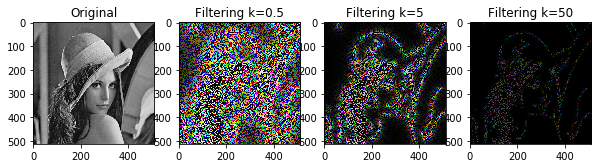

In [418]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,10))

ax1.set_title('Original')
ax1.imshow(gray, cmap='gray')

ax2.set_title('Filtering k=0.5')
ax2.imshow(get_filtered_img(0.5), cmap='gray')

ax3.set_title('Filtering k=5')
ax3.imshow(get_filtered_img(5), cmap='gray')

ax4.set_title('Filtering k=50')
ax4.imshow(get_filtered_img(50), cmap='gray')